<a href="https://colab.research.google.com/github/jm12312/Stock-Market-Price-Prediction/blob/main/Stock_Price_Prediction_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction using Time Series Analysis and Machine Learning

## Project Overview

This project aims to predict future stock prices using a combination of time series analysis, feature engineering, and advanced machine learning techniques. The goal is to build a robust model that can accurately forecast the next day's closing price for various companies, providing valuable insights for investors and financial analysts.

### Key Objectives:

*   **Develop a predictive model:** Create a machine learning model to predict the next day's closing stock price.
*   **Feature Engineering:** Engineer a rich set of features from historical stock data to improve model accuracy.
*   **Model Evaluation:** Evaluate and compare the performance of different machine learning models, including tree-based ensembles and stacking regressors.
*   **Hyperparameter Tuning:** Optimize model performance using systematic hyperparameter tuning techniques.

## Data

The dataset used in this project consists of historical stock data for various companies. The data includes the following features:

*   **Date:** The date of the stock record.
*   **Company:** The name of the company.
*   **Open:** The opening price of the stock.
*   **High:** The highest price of the stock during the day.
*   **Low:** The lowest price of the stock during the day.
*   **Close:** The closing price of the stock.
*   **Volume:** The number of shares traded.
*   **Turnover:** The total value of shares traded.

## Methodology

### 1. Data Preprocessing and Feature Engineering

The initial phase of the project involved extensive data preprocessing and feature engineering to prepare the data for modeling. Key steps included:

*   **Data Cleaning:** Handling missing values and removing outliers to ensure data quality.
*   **Feature Creation:** Generating a variety of new features to capture temporal patterns and historical trends. This included:
    *   **Time-based features:** Day of the week, month, year, quarter, day of the year, and week of the year.
    *   **Cyclical features:** Sine and cosine transformations of time-based features to capture seasonality.
    *   **Price-based features:** Differences between closing, opening, and previous day's closing prices, as well as daily price ranges.
    *   **Historical price features:** Lag features representing the closing prices from previous days (e.g., 2, 3, 5, 7, 14, 21, 30, 60, and 120 days ago).
*   **Data Scaling:** Standardizing numerical features to ensure they have a similar scale, which is crucial for many machine learning algorithms.

### 2. Model Development and Training

Several machine learning models were trained and evaluated to find the best-performing approach for this prediction task. The models included:

*   **Random Forest Regressor:** An ensemble method that combines multiple decision trees to improve predictive accuracy and control overfitting.
*   **XGBoost (Extreme Gradient Boosting):** A powerful and efficient implementation of gradient boosting that has shown excellent performance in many machine learning competitions.
*   **LightGBM (Light Gradient Boosting Machine):** A gradient boosting framework that uses tree-based learning algorithms and is known for its speed and efficiency.

### 3. Hyperparameter Tuning

To optimize the performance of the LightGBM model, we used **Optuna**, a hyperparameter optimization framework. Optuna automatically searches for the best combination of hyperparameters, such as `max_depth`, `learning_rate`, and `reg_lambda`, to minimize the root mean squared error (RMSE) of the model.

### 4. Stacking Ensemble

To further improve predictive performance, a **stacking regressor** was implemented. This ensemble method combines the predictions of multiple base models (XGBoost, Random Forest, and LightGBM) and uses a final estimator (Elastic Net) to generate the final prediction. This approach leverages the strengths of each individual model to create a more robust and accurate forecast.

## Results

The models were evaluated using the Root Mean Squared Error (RMSE) on a test set of data from 2017 onwards. The results were as follows:

*   **Random Forest:** RMSE of 24.84
*   **XGBoost:** Validation RMSE of 23.74
*   **LightGBM (with Optuna tuning):** Best trial RMSE of 23.70
*   **Stacking Regressor:** RMSE of **23.43**

The stacking regressor achieved the lowest RMSE, demonstrating the effectiveness of combining multiple models to improve prediction accuracy. The feature engineering and hyperparameter tuning steps were also crucial in achieving these results.

## Conclusion

This project successfully demonstrates the power of combining advanced feature engineering with sophisticated machine learning models for stock price prediction. The use of tree-based ensembles and a stacking regressor proved to be a highly effective strategy, with the final model achieving a low RMSE on the test data. Future work could explore the use of deep learning models, such as LSTMs, and the incorporation of external data sources, such as news sentiment, to further enhance predictive accuracy.

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

joshuamenezes_stocks_dataset_path = kagglehub.dataset_download('joshuamenezes/stocks-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stocks-dataset/Stocks_data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler

warnings.filterwarnings('ignore')
raw_full_df = pd.read_csv("/kaggle/input/stocks-dataset/Stocks_data.csv")
raw_full_df.drop('Unnamed: 0', axis=1, inplace=True)
raw_full_df = raw_full_df[raw_full_df['Company']!="NIFTY50_all"]
raw_full_df = raw_full_df[['Date', 'Company', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover']]

In [ ]:
raw_full_df['Next Close'] = raw_full_df.groupby("Company")['Close'].shift(-1)

In [ ]:
raw_full_df.dropna(inplace=True)

In [ ]:
Q1 = raw_full_df['Next Close'].quantile(0.25)
Q3 = raw_full_df['Next Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = raw_full_df[(raw_full_df['Next Close'] >= lower_bound) & (raw_full_df['Next Close'] <= upper_bound)]

In [ ]:
def create_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    df['Group'] = ((df['year'] - 2010) * 48 + df['month'] * 4 + df['dayofmonth'] // 7).astype("float32")
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7).astype("float32")
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7).astype("float32")
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12).astype("float32")
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12).astype("float32")
    df['year_sin'] = np.sin(2 * np.pi * df['year'] / (df['year'].max() - df['year'].min())).astype("float32")
    df['year_cos'] = np.cos(2 * np.pi * df['year'] / (df['year'].max() - df['year'].min())).astype("float32")
    df['Season'] = df['month'].apply(lambda x:
                                      'Winter' if x in [12, 1, 2] else
                                      'Spring' if x in [3, 4, 5] else
                                      'Summer' if x in [6, 7, 8] else
                                      'Autumn')

    df['is_monday'] = df['dayofweek'].isin([0]).astype(int)
    df['is_friday'] = df['dayofweek'].isin([4]).astype(int)
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    return df

In [ ]:
new_features = create_features(df_no_outliers)

In [ ]:
def create_features_more(df):
  df["Today_difference"] = df["Close"] - df["Open"]
  df["day_difference"] = df["Close"] - df["Prev Close"]
  df["night_difference"] = df["Open"] - df["Prev Close"]
  df["day_range"] = df["High"] - df["Low"]
  return df

In [ ]:
new_features = create_features_more(new_features)

In [ ]:
def get_historical_data(df):
    df['2_days_ago_price'] = df.groupby('Company')['Close'].shift(2)
    df['3_days_ago_price'] = df.groupby('Company')['Close'].shift(3)
    df['5_days_ago_price'] = df.groupby('Company')['Close'].shift(5)
    df['1_week_ago_price'] = df.groupby('Company')['Close'].shift(7)
    df['2_week_ago_price'] = df.groupby('Company')['Close'].shift(14)
    df['3_week_ago_price'] = df.groupby('Company')['Close'].shift(21)
    df['30_days_ago_price'] = df.groupby('Company')['Close'].shift(30)
    df['60_days_ago_price'] = df.groupby('Company')['Close'].shift(60)
    df['120_days_ago_price'] = df.groupby('Company')['Close'].shift(120)
    return df
new_features = get_historical_data(new_features)
new_features['2_days_ago_price'] = new_features['2_days_ago_price'].fillna(new_features['Prev Close'])
new_features['3_days_ago_price'] = new_features['3_days_ago_price'].fillna(new_features['Prev Close'])
new_features['5_days_ago_price'] = new_features['5_days_ago_price'].fillna(new_features['Prev Close'])
new_features['1_week_ago_price'] = new_features['1_week_ago_price'].fillna(new_features['Prev Close'])
new_features['2_week_ago_price'] = new_features['2_week_ago_price'].fillna(new_features['Prev Close'])
new_features['3_week_ago_price'] = new_features['3_week_ago_price'].fillna(new_features['Prev Close'])
new_features['30_days_ago_price'] = new_features['30_days_ago_price'].fillna(new_features['Prev Close'])
new_features['60_days_ago_price'] = new_features['60_days_ago_price'].fillna(new_features['Prev Close'])
new_features['120_days_ago_price'] = new_features['120_days_ago_price'].fillna(new_features['Prev Close'])


In [ ]:
numeric_cols = ['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close',
       'VWAP', 'Volume', 'Turnover', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Group',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'year_sin',
       'year_cos', 'is_weekend', 'is_month_start', 'is_month_end',
       'is_monday', 'is_friday',
                'Today_difference', 'day_difference',
       'night_difference', 'day_range', '2_days_ago_price', '3_days_ago_price',
       '5_days_ago_price', '1_week_ago_price', '2_week_ago_price',
       '3_week_ago_price', '30_days_ago_price', '60_days_ago_price', "120_days_ago_price"]

categorical_cols = ['Company', 'Season']
target_col = 'Next Close'

In [ ]:
le = LabelEncoder()
for col in categorical_cols:
    new_features[col] = le.fit_transform(new_features[col])

scaler = StandardScaler()
new_features[numeric_cols] = scaler.fit_transform(new_features[numeric_cols])

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# # Example data
# new_features.sort_values(by=["Date", "Company"], inplace=True)
# new_features.reset_index(inplace=True, drop=True)
# X = new_features.drop(columns=["Date", "Next Close"])
# y = new_features["Next Close"]

# # Initialize splitter
# tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# m1 = 0
# m2 = 0
# for train_index, val_index in tscv.split(X):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#     model_dt = RandomForestRegressor(random_state=42, max_depth=7, max_features="sqrt", n_estimators=100)
#     model_dt.fit(X_train, y_train)
#     y_pred = model_dt.predict(X_val)
#     y_pred_2 = model_dt.predict(X_train)
#     rmse_ = rmse(y_val, y_pred)
#     rmse_2 = rmse(y_train, y_pred_2)
#     m1 += (rmse_/5)
#     m2 += (rmse_2/5)
#     print(f"RMSE for test: {rmse_}  RMSE for train: {rmse_2}\n")
# print(f"Average rmse for train: {m2} test: {m1}")

In [ ]:
X_train = new_features[new_features["Date"] <= "2016-12-31"].drop(columns=["Date", "Next Close"])
X_test = new_features[new_features["Date"] > "2016-12-31"].drop(columns=["Date", "Next Close"])
y_train = new_features[new_features["Date"] <= "2016-12-31"]["Next Close"]
y_test = new_features[new_features["Date"] > "2016-12-31"]["Next Close"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((170477, 43), (42158, 43), (170477,), (42158,))

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(a,b):
    return np.sqrt(mean_squared_error(a,b))
def replace_neg_values(y):
  for i in range(len(y)):
    if y[i] < 0:
      y[i] = 0
  return y

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_dt = RandomForestRegressor(random_state=42, max_depth=7, max_features="sqrt", n_estimators=100)
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
y_pred_2 = model_dt.predict(X_train)
rmse_ = rmse(y_test, y_pred)
rmse_2 = rmse(y_train, y_pred_2)
print(f"RMSE for test: {rmse_}  RMSE for train: {rmse_2}\n")

RMSE for test: 24.839004602748048  RMSE for train: 27.377594575609184



In [ ]:
def plot_xgb_feature_importance(model, feature_names=None, max_num_features=20, importance_type='gain'):
    # Get feature importance scores from Booster
    score = model.get_score(importance_type=importance_type)

    if not score:
        print("No feature importances found.")
        return pd.DataFrame()

    # If feature names are provided, map them
    if feature_names is not None:
        score = {feature_names[int(k[1:])]: v for k, v in score.items()}

    # Convert to DataFrame
    feat_imp_df = pd.DataFrame(score.items(), columns=["Feature", "Importance"])
    feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

    # Plot top features
    feat_imp_df.head(max_num_features).plot(
        kind='barh',
        x='Feature',
        y='Importance',
        figsize=(10, 6),
        legend=False
    )
    plt.gca().invert_yaxis()
    plt.title(f"Top {max_num_features} XGBoost Feature Importances ({importance_type})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return feat_imp_df


In [ ]:
!pip install xgboost --upgrade --quiet
import xgboost as xgb
def train_and_predict_xgb_gpu(X_train, Y_train, X_val, Y_val, params, num_boost_round=50000):
    dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=False)
    dval = xgb.DMatrix(X_val, label=Y_val, enable_categorical=False)
    evals = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=1000
    )
    y_pred_train = model.predict(dtrain)
    y_pred_val = model.predict(dval)
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(Y_val, y_pred_val))
    return rmse_train, rmse_val, model

In [ ]:
for i in range(1,2):
    for j in range(5, 6):
        params = {
            'tree_method': 'hist',     # Faster, supported on GPU
            'device': 'cuda',          # Fully runs on GPU
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'learning_rate': 0.01,
            'max_depth': 2,
            'subsample': 1,
            'colsample_bytree': 0.5,
            'min_child_weight': 4,
            # 'gamma': i/10,
            'reg_alpha': 0.1,
            'reg_lambda': 1,
            'seed': 42
        }
        rmse_train, rmse_val, booster = train_and_predict_xgb_gpu(
            X_train.astype(np.float32),
            y_train.astype(np.float32),
            X_test.astype(np.float32),
            y_test.astype(np.float32),
            params,
            num_boost_round=50000
        )
        print(f"Hyperparam: {i} , {j} → Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}")

[0]	train-rmse:583.88762	val-rmse:655.15282
[100]	train-rmse:238.56865	val-rmse:262.10086
[200]	train-rmse:104.13035	val-rmse:110.44149
[300]	train-rmse:52.85906	val-rmse:52.21407
[400]	train-rmse:35.83082	val-rmse:31.88468
[500]	train-rmse:31.33055	val-rmse:25.98360
[600]	train-rmse:30.29082	val-rmse:24.51041
[700]	train-rmse:29.98987	val-rmse:24.12078
[800]	train-rmse:29.83688	val-rmse:23.98096
[900]	train-rmse:29.74432	val-rmse:23.88642
[1000]	train-rmse:29.67709	val-rmse:23.82177
[1100]	train-rmse:29.62607	val-rmse:23.77122
[1200]	train-rmse:29.57240	val-rmse:23.75709
[1300]	train-rmse:29.52919	val-rmse:23.74138
[1349]	train-rmse:29.50842	val-rmse:23.74454
Hyperparam: 1 , 5 → Train RMSE: 29.5078, Val RMSE: 23.7448


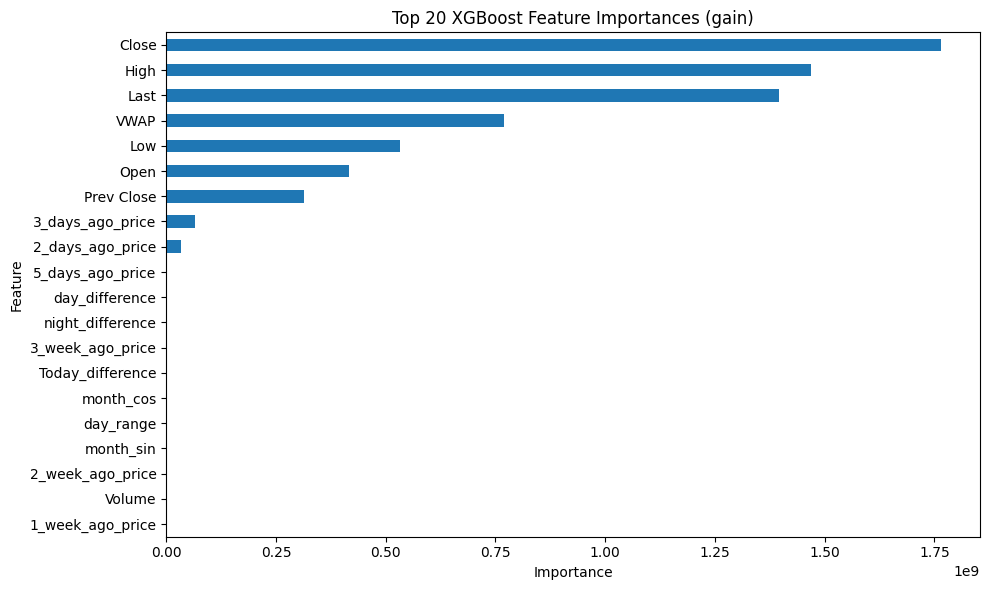

,Feature,Importance
5,Close,1.765805e+09
2,High,1.469251e+09
4,Last,1.396265e+09
6,VWAP,7.699970e+08
3,Low,5.315687e+08
1,Open,4.169404e+08
0,Prev Close,3.130138e+08
27,3_days_ago_price,6.552540e+07
26,2_days_ago_price,3.427967e+07
28,5_days_ago_price,7.302849e+05


In [ ]:
plot_xgb_feature_importance(booster)
# booster

In [ ]:
import optuna
from lightgbm import LGBMRegressor
def objective(trial):
    params = {
        # 'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),
        # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
    }
    print(f"Trial {trial.number} hyperparameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    model = LGBMRegressor(random_state=42, verbose=-1, n_estimators=300, **params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Trial {trial.number} RMSE: {rmse}\n")
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2025-04-14 06:57:38,408] A new study created in memory with name: no-name-466cf999-c299-44cb-a124-3c7cb50abfe3


Trial 0 hyperparameters:
  min_child_samples: 32
  max_depth: 3
  learning_rate: 0.04398639723023173
  subsample: 0.6335168599624226
  colsample_bytree: 0.6928352985774403
  reg_alpha: 1.0748513906368304
  reg_lambda: 18.729617555937228


[I 2025-04-14 06:57:42,572] Trial 0 finished with value: 24.359383501278728 and parameters: {'min_child_samples': 32, 'max_depth': 3, 'learning_rate': 0.04398639723023173, 'subsample': 0.6335168599624226, 'colsample_bytree': 0.6928352985774403, 'reg_alpha': 1.0748513906368304, 'reg_lambda': 18.729617555937228}. Best is trial 0 with value: 24.359383501278728.


Trial 0 RMSE: 24.359383501278728

Trial 1 hyperparameters:
  min_child_samples: 44
  max_depth: 2
  learning_rate: 0.02961193644994571
  subsample: 0.6894009026379235
  colsample_bytree: 0.8360956784950462
  reg_alpha: 97.41233769018447
  reg_lambda: 0.0010737404965542854


[I 2025-04-14 06:57:46,404] Trial 1 finished with value: 23.991491027464306 and parameters: {'min_child_samples': 44, 'max_depth': 2, 'learning_rate': 0.02961193644994571, 'subsample': 0.6894009026379235, 'colsample_bytree': 0.8360956784950462, 'reg_alpha': 97.41233769018447, 'reg_lambda': 0.0010737404965542854}. Best is trial 1 with value: 23.991491027464306.


Trial 1 RMSE: 23.991491027464306

Trial 2 hyperparameters:
  min_child_samples: 23
  max_depth: 2
  learning_rate: 0.028309129594367443
  subsample: 0.5086741376854649
  colsample_bytree: 0.7582274938173117
  reg_alpha: 0.0013954198544574932
  reg_lambda: 0.2707477294375392


[I 2025-04-14 06:57:50,253] Trial 2 finished with value: 23.97385121693154 and parameters: {'min_child_samples': 23, 'max_depth': 2, 'learning_rate': 0.028309129594367443, 'subsample': 0.5086741376854649, 'colsample_bytree': 0.7582274938173117, 'reg_alpha': 0.0013954198544574932, 'reg_lambda': 0.2707477294375392}. Best is trial 2 with value: 23.97385121693154.


Trial 2 RMSE: 23.97385121693154

Trial 3 hyperparameters:
  min_child_samples: 14
  max_depth: 2
  learning_rate: 0.043086807228082336
  subsample: 0.7450074790764524
  colsample_bytree: 0.8182339644952281
  reg_alpha: 4.741599526511274
  reg_lambda: 7.88439811524129


[I 2025-04-14 06:57:54,184] Trial 3 finished with value: 24.08948794068826 and parameters: {'min_child_samples': 14, 'max_depth': 2, 'learning_rate': 0.043086807228082336, 'subsample': 0.7450074790764524, 'colsample_bytree': 0.8182339644952281, 'reg_alpha': 4.741599526511274, 'reg_lambda': 7.88439811524129}. Best is trial 2 with value: 23.97385121693154.


Trial 3 RMSE: 24.08948794068826

Trial 4 hyperparameters:
  min_child_samples: 10
  max_depth: 2
  learning_rate: 0.040120186081331374
  subsample: 0.406058410500098
  colsample_bytree: 0.850668576019787
  reg_alpha: 0.5012386122771014
  reg_lambda: 22.334138318819292


[I 2025-04-14 06:57:58,065] Trial 4 finished with value: 24.02971364256526 and parameters: {'min_child_samples': 10, 'max_depth': 2, 'learning_rate': 0.040120186081331374, 'subsample': 0.406058410500098, 'colsample_bytree': 0.850668576019787, 'reg_alpha': 0.5012386122771014, 'reg_lambda': 22.334138318819292}. Best is trial 2 with value: 23.97385121693154.


Trial 4 RMSE: 24.02971364256526

Trial 5 hyperparameters:
  min_child_samples: 50
  max_depth: 2
  learning_rate: 0.04488509453564973
  subsample: 0.59445371042645
  colsample_bytree: 0.7913995656802029
  reg_alpha: 13.41903525988107
  reg_lambda: 0.0041781245747327216


[I 2025-04-14 06:58:01,862] Trial 5 finished with value: 24.255974420652297 and parameters: {'min_child_samples': 50, 'max_depth': 2, 'learning_rate': 0.04488509453564973, 'subsample': 0.59445371042645, 'colsample_bytree': 0.7913995656802029, 'reg_alpha': 13.41903525988107, 'reg_lambda': 0.0041781245747327216}. Best is trial 2 with value: 23.97385121693154.


Trial 5 RMSE: 24.255974420652297

Trial 6 hyperparameters:
  min_child_samples: 21
  max_depth: 5
  learning_rate: 0.033805660877833744
  subsample: 0.7908624496520735
  colsample_bytree: 0.8348786619667672
  reg_alpha: 0.007537104799605979
  reg_lambda: 0.19667510166957783


[I 2025-04-14 06:58:08,444] Trial 6 finished with value: 26.601147773902916 and parameters: {'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.033805660877833744, 'subsample': 0.7908624496520735, 'colsample_bytree': 0.8348786619667672, 'reg_alpha': 0.007537104799605979, 'reg_lambda': 0.19667510166957783}. Best is trial 2 with value: 23.97385121693154.


Trial 6 RMSE: 26.601147773902916

Trial 7 hyperparameters:
  min_child_samples: 24
  max_depth: 2
  learning_rate: 0.025829110424234632
  subsample: 0.6388782653423278
  colsample_bytree: 0.6069308207289541
  reg_alpha: 0.2045719060815671
  reg_lambda: 0.0202836016054776


[I 2025-04-14 06:58:12,528] Trial 7 finished with value: 23.98659617622077 and parameters: {'min_child_samples': 24, 'max_depth': 2, 'learning_rate': 0.025829110424234632, 'subsample': 0.6388782653423278, 'colsample_bytree': 0.6069308207289541, 'reg_alpha': 0.2045719060815671, 'reg_lambda': 0.0202836016054776}. Best is trial 2 with value: 23.97385121693154.


Trial 7 RMSE: 23.98659617622077

Trial 8 hyperparameters:
  min_child_samples: 31
  max_depth: 2
  learning_rate: 0.04921640841755985
  subsample: 0.652498061464845
  colsample_bytree: 0.857286566599593
  reg_alpha: 0.00043507808790493207
  reg_lambda: 49.220526051723645


[I 2025-04-14 06:58:16,451] Trial 8 finished with value: 24.219325440333677 and parameters: {'min_child_samples': 31, 'max_depth': 2, 'learning_rate': 0.04921640841755985, 'subsample': 0.652498061464845, 'colsample_bytree': 0.857286566599593, 'reg_alpha': 0.00043507808790493207, 'reg_lambda': 49.220526051723645}. Best is trial 2 with value: 23.97385121693154.


Trial 8 RMSE: 24.219325440333677

Trial 9 hyperparameters:
  min_child_samples: 38
  max_depth: 5
  learning_rate: 0.020877575063973825
  subsample: 0.7885265912301255
  colsample_bytree: 0.7812419686142948
  reg_alpha: 5.327174103998642e-05
  reg_lambda: 9.558725058110403


[I 2025-04-14 06:58:23,350] Trial 9 finished with value: 24.762766367821612 and parameters: {'min_child_samples': 38, 'max_depth': 5, 'learning_rate': 0.020877575063973825, 'subsample': 0.7885265912301255, 'colsample_bytree': 0.7812419686142948, 'reg_alpha': 5.327174103998642e-05, 'reg_lambda': 9.558725058110403}. Best is trial 2 with value: 23.97385121693154.


Trial 9 RMSE: 24.762766367821612

Trial 10 hyperparameters:
  min_child_samples: 1
  max_depth: 4
  learning_rate: 0.03513325340659282
  subsample: 0.5072262500155689
  colsample_bytree: 0.7151161831842571
  reg_alpha: 0.005691558071170911
  reg_lambda: 1.3525871099404091e-05


[I 2025-04-14 06:58:28,559] Trial 10 finished with value: 30.37844484839826 and parameters: {'min_child_samples': 1, 'max_depth': 4, 'learning_rate': 0.03513325340659282, 'subsample': 0.5072262500155689, 'colsample_bytree': 0.7151161831842571, 'reg_alpha': 0.005691558071170911, 'reg_lambda': 1.3525871099404091e-05}. Best is trial 2 with value: 23.97385121693154.


Trial 10 RMSE: 30.37844484839826

Trial 11 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.024225739139142475
  subsample: 0.5393500783262163
  colsample_bytree: 0.6024645594272365
  reg_alpha: 0.0885124184041261
  reg_lambda: 0.1417113002324095


[I 2025-04-14 06:58:32,808] Trial 11 finished with value: 23.84291669817387 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.024225739139142475, 'subsample': 0.5393500783262163, 'colsample_bytree': 0.6024645594272365, 'reg_alpha': 0.0885124184041261, 'reg_lambda': 0.1417113002324095}. Best is trial 11 with value: 23.84291669817387.


Trial 11 RMSE: 23.84291669817387

Trial 12 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.020252914062738003
  subsample: 0.5314840128190275
  colsample_bytree: 0.603811960463917
  reg_alpha: 0.0007456701815734239
  reg_lambda: 0.3754285787696935


[I 2025-04-14 06:58:37,049] Trial 12 finished with value: 23.8861112594194 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.020252914062738003, 'subsample': 0.5314840128190275, 'colsample_bytree': 0.603811960463917, 'reg_alpha': 0.0007456701815734239, 'reg_lambda': 0.3754285787696935}. Best is trial 11 with value: 23.84291669817387.


Trial 12 RMSE: 23.8861112594194

Trial 13 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.020547923962768028
  subsample: 0.5420818701096126
  colsample_bytree: 0.606675813423988
  reg_alpha: 1.066489340174173e-05
  reg_lambda: 0.525799040515746


[I 2025-04-14 06:58:41,430] Trial 13 finished with value: 23.86313094772785 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.020547923962768028, 'subsample': 0.5420818701096126, 'colsample_bytree': 0.606675813423988, 'reg_alpha': 1.066489340174173e-05, 'reg_lambda': 0.525799040515746}. Best is trial 11 with value: 23.84291669817387.


Trial 13 RMSE: 23.86313094772785

Trial 14 hyperparameters:
  min_child_samples: 5
  max_depth: 4
  learning_rate: 0.024548607865892743
  subsample: 0.4191760866516558
  colsample_bytree: 0.6545270685261644
  reg_alpha: 1.1502776502394071e-05
  reg_lambda: 1.2489320452467667


[I 2025-04-14 06:58:47,066] Trial 14 finished with value: 24.353105606584478 and parameters: {'min_child_samples': 5, 'max_depth': 4, 'learning_rate': 0.024548607865892743, 'subsample': 0.4191760866516558, 'colsample_bytree': 0.6545270685261644, 'reg_alpha': 1.1502776502394071e-05, 'reg_lambda': 1.2489320452467667}. Best is trial 11 with value: 23.84291669817387.


Trial 14 RMSE: 24.353105606584478

Trial 15 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.023666649619589055
  subsample: 0.5638912985810133
  colsample_bytree: 0.6431318813648126
  reg_alpha: 0.09323190738985776
  reg_lambda: 0.02890127860382324


[I 2025-04-14 06:58:51,469] Trial 15 finished with value: 23.83442479352291 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.023666649619589055, 'subsample': 0.5638912985810133, 'colsample_bytree': 0.6431318813648126, 'reg_alpha': 0.09323190738985776, 'reg_lambda': 0.02890127860382324}. Best is trial 15 with value: 23.83442479352291.


Trial 15 RMSE: 23.83442479352291

Trial 16 hyperparameters:
  min_child_samples: 8
  max_depth: 4
  learning_rate: 0.03219266639794481
  subsample: 0.5674330139127547
  colsample_bytree: 0.6580378576272333
  reg_alpha: 0.03781845442949831
  reg_lambda: 0.029675036942468


[I 2025-04-14 06:58:56,417] Trial 16 finished with value: 25.332545280817225 and parameters: {'min_child_samples': 8, 'max_depth': 4, 'learning_rate': 0.03219266639794481, 'subsample': 0.5674330139127547, 'colsample_bytree': 0.6580378576272333, 'reg_alpha': 0.03781845442949831, 'reg_lambda': 0.029675036942468}. Best is trial 15 with value: 23.83442479352291.


Trial 16 RMSE: 25.332545280817225

Trial 17 hyperparameters:
  min_child_samples: 30
  max_depth: 3
  learning_rate: 0.024519409904045494
  subsample: 0.4617089919512305
  colsample_bytree: 0.6629694823498298
  reg_alpha: 0.07424927468367717
  reg_lambda: 0.0003619123224120839


[I 2025-04-14 06:59:00,747] Trial 17 finished with value: 23.822773062484178 and parameters: {'min_child_samples': 30, 'max_depth': 3, 'learning_rate': 0.024519409904045494, 'subsample': 0.4617089919512305, 'colsample_bytree': 0.6629694823498298, 'reg_alpha': 0.07424927468367717, 'reg_lambda': 0.0003619123224120839}. Best is trial 17 with value: 23.822773062484178.


Trial 17 RMSE: 23.822773062484178

Trial 18 hyperparameters:
  min_child_samples: 31
  max_depth: 3
  learning_rate: 0.03662154939424787
  subsample: 0.47793270547132655
  colsample_bytree: 0.6641728230933316
  reg_alpha: 0.017294863887362313
  reg_lambda: 0.00022201078113101469


[I 2025-04-14 06:59:04,994] Trial 18 finished with value: 24.370460735043828 and parameters: {'min_child_samples': 31, 'max_depth': 3, 'learning_rate': 0.03662154939424787, 'subsample': 0.47793270547132655, 'colsample_bytree': 0.6641728230933316, 'reg_alpha': 0.017294863887362313, 'reg_lambda': 0.00022201078113101469}. Best is trial 17 with value: 23.822773062484178.


Trial 18 RMSE: 24.370460735043828

Trial 19 hyperparameters:
  min_child_samples: 39
  max_depth: 4
  learning_rate: 0.029116855416286096
  subsample: 0.4526358699874646
  colsample_bytree: 0.716878245434899
  reg_alpha: 1.253893924080755
  reg_lambda: 3.716377152828548e-05


[I 2025-04-14 06:59:10,513] Trial 19 finished with value: 24.586646765694095 and parameters: {'min_child_samples': 39, 'max_depth': 4, 'learning_rate': 0.029116855416286096, 'subsample': 0.4526358699874646, 'colsample_bytree': 0.716878245434899, 'reg_alpha': 1.253893924080755, 'reg_lambda': 3.716377152828548e-05}. Best is trial 17 with value: 23.822773062484178.


Trial 19 RMSE: 24.586646765694095

Trial 20 hyperparameters:
  min_child_samples: 36
  max_depth: 3
  learning_rate: 0.026089326613486268
  subsample: 0.4587097445101682
  colsample_bytree: 0.6456140256859894
  reg_alpha: 0.12165108989756748
  reg_lambda: 0.0005797028606664219


[I 2025-04-14 06:59:15,529] Trial 20 finished with value: 23.81158349167651 and parameters: {'min_child_samples': 36, 'max_depth': 3, 'learning_rate': 0.026089326613486268, 'subsample': 0.4587097445101682, 'colsample_bytree': 0.6456140256859894, 'reg_alpha': 0.12165108989756748, 'reg_lambda': 0.0005797028606664219}. Best is trial 20 with value: 23.81158349167651.


Trial 20 RMSE: 23.81158349167651

Trial 21 hyperparameters:
  min_child_samples: 37
  max_depth: 3
  learning_rate: 0.02657223654338581
  subsample: 0.4525268061523748
  colsample_bytree: 0.6377587078996528
  reg_alpha: 0.12110597325879181
  reg_lambda: 0.0002521304374114352


[I 2025-04-14 06:59:19,791] Trial 21 finished with value: 23.967736029040466 and parameters: {'min_child_samples': 37, 'max_depth': 3, 'learning_rate': 0.02657223654338581, 'subsample': 0.4525268061523748, 'colsample_bytree': 0.6377587078996528, 'reg_alpha': 0.12110597325879181, 'reg_lambda': 0.0002521304374114352}. Best is trial 20 with value: 23.81158349167651.


Trial 21 RMSE: 23.967736029040466

Trial 22 hyperparameters:
  min_child_samples: 27
  max_depth: 3
  learning_rate: 0.023729673388446153
  subsample: 0.46411063082889376
  colsample_bytree: 0.6891858305699857
  reg_alpha: 0.03784405781372461
  reg_lambda: 0.0031499161244716804


[I 2025-04-14 06:59:24,348] Trial 22 finished with value: 23.844219078549614 and parameters: {'min_child_samples': 27, 'max_depth': 3, 'learning_rate': 0.023729673388446153, 'subsample': 0.46411063082889376, 'colsample_bytree': 0.6891858305699857, 'reg_alpha': 0.03784405781372461, 'reg_lambda': 0.0031499161244716804}. Best is trial 20 with value: 23.81158349167651.


Trial 22 RMSE: 23.844219078549614

Trial 23 hyperparameters:
  min_child_samples: 43
  max_depth: 3
  learning_rate: 0.03097401724420663
  subsample: 0.4913232611887147
  colsample_bytree: 0.6304379263040935
  reg_alpha: 0.44785412538811215
  reg_lambda: 0.00020951304861018552


[I 2025-04-14 06:59:28,452] Trial 23 finished with value: 24.081125897819543 and parameters: {'min_child_samples': 43, 'max_depth': 3, 'learning_rate': 0.03097401724420663, 'subsample': 0.4913232611887147, 'colsample_bytree': 0.6304379263040935, 'reg_alpha': 0.44785412538811215, 'reg_lambda': 0.00020951304861018552}. Best is trial 20 with value: 23.81158349167651.


Trial 23 RMSE: 24.081125897819543

Trial 24 hyperparameters:
  min_child_samples: 27
  max_depth: 4
  learning_rate: 0.022877831971084877
  subsample: 0.4253772949136399
  colsample_bytree: 0.89391013032724
  reg_alpha: 4.694378296091859
  reg_lambda: 0.005307912590350762


[I 2025-04-14 06:59:34,758] Trial 24 finished with value: 24.1806681436611 and parameters: {'min_child_samples': 27, 'max_depth': 4, 'learning_rate': 0.022877831971084877, 'subsample': 0.4253772949136399, 'colsample_bytree': 0.89391013032724, 'reg_alpha': 4.694378296091859, 'reg_lambda': 0.005307912590350762}. Best is trial 20 with value: 23.81158349167651.


Trial 24 RMSE: 24.1806681436611

Trial 25 hyperparameters:
  min_child_samples: 33
  max_depth: 3
  learning_rate: 0.027071457222930584
  subsample: 0.5769743814224425
  colsample_bytree: 0.6822106915438594
  reg_alpha: 0.004347094721808407
  reg_lambda: 0.0006921534275523622


[I 2025-04-14 06:59:39,010] Trial 25 finished with value: 23.962635842696134 and parameters: {'min_child_samples': 33, 'max_depth': 3, 'learning_rate': 0.027071457222930584, 'subsample': 0.5769743814224425, 'colsample_bytree': 0.6822106915438594, 'reg_alpha': 0.004347094721808407, 'reg_lambda': 0.0006921534275523622}. Best is trial 20 with value: 23.81158349167651.


Trial 25 RMSE: 23.962635842696134

Trial 26 hyperparameters:
  min_child_samples: 35
  max_depth: 4
  learning_rate: 0.02326980765227615
  subsample: 0.4402029011903081
  colsample_bytree: 0.7193007583184322
  reg_alpha: 0.0697245558650058
  reg_lambda: 4.2529423148156934e-05


[I 2025-04-14 06:59:44,813] Trial 26 finished with value: 24.118286770597344 and parameters: {'min_child_samples': 35, 'max_depth': 4, 'learning_rate': 0.02326980765227615, 'subsample': 0.4402029011903081, 'colsample_bytree': 0.7193007583184322, 'reg_alpha': 0.0697245558650058, 'reg_lambda': 4.2529423148156934e-05}. Best is trial 20 with value: 23.81158349167651.


Trial 26 RMSE: 24.118286770597344

Trial 27 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.03765810992505371
  subsample: 0.4004483893883136
  colsample_bytree: 0.6351064317853594
  reg_alpha: 0.4499493677709753
  reg_lambda: 0.010451156682835555


[I 2025-04-14 06:59:49,650] Trial 27 finished with value: 24.397128403946077 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.03765810992505371, 'subsample': 0.4004483893883136, 'colsample_bytree': 0.6351064317853594, 'reg_alpha': 0.4499493677709753, 'reg_lambda': 0.010451156682835555}. Best is trial 20 with value: 23.81158349167651.


Trial 27 RMSE: 24.397128403946077

Trial 28 hyperparameters:
  min_child_samples: 42
  max_depth: 3
  learning_rate: 0.022168475052186432
  subsample: 0.5058132006922469
  colsample_bytree: 0.750846265245068
  reg_alpha: 0.016735270425181567
  reg_lambda: 0.0016694779121837929


[I 2025-04-14 06:59:54,393] Trial 28 finished with value: 23.85498263270105 and parameters: {'min_child_samples': 42, 'max_depth': 3, 'learning_rate': 0.022168475052186432, 'subsample': 0.5058132006922469, 'colsample_bytree': 0.750846265245068, 'reg_alpha': 0.016735270425181567, 'reg_lambda': 0.0016694779121837929}. Best is trial 20 with value: 23.81158349167651.


Trial 28 RMSE: 23.85498263270105

Trial 29 hyperparameters:
  min_child_samples: 28
  max_depth: 4
  learning_rate: 0.03089757956159046
  subsample: 0.6128345383901006
  colsample_bytree: 0.6741284248326718
  reg_alpha: 1.66165175322633
  reg_lambda: 0.07752650397977058


[I 2025-04-14 06:59:59,617] Trial 29 finished with value: 24.595048175000148 and parameters: {'min_child_samples': 28, 'max_depth': 4, 'learning_rate': 0.03089757956159046, 'subsample': 0.6128345383901006, 'colsample_bytree': 0.6741284248326718, 'reg_alpha': 1.66165175322633, 'reg_lambda': 0.07752650397977058}. Best is trial 20 with value: 23.81158349167651.


Trial 29 RMSE: 24.595048175000148

Trial 30 hyperparameters:
  min_child_samples: 47
  max_depth: 3
  learning_rate: 0.025766694660549185
  subsample: 0.689855484371803
  colsample_bytree: 0.700989328466461
  reg_alpha: 0.1723469454421732
  reg_lambda: 6.689758650140294e-05


[I 2025-04-14 07:00:04,280] Trial 30 finished with value: 23.885388489920004 and parameters: {'min_child_samples': 47, 'max_depth': 3, 'learning_rate': 0.025766694660549185, 'subsample': 0.689855484371803, 'colsample_bytree': 0.700989328466461, 'reg_alpha': 0.1723469454421732, 'reg_lambda': 6.689758650140294e-05}. Best is trial 20 with value: 23.81158349167651.


Trial 30 RMSE: 23.885388489920004

Trial 31 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.024180836909896346
  subsample: 0.5477042845737383
  colsample_bytree: 0.6241017091793242
  reg_alpha: 0.0727610574454155
  reg_lambda: 0.08025053296080244


[I 2025-04-14 07:00:08,649] Trial 31 finished with value: 23.798641821372502 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.024180836909896346, 'subsample': 0.5477042845737383, 'colsample_bytree': 0.6241017091793242, 'reg_alpha': 0.0727610574454155, 'reg_lambda': 0.08025053296080244}. Best is trial 31 with value: 23.798641821372502.


Trial 31 RMSE: 23.798641821372502

Trial 32 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.027610435497086003
  subsample: 0.5618403150665616
  colsample_bytree: 0.626084758787749
  reg_alpha: 0.012733757396344242
  reg_lambda: 1.5499290626428932


[I 2025-04-14 07:00:13,099] Trial 32 finished with value: 23.844064266763198 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.027610435497086003, 'subsample': 0.5618403150665616, 'colsample_bytree': 0.626084758787749, 'reg_alpha': 0.012733757396344242, 'reg_lambda': 1.5499290626428932}. Best is trial 31 with value: 23.798641821372502.


Trial 32 RMSE: 23.844064266763198

Trial 33 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.025351957223336483
  subsample: 0.48350569688984535
  colsample_bytree: 0.64894954484081
  reg_alpha: 0.0021079207186578087
  reg_lambda: 0.05917218685372124


[I 2025-04-14 07:00:17,489] Trial 33 finished with value: 23.834683142688313 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025351957223336483, 'subsample': 0.48350569688984535, 'colsample_bytree': 0.64894954484081, 'reg_alpha': 0.0021079207186578087, 'reg_lambda': 0.05917218685372124}. Best is trial 31 with value: 23.798641821372502.


Trial 33 RMSE: 23.834683142688313

Trial 34 hyperparameters:
  min_child_samples: 2
  max_depth: 2
  learning_rate: 0.028872346420501595
  subsample: 0.5303719928457633
  colsample_bytree: 0.6222763470044765
  reg_alpha: 0.04544505130081527
  reg_lambda: 0.0008327481302819211


[I 2025-04-14 07:00:21,668] Trial 34 finished with value: 24.00982576090939 and parameters: {'min_child_samples': 2, 'max_depth': 2, 'learning_rate': 0.028872346420501595, 'subsample': 0.5303719928457633, 'colsample_bytree': 0.6222763470044765, 'reg_alpha': 0.04544505130081527, 'reg_lambda': 0.0008327481302819211}. Best is trial 31 with value: 23.798641821372502.


Trial 34 RMSE: 24.00982576090939

Trial 35 hyperparameters:
  min_child_samples: 7
  max_depth: 2
  learning_rate: 0.021527731675277634
  subsample: 0.5987754509747281
  colsample_bytree: 0.6693748188936636
  reg_alpha: 3.011048644493129
  reg_lambda: 0.013725001586328747


[I 2025-04-14 07:00:25,464] Trial 35 finished with value: 24.170478341531897 and parameters: {'min_child_samples': 7, 'max_depth': 2, 'learning_rate': 0.021527731675277634, 'subsample': 0.5987754509747281, 'colsample_bytree': 0.6693748188936636, 'reg_alpha': 3.011048644493129, 'reg_lambda': 0.013725001586328747}. Best is trial 31 with value: 23.798641821372502.


Trial 35 RMSE: 24.170478341531897

Trial 36 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.0225801633038006
  subsample: 0.7001824423958722
  colsample_bytree: 0.698934567551917
  reg_alpha: 16.805755525223844
  reg_lambda: 0.00042400733766495964


[I 2025-04-14 07:00:30,045] Trial 36 finished with value: 23.79859774312386 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.0225801633038006, 'subsample': 0.7001824423958722, 'colsample_bytree': 0.698934567551917, 'reg_alpha': 16.805755525223844, 'reg_lambda': 0.00042400733766495964}. Best is trial 36 with value: 23.79859774312386.


Trial 36 RMSE: 23.79859774312386

Trial 37 hyperparameters:
  min_child_samples: 18
  max_depth: 2
  learning_rate: 0.03036839119448798
  subsample: 0.7035928295080092
  colsample_bytree: 0.697603852889026
  reg_alpha: 14.368487533988482
  reg_lambda: 0.0004581667561178173


[I 2025-04-14 07:00:33,824] Trial 37 finished with value: 23.96607267318451 and parameters: {'min_child_samples': 18, 'max_depth': 2, 'learning_rate': 0.03036839119448798, 'subsample': 0.7035928295080092, 'colsample_bytree': 0.697603852889026, 'reg_alpha': 14.368487533988482, 'reg_lambda': 0.0004581667561178173}. Best is trial 36 with value: 23.79859774312386.


Trial 37 RMSE: 23.96607267318451

Trial 38 hyperparameters:
  min_child_samples: 34
  max_depth: 3
  learning_rate: 0.027251570846406482
  subsample: 0.7140613035415996
  colsample_bytree: 0.7224548108184226
  reg_alpha: 65.03026156871475
  reg_lambda: 8.754865310914733e-05


[I 2025-04-14 07:00:38,239] Trial 38 finished with value: 23.95751208735163 and parameters: {'min_child_samples': 34, 'max_depth': 3, 'learning_rate': 0.027251570846406482, 'subsample': 0.7140613035415996, 'colsample_bytree': 0.7224548108184226, 'reg_alpha': 65.03026156871475, 'reg_lambda': 8.754865310914733e-05}. Best is trial 36 with value: 23.79859774312386.


Trial 38 RMSE: 23.95751208735163

Trial 39 hyperparameters:
  min_child_samples: 30
  max_depth: 2
  learning_rate: 0.03289766446211578
  subsample: 0.6641064215029147
  colsample_bytree: 0.7386979330519771
  reg_alpha: 16.76866701350671
  reg_lambda: 1.0247161390137703e-05


[I 2025-04-14 07:00:41,933] Trial 39 finished with value: 24.004616353594205 and parameters: {'min_child_samples': 30, 'max_depth': 2, 'learning_rate': 0.03289766446211578, 'subsample': 0.6641064215029147, 'colsample_bytree': 0.7386979330519771, 'reg_alpha': 16.76866701350671, 'reg_lambda': 1.0247161390137703e-05}. Best is trial 36 with value: 23.79859774312386.


Trial 39 RMSE: 24.004616353594205

Trial 40 hyperparameters:
  min_child_samples: 24
  max_depth: 3
  learning_rate: 0.02216285999797541
  subsample: 0.7473680299677421
  colsample_bytree: 0.6786137831929128
  reg_alpha: 0.0001943714258903887
  reg_lambda: 0.00233722652194861


[I 2025-04-14 07:00:46,398] Trial 40 finished with value: 23.831729987376775 and parameters: {'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.02216285999797541, 'subsample': 0.7473680299677421, 'colsample_bytree': 0.6786137831929128, 'reg_alpha': 0.0001943714258903887, 'reg_lambda': 0.00233722652194861}. Best is trial 36 with value: 23.79859774312386.


Trial 40 RMSE: 23.831729987376775

Trial 41 hyperparameters:
  min_child_samples: 24
  max_depth: 3
  learning_rate: 0.022722702529007585
  subsample: 0.7580652905639349
  colsample_bytree: 0.6853961644900608
  reg_alpha: 0.31779006062356596
  reg_lambda: 0.004444175398999188


[I 2025-04-14 07:00:51,066] Trial 41 finished with value: 23.807680601851995 and parameters: {'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.022722702529007585, 'subsample': 0.7580652905639349, 'colsample_bytree': 0.6853961644900608, 'reg_alpha': 0.31779006062356596, 'reg_lambda': 0.004444175398999188}. Best is trial 36 with value: 23.79859774312386.


Trial 41 RMSE: 23.807680601851995

Trial 42 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02513650575305057
  subsample: 0.7376659723742367
  colsample_bytree: 0.7734116891483168
  reg_alpha: 0.27338377647913575
  reg_lambda: 0.0053543247674549726


[I 2025-04-14 07:00:55,942] Trial 42 finished with value: 23.83362520879392 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02513650575305057, 'subsample': 0.7376659723742367, 'colsample_bytree': 0.7734116891483168, 'reg_alpha': 0.27338377647913575, 'reg_lambda': 0.0053543247674549726}. Best is trial 36 with value: 23.79859774312386.


Trial 42 RMSE: 23.83362520879392

Trial 43 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.02170312970960329
  subsample: 0.7774114641286239
  colsample_bytree: 0.7032865938968541
  reg_alpha: 0.5747526892882615
  reg_lambda: 0.00119741254647573


[I 2025-04-14 07:01:00,599] Trial 43 finished with value: 23.80611605626356 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.02170312970960329, 'subsample': 0.7774114641286239, 'colsample_bytree': 0.7032865938968541, 'reg_alpha': 0.5747526892882615, 'reg_lambda': 0.00119741254647573}. Best is trial 36 with value: 23.79859774312386.


Trial 43 RMSE: 23.80611605626356

Trial 44 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.0200242840924054
  subsample: 0.7753033243996438
  colsample_bytree: 0.7346792969275057
  reg_alpha: 48.89930821017425
  reg_lambda: 0.0016707782398316057


[I 2025-04-14 07:01:05,453] Trial 44 finished with value: 23.88441114115371 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.0200242840924054, 'subsample': 0.7753033243996438, 'colsample_bytree': 0.7346792969275057, 'reg_alpha': 48.89930821017425, 'reg_lambda': 0.0016707782398316057}. Best is trial 36 with value: 23.79859774312386.


Trial 44 RMSE: 23.88441114115371

Trial 45 hyperparameters:
  min_child_samples: 17
  max_depth: 2
  learning_rate: 0.02177331899692526
  subsample: 0.7624181374724501
  colsample_bytree: 0.6957788910899163
  reg_alpha: 0.6093312576419951
  reg_lambda: 0.008468826698617937


[I 2025-04-14 07:01:09,208] Trial 45 finished with value: 24.154473342945572 and parameters: {'min_child_samples': 17, 'max_depth': 2, 'learning_rate': 0.02177331899692526, 'subsample': 0.7624181374724501, 'colsample_bytree': 0.6957788910899163, 'reg_alpha': 0.6093312576419951, 'reg_lambda': 0.008468826698617937}. Best is trial 36 with value: 23.79859774312386.


Trial 45 RMSE: 24.154473342945572

Trial 46 hyperparameters:
  min_child_samples: 24
  max_depth: 5
  learning_rate: 0.044323381843872744
  subsample: 0.7308094833240864
  colsample_bytree: 0.6169376958391438
  reg_alpha: 2.523254066968924
  reg_lambda: 0.0010879813553772194


[I 2025-04-14 07:01:14,755] Trial 46 finished with value: 27.14581094138946 and parameters: {'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.044323381843872744, 'subsample': 0.7308094833240864, 'colsample_bytree': 0.6169376958391438, 'reg_alpha': 2.523254066968924, 'reg_lambda': 0.0010879813553772194}. Best is trial 36 with value: 23.79859774312386.


Trial 46 RMSE: 27.14581094138946

Trial 47 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.022951307266863737
  subsample: 0.7660089787340468
  colsample_bytree: 0.7066626848756365
  reg_alpha: 6.581895313839165
  reg_lambda: 0.00010716754066759556


[I 2025-04-14 07:01:19,251] Trial 47 finished with value: 23.81016010791489 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.022951307266863737, 'subsample': 0.7660089787340468, 'colsample_bytree': 0.7066626848756365, 'reg_alpha': 6.581895313839165, 'reg_lambda': 0.00010716754066759556}. Best is trial 36 with value: 23.79859774312386.


Trial 47 RMSE: 23.81016010791489

Trial 48 hyperparameters:
  min_child_samples: 13
  max_depth: 4
  learning_rate: 0.022747599492933826
  subsample: 0.7985706994522327
  colsample_bytree: 0.7079261254704075
  reg_alpha: 31.24661689279765
  reg_lambda: 0.0001067879717257712


[I 2025-04-14 07:01:25,505] Trial 48 finished with value: 24.081269931131313 and parameters: {'min_child_samples': 13, 'max_depth': 4, 'learning_rate': 0.022747599492933826, 'subsample': 0.7985706994522327, 'colsample_bytree': 0.7079261254704075, 'reg_alpha': 31.24661689279765, 'reg_lambda': 0.0001067879717257712}. Best is trial 36 with value: 23.79859774312386.


Trial 48 RMSE: 24.081269931131313

Trial 49 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.04707120941335701
  subsample: 0.7646284974413046
  colsample_bytree: 0.7637917714203698
  reg_alpha: 6.75048341961018
  reg_lambda: 0.09574949060943264


[I 2025-04-14 07:01:29,867] Trial 49 finished with value: 25.1191571087415 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.04707120941335701, 'subsample': 0.7646284974413046, 'colsample_bytree': 0.7637917714203698, 'reg_alpha': 6.75048341961018, 'reg_lambda': 0.09574949060943264}. Best is trial 36 with value: 23.79859774312386.


Trial 49 RMSE: 25.1191571087415

Trial 50 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.04276089721306999
  subsample: 0.7789844133952529
  colsample_bytree: 0.7374020339106541
  reg_alpha: 6.378002090341651
  reg_lambda: 2.2711493323295886e-05


[I 2025-04-14 07:01:34,244] Trial 50 finished with value: 24.99367465450926 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.04276089721306999, 'subsample': 0.7789844133952529, 'colsample_bytree': 0.7374020339106541, 'reg_alpha': 6.378002090341651, 'reg_lambda': 2.2711493323295886e-05}. Best is trial 36 with value: 23.79859774312386.


Trial 50 RMSE: 24.99367465450926

Trial 51 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.021267203063603957
  subsample: 0.6702944848432942
  colsample_bytree: 0.6491302469906285
  reg_alpha: 0.7785282454575919
  reg_lambda: 0.00013567426577822483


[I 2025-04-14 07:01:38,698] Trial 51 finished with value: 23.80212643855564 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.021267203063603957, 'subsample': 0.6702944848432942, 'colsample_bytree': 0.6491302469906285, 'reg_alpha': 0.7785282454575919, 'reg_lambda': 0.00013567426577822483}. Best is trial 36 with value: 23.79859774312386.


Trial 51 RMSE: 23.80212643855564

Trial 52 hyperparameters:
  min_child_samples: 25
  max_depth: 3
  learning_rate: 0.021091946351504125
  subsample: 0.6576092104813165
  colsample_bytree: 0.682312868773659
  reg_alpha: 0.927346946320525
  reg_lambda: 0.0010956233610836833


[I 2025-04-14 07:01:43,245] Trial 52 finished with value: 23.865646472255516 and parameters: {'min_child_samples': 25, 'max_depth': 3, 'learning_rate': 0.021091946351504125, 'subsample': 0.6576092104813165, 'colsample_bytree': 0.682312868773659, 'reg_alpha': 0.927346946320525, 'reg_lambda': 0.0010956233610836833}. Best is trial 36 with value: 23.79859774312386.


Trial 52 RMSE: 23.865646472255516

Trial 53 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.020058067706386882
  subsample: 0.7208146827564572
  colsample_bytree: 0.8016268655876609
  reg_alpha: 2.094468339546641
  reg_lambda: 0.00016225076709448717


[I 2025-04-14 07:01:48,080] Trial 53 finished with value: 23.891300436853992 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.020058067706386882, 'subsample': 0.7208146827564572, 'colsample_bytree': 0.8016268655876609, 'reg_alpha': 2.094468339546641, 'reg_lambda': 0.00016225076709448717}. Best is trial 36 with value: 23.79859774312386.


Trial 53 RMSE: 23.891300436853992

Trial 54 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.023799208817791934
  subsample: 0.67159790513611
  colsample_bytree: 0.7074351746524884
  reg_alpha: 1.0691082028033616
  reg_lambda: 0.00038595470687761193


[I 2025-04-14 07:01:52,583] Trial 54 finished with value: 23.800692673159315 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.023799208817791934, 'subsample': 0.67159790513611, 'colsample_bytree': 0.7074351746524884, 'reg_alpha': 1.0691082028033616, 'reg_lambda': 0.00038595470687761193}. Best is trial 36 with value: 23.79859774312386.


Trial 54 RMSE: 23.800692673159315

Trial 55 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02419471854715316
  subsample: 0.6728478964897323
  colsample_bytree: 0.6564947467161916
  reg_alpha: 0.2879721202130193
  reg_lambda: 0.000292687133178318


[I 2025-04-14 07:01:57,549] Trial 55 finished with value: 23.861672503768894 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02419471854715316, 'subsample': 0.6728478964897323, 'colsample_bytree': 0.6564947467161916, 'reg_alpha': 0.2879721202130193, 'reg_lambda': 0.000292687133178318}. Best is trial 36 with value: 23.79859774312386.


Trial 55 RMSE: 23.861672503768894

Trial 56 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.021099434145527573
  subsample: 0.6437428164327204
  colsample_bytree: 0.68848878211589
  reg_alpha: 0.9848419919375816
  reg_lambda: 0.03906328757435902


[I 2025-04-14 07:02:02,079] Trial 56 finished with value: 23.870567752697212 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.021099434145527573, 'subsample': 0.6437428164327204, 'colsample_bytree': 0.68848878211589, 'reg_alpha': 0.9848419919375816, 'reg_lambda': 0.03906328757435902}. Best is trial 36 with value: 23.79859774312386.


Trial 56 RMSE: 23.870567752697212

Trial 57 hyperparameters:
  min_child_samples: 15
  max_depth: 2
  learning_rate: 0.028063249561244952
  subsample: 0.6199409636142589
  colsample_bytree: 0.7313110554746781
  reg_alpha: 0.2775889813387893
  reg_lambda: 0.01686043018440358


[I 2025-04-14 07:02:05,774] Trial 57 finished with value: 24.01707859962293 and parameters: {'min_child_samples': 15, 'max_depth': 2, 'learning_rate': 0.028063249561244952, 'subsample': 0.6199409636142589, 'colsample_bytree': 0.7313110554746781, 'reg_alpha': 0.2775889813387893, 'reg_lambda': 0.01686043018440358}. Best is trial 36 with value: 23.79859774312386.


Trial 57 RMSE: 24.01707859962293

Trial 58 hyperparameters:
  min_child_samples: 26
  max_depth: 4
  learning_rate: 0.02489160331301683
  subsample: 0.6900285264140382
  colsample_bytree: 0.6670885511544234
  reg_alpha: 0.9179979746886952
  reg_lambda: 0.003285980360560282


[I 2025-04-14 07:02:11,164] Trial 58 finished with value: 24.298978478720148 and parameters: {'min_child_samples': 26, 'max_depth': 4, 'learning_rate': 0.02489160331301683, 'subsample': 0.6900285264140382, 'colsample_bytree': 0.6670885511544234, 'reg_alpha': 0.9179979746886952, 'reg_lambda': 0.003285980360560282}. Best is trial 36 with value: 23.79859774312386.


Trial 58 RMSE: 24.298978478720148

Trial 59 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.02165940474290165
  subsample: 0.7485769949582057
  colsample_bytree: 0.6180271136736498
  reg_alpha: 0.5200452048651265
  reg_lambda: 0.19158754524419555


[I 2025-04-14 07:02:15,501] Trial 59 finished with value: 23.826845490078146 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.02165940474290165, 'subsample': 0.7485769949582057, 'colsample_bytree': 0.6180271136736498, 'reg_alpha': 0.5200452048651265, 'reg_lambda': 0.19158754524419555}. Best is trial 36 with value: 23.79859774312386.


Trial 59 RMSE: 23.826845490078146

Trial 60 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.023833578373635013
  subsample: 0.6779240795760635
  colsample_bytree: 0.7112224935914184
  reg_alpha: 3.4006530556479775
  reg_lambda: 0.0004701731918912259


[I 2025-04-14 07:02:20,060] Trial 60 finished with value: 23.76953523039418 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.023833578373635013, 'subsample': 0.6779240795760635, 'colsample_bytree': 0.7112224935914184, 'reg_alpha': 3.4006530556479775, 'reg_lambda': 0.0004701731918912259}. Best is trial 60 with value: 23.76953523039418.


Trial 60 RMSE: 23.76953523039418

Trial 61 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02380847470135874
  subsample: 0.675052046999443
  colsample_bytree: 0.7099725001744078
  reg_alpha: 3.378535144250389
  reg_lambda: 0.0005819295444088838


[I 2025-04-14 07:02:24,769] Trial 61 finished with value: 23.80118652364314 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02380847470135874, 'subsample': 0.675052046999443, 'colsample_bytree': 0.7099725001744078, 'reg_alpha': 3.378535144250389, 'reg_lambda': 0.0005819295444088838}. Best is trial 60 with value: 23.76953523039418.


Trial 61 RMSE: 23.80118652364314

Trial 62 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.0238289462474712
  subsample: 0.6758177495586606
  colsample_bytree: 0.7132225919993779
  reg_alpha: 3.22721133198121
  reg_lambda: 4.842980814096019e-05


[I 2025-04-14 07:02:29,796] Trial 62 finished with value: 23.847186936653348 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.0238289462474712, 'subsample': 0.6758177495586606, 'colsample_bytree': 0.7132225919993779, 'reg_alpha': 3.22721133198121, 'reg_lambda': 4.842980814096019e-05}. Best is trial 60 with value: 23.76953523039418.


Trial 62 RMSE: 23.847186936653348

Trial 63 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02650560113259054
  subsample: 0.6285334955813994
  colsample_bytree: 0.7522631848615353
  reg_alpha: 23.77912107372591
  reg_lambda: 0.00047732890209735695


[I 2025-04-14 07:02:34,436] Trial 63 finished with value: 23.879113944860485 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02650560113259054, 'subsample': 0.6285334955813994, 'colsample_bytree': 0.7522631848615353, 'reg_alpha': 23.77912107372591, 'reg_lambda': 0.00047732890209735695}. Best is trial 60 with value: 23.76953523039418.


Trial 63 RMSE: 23.879113944860485

Trial 64 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02390044287032649
  subsample: 0.6997685866955128
  colsample_bytree: 0.7275688724291076
  reg_alpha: 9.812749258841054
  reg_lambda: 0.0001629533630012357


[I 2025-04-14 07:02:38,974] Trial 64 finished with value: 23.841650943513734 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02390044287032649, 'subsample': 0.6997685866955128, 'colsample_bytree': 0.7275688724291076, 'reg_alpha': 9.812749258841054, 'reg_lambda': 0.0001629533630012357}. Best is trial 60 with value: 23.76953523039418.


Trial 64 RMSE: 23.841650943513734

Trial 65 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.025401385789039856
  subsample: 0.6432471216647816
  colsample_bytree: 0.7046894903697778
  reg_alpha: 1.706234096291955
  reg_lambda: 0.0003387328789808197


[I 2025-04-14 07:02:43,532] Trial 65 finished with value: 23.820226306132703 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.025401385789039856, 'subsample': 0.6432471216647816, 'colsample_bytree': 0.7046894903697778, 'reg_alpha': 1.706234096291955, 'reg_lambda': 0.0003387328789808197}. Best is trial 60 with value: 23.76953523039418.


Trial 65 RMSE: 23.820226306132703

Trial 66 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.022205474216185885
  subsample: 0.679235394517277
  colsample_bytree: 0.6942563500755351
  reg_alpha: 4.046898280534748
  reg_lambda: 2.2930936481302304e-05


[I 2025-04-14 07:02:48,145] Trial 66 finished with value: 23.765370719492243 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.022205474216185885, 'subsample': 0.679235394517277, 'colsample_bytree': 0.6942563500755351, 'reg_alpha': 4.046898280534748, 'reg_lambda': 2.2930936481302304e-05}. Best is trial 66 with value: 23.765370719492243.


Trial 66 RMSE: 23.765370719492243

Trial 67 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.0262935340560364
  subsample: 0.6666379408764223
  colsample_bytree: 0.6439628024197139
  reg_alpha: 3.9431850769197747
  reg_lambda: 2.1448606503610042e-05


[I 2025-04-14 07:02:52,407] Trial 67 finished with value: 24.075231490934556 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.0262935340560364, 'subsample': 0.6666379408764223, 'colsample_bytree': 0.6439628024197139, 'reg_alpha': 3.9431850769197747, 'reg_lambda': 2.1448606503610042e-05}. Best is trial 66 with value: 23.765370719492243.


Trial 67 RMSE: 24.075231490934556

Trial 68 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024677888201780573
  subsample: 0.6755910744181216
  colsample_bytree: 0.7431141106844525
  reg_alpha: 40.821771285766445
  reg_lambda: 2.4032353312387528e-05


[I 2025-04-14 07:02:57,101] Trial 68 finished with value: 23.81061055591032 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024677888201780573, 'subsample': 0.6755910744181216, 'colsample_bytree': 0.7431141106844525, 'reg_alpha': 40.821771285766445, 'reg_lambda': 2.4032353312387528e-05}. Best is trial 66 with value: 23.765370719492243.


Trial 68 RMSE: 23.81061055591032

Trial 69 hyperparameters:
  min_child_samples: 7
  max_depth: 4
  learning_rate: 0.02322205167465729
  subsample: 0.7014861153434229
  colsample_bytree: 0.7209455464489655
  reg_alpha: 11.366572908558942
  reg_lambda: 0.5528512769464914


[I 2025-04-14 07:03:03,660] Trial 69 finished with value: 24.357242914128033 and parameters: {'min_child_samples': 7, 'max_depth': 4, 'learning_rate': 0.02322205167465729, 'subsample': 0.7014861153434229, 'colsample_bytree': 0.7209455464489655, 'reg_alpha': 11.366572908558942, 'reg_lambda': 0.5528512769464914}. Best is trial 66 with value: 23.765370719492243.


Trial 69 RMSE: 24.357242914128033

Trial 70 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.03967042232288052
  subsample: 0.5843680641019465
  colsample_bytree: 0.6749229225936275
  reg_alpha: 1.6958084897543728
  reg_lambda: 70.82808608319701


[I 2025-04-14 07:03:07,650] Trial 70 finished with value: 23.954636345321006 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.03967042232288052, 'subsample': 0.5843680641019465, 'colsample_bytree': 0.6749229225936275, 'reg_alpha': 1.6958084897543728, 'reg_lambda': 70.82808608319701}. Best is trial 66 with value: 23.765370719492243.


Trial 70 RMSE: 23.954636345321006

Trial 71 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02090703264758813
  subsample: 0.65244619358232
  colsample_bytree: 0.6930066488264345
  reg_alpha: 4.580346721178622
  reg_lambda: 0.0007262368548219027


[I 2025-04-14 07:03:12,282] Trial 71 finished with value: 23.842374596242184 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02090703264758813, 'subsample': 0.65244619358232, 'colsample_bytree': 0.6930066488264345, 'reg_alpha': 4.580346721178622, 'reg_lambda': 0.0007262368548219027}. Best is trial 66 with value: 23.765370719492243.


Trial 71 RMSE: 23.842374596242184

Trial 72 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.022259647257321095
  subsample: 0.6849185607896164
  colsample_bytree: 0.7145225099155844
  reg_alpha: 0.7169211270346207
  reg_lambda: 6.165270551962944e-05


[I 2025-04-14 07:03:16,988] Trial 72 finished with value: 23.761358139998148 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.022259647257321095, 'subsample': 0.6849185607896164, 'colsample_bytree': 0.7145225099155844, 'reg_alpha': 0.7169211270346207, 'reg_lambda': 6.165270551962944e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 72 RMSE: 23.761358139998148

Trial 73 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.022202554251538453
  subsample: 0.6793387351457473
  colsample_bytree: 0.7149248207550188
  reg_alpha: 1.168556552877085
  reg_lambda: 3.6324269630685475e-05


[I 2025-04-14 07:03:21,614] Trial 73 finished with value: 24.03569684359968 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.022202554251538453, 'subsample': 0.6793387351457473, 'colsample_bytree': 0.7149248207550188, 'reg_alpha': 1.168556552877085, 'reg_lambda': 3.6324269630685475e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 73 RMSE: 24.03569684359968

Trial 74 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023504927781305165
  subsample: 0.7242053413477487
  colsample_bytree: 0.6545536641156202
  reg_alpha: 20.161193900719706
  reg_lambda: 6.529734930862479e-05


[I 2025-04-14 07:03:25,939] Trial 74 finished with value: 23.817876735689357 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023504927781305165, 'subsample': 0.7242053413477487, 'colsample_bytree': 0.6545536641156202, 'reg_alpha': 20.161193900719706, 'reg_lambda': 6.529734930862479e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 74 RMSE: 23.817876735689357

Trial 75 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.020866635192375773
  subsample: 0.7114562971540966
  colsample_bytree: 0.7109579824026887
  reg_alpha: 89.15301874435625
  reg_lambda: 0.00015950221875470793


[I 2025-04-14 07:03:30,539] Trial 75 finished with value: 23.845453744023846 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.020866635192375773, 'subsample': 0.7114562971540966, 'colsample_bytree': 0.7109579824026887, 'reg_alpha': 89.15301874435625, 'reg_lambda': 0.00015950221875470793}. Best is trial 72 with value: 23.761358139998148.


Trial 75 RMSE: 23.845453744023846

Trial 76 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02251014362145389
  subsample: 0.686374008125883
  colsample_bytree: 0.6110196828461455
  reg_alpha: 0.16757241793157499
  reg_lambda: 1.3859265087390507e-05


[I 2025-04-14 07:03:35,424] Trial 76 finished with value: 23.78699981800146 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02251014362145389, 'subsample': 0.686374008125883, 'colsample_bytree': 0.6110196828461455, 'reg_alpha': 0.16757241793157499, 'reg_lambda': 1.3859265087390507e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 76 RMSE: 23.78699981800146

Trial 77 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.024586933078684467
  subsample: 0.6862026210259204
  colsample_bytree: 0.767412183926404
  reg_alpha: 0.1497856243125596
  reg_lambda: 1.4025209946756317e-05


[I 2025-04-14 07:03:40,073] Trial 77 finished with value: 23.82656989655675 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.024586933078684467, 'subsample': 0.6862026210259204, 'colsample_bytree': 0.767412183926404, 'reg_alpha': 0.1497856243125596, 'reg_lambda': 1.4025209946756317e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 77 RMSE: 23.82656989655675

Trial 78 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02249630211661569
  subsample: 0.6562499698061788
  colsample_bytree: 0.6132238146405244
  reg_alpha: 9.040686615575428
  reg_lambda: 1.526963003963717e-05


[I 2025-04-14 07:03:44,349] Trial 78 finished with value: 23.813322124429895 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02249630211661569, 'subsample': 0.6562499698061788, 'colsample_bytree': 0.6132238146405244, 'reg_alpha': 9.040686615575428, 'reg_lambda': 1.526963003963717e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 78 RMSE: 23.813322124429895

Trial 79 hyperparameters:
  min_child_samples: 10
  max_depth: 4
  learning_rate: 0.025736486313344558
  subsample: 0.6087131463815098
  colsample_bytree: 0.6012466359022587
  reg_alpha: 0.053768638516640516
  reg_lambda: 6.420421354652067e-05


[I 2025-04-14 07:03:49,534] Trial 79 finished with value: 24.37974469042958 and parameters: {'min_child_samples': 10, 'max_depth': 4, 'learning_rate': 0.025736486313344558, 'subsample': 0.6087131463815098, 'colsample_bytree': 0.6012466359022587, 'reg_alpha': 0.053768638516640516, 'reg_lambda': 6.420421354652067e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 79 RMSE: 24.37974469042958

Trial 80 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02826533772750574
  subsample: 0.6934403585416271
  colsample_bytree: 0.7264018320737825
  reg_alpha: 0.0925541394312997
  reg_lambda: 1.0579571792313613e-05


[I 2025-04-14 07:03:54,076] Trial 80 finished with value: 24.13233592822246 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02826533772750574, 'subsample': 0.6934403585416271, 'colsample_bytree': 0.7264018320737825, 'reg_alpha': 0.0925541394312997, 'reg_lambda': 1.0579571792313613e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 80 RMSE: 24.13233592822246

Trial 81 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.023387026280794032
  subsample: 0.6324385920159205
  colsample_bytree: 0.6320773637047324
  reg_alpha: 2.49212550888771
  reg_lambda: 2.6002173827972815e-05


[I 2025-04-14 07:03:58,484] Trial 81 finished with value: 23.81610815748648 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.023387026280794032, 'subsample': 0.6324385920159205, 'colsample_bytree': 0.6320773637047324, 'reg_alpha': 2.49212550888771, 'reg_lambda': 2.6002173827972815e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 81 RMSE: 23.81610815748648

Trial 82 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.022258590427869825
  subsample: 0.6832018890724358
  colsample_bytree: 0.6116280094655923
  reg_alpha: 0.024344360148908294
  reg_lambda: 3.69204987726413e-05


[I 2025-04-14 07:04:02,917] Trial 82 finished with value: 23.808988438357165 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.022258590427869825, 'subsample': 0.6832018890724358, 'colsample_bytree': 0.6116280094655923, 'reg_alpha': 0.024344360148908294, 'reg_lambda': 3.69204987726413e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 82 RMSE: 23.808988438357165

Trial 83 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.020653358541779784
  subsample: 0.7065222726126148
  colsample_bytree: 0.696803588331006
  reg_alpha: 0.165808148956128
  reg_lambda: 8.396813998991679e-05


[I 2025-04-14 07:04:08,028] Trial 83 finished with value: 24.068280278802938 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.020653358541779784, 'subsample': 0.7065222726126148, 'colsample_bytree': 0.696803588331006, 'reg_alpha': 0.165808148956128, 'reg_lambda': 8.396813998991679e-05}. Best is trial 72 with value: 23.761358139998148.


Trial 83 RMSE: 24.068280278802938

Trial 84 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.024204814853280066
  subsample: 0.6488045148923046
  colsample_bytree: 0.6272699746065437
  reg_alpha: 0.40143875156422687
  reg_lambda: 0.00023920660530360563


[I 2025-04-14 07:04:12,487] Trial 84 finished with value: 23.84256125597761 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.024204814853280066, 'subsample': 0.6488045148923046, 'colsample_bytree': 0.6272699746065437, 'reg_alpha': 0.40143875156422687, 'reg_lambda': 0.00023920660530360563}. Best is trial 72 with value: 23.761358139998148.


Trial 84 RMSE: 23.84256125597761

Trial 85 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.021555723270305152
  subsample: 0.662663579233177
  colsample_bytree: 0.6896924471454017
  reg_alpha: 0.7669330300914025
  reg_lambda: 0.0001251761677196315


[I 2025-04-14 07:04:17,127] Trial 85 finished with value: 23.806876325840403 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.021555723270305152, 'subsample': 0.662663579233177, 'colsample_bytree': 0.6896924471454017, 'reg_alpha': 0.7669330300914025, 'reg_lambda': 0.0001251761677196315}. Best is trial 72 with value: 23.761358139998148.


Trial 85 RMSE: 23.806876325840403

Trial 86 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.035793177693555625
  subsample: 0.6945589839069243
  colsample_bytree: 0.6640311228712651
  reg_alpha: 1.6208249653667464
  reg_lambda: 0.0004898658627107963


[I 2025-04-14 07:04:21,449] Trial 86 finished with value: 24.78644426993669 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.035793177693555625, 'subsample': 0.6945589839069243, 'colsample_bytree': 0.6640311228712651, 'reg_alpha': 1.6208249653667464, 'reg_lambda': 0.0004898658627107963}. Best is trial 72 with value: 23.761358139998148.


Trial 86 RMSE: 24.78644426993669

Trial 87 hyperparameters:
  min_child_samples: 3
  max_depth: 5
  learning_rate: 0.026882366260370664
  subsample: 0.7176410203858895
  colsample_bytree: 0.7454823451196717
  reg_alpha: 0.2036853690544397
  reg_lambda: 0.0016472782431591138


[I 2025-04-14 07:04:28,230] Trial 87 finished with value: 26.889083364535114 and parameters: {'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.026882366260370664, 'subsample': 0.7176410203858895, 'colsample_bytree': 0.7454823451196717, 'reg_alpha': 0.2036853690544397, 'reg_lambda': 0.0016472782431591138}. Best is trial 72 with value: 23.761358139998148.


Trial 87 RMSE: 26.889083364535114

Trial 88 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02292636038854504
  subsample: 0.6692174263299528
  colsample_bytree: 0.6417704173846868
  reg_alpha: 0.7154125176601512
  reg_lambda: 4.995196988388969e-05


[I 2025-04-14 07:04:32,649] Trial 88 finished with value: 23.752044108086753 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02292636038854504, 'subsample': 0.6692174263299528, 'colsample_bytree': 0.6417704173846868, 'reg_alpha': 0.7154125176601512, 'reg_lambda': 4.995196988388969e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 88 RMSE: 23.752044108086753

Trial 89 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.022891767080466172
  subsample: 0.7328454737266811
  colsample_bytree: 0.895862866156819
  reg_alpha: 3.2242447492921142
  reg_lambda: 4.749655303869976e-05


[I 2025-04-14 07:04:37,967] Trial 89 finished with value: 23.797187375329063 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.022891767080466172, 'subsample': 0.7328454737266811, 'colsample_bytree': 0.895862866156819, 'reg_alpha': 3.2242447492921142, 'reg_lambda': 4.749655303869976e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 89 RMSE: 23.797187375329063

Trial 90 hyperparameters:
  min_child_samples: 9
  max_depth: 2
  learning_rate: 0.022974253991312733
  subsample: 0.7311537475488425
  colsample_bytree: 0.6380647613144379
  reg_alpha: 5.586616185455687
  reg_lambda: 4.8192497990267426e-05


[I 2025-04-14 07:04:41,615] Trial 90 finished with value: 24.11270625282186 and parameters: {'min_child_samples': 9, 'max_depth': 2, 'learning_rate': 0.022974253991312733, 'subsample': 0.7311537475488425, 'colsample_bytree': 0.6380647613144379, 'reg_alpha': 5.586616185455687, 'reg_lambda': 4.8192497990267426e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 90 RMSE: 24.11270625282186

Trial 91 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02395430542132663
  subsample: 0.5554893486765645
  colsample_bytree: 0.8878830426812586
  reg_alpha: 2.818857515177986
  reg_lambda: 1.940742815239759e-05


[I 2025-04-14 07:04:46,663] Trial 91 finished with value: 23.869337109113548 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02395430542132663, 'subsample': 0.5554893486765645, 'colsample_bytree': 0.8878830426812586, 'reg_alpha': 2.818857515177986, 'reg_lambda': 1.940742815239759e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 91 RMSE: 23.869337109113548

Trial 92 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024896774333532046
  subsample: 0.7086185959344035
  colsample_bytree: 0.8718389821007989
  reg_alpha: 1.3809672297738171
  reg_lambda: 3.055027110359437e-05


[I 2025-04-14 07:04:51,688] Trial 92 finished with value: 23.946082248641734 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024896774333532046, 'subsample': 0.7086185959344035, 'colsample_bytree': 0.8718389821007989, 'reg_alpha': 1.3809672297738171, 'reg_lambda': 3.055027110359437e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 92 RMSE: 23.946082248641734

Trial 93 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02543887866564276
  subsample: 0.6864108916793049
  colsample_bytree: 0.8252693185476089
  reg_alpha: 8.766037921422422
  reg_lambda: 5.268726786210059e-05


[I 2025-04-14 07:04:56,486] Trial 93 finished with value: 23.83951788837675 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02543887866564276, 'subsample': 0.6864108916793049, 'colsample_bytree': 0.8252693185476089, 'reg_alpha': 8.766037921422422, 'reg_lambda': 5.268726786210059e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 93 RMSE: 23.83951788837675

Trial 94 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.022458724324466484
  subsample: 0.7402104781069079
  colsample_bytree: 0.6090675331306978
  reg_alpha: 3.2012643144595248
  reg_lambda: 9.991331778085457e-05


[I 2025-04-14 07:05:00,757] Trial 94 finished with value: 23.782347659621795 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.022458724324466484, 'subsample': 0.7402104781069079, 'colsample_bytree': 0.6090675331306978, 'reg_alpha': 3.2012643144595248, 'reg_lambda': 9.991331778085457e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 94 RMSE: 23.782347659621795

Trial 95 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02232453064092393
  subsample: 0.7460986142083196
  colsample_bytree: 0.7984431435230593
  reg_alpha: 0.11182396199098701
  reg_lambda: 7.658701630138322e-05


[I 2025-04-14 07:05:05,710] Trial 95 finished with value: 23.819739597084094 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02232453064092393, 'subsample': 0.7460986142083196, 'colsample_bytree': 0.7984431435230593, 'reg_alpha': 0.11182396199098701, 'reg_lambda': 7.658701630138322e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 95 RMSE: 23.819739597084094

Trial 96 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.020265099039211025
  subsample: 0.5194673355305426
  colsample_bytree: 0.6084580388189522
  reg_alpha: 0.027994073034897832
  reg_lambda: 1.7461906262873978e-05


[I 2025-04-14 07:05:10,594] Trial 96 finished with value: 23.874647699529987 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.020265099039211025, 'subsample': 0.5194673355305426, 'colsample_bytree': 0.6084580388189522, 'reg_alpha': 0.027994073034897832, 'reg_lambda': 1.7461906262873978e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 96 RMSE: 23.874647699529987

Trial 97 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.021645848766789273
  subsample: 0.7348025095213384
  colsample_bytree: 0.6012973783364582
  reg_alpha: 15.619119358923623
  reg_lambda: 0.00022261861622248098


[I 2025-04-14 07:05:14,998] Trial 97 finished with value: 23.78791454411429 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.021645848766789273, 'subsample': 0.7348025095213384, 'colsample_bytree': 0.6012973783364582, 'reg_alpha': 15.619119358923623, 'reg_lambda': 0.00022261861622248098}. Best is trial 88 with value: 23.752044108086753.


Trial 97 RMSE: 23.78791454411429

Trial 98 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02184808999035464
  subsample: 0.7333536405671003
  colsample_bytree: 0.622340679629462
  reg_alpha: 32.56745300361537
  reg_lambda: 0.00021239478698288804


[I 2025-04-14 07:05:19,311] Trial 98 finished with value: 23.765980522745018 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02184808999035464, 'subsample': 0.7333536405671003, 'colsample_bytree': 0.622340679629462, 'reg_alpha': 32.56745300361537, 'reg_lambda': 0.00021239478698288804}. Best is trial 88 with value: 23.752044108086753.


Trial 98 RMSE: 23.765980522745018

Trial 99 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.022908481306370555
  subsample: 0.7355843727411951
  colsample_bytree: 0.6018532033255816
  reg_alpha: 25.357680263323314
  reg_lambda: 0.00022765045048543366


[I 2025-04-14 07:05:23,517] Trial 99 finished with value: 23.82236702514153 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.022908481306370555, 'subsample': 0.7355843727411951, 'colsample_bytree': 0.6018532033255816, 'reg_alpha': 25.357680263323314, 'reg_lambda': 0.00022765045048543366}. Best is trial 88 with value: 23.752044108086753.


Trial 99 RMSE: 23.82236702514153

Trial 100 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.021519503692236912
  subsample: 0.7537495400407627
  colsample_bytree: 0.6147520943773278
  reg_alpha: 12.728249178497203
  reg_lambda: 9.067860880053093e-05


[I 2025-04-14 07:05:27,756] Trial 100 finished with value: 23.781028629440986 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.021519503692236912, 'subsample': 0.7537495400407627, 'colsample_bytree': 0.6147520943773278, 'reg_alpha': 12.728249178497203, 'reg_lambda': 9.067860880053093e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 100 RMSE: 23.781028629440986

Trial 101 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.021747213444758166
  subsample: 0.7557254330740284
  colsample_bytree: 0.6187361533317035
  reg_alpha: 15.140936726826899
  reg_lambda: 9.702463470222039e-05


[I 2025-04-14 07:05:32,184] Trial 101 finished with value: 23.810883444062608 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.021747213444758166, 'subsample': 0.7557254330740284, 'colsample_bytree': 0.6187361533317035, 'reg_alpha': 15.140936726826899, 'reg_lambda': 9.702463470222039e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 101 RMSE: 23.810883444062608

Trial 102 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.020573102442872512
  subsample: 0.740374936557096
  colsample_bytree: 0.6067785245515461
  reg_alpha: 13.340783358651118
  reg_lambda: 0.00018941138557443794


[I 2025-04-14 07:05:36,644] Trial 102 finished with value: 23.877186209760154 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.020573102442872512, 'subsample': 0.740374936557096, 'colsample_bytree': 0.6067785245515461, 'reg_alpha': 13.340783358651118, 'reg_lambda': 0.00018941138557443794}. Best is trial 88 with value: 23.752044108086753.


Trial 102 RMSE: 23.877186209760154

Trial 103 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.021847560994152658
  subsample: 0.7248793993913765
  colsample_bytree: 0.6213082822901032
  reg_alpha: 33.163803862924055
  reg_lambda: 3.7546427159846106e-05


[I 2025-04-14 07:05:41,100] Trial 103 finished with value: 23.75962657044176 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.021847560994152658, 'subsample': 0.7248793993913765, 'colsample_bytree': 0.6213082822901032, 'reg_alpha': 33.163803862924055, 'reg_lambda': 3.7546427159846106e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 103 RMSE: 23.75962657044176

Trial 104 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.021932372837961706
  subsample: 0.7232500650830119
  colsample_bytree: 0.63826833215993
  reg_alpha: 72.22277698220636
  reg_lambda: 3.0155422675662677e-05


[I 2025-04-14 07:05:45,758] Trial 104 finished with value: 23.778614626186208 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.021932372837961706, 'subsample': 0.7232500650830119, 'colsample_bytree': 0.63826833215993, 'reg_alpha': 72.22277698220636, 'reg_lambda': 3.0155422675662677e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 104 RMSE: 23.778614626186208

Trial 105 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.021292053256811567
  subsample: 0.7248010524967498
  colsample_bytree: 0.6366438333004616
  reg_alpha: 58.27639888167113
  reg_lambda: 2.9193564854275597e-05


[I 2025-04-14 07:05:50,135] Trial 105 finished with value: 23.799622506966767 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.021292053256811567, 'subsample': 0.7248010524967498, 'colsample_bytree': 0.6366438333004616, 'reg_alpha': 58.27639888167113, 'reg_lambda': 2.9193564854275597e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 105 RMSE: 23.799622506966767

Trial 106 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.021858281803173635
  subsample: 0.7559561110813164
  colsample_bytree: 0.6255857727717383
  reg_alpha: 34.12476119143981
  reg_lambda: 1.08706646992085e-05


[I 2025-04-14 07:05:54,450] Trial 106 finished with value: 23.797266093379584 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.021858281803173635, 'subsample': 0.7559561110813164, 'colsample_bytree': 0.6255857727717383, 'reg_alpha': 34.12476119143981, 'reg_lambda': 1.08706646992085e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 106 RMSE: 23.797266093379584

Trial 107 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02044587223005448
  subsample: 0.7865552674177646
  colsample_bytree: 0.6141288997913319
  reg_alpha: 59.29177205262366
  reg_lambda: 3.5480818224192115e-05


[I 2025-04-14 07:05:58,642] Trial 107 finished with value: 23.895391671545084 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02044587223005448, 'subsample': 0.7865552674177646, 'colsample_bytree': 0.6141288997913319, 'reg_alpha': 59.29177205262366, 'reg_lambda': 3.5480818224192115e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 107 RMSE: 23.895391671545084

Trial 108 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.020004249822635822
  subsample: 0.7228349170530611
  colsample_bytree: 0.6200299385919424
  reg_alpha: 28.649100730963465
  reg_lambda: 0.0001160572034807388


[I 2025-04-14 07:06:03,173] Trial 108 finished with value: 23.909349518746172 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.020004249822635822, 'subsample': 0.7228349170530611, 'colsample_bytree': 0.6200299385919424, 'reg_alpha': 28.649100730963465, 'reg_lambda': 0.0001160572034807388}. Best is trial 88 with value: 23.752044108086753.


Trial 108 RMSE: 23.909349518746172

Trial 109 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02237882178392221
  subsample: 0.7688300559320169
  colsample_bytree: 0.6429963704115617
  reg_alpha: 92.84700160679482
  reg_lambda: 6.389987841815059e-05


[I 2025-04-14 07:06:07,568] Trial 109 finished with value: 23.875768659781375 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02237882178392221, 'subsample': 0.7688300559320169, 'colsample_bytree': 0.6429963704115617, 'reg_alpha': 92.84700160679482, 'reg_lambda': 6.389987841815059e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 109 RMSE: 23.875768659781375

Trial 110 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02122207037181854
  subsample: 0.7439131152768899
  colsample_bytree: 0.6296372997094778
  reg_alpha: 18.81391736433076
  reg_lambda: 1.7048817786902747e-05


[I 2025-04-14 07:06:12,029] Trial 110 finished with value: 23.802428252221038 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02122207037181854, 'subsample': 0.7439131152768899, 'colsample_bytree': 0.6296372997094778, 'reg_alpha': 18.81391736433076, 'reg_lambda': 1.7048817786902747e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 110 RMSE: 23.802428252221038

Trial 111 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.023230005932574647
  subsample: 0.731845887948588
  colsample_bytree: 0.607619213881685
  reg_alpha: 6.835878496355633
  reg_lambda: 4.233770892271314e-05


[I 2025-04-14 07:06:16,868] Trial 111 finished with value: 23.786590444435763 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.023230005932574647, 'subsample': 0.731845887948588, 'colsample_bytree': 0.607619213881685, 'reg_alpha': 6.835878496355633, 'reg_lambda': 4.233770892271314e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 111 RMSE: 23.786590444435763

Trial 112 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02319341524832533
  subsample: 0.7145608423588361
  colsample_bytree: 0.6094988430190541
  reg_alpha: 44.34863232323655
  reg_lambda: 7.670094074986654e-05


[I 2025-04-14 07:06:21,095] Trial 112 finished with value: 23.7856112357872 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02319341524832533, 'subsample': 0.7145608423588361, 'colsample_bytree': 0.6094988430190541, 'reg_alpha': 44.34863232323655, 'reg_lambda': 7.670094074986654e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 112 RMSE: 23.7856112357872

Trial 113 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02354256462566557
  subsample: 0.7141797713113216
  colsample_bytree: 0.6088714661723266
  reg_alpha: 41.94852062551054
  reg_lambda: 8.208639757562567e-05


[I 2025-04-14 07:06:25,401] Trial 113 finished with value: 23.85156445479203 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02354256462566557, 'subsample': 0.7141797713113216, 'colsample_bytree': 0.6088714661723266, 'reg_alpha': 41.94852062551054, 'reg_lambda': 8.208639757562567e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 113 RMSE: 23.85156445479203

Trial 114 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.03378923337532104
  subsample: 0.7248780754112676
  colsample_bytree: 0.6222534988026841
  reg_alpha: 7.563109015441765
  reg_lambda: 2.8564474650818395e-05


[I 2025-04-14 07:06:29,525] Trial 114 finished with value: 25.555887014110777 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.03378923337532104, 'subsample': 0.7248780754112676, 'colsample_bytree': 0.6222534988026841, 'reg_alpha': 7.563109015441765, 'reg_lambda': 2.8564474650818395e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 114 RMSE: 25.555887014110777

Trial 115 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.023289034372380665
  subsample: 0.6979644895544498
  colsample_bytree: 0.633445464645156
  reg_alpha: 76.01776762930074
  reg_lambda: 5.088025907400195e-05


[I 2025-04-14 07:06:33,884] Trial 115 finished with value: 23.80464928978497 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.023289034372380665, 'subsample': 0.6979644895544498, 'colsample_bytree': 0.633445464645156, 'reg_alpha': 76.01776762930074, 'reg_lambda': 5.088025907400195e-05}. Best is trial 88 with value: 23.752044108086753.


Trial 115 RMSE: 23.80464928978497

Trial 116 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02214818618623107
  subsample: 0.707221529337679
  colsample_bytree: 0.6162752207051959
  reg_alpha: 4.569384709961302
  reg_lambda: 9.055463797818781


[I 2025-04-14 07:06:38,009] Trial 116 finished with value: 23.81791887923592 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02214818618623107, 'subsample': 0.707221529337679, 'colsample_bytree': 0.6162752207051959, 'reg_alpha': 4.569384709961302, 'reg_lambda': 9.055463797818781}. Best is trial 88 with value: 23.752044108086753.


Trial 116 RMSE: 23.81791887923592

Trial 117 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02468794441258725
  subsample: 0.7508963962914101
  colsample_bytree: 0.6496695519829738
  reg_alpha: 34.5375951477355
  reg_lambda: 0.00012376555351806408


[I 2025-04-14 07:06:42,545] Trial 117 finished with value: 23.89756779555851 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02468794441258725, 'subsample': 0.7508963962914101, 'colsample_bytree': 0.6496695519829738, 'reg_alpha': 34.5375951477355, 'reg_lambda': 0.00012376555351806408}. Best is trial 88 with value: 23.752044108086753.


Trial 117 RMSE: 23.89756779555851

Trial 118 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02269670609624746
  subsample: 0.7190851233316795
  colsample_bytree: 0.6081781042045089
  reg_alpha: 49.801400929404195
  reg_lambda: 16.377933359599293


[I 2025-04-14 07:06:47,460] Trial 118 finished with value: 23.782746808944367 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02269670609624746, 'subsample': 0.7190851233316795, 'colsample_bytree': 0.6081781042045089, 'reg_alpha': 49.801400929404195, 'reg_lambda': 16.377933359599293}. Best is trial 88 with value: 23.752044108086753.


Trial 118 RMSE: 23.782746808944367

Trial 119 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.020997099213116512
  subsample: 0.7258588801283367
  colsample_bytree: 0.6251443429572804
  reg_alpha: 11.878091149451098
  reg_lambda: 0.0002971945866106583


[I 2025-04-14 07:06:51,860] Trial 119 finished with value: 23.82708671831304 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.020997099213116512, 'subsample': 0.7258588801283367, 'colsample_bytree': 0.6251443429572804, 'reg_alpha': 11.878091149451098, 'reg_lambda': 0.0002971945866106583}. Best is trial 88 with value: 23.752044108086753.


Trial 119 RMSE: 23.82708671831304

Trial 120 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02438803240241533
  subsample: 0.7140236143807993
  colsample_bytree: 0.6401664062468573
  reg_alpha: 49.188518555855545
  reg_lambda: 21.843962769942095


[I 2025-04-14 07:06:56,084] Trial 120 finished with value: 23.772429938588193 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02438803240241533, 'subsample': 0.7140236143807993, 'colsample_bytree': 0.6401664062468573, 'reg_alpha': 49.188518555855545, 'reg_lambda': 21.843962769942095}. Best is trial 88 with value: 23.752044108086753.


Trial 120 RMSE: 23.772429938588193

Trial 121 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.023222475235086686
  subsample: 0.7142866797585338
  colsample_bytree: 0.6063970032185579
  reg_alpha: 53.89515821464494
  reg_lambda: 21.581456751659097


[I 2025-04-14 07:07:00,274] Trial 121 finished with value: 23.75268948970607 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.023222475235086686, 'subsample': 0.7142866797585338, 'colsample_bytree': 0.6063970032185579, 'reg_alpha': 53.89515821464494, 'reg_lambda': 21.581456751659097}. Best is trial 88 with value: 23.752044108086753.


Trial 121 RMSE: 23.75268948970607

Trial 122 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02428847080595601
  subsample: 0.7147610140472286
  colsample_bytree: 0.6369679032091106
  reg_alpha: 49.15159348640825
  reg_lambda: 27.18754048745319


[I 2025-04-14 07:07:04,536] Trial 122 finished with value: 23.75547043762632 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02428847080595601, 'subsample': 0.7147610140472286, 'colsample_bytree': 0.6369679032091106, 'reg_alpha': 49.15159348640825, 'reg_lambda': 27.18754048745319}. Best is trial 88 with value: 23.752044108086753.


Trial 122 RMSE: 23.75547043762632

Trial 123 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02422415320206397
  subsample: 0.7013466508380163
  colsample_bytree: 0.6402159196517492
  reg_alpha: 51.184006140359685
  reg_lambda: 22.48546935774206


[I 2025-04-14 07:07:08,882] Trial 123 finished with value: 23.777083145398628 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02422415320206397, 'subsample': 0.7013466508380163, 'colsample_bytree': 0.6402159196517492, 'reg_alpha': 51.184006140359685, 'reg_lambda': 22.48546935774206}. Best is trial 88 with value: 23.752044108086753.


Trial 123 RMSE: 23.777083145398628

Trial 124 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026077699446095743
  subsample: 0.701087348574744
  colsample_bytree: 0.6407213810302629
  reg_alpha: 99.93671659490023
  reg_lambda: 16.635382100667186


[I 2025-04-14 07:07:13,218] Trial 124 finished with value: 23.742311373954095 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026077699446095743, 'subsample': 0.701087348574744, 'colsample_bytree': 0.6407213810302629, 'reg_alpha': 99.93671659490023, 'reg_lambda': 16.635382100667186}. Best is trial 124 with value: 23.742311373954095.


Trial 124 RMSE: 23.742311373954095

Trial 125 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024263142103408082
  subsample: 0.6979826699899162
  colsample_bytree: 0.6409741416036012
  reg_alpha: 70.80253249878385
  reg_lambda: 34.03285221198228


[I 2025-04-14 07:07:17,522] Trial 125 finished with value: 23.75076683447899 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024263142103408082, 'subsample': 0.6979826699899162, 'colsample_bytree': 0.6409741416036012, 'reg_alpha': 70.80253249878385, 'reg_lambda': 34.03285221198228}. Best is trial 124 with value: 23.742311373954095.


Trial 125 RMSE: 23.75076683447899

Trial 126 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02582255133699564
  subsample: 0.6972640535912398
  colsample_bytree: 0.6578618575597597
  reg_alpha: 71.95854872150761
  reg_lambda: 33.93764356169787


[I 2025-04-14 07:07:22,166] Trial 126 finished with value: 23.736892540737028 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02582255133699564, 'subsample': 0.6972640535912398, 'colsample_bytree': 0.6578618575597597, 'reg_alpha': 71.95854872150761, 'reg_lambda': 33.93764356169787}. Best is trial 126 with value: 23.736892540737028.


Trial 126 RMSE: 23.736892540737028

Trial 127 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.026112134783475092
  subsample: 0.6969577921651133
  colsample_bytree: 0.6610482092391672
  reg_alpha: 92.63360342718285
  reg_lambda: 31.302663860762763


[I 2025-04-14 07:07:26,389] Trial 127 finished with value: 23.73771352859484 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.026112134783475092, 'subsample': 0.6969577921651133, 'colsample_bytree': 0.6610482092391672, 'reg_alpha': 92.63360342718285, 'reg_lambda': 31.302663860762763}. Best is trial 126 with value: 23.736892540737028.


Trial 127 RMSE: 23.73771352859484

Trial 128 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02596791429767115
  subsample: 0.6925347380686125
  colsample_bytree: 0.6507337375895643
  reg_alpha: 97.81790615493111
  reg_lambda: 32.261550527004545


[I 2025-04-14 07:07:30,571] Trial 128 finished with value: 23.767498150934856 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02596791429767115, 'subsample': 0.6925347380686125, 'colsample_bytree': 0.6507337375895643, 'reg_alpha': 97.81790615493111, 'reg_lambda': 32.261550527004545}. Best is trial 126 with value: 23.736892540737028.


Trial 128 RMSE: 23.767498150934856

Trial 129 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027731719442363776
  subsample: 0.69170027482075
  colsample_bytree: 0.6622433088180246
  reg_alpha: 86.39060053453635
  reg_lambda: 35.57024077940736


[I 2025-04-14 07:07:34,831] Trial 129 finished with value: 23.79163409899615 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027731719442363776, 'subsample': 0.69170027482075, 'colsample_bytree': 0.6622433088180246, 'reg_alpha': 86.39060053453635, 'reg_lambda': 35.57024077940736}. Best is trial 126 with value: 23.736892540737028.


Trial 129 RMSE: 23.79163409899615

Trial 130 hyperparameters:
  min_child_samples: 50
  max_depth: 3
  learning_rate: 0.02614472011119423
  subsample: 0.6803049849581235
  colsample_bytree: 0.6524380926918053
  reg_alpha: 25.191687002711472
  reg_lambda: 4.324470449314897


[I 2025-04-14 07:07:39,125] Trial 130 finished with value: 23.811038238332973 and parameters: {'min_child_samples': 50, 'max_depth': 3, 'learning_rate': 0.02614472011119423, 'subsample': 0.6803049849581235, 'colsample_bytree': 0.6524380926918053, 'reg_alpha': 25.191687002711472, 'reg_lambda': 4.324470449314897}. Best is trial 126 with value: 23.736892540737028.


Trial 130 RMSE: 23.811038238332973

Trial 131 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.0293525607554985
  subsample: 0.7052817920064307
  colsample_bytree: 0.6588920678079292
  reg_alpha: 67.60501351944497
  reg_lambda: 43.42724810977808


[I 2025-04-14 07:07:43,316] Trial 131 finished with value: 23.751663191248827 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.0293525607554985, 'subsample': 0.7052817920064307, 'colsample_bytree': 0.6588920678079292, 'reg_alpha': 67.60501351944497, 'reg_lambda': 43.42724810977808}. Best is trial 126 with value: 23.736892540737028.


Trial 131 RMSE: 23.751663191248827

Trial 132 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.030019518797722564
  subsample: 0.6624022781084868
  colsample_bytree: 0.6704128958438946
  reg_alpha: 96.26268091435549
  reg_lambda: 98.58190438481446


[I 2025-04-14 07:07:47,492] Trial 132 finished with value: 23.744409285910322 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.030019518797722564, 'subsample': 0.6624022781084868, 'colsample_bytree': 0.6704128958438946, 'reg_alpha': 96.26268091435549, 'reg_lambda': 98.58190438481446}. Best is trial 126 with value: 23.736892540737028.


Trial 132 RMSE: 23.744409285910322

Trial 133 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.029130108885099797
  subsample: 0.662885762700017
  colsample_bytree: 0.6715367367721605
  reg_alpha: 90.72730486154124
  reg_lambda: 73.94095020202307


[I 2025-04-14 07:07:52,440] Trial 133 finished with value: 23.76097427202592 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.029130108885099797, 'subsample': 0.662885762700017, 'colsample_bytree': 0.6715367367721605, 'reg_alpha': 90.72730486154124, 'reg_lambda': 73.94095020202307}. Best is trial 126 with value: 23.736892540737028.


Trial 133 RMSE: 23.76097427202592

Trial 134 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.029777714777776357
  subsample: 0.6638115936914047
  colsample_bytree: 0.668186145788792
  reg_alpha: 72.77797139424855
  reg_lambda: 69.03562096301096


[I 2025-04-14 07:07:56,694] Trial 134 finished with value: 23.757207031576815 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.029777714777776357, 'subsample': 0.6638115936914047, 'colsample_bytree': 0.668186145788792, 'reg_alpha': 72.77797139424855, 'reg_lambda': 69.03562096301096}. Best is trial 126 with value: 23.736892540737028.


Trial 134 RMSE: 23.757207031576815

Trial 135 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.028840899253020972
  subsample: 0.6643395055557069
  colsample_bytree: 0.6734907500017998
  reg_alpha: 65.57135074513386
  reg_lambda: 95.67676370789586


[I 2025-04-14 07:08:00,977] Trial 135 finished with value: 23.72975523947484 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.028840899253020972, 'subsample': 0.6643395055557069, 'colsample_bytree': 0.6734907500017998, 'reg_alpha': 65.57135074513386, 'reg_lambda': 95.67676370789586}. Best is trial 135 with value: 23.72975523947484.


Trial 135 RMSE: 23.72975523947484

Trial 136 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.029195160893604546
  subsample: 0.6637572613845786
  colsample_bytree: 0.6720853633313463
  reg_alpha: 67.29472431648034
  reg_lambda: 96.30545808913523


[I 2025-04-14 07:08:05,239] Trial 136 finished with value: 23.75079706626195 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.029195160893604546, 'subsample': 0.6637572613845786, 'colsample_bytree': 0.6720853633313463, 'reg_alpha': 67.29472431648034, 'reg_lambda': 96.30545808913523}. Best is trial 135 with value: 23.72975523947484.


Trial 136 RMSE: 23.75079706626195

Trial 137 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.03080312090378662
  subsample: 0.6625696919251454
  colsample_bytree: 0.6722228750670834
  reg_alpha: 70.01167980452153
  reg_lambda: 91.39365812117515


[I 2025-04-14 07:08:09,493] Trial 137 finished with value: 23.76390308490665 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.03080312090378662, 'subsample': 0.6625696919251454, 'colsample_bytree': 0.6722228750670834, 'reg_alpha': 70.01167980452153, 'reg_lambda': 91.39365812117515}. Best is trial 135 with value: 23.72975523947484.


Trial 137 RMSE: 23.76390308490665

Trial 138 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.029788959987871157
  subsample: 0.6368017196996164
  colsample_bytree: 0.6586940294157729
  reg_alpha: 68.69493971485339
  reg_lambda: 59.56477711660561


[I 2025-04-14 07:08:13,710] Trial 138 finished with value: 23.715964481487006 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.029788959987871157, 'subsample': 0.6368017196996164, 'colsample_bytree': 0.6586940294157729, 'reg_alpha': 68.69493971485339, 'reg_lambda': 59.56477711660561}. Best is trial 138 with value: 23.715964481487006.


Trial 138 RMSE: 23.715964481487006

Trial 139 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.030172568419018587
  subsample: 0.6405004159168088
  colsample_bytree: 0.660258693910195
  reg_alpha: 63.89388832555791
  reg_lambda: 39.080051900368844


[I 2025-04-14 07:08:17,803] Trial 139 finished with value: 23.785921046470214 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.030172568419018587, 'subsample': 0.6405004159168088, 'colsample_bytree': 0.660258693910195, 'reg_alpha': 63.89388832555791, 'reg_lambda': 39.080051900368844}. Best is trial 138 with value: 23.715964481487006.


Trial 139 RMSE: 23.785921046470214

Trial 140 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.031939641701978355
  subsample: 0.6476378978836679
  colsample_bytree: 0.6577245190819456
  reg_alpha: 36.605177280937674
  reg_lambda: 53.734919924458985


[I 2025-04-14 07:08:21,916] Trial 140 finished with value: 23.785821760261104 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.031939641701978355, 'subsample': 0.6476378978836679, 'colsample_bytree': 0.6577245190819456, 'reg_alpha': 36.605177280937674, 'reg_lambda': 53.734919924458985}. Best is trial 138 with value: 23.715964481487006.


Trial 140 RMSE: 23.785821760261104

Trial 141 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.028824274542462315
  subsample: 0.6558888105728795
  colsample_bytree: 0.6773304754565461
  reg_alpha: 98.38643966369354
  reg_lambda: 93.74793375334966


[I 2025-04-14 07:08:26,584] Trial 141 finished with value: 23.741590216818224 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.028824274542462315, 'subsample': 0.6558888105728795, 'colsample_bytree': 0.6773304754565461, 'reg_alpha': 98.38643966369354, 'reg_lambda': 93.74793375334966}. Best is trial 138 with value: 23.715964481487006.


Trial 141 RMSE: 23.741590216818224

Trial 142 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02978187271868304
  subsample: 0.627748949027939
  colsample_bytree: 0.6837157144876859
  reg_alpha: 98.1741643185409
  reg_lambda: 53.84205330807328


[I 2025-04-14 07:08:30,800] Trial 142 finished with value: 23.781669167963557 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02978187271868304, 'subsample': 0.627748949027939, 'colsample_bytree': 0.6837157144876859, 'reg_alpha': 98.1741643185409, 'reg_lambda': 53.84205330807328}. Best is trial 138 with value: 23.715964481487006.


Trial 142 RMSE: 23.781669167963557

Trial 143 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02873868002419119
  subsample: 0.6552406024421285
  colsample_bytree: 0.6784409506301037
  reg_alpha: 62.81273137720549
  reg_lambda: 93.77530383346038


[I 2025-04-14 07:08:35,104] Trial 143 finished with value: 23.73451646144652 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02873868002419119, 'subsample': 0.6552406024421285, 'colsample_bytree': 0.6784409506301037, 'reg_alpha': 62.81273137720549, 'reg_lambda': 93.77530383346038}. Best is trial 138 with value: 23.715964481487006.


Trial 143 RMSE: 23.73451646144652

Trial 144 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02876156438307506
  subsample: 0.6553681603227183
  colsample_bytree: 0.6754872769511974
  reg_alpha: 63.26939469109705
  reg_lambda: 14.063281676283847


[I 2025-04-14 07:08:39,460] Trial 144 finished with value: 23.79648051497299 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02876156438307506, 'subsample': 0.6553681603227183, 'colsample_bytree': 0.6754872769511974, 'reg_alpha': 63.26939469109705, 'reg_lambda': 14.063281676283847}. Best is trial 138 with value: 23.715964481487006.


Trial 144 RMSE: 23.79648051497299

Trial 145 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.027199380002603663
  subsample: 0.6695902894214346
  colsample_bytree: 0.6804445664167885
  reg_alpha: 52.27099087454965
  reg_lambda: 86.36915036259784


[I 2025-04-14 07:08:43,780] Trial 145 finished with value: 23.741928322836305 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.027199380002603663, 'subsample': 0.6695902894214346, 'colsample_bytree': 0.6804445664167885, 'reg_alpha': 52.27099087454965, 'reg_lambda': 86.36915036259784}. Best is trial 138 with value: 23.715964481487006.


Trial 145 RMSE: 23.741928322836305

Trial 146 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02748812757161192
  subsample: 0.6700701928607482
  colsample_bytree: 0.6771125795029618
  reg_alpha: 48.382997847281025
  reg_lambda: 96.83328139726369


[I 2025-04-14 07:08:48,032] Trial 146 finished with value: 23.77286313016574 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02748812757161192, 'subsample': 0.6700701928607482, 'colsample_bytree': 0.6771125795029618, 'reg_alpha': 48.382997847281025, 'reg_lambda': 96.83328139726369}. Best is trial 138 with value: 23.715964481487006.


Trial 146 RMSE: 23.77286313016574

Trial 147 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.028623429367113786
  subsample: 0.6369374387523367
  colsample_bytree: 0.662555344759941
  reg_alpha: 22.990667146362924
  reg_lambda: 5.1899463769346745


[I 2025-04-14 07:08:52,352] Trial 147 finished with value: 23.866484459125108 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.028623429367113786, 'subsample': 0.6369374387523367, 'colsample_bytree': 0.662555344759941, 'reg_alpha': 22.990667146362924, 'reg_lambda': 5.1899463769346745}. Best is trial 138 with value: 23.715964481487006.


Trial 147 RMSE: 23.866484459125108

Trial 148 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.026812493958054285
  subsample: 0.6549936225038921
  colsample_bytree: 0.6800740802873291
  reg_alpha: 60.50252658313466
  reg_lambda: 29.998412608340992


[I 2025-04-14 07:08:57,289] Trial 148 finished with value: 23.7452279252385 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.026812493958054285, 'subsample': 0.6549936225038921, 'colsample_bytree': 0.6800740802873291, 'reg_alpha': 60.50252658313466, 'reg_lambda': 29.998412608340992}. Best is trial 138 with value: 23.715964481487006.


Trial 148 RMSE: 23.7452279252385

Trial 149 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.0318315106934258
  subsample: 0.6481001865811739
  colsample_bytree: 0.6806515856526096
  reg_alpha: 71.85451242539168
  reg_lambda: 43.49594776983134


[I 2025-04-14 07:09:01,439] Trial 149 finished with value: 23.78248473287389 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.0318315106934258, 'subsample': 0.6481001865811739, 'colsample_bytree': 0.6806515856526096, 'reg_alpha': 71.85451242539168, 'reg_lambda': 43.49594776983134}. Best is trial 138 with value: 23.715964481487006.


Trial 149 RMSE: 23.78248473287389

Trial 150 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.027054651414539558
  subsample: 0.6555811018454475
  colsample_bytree: 0.6676047292481205
  reg_alpha: 98.82214701576345
  reg_lambda: 12.147777523104972


[I 2025-04-14 07:09:05,727] Trial 150 finished with value: 23.802714470664935 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.027054651414539558, 'subsample': 0.6555811018454475, 'colsample_bytree': 0.6676047292481205, 'reg_alpha': 98.82214701576345, 'reg_lambda': 12.147777523104972}. Best is trial 138 with value: 23.715964481487006.


Trial 150 RMSE: 23.802714470664935

Trial 151 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.027926949408242027
  subsample: 0.6700811740535134
  colsample_bytree: 0.6558920630756911
  reg_alpha: 43.48275806731353
  reg_lambda: 22.96703130368311


[I 2025-04-14 07:09:09,986] Trial 151 finished with value: 23.772601739938388 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.027926949408242027, 'subsample': 0.6700811740535134, 'colsample_bytree': 0.6558920630756911, 'reg_alpha': 43.48275806731353, 'reg_lambda': 22.96703130368311}. Best is trial 138 with value: 23.715964481487006.


Trial 151 RMSE: 23.772601739938388

Trial 152 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.029067104469984433
  subsample: 0.62592077215803
  colsample_bytree: 0.6473676818282239
  reg_alpha: 58.954788348661296
  reg_lambda: 32.62002923107857


[I 2025-04-14 07:09:14,206] Trial 152 finished with value: 23.774496412323504 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.029067104469984433, 'subsample': 0.62592077215803, 'colsample_bytree': 0.6473676818282239, 'reg_alpha': 58.954788348661296, 'reg_lambda': 32.62002923107857}. Best is trial 138 with value: 23.715964481487006.


Trial 152 RMSE: 23.774496412323504

Trial 153 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.031151106616250344
  subsample: 0.6090154631814049
  colsample_bytree: 0.6798272519492414
  reg_alpha: 1.782112323912312e-05
  reg_lambda: 55.18368950182398


[I 2025-04-14 07:09:18,353] Trial 153 finished with value: 23.766736233278895 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.031151106616250344, 'subsample': 0.6090154631814049, 'colsample_bytree': 0.6798272519492414, 'reg_alpha': 1.782112323912312e-05, 'reg_lambda': 55.18368950182398}. Best is trial 138 with value: 23.715964481487006.


Trial 153 RMSE: 23.766736233278895

Trial 154 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.02684313399631709
  subsample: 0.657968090025597
  colsample_bytree: 0.6882802915500384
  reg_alpha: 39.29845274289146
  reg_lambda: 27.59771449850894


[I 2025-04-14 07:09:22,818] Trial 154 finished with value: 23.73901639082163 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.02684313399631709, 'subsample': 0.657968090025597, 'colsample_bytree': 0.6882802915500384, 'reg_alpha': 39.29845274289146, 'reg_lambda': 27.59771449850894}. Best is trial 138 with value: 23.715964481487006.


Trial 154 RMSE: 23.73901639082163

Trial 155 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.026646440805801475
  subsample: 0.6386016292975372
  colsample_bytree: 0.6854375735477951
  reg_alpha: 29.8274236324367
  reg_lambda: 70.2177991278935


[I 2025-04-14 07:09:27,301] Trial 155 finished with value: 23.747757387632337 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.026646440805801475, 'subsample': 0.6386016292975372, 'colsample_bytree': 0.6854375735477951, 'reg_alpha': 29.8274236324367, 'reg_lambda': 70.2177991278935}. Best is trial 138 with value: 23.715964481487006.


Trial 155 RMSE: 23.747757387632337

Trial 156 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.026474597468122935
  subsample: 0.6363198832105394
  colsample_bytree: 0.6899869379671855
  reg_alpha: 23.304376140404578
  reg_lambda: 73.07446114324571


[I 2025-04-14 07:09:31,811] Trial 156 finished with value: 23.760419870679776 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.026474597468122935, 'subsample': 0.6363198832105394, 'colsample_bytree': 0.6899869379671855, 'reg_alpha': 23.304376140404578, 'reg_lambda': 73.07446114324571}. Best is trial 138 with value: 23.715964481487006.


Trial 156 RMSE: 23.760419870679776

Trial 157 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.027082444024508878
  subsample: 0.622346131896152
  colsample_bytree: 0.6857118854514044
  reg_alpha: 33.03723557611033
  reg_lambda: 97.4764031570863


[I 2025-04-14 07:09:35,944] Trial 157 finished with value: 23.74684594929857 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.027082444024508878, 'subsample': 0.622346131896152, 'colsample_bytree': 0.6857118854514044, 'reg_alpha': 33.03723557611033, 'reg_lambda': 97.4764031570863}. Best is trial 138 with value: 23.715964481487006.


Trial 157 RMSE: 23.74684594929857

Trial 158 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.02710454071015517
  subsample: 0.622848666495499
  colsample_bytree: 0.6850739985553609
  reg_alpha: 32.215182546029475
  reg_lambda: 44.539764871269654


[I 2025-04-14 07:09:40,231] Trial 158 finished with value: 23.748629266604247 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.02710454071015517, 'subsample': 0.622848666495499, 'colsample_bytree': 0.6850739985553609, 'reg_alpha': 32.215182546029475, 'reg_lambda': 44.539764871269654}. Best is trial 138 with value: 23.715964481487006.


Trial 158 RMSE: 23.748629266604247

Trial 159 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.028276589882511013
  subsample: 0.6199069801823416
  colsample_bytree: 0.688972093771321
  reg_alpha: 32.67348278213982
  reg_lambda: 99.64495899223328


[I 2025-04-14 07:09:44,491] Trial 159 finished with value: 23.767349414720453 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.028276589882511013, 'subsample': 0.6199069801823416, 'colsample_bytree': 0.688972093771321, 'reg_alpha': 32.67348278213982, 'reg_lambda': 99.64495899223328}. Best is trial 138 with value: 23.715964481487006.


Trial 159 RMSE: 23.767349414720453

Trial 160 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.027054127685417165
  subsample: 0.6025289084914519
  colsample_bytree: 0.6724965815078441
  reg_alpha: 37.85482044693165
  reg_lambda: 59.243334247025956


[I 2025-04-14 07:09:48,695] Trial 160 finished with value: 23.778899603718543 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.027054127685417165, 'subsample': 0.6025289084914519, 'colsample_bytree': 0.6724965815078441, 'reg_alpha': 37.85482044693165, 'reg_lambda': 59.243334247025956}. Best is trial 138 with value: 23.715964481487006.


Trial 160 RMSE: 23.778899603718543

Trial 161 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.02749108362753858
  subsample: 0.642669778689298
  colsample_bytree: 0.683943469485263
  reg_alpha: 70.80324304248855
  reg_lambda: 46.49100137755161


[I 2025-04-14 07:09:52,958] Trial 161 finished with value: 23.818674357691588 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.02749108362753858, 'subsample': 0.642669778689298, 'colsample_bytree': 0.683943469485263, 'reg_alpha': 70.80324304248855, 'reg_lambda': 46.49100137755161}. Best is trial 138 with value: 23.715964481487006.


Trial 161 RMSE: 23.818674357691588

Trial 162 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.026524797684686588
  subsample: 0.6250146026363312
  colsample_bytree: 0.6668623953644164
  reg_alpha: 27.03487677274686
  reg_lambda: 40.27174348631398


[I 2025-04-14 07:09:57,152] Trial 162 finished with value: 23.730893868164298 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.026524797684686588, 'subsample': 0.6250146026363312, 'colsample_bytree': 0.6668623953644164, 'reg_alpha': 27.03487677274686, 'reg_lambda': 40.27174348631398}. Best is trial 138 with value: 23.715964481487006.


Trial 162 RMSE: 23.730893868164298

Trial 163 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.026540145962333256
  subsample: 0.6156779613623056
  colsample_bytree: 0.6659033910269315
  reg_alpha: 30.848261765619544
  reg_lambda: 99.96461355190237


[I 2025-04-14 07:10:02,212] Trial 163 finished with value: 23.75388389189443 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.026540145962333256, 'subsample': 0.6156779613623056, 'colsample_bytree': 0.6659033910269315, 'reg_alpha': 30.848261765619544, 'reg_lambda': 99.96461355190237}. Best is trial 138 with value: 23.715964481487006.


Trial 163 RMSE: 23.75388389189443

Trial 164 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.025525924122639886
  subsample: 0.5898377379190233
  colsample_bytree: 0.6782148386802097
  reg_alpha: 24.727756225777508
  reg_lambda: 31.595667700714394


[I 2025-04-14 07:10:06,592] Trial 164 finished with value: 23.74840501647265 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.025525924122639886, 'subsample': 0.5898377379190233, 'colsample_bytree': 0.6782148386802097, 'reg_alpha': 24.727756225777508, 'reg_lambda': 31.595667700714394}. Best is trial 138 with value: 23.715964481487006.


Trial 164 RMSE: 23.74840501647265

Trial 165 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.025455360172444073
  subsample: 0.5963146212589363
  colsample_bytree: 0.6784573414080084
  reg_alpha: 22.557421766356352
  reg_lambda: 29.84293210125316


[I 2025-04-14 07:10:11,058] Trial 165 finished with value: 23.739382037657627 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.025455360172444073, 'subsample': 0.5963146212589363, 'colsample_bytree': 0.6784573414080084, 'reg_alpha': 22.557421766356352, 'reg_lambda': 29.84293210125316}. Best is trial 138 with value: 23.715964481487006.


Trial 165 RMSE: 23.739382037657627

Trial 166 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.02557924595883995
  subsample: 0.6230900280160774
  colsample_bytree: 0.7011632767850415
  reg_alpha: 17.86153653819034
  reg_lambda: 66.10566650745683


[I 2025-04-14 07:10:15,566] Trial 166 finished with value: 23.74024900808831 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.02557924595883995, 'subsample': 0.6230900280160774, 'colsample_bytree': 0.7011632767850415, 'reg_alpha': 17.86153653819034, 'reg_lambda': 66.10566650745683}. Best is trial 138 with value: 23.715964481487006.


Trial 166 RMSE: 23.74024900808831

Trial 167 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.025468869037462864
  subsample: 0.5928953653828932
  colsample_bytree: 0.7009897695612725
  reg_alpha: 21.721157774972077
  reg_lambda: 70.36059798847742


[I 2025-04-14 07:10:19,980] Trial 167 finished with value: 23.761926163986526 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.025468869037462864, 'subsample': 0.5928953653828932, 'colsample_bytree': 0.7009897695612725, 'reg_alpha': 21.721157774972077, 'reg_lambda': 70.36059798847742}. Best is trial 138 with value: 23.715964481487006.


Trial 167 RMSE: 23.761926163986526

Trial 168 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.025879462805376473
  subsample: 0.5729332668170194
  colsample_bytree: 0.6785354444110224
  reg_alpha: 17.681421931095212
  reg_lambda: 28.93228211894434


[I 2025-04-14 07:10:24,403] Trial 168 finished with value: 23.729788670791542 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025879462805376473, 'subsample': 0.5729332668170194, 'colsample_bytree': 0.6785354444110224, 'reg_alpha': 17.681421931095212, 'reg_lambda': 28.93228211894434}. Best is trial 138 with value: 23.715964481487006.


Trial 168 RMSE: 23.729788670791542

Trial 169 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.026038219975510268
  subsample: 0.6318476456692965
  colsample_bytree: 0.6957737173007371
  reg_alpha: 17.976599624163484
  reg_lambda: 18.57211304753078


[I 2025-04-14 07:10:28,788] Trial 169 finished with value: 23.789019788872483 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.026038219975510268, 'subsample': 0.6318476456692965, 'colsample_bytree': 0.6957737173007371, 'reg_alpha': 17.976599624163484, 'reg_lambda': 18.57211304753078}. Best is trial 138 with value: 23.715964481487006.


Trial 169 RMSE: 23.789019788872483

Trial 170 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.028343183635953166
  subsample: 0.5757899666074713
  colsample_bytree: 0.6862445990714005
  reg_alpha: 40.53694641310848
  reg_lambda: 67.11957495977644


[I 2025-04-14 07:10:33,629] Trial 170 finished with value: 23.76653890227469 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.028343183635953166, 'subsample': 0.5757899666074713, 'colsample_bytree': 0.6862445990714005, 'reg_alpha': 40.53694641310848, 'reg_lambda': 67.11957495977644}. Best is trial 138 with value: 23.715964481487006.


Trial 170 RMSE: 23.76653890227469

Trial 171 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02562493049375367
  subsample: 0.5921854440726196
  colsample_bytree: 0.6784018979306154
  reg_alpha: 24.730200551440646
  reg_lambda: 30.29226414861522


[I 2025-04-14 07:10:37,802] Trial 171 finished with value: 23.739429929752003 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02562493049375367, 'subsample': 0.5921854440726196, 'colsample_bytree': 0.6784018979306154, 'reg_alpha': 24.730200551440646, 'reg_lambda': 30.29226414861522}. Best is trial 138 with value: 23.715964481487006.


Trial 171 RMSE: 23.739429929752003

Trial 172 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026461153883192014
  subsample: 0.6059518800312854
  colsample_bytree: 0.677915563486895
  reg_alpha: 17.075356493818646
  reg_lambda: 11.379861592749384


[I 2025-04-14 07:10:42,108] Trial 172 finished with value: 23.75469622786605 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026461153883192014, 'subsample': 0.6059518800312854, 'colsample_bytree': 0.677915563486895, 'reg_alpha': 17.075356493818646, 'reg_lambda': 11.379861592749384}. Best is trial 138 with value: 23.715964481487006.


Trial 172 RMSE: 23.75469622786605

Trial 173 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.025257339289737585
  subsample: 0.5830092391478355
  colsample_bytree: 0.6672167048510554
  reg_alpha: 0.00037023478783202823
  reg_lambda: 52.590678638577394


[I 2025-04-14 07:10:46,435] Trial 173 finished with value: 23.774073296820603 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.025257339289737585, 'subsample': 0.5830092391478355, 'colsample_bytree': 0.6672167048510554, 'reg_alpha': 0.00037023478783202823, 'reg_lambda': 52.590678638577394}. Best is trial 138 with value: 23.715964481487006.


Trial 173 RMSE: 23.774073296820603

Trial 174 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.02771177408462716
  subsample: 0.6002709102665673
  colsample_bytree: 0.6899964098374228
  reg_alpha: 45.98709172063355
  reg_lambda: 27.94300595760753


[I 2025-04-14 07:10:50,752] Trial 174 finished with value: 23.82771609783956 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.02771177408462716, 'subsample': 0.6002709102665673, 'colsample_bytree': 0.6899964098374228, 'reg_alpha': 45.98709172063355, 'reg_lambda': 27.94300595760753}. Best is trial 138 with value: 23.715964481487006.


Trial 174 RMSE: 23.82771609783956

Trial 175 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026807727052650512
  subsample: 0.5694900266697067
  colsample_bytree: 0.6800166296690935
  reg_alpha: 98.97372407978456
  reg_lambda: 68.55301703100714


[I 2025-04-14 07:10:54,998] Trial 175 finished with value: 23.72866866270379 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026807727052650512, 'subsample': 0.5694900266697067, 'colsample_bytree': 0.6800166296690935, 'reg_alpha': 98.97372407978456, 'reg_lambda': 68.55301703100714}. Best is trial 138 with value: 23.715964481487006.


Trial 175 RMSE: 23.72866866270379

Trial 176 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.02591454245956814
  subsample: 0.5643331553179635
  colsample_bytree: 0.6740726751560195
  reg_alpha: 92.49567876505664
  reg_lambda: 16.800507977438688


[I 2025-04-14 07:10:59,276] Trial 176 finished with value: 23.750723986595002 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.02591454245956814, 'subsample': 0.5643331553179635, 'colsample_bytree': 0.6740726751560195, 'reg_alpha': 92.49567876505664, 'reg_lambda': 16.800507977438688}. Best is trial 138 with value: 23.715964481487006.


Trial 176 RMSE: 23.750723986595002

Trial 177 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.027223252044831604
  subsample: 0.5786470018817645
  colsample_bytree: 0.6804225982455201
  reg_alpha: 96.9840899735445
  reg_lambda: 7.402859781874269


[I 2025-04-14 07:11:03,954] Trial 177 finished with value: 23.82535535514302 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.027223252044831604, 'subsample': 0.5786470018817645, 'colsample_bytree': 0.6804225982455201, 'reg_alpha': 96.9840899735445, 'reg_lambda': 7.402859781874269}. Best is trial 138 with value: 23.715964481487006.


Trial 177 RMSE: 23.82535535514302

Trial 178 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.027817205586446653
  subsample: 0.5545704368591267
  colsample_bytree: 0.6652751092307407
  reg_alpha: 49.10386526435862
  reg_lambda: 37.95211207104725


[I 2025-04-14 07:11:08,410] Trial 178 finished with value: 23.770485729616322 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.027817205586446653, 'subsample': 0.5545704368591267, 'colsample_bytree': 0.6652751092307407, 'reg_alpha': 49.10386526435862, 'reg_lambda': 37.95211207104725}. Best is trial 138 with value: 23.715964481487006.


Trial 178 RMSE: 23.770485729616322

Trial 179 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.025049520309196098
  subsample: 0.5734424702978658
  colsample_bytree: 0.6934029695338282
  reg_alpha: 57.90982368624567
  reg_lambda: 25.357379693542583


[I 2025-04-14 07:11:13,023] Trial 179 finished with value: 23.757292946852164 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025049520309196098, 'subsample': 0.5734424702978658, 'colsample_bytree': 0.6934029695338282, 'reg_alpha': 57.90982368624567, 'reg_lambda': 25.357379693542583}. Best is trial 138 with value: 23.715964481487006.


Trial 179 RMSE: 23.757292946852164

Trial 180 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026596538366552274
  subsample: 0.6147692264568184
  colsample_bytree: 0.6724014357176231
  reg_alpha: 41.64036426694701
  reg_lambda: 44.64572343965701


[I 2025-04-14 07:11:17,294] Trial 180 finished with value: 23.74236064407226 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026596538366552274, 'subsample': 0.6147692264568184, 'colsample_bytree': 0.6724014357176231, 'reg_alpha': 41.64036426694701, 'reg_lambda': 44.64572343965701}. Best is trial 138 with value: 23.715964481487006.


Trial 180 RMSE: 23.74236064407226

Trial 181 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02668036976343458
  subsample: 0.6159955248853018
  colsample_bytree: 0.670266114893515
  reg_alpha: 42.20648415239604
  reg_lambda: 50.23367204442072


[I 2025-04-14 07:11:21,593] Trial 181 finished with value: 23.755179887319855 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02668036976343458, 'subsample': 0.6159955248853018, 'colsample_bytree': 0.670266114893515, 'reg_alpha': 42.20648415239604, 'reg_lambda': 50.23367204442072}. Best is trial 138 with value: 23.715964481487006.


Trial 181 RMSE: 23.755179887319855

Trial 182 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.025881906364145647
  subsample: 0.5901998412194229
  colsample_bytree: 0.6598110467945306
  reg_alpha: 20.874752945533977
  reg_lambda: 78.49750696502544


[I 2025-04-14 07:11:25,786] Trial 182 finished with value: 23.76072850109747 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025881906364145647, 'subsample': 0.5901998412194229, 'colsample_bytree': 0.6598110467945306, 'reg_alpha': 20.874752945533977, 'reg_lambda': 78.49750696502544}. Best is trial 138 with value: 23.715964481487006.


Trial 182 RMSE: 23.76072850109747

Trial 183 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.02824620363263892
  subsample: 0.6565342073465897
  colsample_bytree: 0.6776628769025302
  reg_alpha: 96.76928105689817
  reg_lambda: 39.566894499953754


[I 2025-04-14 07:11:30,067] Trial 183 finished with value: 23.800040112734337 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.02824620363263892, 'subsample': 0.6565342073465897, 'colsample_bytree': 0.6776628769025302, 'reg_alpha': 96.76928105689817, 'reg_lambda': 39.566894499953754}. Best is trial 138 with value: 23.715964481487006.


Trial 183 RMSE: 23.800040112734337

Trial 184 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.02619506423800287
  subsample: 0.6480243161589399
  colsample_bytree: 0.6716778802078177
  reg_alpha: 56.970628837789235
  reg_lambda: 58.564819123401094


[I 2025-04-14 07:11:34,342] Trial 184 finished with value: 23.75058971626682 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.02619506423800287, 'subsample': 0.6480243161589399, 'colsample_bytree': 0.6716778802078177, 'reg_alpha': 56.970628837789235, 'reg_lambda': 58.564819123401094}. Best is trial 138 with value: 23.715964481487006.


Trial 184 RMSE: 23.75058971626682

Trial 185 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.02526156507823712
  subsample: 0.5975041766958463
  colsample_bytree: 0.6809478001150422
  reg_alpha: 30.02741381063821
  reg_lambda: 29.891962378477505


[I 2025-04-14 07:11:39,249] Trial 185 finished with value: 23.76819604385424 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.02526156507823712, 'subsample': 0.5975041766958463, 'colsample_bytree': 0.6809478001150422, 'reg_alpha': 30.02741381063821, 'reg_lambda': 29.891962378477505}. Best is trial 138 with value: 23.715964481487006.


Trial 185 RMSE: 23.76819604385424

Trial 186 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02709261783735697
  subsample: 0.6142837100981751
  colsample_bytree: 0.6994115600562115
  reg_alpha: 40.24016322980617
  reg_lambda: 18.6707811727442


[I 2025-04-14 07:11:43,667] Trial 186 finished with value: 23.739890187784656 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02709261783735697, 'subsample': 0.6142837100981751, 'colsample_bytree': 0.6994115600562115, 'reg_alpha': 40.24016322980617, 'reg_lambda': 18.6707811727442}. Best is trial 138 with value: 23.715964481487006.


Trial 186 RMSE: 23.739890187784656

Trial 187 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.030114170506213303
  subsample: 0.6310308127050006
  colsample_bytree: 0.6545237563778908
  reg_alpha: 0.002219887825907133
  reg_lambda: 15.831785336587414


[I 2025-04-14 07:11:47,854] Trial 187 finished with value: 23.804773810550433 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.030114170506213303, 'subsample': 0.6310308127050006, 'colsample_bytree': 0.6545237563778908, 'reg_alpha': 0.002219887825907133, 'reg_lambda': 15.831785336587414}. Best is trial 138 with value: 23.715964481487006.


Trial 187 RMSE: 23.804773810550433

Trial 188 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.027563432057841637
  subsample: 0.6100977309386124
  colsample_bytree: 0.7010020898185384
  reg_alpha: 67.63013771085372
  reg_lambda: 20.22851128343151


[I 2025-04-14 07:11:52,248] Trial 188 finished with value: 23.815509384603143 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.027563432057841637, 'subsample': 0.6100977309386124, 'colsample_bytree': 0.7010020898185384, 'reg_alpha': 67.63013771085372, 'reg_lambda': 20.22851128343151}. Best is trial 138 with value: 23.715964481487006.


Trial 188 RMSE: 23.815509384603143

Trial 189 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.028698201107930005
  subsample: 0.6456622456589177
  colsample_bytree: 0.6623394244079253
  reg_alpha: 11.252189404453912
  reg_lambda: 26.313289777873226


[I 2025-04-14 07:11:56,389] Trial 189 finished with value: 23.790652495707903 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.028698201107930005, 'subsample': 0.6456622456589177, 'colsample_bytree': 0.6623394244079253, 'reg_alpha': 11.252189404453912, 'reg_lambda': 26.313289777873226}. Best is trial 138 with value: 23.715964481487006.


Trial 189 RMSE: 23.790652495707903

Trial 190 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.026909979910742482
  subsample: 0.615222460736941
  colsample_bytree: 0.6934197002518454
  reg_alpha: 46.245314189147145
  reg_lambda: 43.29797287434907


[I 2025-04-14 07:12:00,718] Trial 190 finished with value: 23.743522616554756 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.026909979910742482, 'subsample': 0.615222460736941, 'colsample_bytree': 0.6934197002518454, 'reg_alpha': 46.245314189147145, 'reg_lambda': 43.29797287434907}. Best is trial 138 with value: 23.715964481487006.


Trial 190 RMSE: 23.743522616554756

Trial 191 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.026812336753252217
  subsample: 0.5697097007272415
  colsample_bytree: 0.697429116390911
  reg_alpha: 44.52043780999676
  reg_lambda: 46.472172789326045


[I 2025-04-14 07:12:05,130] Trial 191 finished with value: 23.780765146082214 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.026812336753252217, 'subsample': 0.5697097007272415, 'colsample_bytree': 0.697429116390911, 'reg_alpha': 44.52043780999676, 'reg_lambda': 46.472172789326045}. Best is trial 138 with value: 23.715964481487006.


Trial 191 RMSE: 23.780765146082214

Trial 192 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02595453486380328
  subsample: 0.6151884971510186
  colsample_bytree: 0.6762298785388559
  reg_alpha: 57.210808628418704
  reg_lambda: 36.855914967160786


[I 2025-04-14 07:12:10,203] Trial 192 finished with value: 23.7345469842264 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02595453486380328, 'subsample': 0.6151884971510186, 'colsample_bytree': 0.6762298785388559, 'reg_alpha': 57.210808628418704, 'reg_lambda': 36.855914967160786}. Best is trial 138 with value: 23.715964481487006.


Trial 192 RMSE: 23.7345469842264

Trial 193 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025758372523293556
  subsample: 0.6135783068067545
  colsample_bytree: 0.691518075337143
  reg_alpha: 99.32002524767445
  reg_lambda: 61.271514514396216


[I 2025-04-14 07:12:14,676] Trial 193 finished with value: 23.744444892057786 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025758372523293556, 'subsample': 0.6135783068067545, 'colsample_bytree': 0.691518075337143, 'reg_alpha': 99.32002524767445, 'reg_lambda': 61.271514514396216}. Best is trial 138 with value: 23.715964481487006.


Trial 193 RMSE: 23.744444892057786

Trial 194 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02507417610924613
  subsample: 0.6039938048288336
  colsample_bytree: 0.6686990196284714
  reg_alpha: 22.90984335822189
  reg_lambda: 36.711304539625694


[I 2025-04-14 07:12:18,926] Trial 194 finished with value: 23.757954478112786 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02507417610924613, 'subsample': 0.6039938048288336, 'colsample_bytree': 0.6686990196284714, 'reg_alpha': 22.90984335822189, 'reg_lambda': 36.711304539625694}. Best is trial 138 with value: 23.715964481487006.


Trial 194 RMSE: 23.757954478112786

Trial 195 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.026137582620705743
  subsample: 0.6192876658925521
  colsample_bytree: 0.6721509569335764
  reg_alpha: 41.88247976637164
  reg_lambda: 62.86804391302041


[I 2025-04-14 07:12:23,331] Trial 195 finished with value: 23.763074498133776 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.026137582620705743, 'subsample': 0.6192876658925521, 'colsample_bytree': 0.6721509569335764, 'reg_alpha': 41.88247976637164, 'reg_lambda': 62.86804391302041}. Best is trial 138 with value: 23.715964481487006.


Trial 195 RMSE: 23.763074498133776

Trial 196 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.02795328935600017
  subsample: 0.5891609749527307
  colsample_bytree: 0.6758080261632311
  reg_alpha: 73.80578660149689
  reg_lambda: 43.26971136058243


[I 2025-04-14 07:12:27,548] Trial 196 finished with value: 23.784449516712478 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.02795328935600017, 'subsample': 0.5891609749527307, 'colsample_bytree': 0.6758080261632311, 'reg_alpha': 73.80578660149689, 'reg_lambda': 43.26971136058243}. Best is trial 138 with value: 23.715964481487006.


Trial 196 RMSE: 23.784449516712478

Trial 197 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.025636668868575546
  subsample: 0.5999717569974665
  colsample_bytree: 0.6639938890491648
  reg_alpha: 16.035705872958072
  reg_lambda: 72.18368676799393


[I 2025-04-14 07:12:31,793] Trial 197 finished with value: 23.74370195446624 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025636668868575546, 'subsample': 0.5999717569974665, 'colsample_bytree': 0.6639938890491648, 'reg_alpha': 16.035705872958072, 'reg_lambda': 72.18368676799393}. Best is trial 138 with value: 23.715964481487006.


Trial 197 RMSE: 23.74370195446624

Trial 198 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.025667721867386233
  subsample: 0.5974789450045431
  colsample_bytree: 0.7054603894967004
  reg_alpha: 17.079031338234838
  reg_lambda: 19.30973450415351


[I 2025-04-14 07:12:36,080] Trial 198 finished with value: 23.754061376174523 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.025667721867386233, 'subsample': 0.5974789450045431, 'colsample_bytree': 0.7054603894967004, 'reg_alpha': 17.079031338234838, 'reg_lambda': 19.30973450415351}. Best is trial 138 with value: 23.715964481487006.


Trial 198 RMSE: 23.754061376174523

Trial 199 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.02636074568765808
  subsample: 0.6062643553722132
  colsample_bytree: 0.6633633748951673
  reg_alpha: 14.33030116044696
  reg_lambda: 11.05492935194894


[I 2025-04-14 07:12:40,580] Trial 199 finished with value: 23.7878553554058 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.02636074568765808, 'subsample': 0.6062643553722132, 'colsample_bytree': 0.6633633748951673, 'reg_alpha': 14.33030116044696, 'reg_lambda': 11.05492935194894}. Best is trial 138 with value: 23.715964481487006.


Trial 199 RMSE: 23.7878553554058

Trial 200 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02501766364424185
  subsample: 0.626681231432314
  colsample_bytree: 0.6515714490702854
  reg_alpha: 24.696900595660992
  reg_lambda: 70.08013169026938


[I 2025-04-14 07:12:45,093] Trial 200 finished with value: 23.77042361855137 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02501766364424185, 'subsample': 0.626681231432314, 'colsample_bytree': 0.6515714490702854, 'reg_alpha': 24.696900595660992, 'reg_lambda': 70.08013169026938}. Best is trial 138 with value: 23.715964481487006.


Trial 200 RMSE: 23.77042361855137

Trial 201 hyperparameters:
  min_child_samples: 40
  max_depth: 3
  learning_rate: 0.027260341936169094
  subsample: 0.5818310122121557
  colsample_bytree: 0.6841256441697844
  reg_alpha: 53.024769312535526
  reg_lambda: 50.01236188998115


[I 2025-04-14 07:12:49,296] Trial 201 finished with value: 23.758475862331974 and parameters: {'min_child_samples': 40, 'max_depth': 3, 'learning_rate': 0.027260341936169094, 'subsample': 0.5818310122121557, 'colsample_bytree': 0.6841256441697844, 'reg_alpha': 53.024769312535526, 'reg_lambda': 50.01236188998115}. Best is trial 138 with value: 23.715964481487006.


Trial 201 RMSE: 23.758475862331974

Trial 202 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.03797366537599985
  subsample: 0.6131736909561244
  colsample_bytree: 0.658965018622555
  reg_alpha: 37.62381486134325
  reg_lambda: 78.71472260981497


[I 2025-04-14 07:12:53,360] Trial 202 finished with value: 23.87453078888464 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.03797366537599985, 'subsample': 0.6131736909561244, 'colsample_bytree': 0.658965018622555, 'reg_alpha': 37.62381486134325, 'reg_lambda': 78.71472260981497}. Best is trial 138 with value: 23.715964481487006.


Trial 202 RMSE: 23.87453078888464

Trial 203 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02948339968373015
  subsample: 0.6347182737534874
  colsample_bytree: 0.6684004659806411
  reg_alpha: 76.75889854590761
  reg_lambda: 35.88107032514435


[I 2025-04-14 07:12:57,632] Trial 203 finished with value: 23.78724920034018 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02948339968373015, 'subsample': 0.6347182737534874, 'colsample_bytree': 0.6684004659806411, 'reg_alpha': 76.75889854590761, 'reg_lambda': 35.88107032514435}. Best is trial 138 with value: 23.715964481487006.


Trial 203 RMSE: 23.78724920034018

Trial 204 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026464000929954015
  subsample: 0.6229163227265232
  colsample_bytree: 0.6750022851024912
  reg_alpha: 60.722192757521576
  reg_lambda: 26.213421885364774


[I 2025-04-14 07:13:02,090] Trial 204 finished with value: 23.77932829450653 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026464000929954015, 'subsample': 0.6229163227265232, 'colsample_bytree': 0.6750022851024912, 'reg_alpha': 60.722192757521576, 'reg_lambda': 26.213421885364774}. Best is trial 138 with value: 23.715964481487006.


Trial 204 RMSE: 23.77932829450653

Trial 205 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025737413232881808
  subsample: 0.6006978961584547
  colsample_bytree: 0.6903034398405652
  reg_alpha: 26.9473894619973
  reg_lambda: 79.72392036721737


[I 2025-04-14 07:13:06,391] Trial 205 finished with value: 23.729907567620938 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025737413232881808, 'subsample': 0.6006978961584547, 'colsample_bytree': 0.6903034398405652, 'reg_alpha': 26.9473894619973, 'reg_lambda': 79.72392036721737}. Best is trial 138 with value: 23.715964481487006.


Trial 205 RMSE: 23.729907567620938

Trial 206 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.02557562731183964
  subsample: 0.6018924253155814
  colsample_bytree: 0.6935126505153965
  reg_alpha: 29.51568108115468
  reg_lambda: 52.27011221357335


[I 2025-04-14 07:13:10,812] Trial 206 finished with value: 23.772182902511 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.02557562731183964, 'subsample': 0.6018924253155814, 'colsample_bytree': 0.6935126505153965, 'reg_alpha': 29.51568108115468, 'reg_lambda': 52.27011221357335}. Best is trial 138 with value: 23.715964481487006.


Trial 206 RMSE: 23.772182902511

Trial 207 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.024777063760997614
  subsample: 0.5935540196699327
  colsample_bytree: 0.6883193008500795
  reg_alpha: 9.434336876309835
  reg_lambda: 1.165921781350136


[I 2025-04-14 07:13:16,014] Trial 207 finished with value: 23.801297585838082 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.024777063760997614, 'subsample': 0.5935540196699327, 'colsample_bytree': 0.6883193008500795, 'reg_alpha': 9.434336876309835, 'reg_lambda': 1.165921781350136}. Best is trial 138 with value: 23.715964481487006.


Trial 207 RMSE: 23.801297585838082

Trial 208 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.0269368584149755
  subsample: 0.5418480734055714
  colsample_bytree: 0.6820959027390628
  reg_alpha: 19.337950989880554
  reg_lambda: 39.78986669461952


[I 2025-04-14 07:13:20,309] Trial 208 finished with value: 23.758512469697305 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.0269368584149755, 'subsample': 0.5418480734055714, 'colsample_bytree': 0.6820959027390628, 'reg_alpha': 19.337950989880554, 'reg_lambda': 39.78986669461952}. Best is trial 138 with value: 23.715964481487006.


Trial 208 RMSE: 23.758512469697305

Trial 209 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.02573021301923592
  subsample: 0.6137628143030609
  colsample_bytree: 0.6993102402146757
  reg_alpha: 41.07641649400437
  reg_lambda: 73.39190705147362


[I 2025-04-14 07:13:24,701] Trial 209 finished with value: 23.739927024990244 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.02573021301923592, 'subsample': 0.6137628143030609, 'colsample_bytree': 0.6993102402146757, 'reg_alpha': 41.07641649400437, 'reg_lambda': 73.39190705147362}. Best is trial 138 with value: 23.715964481487006.


Trial 209 RMSE: 23.739927024990244

Trial 210 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.026074172987607058
  subsample: 0.6179126626078344
  colsample_bytree: 0.6981677995348822
  reg_alpha: 37.46980908980835
  reg_lambda: 24.405490516093103


[I 2025-04-14 07:13:29,102] Trial 210 finished with value: 23.741181054008774 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.026074172987607058, 'subsample': 0.6179126626078344, 'colsample_bytree': 0.6981677995348822, 'reg_alpha': 37.46980908980835, 'reg_lambda': 24.405490516093103}. Best is trial 138 with value: 23.715964481487006.


Trial 210 RMSE: 23.741181054008774

Trial 211 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.026045249772759415
  subsample: 0.6136218266739475
  colsample_bytree: 0.7006731975547242
  reg_alpha: 39.795991762658765
  reg_lambda: 23.390355665348583


[I 2025-04-14 07:13:33,640] Trial 211 finished with value: 23.74031328641635 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.026045249772759415, 'subsample': 0.6136218266739475, 'colsample_bytree': 0.7006731975547242, 'reg_alpha': 39.795991762658765, 'reg_lambda': 23.390355665348583}. Best is trial 138 with value: 23.715964481487006.


Trial 211 RMSE: 23.74031328641635

Trial 212 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.026170413254429745
  subsample: 0.6081455911243735
  colsample_bytree: 0.7089011661189748
  reg_alpha: 34.93009919072798
  reg_lambda: 19.07237342468783


[I 2025-04-14 07:13:38,044] Trial 212 finished with value: 23.793088215059736 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.026170413254429745, 'subsample': 0.6081455911243735, 'colsample_bytree': 0.7089011661189748, 'reg_alpha': 34.93009919072798, 'reg_lambda': 19.07237342468783}. Best is trial 138 with value: 23.715964481487006.


Trial 212 RMSE: 23.793088215059736

Trial 213 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.025111608679107365
  subsample: 0.5582348920729606
  colsample_bytree: 0.7024074073508342
  reg_alpha: 26.981185606239883
  reg_lambda: 13.822265635547497


[I 2025-04-14 07:13:42,503] Trial 213 finished with value: 23.761162751678636 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.025111608679107365, 'subsample': 0.5582348920729606, 'colsample_bytree': 0.7024074073508342, 'reg_alpha': 26.981185606239883, 'reg_lambda': 13.822265635547497}. Best is trial 138 with value: 23.715964481487006.


Trial 213 RMSE: 23.761162751678636

Trial 214 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.02607291646947581
  subsample: 0.6235265761299311
  colsample_bytree: 0.6975875926941414
  reg_alpha: 53.750145677194915
  reg_lambda: 28.696878780258665


[I 2025-04-14 07:13:47,510] Trial 214 finished with value: 23.73437400472196 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.02607291646947581, 'subsample': 0.6235265761299311, 'colsample_bytree': 0.6975875926941414, 'reg_alpha': 53.750145677194915, 'reg_lambda': 28.696878780258665}. Best is trial 138 with value: 23.715964481487006.


Trial 214 RMSE: 23.73437400472196

Trial 215 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.02584447982950979
  subsample: 0.6295958655260532
  colsample_bytree: 0.7017997898914637
  reg_alpha: 57.33611136234125
  reg_lambda: 6.8572845679398275


[I 2025-04-14 07:13:51,879] Trial 215 finished with value: 23.774463790962585 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.02584447982950979, 'subsample': 0.6295958655260532, 'colsample_bytree': 0.7017997898914637, 'reg_alpha': 57.33611136234125, 'reg_lambda': 6.8572845679398275}. Best is trial 138 with value: 23.715964481487006.


Trial 215 RMSE: 23.774463790962585

Trial 216 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02475544651449412
  subsample: 0.6244480665806067
  colsample_bytree: 0.7200899042121087
  reg_alpha: 69.72071010952568
  reg_lambda: 25.22405175740569


[I 2025-04-14 07:13:56,345] Trial 216 finished with value: 23.76369305703633 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02475544651449412, 'subsample': 0.6244480665806067, 'colsample_bytree': 0.7200899042121087, 'reg_alpha': 69.72071010952568, 'reg_lambda': 25.22405175740569}. Best is trial 138 with value: 23.715964481487006.


Trial 216 RMSE: 23.76369305703633

Trial 217 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.049999448946781266
  subsample: 0.6373221958499509
  colsample_bytree: 0.69710917422981
  reg_alpha: 38.083880008005075
  reg_lambda: 28.84170105472441


[I 2025-04-14 07:14:00,409] Trial 217 finished with value: 24.364942564774996 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.049999448946781266, 'subsample': 0.6373221958499509, 'colsample_bytree': 0.69710917422981, 'reg_alpha': 38.083880008005075, 'reg_lambda': 28.84170105472441}. Best is trial 138 with value: 23.715964481487006.


Trial 217 RMSE: 24.364942564774996

Trial 218 hyperparameters:
  min_child_samples: 11
  max_depth: 5
  learning_rate: 0.027524623708080054
  subsample: 0.5852865141429794
  colsample_bytree: 0.6900199042517534
  reg_alpha: 51.684570882824055
  reg_lambda: 18.05996122453082


[I 2025-04-14 07:14:06,624] Trial 218 finished with value: 25.003921389542622 and parameters: {'min_child_samples': 11, 'max_depth': 5, 'learning_rate': 0.027524623708080054, 'subsample': 0.5852865141429794, 'colsample_bytree': 0.6900199042517534, 'reg_alpha': 51.684570882824055, 'reg_lambda': 18.05996122453082}. Best is trial 138 with value: 23.715964481487006.


Trial 218 RMSE: 25.003921389542622

Trial 219 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.026094721957277543
  subsample: 0.6166863594872014
  colsample_bytree: 0.70570302956321
  reg_alpha: 26.892228650675495
  reg_lambda: 98.3672813627892


[I 2025-04-14 07:14:11,005] Trial 219 finished with value: 23.741114162708445 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.026094721957277543, 'subsample': 0.6166863594872014, 'colsample_bytree': 0.70570302956321, 'reg_alpha': 26.892228650675495, 'reg_lambda': 98.3672813627892}. Best is trial 138 with value: 23.715964481487006.


Trial 219 RMSE: 23.741114162708445

Trial 220 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.0252200766548468
  subsample: 0.612618761803624
  colsample_bytree: 0.7150171669870873
  reg_alpha: 26.69715662467487
  reg_lambda: 97.5547415366817


[I 2025-04-14 07:14:15,460] Trial 220 finished with value: 23.751312423790136 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.0252200766548468, 'subsample': 0.612618761803624, 'colsample_bytree': 0.7150171669870873, 'reg_alpha': 26.69715662467487, 'reg_lambda': 97.5547415366817}. Best is trial 138 with value: 23.715964481487006.


Trial 220 RMSE: 23.751312423790136

Trial 221 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.025628995089052396
  subsample: 0.6202366118674341
  colsample_bytree: 0.7068074222256425
  reg_alpha: 74.89665054697093
  reg_lambda: 73.56165787824037


[I 2025-04-14 07:14:20,424] Trial 221 finished with value: 23.746800799599146 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.025628995089052396, 'subsample': 0.6202366118674341, 'colsample_bytree': 0.7068074222256425, 'reg_alpha': 74.89665054697093, 'reg_lambda': 73.56165787824037}. Best is trial 138 with value: 23.715964481487006.


Trial 221 RMSE: 23.746800799599146

Trial 222 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.02626547783688921
  subsample: 0.6317693931858668
  colsample_bytree: 0.6947111831687571
  reg_alpha: 21.22754912523835
  reg_lambda: 59.65027497117968


[I 2025-04-14 07:14:24,876] Trial 222 finished with value: 23.76354205232298 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.02626547783688921, 'subsample': 0.6317693931858668, 'colsample_bytree': 0.6947111831687571, 'reg_alpha': 21.22754912523835, 'reg_lambda': 59.65027497117968}. Best is trial 138 with value: 23.715964481487006.


Trial 222 RMSE: 23.76354205232298

Trial 223 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.026330758664576678
  subsample: 0.6194907469451717
  colsample_bytree: 0.6862916381984346
  reg_alpha: 35.814302168712295
  reg_lambda: 32.71708870363342


[I 2025-04-14 07:14:29,303] Trial 223 finished with value: 23.770668095170944 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.026330758664576678, 'subsample': 0.6194907469451717, 'colsample_bytree': 0.6862916381984346, 'reg_alpha': 35.814302168712295, 'reg_lambda': 32.71708870363342}. Best is trial 138 with value: 23.715964481487006.


Trial 223 RMSE: 23.770668095170944

Trial 224 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02728864108212458
  subsample: 0.6085357883351248
  colsample_bytree: 0.7003279774453574
  reg_alpha: 0.008406455350037895
  reg_lambda: 58.66186684935152


[I 2025-04-14 07:14:33,639] Trial 224 finished with value: 23.74954493688476 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02728864108212458, 'subsample': 0.6085357883351248, 'colsample_bytree': 0.7003279774453574, 'reg_alpha': 0.008406455350037895, 'reg_lambda': 58.66186684935152}. Best is trial 138 with value: 23.715964481487006.


Trial 224 RMSE: 23.74954493688476

Trial 225 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.025952845673666333
  subsample: 0.6424275553746872
  colsample_bytree: 0.6819548895404082
  reg_alpha: 47.69923733835994
  reg_lambda: 99.17742440201856


[I 2025-04-14 07:14:37,808] Trial 225 finished with value: 23.761256174936765 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.025952845673666333, 'subsample': 0.6424275553746872, 'colsample_bytree': 0.6819548895404082, 'reg_alpha': 47.69923733835994, 'reg_lambda': 99.17742440201856}. Best is trial 138 with value: 23.715964481487006.


Trial 225 RMSE: 23.761256174936765

Trial 226 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.024614097535318083
  subsample: 0.5993675972980961
  colsample_bytree: 0.6993040754927944
  reg_alpha: 28.14733500222731
  reg_lambda: 22.887388260020444


[I 2025-04-14 07:14:42,189] Trial 226 finished with value: 23.76309523403919 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.024614097535318083, 'subsample': 0.5993675972980961, 'colsample_bytree': 0.6993040754927944, 'reg_alpha': 28.14733500222731, 'reg_lambda': 22.887388260020444}. Best is trial 138 with value: 23.715964481487006.


Trial 226 RMSE: 23.76309523403919

Trial 227 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.028114684616196053
  subsample: 0.5693519949415508
  colsample_bytree: 0.7058643989750901
  reg_alpha: 71.44634822736315
  reg_lambda: 14.758558040957919


[I 2025-04-14 07:14:46,566] Trial 227 finished with value: 23.80561573035768 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.028114684616196053, 'subsample': 0.5693519949415508, 'colsample_bytree': 0.7058643989750901, 'reg_alpha': 71.44634822736315, 'reg_lambda': 14.758558040957919}. Best is trial 138 with value: 23.715964481487006.


Trial 227 RMSE: 23.80561573035768

Trial 228 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.026757059119708153
  subsample: 0.623154436627664
  colsample_bytree: 0.6902978473306364
  reg_alpha: 53.154376620919194
  reg_lambda: 35.33993459553318


[I 2025-04-14 07:14:51,704] Trial 228 finished with value: 23.743281415971023 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.026757059119708153, 'subsample': 0.623154436627664, 'colsample_bytree': 0.6902978473306364, 'reg_alpha': 53.154376620919194, 'reg_lambda': 35.33993459553318}. Best is trial 138 with value: 23.715964481487006.


Trial 228 RMSE: 23.743281415971023

Trial 229 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.02568543011302655
  subsample: 0.6488651619778475
  colsample_bytree: 0.6794475763425547
  reg_alpha: 36.40493993994625
  reg_lambda: 68.35659920086765


[I 2025-04-14 07:14:55,990] Trial 229 finished with value: 23.750919510332416 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.02568543011302655, 'subsample': 0.6488651619778475, 'colsample_bytree': 0.6794475763425547, 'reg_alpha': 36.40493993994625, 'reg_lambda': 68.35659920086765}. Best is trial 138 with value: 23.715964481487006.


Trial 229 RMSE: 23.750919510332416

Trial 230 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.025214815652248715
  subsample: 0.6287937676358368
  colsample_bytree: 0.712762647925162
  reg_alpha: 13.108706038279804
  reg_lambda: 50.089626548413364


[I 2025-04-14 07:15:00,465] Trial 230 finished with value: 23.755148625432362 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.025214815652248715, 'subsample': 0.6287937676358368, 'colsample_bytree': 0.712762647925162, 'reg_alpha': 13.108706038279804, 'reg_lambda': 50.089626548413364}. Best is trial 138 with value: 23.715964481487006.


Trial 230 RMSE: 23.755148625432362

Trial 231 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026558598886295706
  subsample: 0.6148039176898252
  colsample_bytree: 0.6762800044781635
  reg_alpha: 41.91940841549843
  reg_lambda: 34.63784097081027


[I 2025-04-14 07:15:04,850] Trial 231 finished with value: 23.751229229019792 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026558598886295706, 'subsample': 0.6148039176898252, 'colsample_bytree': 0.6762800044781635, 'reg_alpha': 41.91940841549843, 'reg_lambda': 34.63784097081027}. Best is trial 138 with value: 23.715964481487006.


Trial 231 RMSE: 23.751229229019792

Trial 232 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026218405457645047
  subsample: 0.6070571464105862
  colsample_bytree: 0.6882479573865827
  reg_alpha: 94.7227052224771
  reg_lambda: 45.82983416269095


[I 2025-04-14 07:15:09,273] Trial 232 finished with value: 23.789526737731464 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026218405457645047, 'subsample': 0.6070571464105862, 'colsample_bytree': 0.6882479573865827, 'reg_alpha': 94.7227052224771, 'reg_lambda': 45.82983416269095}. Best is trial 138 with value: 23.715964481487006.


Trial 232 RMSE: 23.789526737731464

Trial 233 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.027120205136638285
  subsample: 0.6158117974878119
  colsample_bytree: 0.6962059172760771
  reg_alpha: 55.709513088052255
  reg_lambda: 74.92062562910581


[I 2025-04-14 07:15:13,663] Trial 233 finished with value: 23.74993671479647 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.027120205136638285, 'subsample': 0.6158117974878119, 'colsample_bytree': 0.6962059172760771, 'reg_alpha': 55.709513088052255, 'reg_lambda': 74.92062562910581}. Best is trial 138 with value: 23.715964481487006.


Trial 233 RMSE: 23.74993671479647

Trial 234 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.046277840660018735
  subsample: 0.6750302896349473
  colsample_bytree: 0.6758095772465157
  reg_alpha: 26.155021828322482
  reg_lambda: 25.642767341901653


[I 2025-04-14 07:15:17,784] Trial 234 finished with value: 24.292642218063005 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.046277840660018735, 'subsample': 0.6750302896349473, 'colsample_bytree': 0.6758095772465157, 'reg_alpha': 26.155021828322482, 'reg_lambda': 25.642767341901653}. Best is trial 138 with value: 23.715964481487006.


Trial 234 RMSE: 24.292642218063005

Trial 235 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.026605416838211774
  subsample: 0.5937797609221884
  colsample_bytree: 0.6819253349462024
  reg_alpha: 39.852033894490944
  reg_lambda: 56.62716372123201


[I 2025-04-14 07:15:22,240] Trial 235 finished with value: 23.780937779530465 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.026605416838211774, 'subsample': 0.5937797609221884, 'colsample_bytree': 0.6819253349462024, 'reg_alpha': 39.852033894490944, 'reg_lambda': 56.62716372123201}. Best is trial 138 with value: 23.715964481487006.


Trial 235 RMSE: 23.780937779530465

Trial 236 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.027624349142908095
  subsample: 0.6063961339146208
  colsample_bytree: 0.6727988418113773
  reg_alpha: 72.90557231817786
  reg_lambda: 98.97188303156739


[I 2025-04-14 07:15:26,727] Trial 236 finished with value: 23.76291688991298 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.027624349142908095, 'subsample': 0.6063961339146208, 'colsample_bytree': 0.6727988418113773, 'reg_alpha': 72.90557231817786, 'reg_lambda': 98.97188303156739}. Best is trial 138 with value: 23.715964481487006.


Trial 236 RMSE: 23.76291688991298

Trial 237 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025654477500916636
  subsample: 0.6189658482912523
  colsample_bytree: 0.6845045097620271
  reg_alpha: 19.210668789569567
  reg_lambda: 42.684283224690326


[I 2025-04-14 07:15:31,124] Trial 237 finished with value: 23.73688088607558 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025654477500916636, 'subsample': 0.6189658482912523, 'colsample_bytree': 0.6845045097620271, 'reg_alpha': 19.210668789569567, 'reg_lambda': 42.684283224690326}. Best is trial 138 with value: 23.715964481487006.


Trial 237 RMSE: 23.73688088607558

Trial 238 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025517413159686492
  subsample: 0.636261357533136
  colsample_bytree: 0.6859937442508762
  reg_alpha: 17.90269742565331
  reg_lambda: 22.708216249315626


[I 2025-04-14 07:15:35,492] Trial 238 finished with value: 23.758796555043702 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025517413159686492, 'subsample': 0.636261357533136, 'colsample_bytree': 0.6859937442508762, 'reg_alpha': 17.90269742565331, 'reg_lambda': 22.708216249315626}. Best is trial 138 with value: 23.715964481487006.


Trial 238 RMSE: 23.758796555043702

Trial 239 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.025935591017924295
  subsample: 0.6837733391380524
  colsample_bytree: 0.6942449660271912
  reg_alpha: 21.163283139064337
  reg_lambda: 34.20684083464049


[I 2025-04-14 07:15:39,774] Trial 239 finished with value: 23.753516189970846 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.025935591017924295, 'subsample': 0.6837733391380524, 'colsample_bytree': 0.6942449660271912, 'reg_alpha': 21.163283139064337, 'reg_lambda': 34.20684083464049}. Best is trial 138 with value: 23.715964481487006.


Trial 239 RMSE: 23.753516189970846

Trial 240 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.0286596374342751
  subsample: 0.6240236545431855
  colsample_bytree: 0.6844012944611374
  reg_alpha: 28.89660368956299
  reg_lambda: 58.42257572828504


[I 2025-04-14 07:15:44,014] Trial 240 finished with value: 23.764914040434405 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.0286596374342751, 'subsample': 0.6240236545431855, 'colsample_bytree': 0.6844012944611374, 'reg_alpha': 28.89660368956299, 'reg_lambda': 58.42257572828504}. Best is trial 138 with value: 23.715964481487006.


Trial 240 RMSE: 23.764914040434405

Trial 241 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026240053753311867
  subsample: 0.6162604504521941
  colsample_bytree: 0.6685047674039494
  reg_alpha: 52.2099291599126
  reg_lambda: 42.50711246293257


[I 2025-04-14 07:15:48,348] Trial 241 finished with value: 23.73987572404996 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026240053753311867, 'subsample': 0.6162604504521941, 'colsample_bytree': 0.6685047674039494, 'reg_alpha': 52.2099291599126, 'reg_lambda': 42.50711246293257}. Best is trial 138 with value: 23.715964481487006.


Trial 241 RMSE: 23.73987572404996

Trial 242 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.024764593844848623
  subsample: 0.6164971525528355
  colsample_bytree: 0.6681390442763914
  reg_alpha: 57.29218350543649
  reg_lambda: 78.77352458031179


[I 2025-04-14 07:15:52,687] Trial 242 finished with value: 23.757365717551778 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.024764593844848623, 'subsample': 0.6164971525528355, 'colsample_bytree': 0.6681390442763914, 'reg_alpha': 57.29218350543649, 'reg_lambda': 78.77352458031179}. Best is trial 138 with value: 23.715964481487006.


Trial 242 RMSE: 23.757365717551778

Trial 243 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.025904350823880026
  subsample: 0.6291608865370352
  colsample_bytree: 0.7008311925523979
  reg_alpha: 76.73647311879442
  reg_lambda: 42.075530140904014


[I 2025-04-14 07:15:57,604] Trial 243 finished with value: 23.745780854902872 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.025904350823880026, 'subsample': 0.6291608865370352, 'colsample_bytree': 0.7008311925523979, 'reg_alpha': 76.73647311879442, 'reg_lambda': 42.075530140904014}. Best is trial 138 with value: 23.715964481487006.


Trial 243 RMSE: 23.745780854902872

Trial 244 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.02533847264556898
  subsample: 0.6039579906129107
  colsample_bytree: 0.6914773156868332
  reg_alpha: 96.37962897604599
  reg_lambda: 17.06210143688683


[I 2025-04-14 07:16:02,154] Trial 244 finished with value: 23.7663575781192 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.02533847264556898, 'subsample': 0.6039579906129107, 'colsample_bytree': 0.6914773156868332, 'reg_alpha': 96.37962897604599, 'reg_lambda': 17.06210143688683}. Best is trial 138 with value: 23.715964481487006.


Trial 244 RMSE: 23.7663575781192

Trial 245 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.026225341597070875
  subsample: 0.6137414306582044
  colsample_bytree: 0.6567991588756777
  reg_alpha: 50.573092944330405
  reg_lambda: 28.636936223468876


[I 2025-04-14 07:16:06,416] Trial 245 finished with value: 23.750454338319173 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.026225341597070875, 'subsample': 0.6137414306582044, 'colsample_bytree': 0.6567991588756777, 'reg_alpha': 50.573092944330405, 'reg_lambda': 28.636936223468876}. Best is trial 138 with value: 23.715964481487006.


Trial 245 RMSE: 23.750454338319173

Trial 246 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.027013435818050706
  subsample: 0.6551301804595794
  colsample_bytree: 0.6792217514059874
  reg_alpha: 34.31982586371411
  reg_lambda: 48.358586668446854


[I 2025-04-14 07:16:10,709] Trial 246 finished with value: 23.80698409927531 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.027013435818050706, 'subsample': 0.6551301804595794, 'colsample_bytree': 0.6792217514059874, 'reg_alpha': 34.31982586371411, 'reg_lambda': 48.358586668446854}. Best is trial 138 with value: 23.715964481487006.


Trial 246 RMSE: 23.80698409927531

Trial 247 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.025621420861379564
  subsample: 0.6243118981379785
  colsample_bytree: 0.6676821915848005
  reg_alpha: 20.99830808007287
  reg_lambda: 70.22869890685591


[I 2025-04-14 07:16:15,129] Trial 247 finished with value: 23.75270176899913 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.025621420861379564, 'subsample': 0.6243118981379785, 'colsample_bytree': 0.6676821915848005, 'reg_alpha': 20.99830808007287, 'reg_lambda': 70.22869890685591}. Best is trial 138 with value: 23.715964481487006.


Trial 247 RMSE: 23.75270176899913

Trial 248 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.024683318416533245
  subsample: 0.5511024088698497
  colsample_bytree: 0.6768744551884542
  reg_alpha: 99.29623574247661
  reg_lambda: 34.00725833816591


[I 2025-04-14 07:16:19,412] Trial 248 finished with value: 23.77868320661495 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.024683318416533245, 'subsample': 0.5511024088698497, 'colsample_bytree': 0.6768744551884542, 'reg_alpha': 99.29623574247661, 'reg_lambda': 34.00725833816591}. Best is trial 138 with value: 23.715964481487006.


Trial 248 RMSE: 23.77868320661495

Trial 249 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02646456904011305
  subsample: 0.5960937296069546
  colsample_bytree: 0.7041306334396101
  reg_alpha: 56.92651622344209
  reg_lambda: 22.36697356954948


[I 2025-04-14 07:16:23,931] Trial 249 finished with value: 23.754567675614364 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02646456904011305, 'subsample': 0.5960937296069546, 'colsample_bytree': 0.7041306334396101, 'reg_alpha': 56.92651622344209, 'reg_lambda': 22.36697356954948}. Best is trial 138 with value: 23.715964481487006.


Trial 249 RMSE: 23.754567675614364

Trial 250 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.027389825596693507
  subsample: 0.6399303411737363
  colsample_bytree: 0.6866809820490113
  reg_alpha: 13.385829024633464
  reg_lambda: 78.53077545301862


[I 2025-04-14 07:16:28,715] Trial 250 finished with value: 23.74675720536573 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.027389825596693507, 'subsample': 0.6399303411737363, 'colsample_bytree': 0.6866809820490113, 'reg_alpha': 13.385829024633464, 'reg_lambda': 78.53077545301862}. Best is trial 138 with value: 23.715964481487006.


Trial 250 RMSE: 23.74675720536573

Trial 251 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02524990132132484
  subsample: 0.6078596652394574
  colsample_bytree: 0.6628848047448052
  reg_alpha: 30.66638329602185
  reg_lambda: 10.147881636579086


[I 2025-04-14 07:16:33,174] Trial 251 finished with value: 23.774711617329363 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02524990132132484, 'subsample': 0.6078596652394574, 'colsample_bytree': 0.6628848047448052, 'reg_alpha': 30.66638329602185, 'reg_lambda': 10.147881636579086}. Best is trial 138 with value: 23.715964481487006.


Trial 251 RMSE: 23.774711617329363

Trial 252 hyperparameters:
  min_child_samples: 29
  max_depth: 3
  learning_rate: 0.02602572284454117
  subsample: 0.5816498382058036
  colsample_bytree: 0.6936289924709054
  reg_alpha: 42.057398593887214
  reg_lambda: 50.445236016747124


[I 2025-04-14 07:16:37,428] Trial 252 finished with value: 23.774752206281118 and parameters: {'min_child_samples': 29, 'max_depth': 3, 'learning_rate': 0.02602572284454117, 'subsample': 0.5816498382058036, 'colsample_bytree': 0.6936289924709054, 'reg_alpha': 42.057398593887214, 'reg_lambda': 50.445236016747124}. Best is trial 138 with value: 23.715964481487006.


Trial 252 RMSE: 23.774752206281118

Trial 253 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026756870870764202
  subsample: 0.6184282767575002
  colsample_bytree: 0.6788205328518403
  reg_alpha: 70.84037330671677
  reg_lambda: 28.95603403145697


[I 2025-04-14 07:16:41,693] Trial 253 finished with value: 23.73891962796377 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026756870870764202, 'subsample': 0.6184282767575002, 'colsample_bytree': 0.6788205328518403, 'reg_alpha': 70.84037330671677, 'reg_lambda': 28.95603403145697}. Best is trial 138 with value: 23.715964481487006.


Trial 253 RMSE: 23.73891962796377

Trial 254 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.028339691949891013
  subsample: 0.6216831281566495
  colsample_bytree: 0.678955371814901
  reg_alpha: 69.08670072470487
  reg_lambda: 38.16837947334733


[I 2025-04-14 07:16:45,999] Trial 254 finished with value: 23.765689766649324 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.028339691949891013, 'subsample': 0.6216831281566495, 'colsample_bytree': 0.678955371814901, 'reg_alpha': 69.08670072470487, 'reg_lambda': 38.16837947334733}. Best is trial 138 with value: 23.715964481487006.


Trial 254 RMSE: 23.765689766649324

Trial 255 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.02691629779275348
  subsample: 0.6321003563095532
  colsample_bytree: 0.6720566966236626
  reg_alpha: 25.28055813454609
  reg_lambda: 28.910899146088997


[I 2025-04-14 07:16:50,254] Trial 255 finished with value: 23.777129982001366 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.02691629779275348, 'subsample': 0.6321003563095532, 'colsample_bytree': 0.6720566966236626, 'reg_alpha': 25.28055813454609, 'reg_lambda': 28.910899146088997}. Best is trial 138 with value: 23.715964481487006.


Trial 255 RMSE: 23.777129982001366

Trial 256 hyperparameters:
  min_child_samples: 48
  max_depth: 3
  learning_rate: 0.027830149914461002
  subsample: 0.6179412992597825
  colsample_bytree: 0.8444873336887294
  reg_alpha: 44.11599769431947
  reg_lambda: 57.72875445465414


[I 2025-04-14 07:16:54,686] Trial 256 finished with value: 23.78592869044985 and parameters: {'min_child_samples': 48, 'max_depth': 3, 'learning_rate': 0.027830149914461002, 'subsample': 0.6179412992597825, 'colsample_bytree': 0.8444873336887294, 'reg_alpha': 44.11599769431947, 'reg_lambda': 57.72875445465414}. Best is trial 138 with value: 23.715964481487006.


Trial 256 RMSE: 23.78592869044985

Trial 257 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026699058817999777
  subsample: 0.6118837462373249
  colsample_bytree: 0.6860818472568437
  reg_alpha: 17.573215204724317
  reg_lambda: 78.69462492338913


[I 2025-04-14 07:16:59,583] Trial 257 finished with value: 23.72706088395706 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026699058817999777, 'subsample': 0.6118837462373249, 'colsample_bytree': 0.6860818472568437, 'reg_alpha': 17.573215204724317, 'reg_lambda': 78.69462492338913}. Best is trial 138 with value: 23.715964481487006.


Trial 257 RMSE: 23.72706088395706

Trial 258 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026550239759212075
  subsample: 0.6009340221824079
  colsample_bytree: 0.6971777969994705
  reg_alpha: 15.39416993854837
  reg_lambda: 41.05412582278121


[I 2025-04-14 07:17:04,100] Trial 258 finished with value: 23.74681968397103 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026550239759212075, 'subsample': 0.6009340221824079, 'colsample_bytree': 0.6971777969994705, 'reg_alpha': 15.39416993854837, 'reg_lambda': 41.05412582278121}. Best is trial 138 with value: 23.715964481487006.


Trial 258 RMSE: 23.74681968397103

Trial 259 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.025090513551323232
  subsample: 0.6115589903332231
  colsample_bytree: 0.7834028824379969
  reg_alpha: 19.445716786595984
  reg_lambda: 60.271451443000984


[I 2025-04-14 07:17:08,678] Trial 259 finished with value: 23.767668636972843 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025090513551323232, 'subsample': 0.6115589903332231, 'colsample_bytree': 0.7834028824379969, 'reg_alpha': 19.445716786595984, 'reg_lambda': 60.271451443000984}. Best is trial 138 with value: 23.715964481487006.


Trial 259 RMSE: 23.767668636972843

Trial 260 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.024266648544919812
  subsample: 0.587870706354007
  colsample_bytree: 0.6877312988204962
  reg_alpha: 9.195527600281434
  reg_lambda: 23.437731706763703


[I 2025-04-14 07:17:13,286] Trial 260 finished with value: 23.755639050613702 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.024266648544919812, 'subsample': 0.587870706354007, 'colsample_bytree': 0.6877312988204962, 'reg_alpha': 9.195527600281434, 'reg_lambda': 23.437731706763703}. Best is trial 138 with value: 23.715964481487006.


Trial 260 RMSE: 23.755639050613702

Trial 261 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025691609960152878
  subsample: 0.6245953362456879
  colsample_bytree: 0.6850400340395708
  reg_alpha: 0.00010011539061633593
  reg_lambda: 77.22780424380268


[I 2025-04-14 07:17:17,561] Trial 261 finished with value: 23.725503013032053 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025691609960152878, 'subsample': 0.6245953362456879, 'colsample_bytree': 0.6850400340395708, 'reg_alpha': 0.00010011539061633593, 'reg_lambda': 77.22780424380268}. Best is trial 138 with value: 23.715964481487006.


Trial 261 RMSE: 23.725503013032053

Trial 262 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.025642292738336618
  subsample: 0.6272244573993028
  colsample_bytree: 0.7057549325164473
  reg_alpha: 29.599301359567185
  reg_lambda: 32.09122261838259


[I 2025-04-14 07:17:21,846] Trial 262 finished with value: 23.737075402414465 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.025642292738336618, 'subsample': 0.6272244573993028, 'colsample_bytree': 0.7057549325164473, 'reg_alpha': 29.599301359567185, 'reg_lambda': 32.09122261838259}. Best is trial 138 with value: 23.715964481487006.


Trial 262 RMSE: 23.737075402414465

Trial 263 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025452782645971415
  subsample: 0.6284339351543368
  colsample_bytree: 0.7108463798434805
  reg_alpha: 4.777534115195537e-05
  reg_lambda: 44.40354148330495


[I 2025-04-14 07:17:26,266] Trial 263 finished with value: 23.746437637637303 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025452782645971415, 'subsample': 0.6284339351543368, 'colsample_bytree': 0.7108463798434805, 'reg_alpha': 4.777534115195537e-05, 'reg_lambda': 44.40354148330495}. Best is trial 138 with value: 23.715964481487006.


Trial 263 RMSE: 23.746437637637303

Trial 264 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.024881251974800712
  subsample: 0.6324674802115252
  colsample_bytree: 0.707246329122714
  reg_alpha: 13.371392210542085
  reg_lambda: 32.90700097445244


[I 2025-04-14 07:17:30,946] Trial 264 finished with value: 23.76758082214846 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.024881251974800712, 'subsample': 0.6324674802115252, 'colsample_bytree': 0.707246329122714, 'reg_alpha': 13.371392210542085, 'reg_lambda': 32.90700097445244}. Best is trial 138 with value: 23.715964481487006.


Trial 264 RMSE: 23.76758082214846

Trial 265 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.0412640133720579
  subsample: 0.6224386393862013
  colsample_bytree: 0.6841365241023173
  reg_alpha: 0.0002446386040344934
  reg_lambda: 65.4071872015677


[I 2025-04-14 07:17:35,145] Trial 265 finished with value: 23.959152864783135 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.0412640133720579, 'subsample': 0.6224386393862013, 'colsample_bytree': 0.6841365241023173, 'reg_alpha': 0.0002446386040344934, 'reg_lambda': 65.4071872015677}. Best is trial 138 with value: 23.715964481487006.


Trial 265 RMSE: 23.959152864783135

Trial 266 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.025672241323416344
  subsample: 0.6075218021874212
  colsample_bytree: 0.6639380165094032
  reg_alpha: 7.536979515733391e-05
  reg_lambda: 99.37550191334515


[I 2025-04-14 07:17:39,405] Trial 266 finished with value: 23.745952116858543 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.025672241323416344, 'subsample': 0.6075218021874212, 'colsample_bytree': 0.6639380165094032, 'reg_alpha': 7.536979515733391e-05, 'reg_lambda': 99.37550191334515}. Best is trial 138 with value: 23.715964481487006.


Trial 266 RMSE: 23.745952116858543

Trial 267 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026595173966848108
  subsample: 0.5955083784644314
  colsample_bytree: 0.6913698341473772
  reg_alpha: 29.233869522120763
  reg_lambda: 47.10709068662128


[I 2025-04-14 07:17:43,903] Trial 267 finished with value: 23.743981607934828 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026595173966848108, 'subsample': 0.5955083784644314, 'colsample_bytree': 0.6913698341473772, 'reg_alpha': 29.233869522120763, 'reg_lambda': 47.10709068662128}. Best is trial 138 with value: 23.715964481487006.


Trial 267 RMSE: 23.743981607934828

Trial 268 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026032033348279835
  subsample: 0.613046726783108
  colsample_bytree: 0.6562918514790519
  reg_alpha: 20.561509775921888
  reg_lambda: 32.25401713484541


[I 2025-04-14 07:17:48,350] Trial 268 finished with value: 23.74785803464431 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026032033348279835, 'subsample': 0.613046726783108, 'colsample_bytree': 0.6562918514790519, 'reg_alpha': 20.561509775921888, 'reg_lambda': 32.25401713484541}. Best is trial 138 with value: 23.715964481487006.


Trial 268 RMSE: 23.74785803464431

Trial 269 hyperparameters:
  min_child_samples: 14
  max_depth: 4
  learning_rate: 0.024347363688788662
  subsample: 0.5649238507384136
  colsample_bytree: 0.7241912691142861
  reg_alpha: 11.416991104234102
  reg_lambda: 70.39953389379303


[I 2025-04-14 07:17:53,793] Trial 269 finished with value: 23.88084210003766 and parameters: {'min_child_samples': 14, 'max_depth': 4, 'learning_rate': 0.024347363688788662, 'subsample': 0.5649238507384136, 'colsample_bytree': 0.7241912691142861, 'reg_alpha': 11.416991104234102, 'reg_lambda': 70.39953389379303}. Best is trial 138 with value: 23.715964481487006.


Trial 269 RMSE: 23.88084210003766

Trial 270 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.02692401691526092
  subsample: 0.6408753281739474
  colsample_bytree: 0.7033349110469402
  reg_alpha: 0.003908659863580924
  reg_lambda: 13.633120421803302


[I 2025-04-14 07:17:58,185] Trial 270 finished with value: 23.77536374210346 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.02692401691526092, 'subsample': 0.6408753281739474, 'colsample_bytree': 0.7033349110469402, 'reg_alpha': 0.003908659863580924, 'reg_lambda': 13.633120421803302}. Best is trial 138 with value: 23.715964481487006.


Trial 270 RMSE: 23.77536374210346

Trial 271 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.033277766542015946
  subsample: 0.6237029862007151
  colsample_bytree: 0.6852066757098036
  reg_alpha: 29.375465748290814
  reg_lambda: 56.09323690685934


[I 2025-04-14 07:18:02,671] Trial 271 finished with value: 23.815648629027063 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.033277766542015946, 'subsample': 0.6237029862007151, 'colsample_bytree': 0.6852066757098036, 'reg_alpha': 29.375465748290814, 'reg_lambda': 56.09323690685934}. Best is trial 138 with value: 23.715964481487006.


Trial 271 RMSE: 23.815648629027063

Trial 272 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.025400586591997662
  subsample: 0.5763400405973936
  colsample_bytree: 0.6738826828116644
  reg_alpha: 16.620976191089607
  reg_lambda: 19.771344366774933


[I 2025-04-14 07:18:07,339] Trial 272 finished with value: 23.767220103296037 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025400586591997662, 'subsample': 0.5763400405973936, 'colsample_bytree': 0.6738826828116644, 'reg_alpha': 16.620976191089607, 'reg_lambda': 19.771344366774933}. Best is trial 138 with value: 23.715964481487006.


Trial 272 RMSE: 23.767220103296037

Trial 273 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.026312746907152657
  subsample: 0.6019666726756082
  colsample_bytree: 0.6675970668919836
  reg_alpha: 24.42079280911643
  reg_lambda: 40.07335403980453


[I 2025-04-14 07:18:11,803] Trial 273 finished with value: 23.74132211313954 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.026312746907152657, 'subsample': 0.6019666726756082, 'colsample_bytree': 0.6675970668919836, 'reg_alpha': 24.42079280911643, 'reg_lambda': 40.07335403980453}. Best is trial 138 with value: 23.715964481487006.


Trial 273 RMSE: 23.74132211313954

Trial 274 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.027333673545520156
  subsample: 0.6330874588804254
  colsample_bytree: 0.6913924433126686
  reg_alpha: 38.25389603528159
  reg_lambda: 76.00334921693245


[I 2025-04-14 07:18:16,240] Trial 274 finished with value: 23.744616401508978 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.027333673545520156, 'subsample': 0.6330874588804254, 'colsample_bytree': 0.6913924433126686, 'reg_alpha': 38.25389603528159, 'reg_lambda': 76.00334921693245}. Best is trial 138 with value: 23.715964481487006.


Trial 274 RMSE: 23.744616401508978

Trial 275 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.03472133411879336
  subsample: 0.609963494928788
  colsample_bytree: 0.681978358941995
  reg_alpha: 59.16668003909083
  reg_lambda: 28.104712933782988


[I 2025-04-14 07:18:20,438] Trial 275 finished with value: 23.960424593076436 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.03472133411879336, 'subsample': 0.609963494928788, 'colsample_bytree': 0.681978358941995, 'reg_alpha': 59.16668003909083, 'reg_lambda': 28.104712933782988}. Best is trial 138 with value: 23.715964481487006.


Trial 275 RMSE: 23.960424593076436

Trial 276 hyperparameters:
  min_child_samples: 17
  max_depth: 2
  learning_rate: 0.02503394356593191
  subsample: 0.6209587374793927
  colsample_bytree: 0.6983533528123148
  reg_alpha: 46.32555320586183
  reg_lambda: 44.821273756159115


[I 2025-04-14 07:18:24,192] Trial 276 finished with value: 24.034960006966358 and parameters: {'min_child_samples': 17, 'max_depth': 2, 'learning_rate': 0.02503394356593191, 'subsample': 0.6209587374793927, 'colsample_bytree': 0.6983533528123148, 'reg_alpha': 46.32555320586183, 'reg_lambda': 44.821273756159115}. Best is trial 138 with value: 23.715964481487006.


Trial 276 RMSE: 24.034960006966358

Trial 277 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.02574048211923925
  subsample: 0.617331839862333
  colsample_bytree: 0.6478318306722695
  reg_alpha: 0.0011993230421018235
  reg_lambda: 0.3345422359985207


[I 2025-04-14 07:18:28,426] Trial 277 finished with value: 23.802256035169282 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.02574048211923925, 'subsample': 0.617331839862333, 'colsample_bytree': 0.6478318306722695, 'reg_alpha': 0.0011993230421018235, 'reg_lambda': 0.3345422359985207}. Best is trial 138 with value: 23.715964481487006.


Trial 277 RMSE: 23.802256035169282

Trial 278 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.026723120899937707
  subsample: 0.4223508661874389
  colsample_bytree: 0.6607743076323161
  reg_alpha: 19.116653606785537
  reg_lambda: 59.14703325139497


[I 2025-04-14 07:18:32,754] Trial 278 finished with value: 23.7389775761045 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.026723120899937707, 'subsample': 0.4223508661874389, 'colsample_bytree': 0.6607743076323161, 'reg_alpha': 19.116653606785537, 'reg_lambda': 59.14703325139497}. Best is trial 138 with value: 23.715964481487006.


Trial 278 RMSE: 23.7389775761045

Trial 279 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.02777104057535669
  subsample: 0.4923104499107052
  colsample_bytree: 0.6620787794948448
  reg_alpha: 9.79480863844727
  reg_lambda: 30.629879399784503


[I 2025-04-14 07:18:37,449] Trial 279 finished with value: 23.800477597135487 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.02777104057535669, 'subsample': 0.4923104499107052, 'colsample_bytree': 0.6620787794948448, 'reg_alpha': 9.79480863844727, 'reg_lambda': 30.629879399784503}. Best is trial 138 with value: 23.715964481487006.


Trial 279 RMSE: 23.800477597135487

Trial 280 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.026674155085231833
  subsample: 0.6415821594739527
  colsample_bytree: 0.6591802185161155
  reg_alpha: 19.303578841381373
  reg_lambda: 53.81189782327115


[I 2025-04-14 07:18:41,599] Trial 280 finished with value: 23.74851051095775 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.026674155085231833, 'subsample': 0.6415821594739527, 'colsample_bytree': 0.6591802185161155, 'reg_alpha': 19.303578841381373, 'reg_lambda': 53.81189782327115}. Best is trial 138 with value: 23.715964481487006.


Trial 280 RMSE: 23.74851051095775

Trial 281 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.027093059856885125
  subsample: 0.4993201328073098
  colsample_bytree: 0.6537065355418793
  reg_alpha: 64.96330644329093
  reg_lambda: 19.591077919640796


[I 2025-04-14 07:18:45,968] Trial 281 finished with value: 23.75987382023568 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.027093059856885125, 'subsample': 0.4993201328073098, 'colsample_bytree': 0.6537065355418793, 'reg_alpha': 64.96330644329093, 'reg_lambda': 19.591077919640796}. Best is trial 138 with value: 23.715964481487006.


Trial 281 RMSE: 23.75987382023568

Trial 282 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.025496959480992298
  subsample: 0.46533552625079916
  colsample_bytree: 0.6688151673141796
  reg_alpha: 33.425278906388975
  reg_lambda: 38.33657611436745


[I 2025-04-14 07:18:50,319] Trial 282 finished with value: 23.741413308323732 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025496959480992298, 'subsample': 0.46533552625079916, 'colsample_bytree': 0.6688151673141796, 'reg_alpha': 33.425278906388975, 'reg_lambda': 38.33657611436745}. Best is trial 138 with value: 23.715964481487006.


Trial 282 RMSE: 23.741413308323732

Trial 283 hyperparameters:
  min_child_samples: 23
  max_depth: 3
  learning_rate: 0.02460978806592995
  subsample: 0.4314639871627982
  colsample_bytree: 0.677309373964205
  reg_alpha: 69.32477073919071
  reg_lambda: 59.265378686255644


[I 2025-04-14 07:18:54,606] Trial 283 finished with value: 23.79782115673023 and parameters: {'min_child_samples': 23, 'max_depth': 3, 'learning_rate': 0.02460978806592995, 'subsample': 0.4314639871627982, 'colsample_bytree': 0.677309373964205, 'reg_alpha': 69.32477073919071, 'reg_lambda': 59.265378686255644}. Best is trial 138 with value: 23.715964481487006.


Trial 283 RMSE: 23.79782115673023

Trial 284 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026542583951765446
  subsample: 0.535329544683393
  colsample_bytree: 0.6714858784794431
  reg_alpha: 15.638671342804171
  reg_lambda: 26.520634159433474


[I 2025-04-14 07:18:58,836] Trial 284 finished with value: 23.777299495644435 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026542583951765446, 'subsample': 0.535329544683393, 'colsample_bytree': 0.6714858784794431, 'reg_alpha': 15.638671342804171, 'reg_lambda': 26.520634159433474}. Best is trial 138 with value: 23.715964481487006.


Trial 284 RMSE: 23.777299495644435

Trial 285 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.027552339247705435
  subsample: 0.6273379102606751
  colsample_bytree: 0.680432673900759
  reg_alpha: 45.975268558161225
  reg_lambda: 40.38539695611922


[I 2025-04-14 07:19:03,240] Trial 285 finished with value: 23.766496262782127 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.027552339247705435, 'subsample': 0.6273379102606751, 'colsample_bytree': 0.680432673900759, 'reg_alpha': 45.975268558161225, 'reg_lambda': 40.38539695611922}. Best is trial 138 with value: 23.715964481487006.


Trial 285 RMSE: 23.766496262782127

Trial 286 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.026011559400551665
  subsample: 0.5949270671960156
  colsample_bytree: 0.6653723722273827
  reg_alpha: 1.5011865516880328e-05
  reg_lambda: 71.46964433840495


[I 2025-04-14 07:19:07,893] Trial 286 finished with value: 23.769848952179565 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.026011559400551665, 'subsample': 0.5949270671960156, 'colsample_bytree': 0.6653723722273827, 'reg_alpha': 1.5011865516880328e-05, 'reg_lambda': 71.46964433840495}. Best is trial 138 with value: 23.715964481487006.


Trial 286 RMSE: 23.769848952179565

Trial 287 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.026812148983602575
  subsample: 0.6055390343715409
  colsample_bytree: 0.6884989616568672
  reg_alpha: 20.97981568626849
  reg_lambda: 13.717625787542383


[I 2025-04-14 07:19:12,422] Trial 287 finished with value: 23.81258752728763 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.026812148983602575, 'subsample': 0.6055390343715409, 'colsample_bytree': 0.6884989616568672, 'reg_alpha': 20.97981568626849, 'reg_lambda': 13.717625787542383}. Best is trial 138 with value: 23.715964481487006.


Trial 287 RMSE: 23.81258752728763

Trial 288 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.023990961315456017
  subsample: 0.4123051865646986
  colsample_bytree: 0.676934499644985
  reg_alpha: 35.5058446346772
  reg_lambda: 0.13957034518326678


[I 2025-04-14 07:19:16,980] Trial 288 finished with value: 23.80930476902508 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.023990961315456017, 'subsample': 0.4123051865646986, 'colsample_bytree': 0.676934499644985, 'reg_alpha': 35.5058446346772, 'reg_lambda': 0.13957034518326678}. Best is trial 138 with value: 23.715964481487006.


Trial 288 RMSE: 23.80930476902508

Trial 289 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.0250685987765219
  subsample: 0.5273162409482282
  colsample_bytree: 0.672399112149438
  reg_alpha: 54.74437397523769
  reg_lambda: 53.63370444153116


[I 2025-04-14 07:19:21,326] Trial 289 finished with value: 23.789964306069667 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.0250685987765219, 'subsample': 0.5273162409482282, 'colsample_bytree': 0.672399112149438, 'reg_alpha': 54.74437397523769, 'reg_lambda': 53.63370444153116}. Best is trial 138 with value: 23.715964481487006.


Trial 289 RMSE: 23.789964306069667

Trial 290 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026010671265462935
  subsample: 0.6351218833945778
  colsample_bytree: 0.6522119371816589
  reg_alpha: 24.548889695859305
  reg_lambda: 0.04536078063782381


[I 2025-04-14 07:19:25,697] Trial 290 finished with value: 23.839198792840563 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026010671265462935, 'subsample': 0.6351218833945778, 'colsample_bytree': 0.6522119371816589, 'reg_alpha': 24.548889695859305, 'reg_lambda': 0.04536078063782381}. Best is trial 138 with value: 23.715964481487006.


Trial 290 RMSE: 23.839198792840563

Trial 291 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.025508838656739606
  subsample: 0.6475510081813635
  colsample_bytree: 0.6871378126933084
  reg_alpha: 11.687461959258053
  reg_lambda: 20.747068923165116


[I 2025-04-14 07:19:30,052] Trial 291 finished with value: 23.750106196873336 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.025508838656739606, 'subsample': 0.6475510081813635, 'colsample_bytree': 0.6871378126933084, 'reg_alpha': 11.687461959258053, 'reg_lambda': 20.747068923165116}. Best is trial 138 with value: 23.715964481487006.


Trial 291 RMSE: 23.750106196873336

Trial 292 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.028244963047447547
  subsample: 0.6102308398196562
  colsample_bytree: 0.6946679130185279
  reg_alpha: 69.63624541131449
  reg_lambda: 29.66827701948251


[I 2025-04-14 07:19:34,478] Trial 292 finished with value: 23.814149651539577 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.028244963047447547, 'subsample': 0.6102308398196562, 'colsample_bytree': 0.6946679130185279, 'reg_alpha': 69.63624541131449, 'reg_lambda': 29.66827701948251}. Best is trial 138 with value: 23.715964481487006.


Trial 292 RMSE: 23.814149651539577

Trial 293 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.0307043004236121
  subsample: 0.6233427558681288
  colsample_bytree: 0.6600713179271458
  reg_alpha: 38.309777288228574
  reg_lambda: 37.52433597138543


[I 2025-04-14 07:19:38,553] Trial 293 finished with value: 23.777369744957607 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.0307043004236121, 'subsample': 0.6233427558681288, 'colsample_bytree': 0.6600713179271458, 'reg_alpha': 38.309777288228574, 'reg_lambda': 37.52433597138543}. Best is trial 138 with value: 23.715964481487006.


Trial 293 RMSE: 23.777369744957607

Trial 294 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.027258595505085064
  subsample: 0.6005863503990273
  colsample_bytree: 0.6670147556308976
  reg_alpha: 76.42766443231419
  reg_lambda: 77.82600316679837


[I 2025-04-14 07:19:43,225] Trial 294 finished with value: 23.742316687439526 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.027258595505085064, 'subsample': 0.6005863503990273, 'colsample_bytree': 0.6670147556308976, 'reg_alpha': 76.42766443231419, 'reg_lambda': 77.82600316679837}. Best is trial 138 with value: 23.715964481487006.


Trial 294 RMSE: 23.742316687439526

Trial 295 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.026305092539322453
  subsample: 0.4440871627365476
  colsample_bytree: 0.6795524718275179
  reg_alpha: 28.950896611217427
  reg_lambda: 53.75309960353693


[I 2025-04-14 07:19:47,599] Trial 295 finished with value: 23.763731147208485 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.026305092539322453, 'subsample': 0.4440871627365476, 'colsample_bytree': 0.6795524718275179, 'reg_alpha': 28.950896611217427, 'reg_lambda': 53.75309960353693}. Best is trial 138 with value: 23.715964481487006.


Trial 295 RMSE: 23.763731147208485

Trial 296 hyperparameters:
  min_child_samples: 26
  max_depth: 3
  learning_rate: 0.024611019435656873
  subsample: 0.6260110579130944
  colsample_bytree: 0.6830077429369151
  reg_alpha: 0.0007764945699170055
  reg_lambda: 3.4204259555447365


[I 2025-04-14 07:19:51,955] Trial 296 finished with value: 23.80571295071522 and parameters: {'min_child_samples': 26, 'max_depth': 3, 'learning_rate': 0.024611019435656873, 'subsample': 0.6260110579130944, 'colsample_bytree': 0.6830077429369151, 'reg_alpha': 0.0007764945699170055, 'reg_lambda': 3.4204259555447365}. Best is trial 138 with value: 23.715964481487006.


Trial 296 RMSE: 23.80571295071522

Trial 297 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.026612197840808507
  subsample: 0.5878609597219985
  colsample_bytree: 0.6740102116113501
  reg_alpha: 15.289442167635752
  reg_lambda: 25.594089492154946


[I 2025-04-14 07:19:56,172] Trial 297 finished with value: 23.777341134820627 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.026612197840808507, 'subsample': 0.5878609597219985, 'colsample_bytree': 0.6740102116113501, 'reg_alpha': 15.289442167635752, 'reg_lambda': 25.594089492154946}. Best is trial 138 with value: 23.715964481487006.


Trial 297 RMSE: 23.777341134820627

Trial 298 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.02559213363446912
  subsample: 0.47939291237715204
  colsample_bytree: 0.6927517452002155
  reg_alpha: 7.268633670634682
  reg_lambda: 40.522630885105926


[I 2025-04-14 07:20:00,537] Trial 298 finished with value: 23.7535503959097 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.02559213363446912, 'subsample': 0.47939291237715204, 'colsample_bytree': 0.6927517452002155, 'reg_alpha': 7.268633670634682, 'reg_lambda': 40.522630885105926}. Best is trial 138 with value: 23.715964481487006.


Trial 298 RMSE: 23.7535503959097

Trial 299 hyperparameters:
  min_child_samples: 13
  max_depth: 3
  learning_rate: 0.027827173619556972
  subsample: 0.6338333097418406
  colsample_bytree: 0.6858763999417665
  reg_alpha: 49.452977889728345
  reg_lambda: 0.6538098524132895


[I 2025-04-14 07:20:05,053] Trial 299 finished with value: 23.926867713217856 and parameters: {'min_child_samples': 13, 'max_depth': 3, 'learning_rate': 0.027827173619556972, 'subsample': 0.6338333097418406, 'colsample_bytree': 0.6858763999417665, 'reg_alpha': 49.452977889728345, 'reg_lambda': 0.6538098524132895}. Best is trial 138 with value: 23.715964481487006.


Trial 299 RMSE: 23.926867713217856

Trial 300 hyperparameters:
  min_child_samples: 12
  max_depth: 3
  learning_rate: 0.02519451886697194
  subsample: 0.6133941082926063
  colsample_bytree: 0.6993559343891548
  reg_alpha: 22.033763910062884
  reg_lambda: 16.972484663632944


[I 2025-04-14 07:20:09,587] Trial 300 finished with value: 23.744365547077326 and parameters: {'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.02519451886697194, 'subsample': 0.6133941082926063, 'colsample_bytree': 0.6993559343891548, 'reg_alpha': 22.033763910062884, 'reg_lambda': 16.972484663632944}. Best is trial 138 with value: 23.715964481487006.


Trial 300 RMSE: 23.744365547077326

Trial 301 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.027186289891625276
  subsample: 0.601223873614535
  colsample_bytree: 0.6592863047554277
  reg_alpha: 52.77071318673319
  reg_lambda: 69.70725075188679


[I 2025-04-14 07:20:14,490] Trial 301 finished with value: 23.735892629096853 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.027186289891625276, 'subsample': 0.601223873614535, 'colsample_bytree': 0.6592863047554277, 'reg_alpha': 52.77071318673319, 'reg_lambda': 69.70725075188679}. Best is trial 138 with value: 23.715964481487006.


Trial 301 RMSE: 23.735892629096853

Trial 302 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.029209215499458985
  subsample: 0.59614519846382
  colsample_bytree: 0.7566025184184317
  reg_alpha: 0.020660356553441193
  reg_lambda: 63.00444052258509


[I 2025-04-14 07:20:19,115] Trial 302 finished with value: 23.79013737483725 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.029209215499458985, 'subsample': 0.59614519846382, 'colsample_bytree': 0.7566025184184317, 'reg_alpha': 0.020660356553441193, 'reg_lambda': 63.00444052258509}. Best is trial 138 with value: 23.715964481487006.


Trial 302 RMSE: 23.79013737483725

Trial 303 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.027194287834302045
  subsample: 0.5879228246986512
  colsample_bytree: 0.6489055344680903
  reg_alpha: 78.48561425045649
  reg_lambda: 83.74688747371829


[I 2025-04-14 07:20:23,335] Trial 303 finished with value: 23.73575147492735 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.027194287834302045, 'subsample': 0.5879228246986512, 'colsample_bytree': 0.6489055344680903, 'reg_alpha': 78.48561425045649, 'reg_lambda': 83.74688747371829}. Best is trial 138 with value: 23.715964481487006.


Trial 303 RMSE: 23.73575147492735

Trial 304 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.028191730737437328
  subsample: 0.5844200240475821
  colsample_bytree: 0.6522859025279533
  reg_alpha: 79.53273130115525
  reg_lambda: 81.55401304258677


[I 2025-04-14 07:20:27,577] Trial 304 finished with value: 23.772195993666877 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.028191730737437328, 'subsample': 0.5844200240475821, 'colsample_bytree': 0.6522859025279533, 'reg_alpha': 79.53273130115525, 'reg_lambda': 81.55401304258677}. Best is trial 138 with value: 23.715964481487006.


Trial 304 RMSE: 23.772195993666877

Trial 305 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.027657427853719656
  subsample: 0.5786084673632879
  colsample_bytree: 0.6447952650757217
  reg_alpha: 59.36201363319803
  reg_lambda: 96.32640984588447


[I 2025-04-14 07:20:31,667] Trial 305 finished with value: 23.750796071008818 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.027657427853719656, 'subsample': 0.5786084673632879, 'colsample_bytree': 0.6447952650757217, 'reg_alpha': 59.36201363319803, 'reg_lambda': 96.32640984588447}. Best is trial 138 with value: 23.715964481487006.


Trial 305 RMSE: 23.750796071008818

Trial 306 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.027116084547341216
  subsample: 0.5895922626417012
  colsample_bytree: 0.6549570748661614
  reg_alpha: 77.33913202018616
  reg_lambda: 46.32145958662248


[I 2025-04-14 07:20:35,913] Trial 306 finished with value: 23.748847796812317 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.027116084547341216, 'subsample': 0.5895922626417012, 'colsample_bytree': 0.6549570748661614, 'reg_alpha': 77.33913202018616, 'reg_lambda': 46.32145958662248}. Best is trial 138 with value: 23.715964481487006.


Trial 306 RMSE: 23.748847796812317

Trial 307 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.02700588719280709
  subsample: 0.516125394109361
  colsample_bytree: 0.6599272314290893
  reg_alpha: 99.22100140034637
  reg_lambda: 74.84657083294665


[I 2025-04-14 07:20:40,066] Trial 307 finished with value: 23.7538662965766 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.02700588719280709, 'subsample': 0.516125394109361, 'colsample_bytree': 0.6599272314290893, 'reg_alpha': 99.22100140034637, 'reg_lambda': 74.84657083294665}. Best is trial 138 with value: 23.715964481487006.


Trial 307 RMSE: 23.7538662965766

Trial 308 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.028629665263233028
  subsample: 0.6016869468215492
  colsample_bytree: 0.6480345263565053
  reg_alpha: 58.03266193558685
  reg_lambda: 98.89887309176719


[I 2025-04-14 07:20:44,767] Trial 308 finished with value: 23.7363878744836 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.028629665263233028, 'subsample': 0.6016869468215492, 'colsample_bytree': 0.6480345263565053, 'reg_alpha': 58.03266193558685, 'reg_lambda': 98.89887309176719}. Best is trial 138 with value: 23.715964481487006.


Trial 308 RMSE: 23.7363878744836

Trial 309 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.028279187142991564
  subsample: 0.5916060759746339
  colsample_bytree: 0.650282044952345
  reg_alpha: 64.75277215619046
  reg_lambda: 97.33958519471624


[I 2025-04-14 07:20:48,924] Trial 309 finished with value: 23.786663631780883 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.028279187142991564, 'subsample': 0.5916060759746339, 'colsample_bytree': 0.650282044952345, 'reg_alpha': 64.75277215619046, 'reg_lambda': 97.33958519471624}. Best is trial 138 with value: 23.715964481487006.


Trial 309 RMSE: 23.786663631780883

Trial 310 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.028436937846261494
  subsample: 0.6009279238742629
  colsample_bytree: 0.6497558174772305
  reg_alpha: 54.87008728817074
  reg_lambda: 51.77575066817185


[I 2025-04-14 07:20:53,302] Trial 310 finished with value: 23.783409756876917 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.028436937846261494, 'subsample': 0.6009279238742629, 'colsample_bytree': 0.6497558174772305, 'reg_alpha': 54.87008728817074, 'reg_lambda': 51.77575066817185}. Best is trial 138 with value: 23.715964481487006.


Trial 310 RMSE: 23.783409756876917

Trial 311 hyperparameters:
  min_child_samples: 15
  max_depth: 3
  learning_rate: 0.029586598044511095
  subsample: 0.5725490977726573
  colsample_bytree: 0.6430295811888481
  reg_alpha: 79.0489255035012
  reg_lambda: 36.50656340735785


[I 2025-04-14 07:20:57,573] Trial 311 finished with value: 23.748754882135824 and parameters: {'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.029586598044511095, 'subsample': 0.5725490977726573, 'colsample_bytree': 0.6430295811888481, 'reg_alpha': 79.0489255035012, 'reg_lambda': 36.50656340735785}. Best is trial 138 with value: 23.715964481487006.


Trial 311 RMSE: 23.748754882135824

Trial 312 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.02735086907842089
  subsample: 0.6027270569451241
  colsample_bytree: 0.6566869661370076
  reg_alpha: 51.516336137462545
  reg_lambda: 59.98002763278728


[I 2025-04-14 07:21:01,947] Trial 312 finished with value: 23.765660321712687 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.02735086907842089, 'subsample': 0.6027270569451241, 'colsample_bytree': 0.6566869661370076, 'reg_alpha': 51.516336137462545, 'reg_lambda': 59.98002763278728}. Best is trial 138 with value: 23.715964481487006.


Trial 312 RMSE: 23.765660321712687

Trial 313 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.02865093862158951
  subsample: 0.5838133638878449
  colsample_bytree: 0.6637601788988647
  reg_alpha: 98.71284693590476
  reg_lambda: 32.95957670261593


[I 2025-04-14 07:21:06,481] Trial 313 finished with value: 23.819417907418316 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.02865093862158951, 'subsample': 0.5838133638878449, 'colsample_bytree': 0.6637601788988647, 'reg_alpha': 98.71284693590476, 'reg_lambda': 32.95957670261593}. Best is trial 138 with value: 23.715964481487006.


Trial 313 RMSE: 23.819417907418316

Trial 314 hyperparameters:
  min_child_samples: 14
  max_depth: 3
  learning_rate: 0.02754127810247871
  subsample: 0.5932032457254928
  colsample_bytree: 0.6476862666930299
  reg_alpha: 48.51211137193365
  reg_lambda: 98.22325367313331


[I 2025-04-14 07:21:10,818] Trial 314 finished with value: 23.740912392940686 and parameters: {'min_child_samples': 14, 'max_depth': 3, 'learning_rate': 0.02754127810247871, 'subsample': 0.5932032457254928, 'colsample_bytree': 0.6476862666930299, 'reg_alpha': 48.51211137193365, 'reg_lambda': 98.22325367313331}. Best is trial 138 with value: 23.715964481487006.


Trial 314 RMSE: 23.740912392940686

Trial 315 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.028823489305468384
  subsample: 0.6045348954828704
  colsample_bytree: 0.6671800422127856
  reg_alpha: 0.0001179625575400326
  reg_lambda: 52.5868654771007


[I 2025-04-14 07:21:15,686] Trial 315 finished with value: 23.80109454736234 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.028823489305468384, 'subsample': 0.6045348954828704, 'colsample_bytree': 0.6671800422127856, 'reg_alpha': 0.0001179625575400326, 'reg_lambda': 52.5868654771007}. Best is trial 138 with value: 23.715964481487006.


Trial 315 RMSE: 23.80109454736234

Trial 316 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.026733852554448417
  subsample: 0.660687199587402
  colsample_bytree: 0.6623161144497792
  reg_alpha: 31.640961425929486
  reg_lambda: 70.75549133679385


[I 2025-04-14 07:21:20,050] Trial 316 finished with value: 23.727378380735008 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.026733852554448417, 'subsample': 0.660687199587402, 'colsample_bytree': 0.6623161144497792, 'reg_alpha': 31.640961425929486, 'reg_lambda': 70.75549133679385}. Best is trial 138 with value: 23.715964481487006.


Trial 316 RMSE: 23.727378380735008

Trial 317 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.026464426997390104
  subsample: 0.6633376794028831
  colsample_bytree: 0.6589929837134109
  reg_alpha: 29.120678327006072
  reg_lambda: 66.5687703617032


[I 2025-04-14 07:21:24,354] Trial 317 finished with value: 23.74652460398217 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.026464426997390104, 'subsample': 0.6633376794028831, 'colsample_bytree': 0.6589929837134109, 'reg_alpha': 29.120678327006072, 'reg_lambda': 66.5687703617032}. Best is trial 138 with value: 23.715964481487006.


Trial 317 RMSE: 23.74652460398217

Trial 318 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.026698002435197373
  subsample: 0.6574837295920108
  colsample_bytree: 0.6637519979500619
  reg_alpha: 70.0567116363392
  reg_lambda: 78.88376963510387


[I 2025-04-14 07:21:28,724] Trial 318 finished with value: 23.73137856017218 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.026698002435197373, 'subsample': 0.6574837295920108, 'colsample_bytree': 0.6637519979500619, 'reg_alpha': 70.0567116363392, 'reg_lambda': 78.88376963510387}. Best is trial 138 with value: 23.715964481487006.


Trial 318 RMSE: 23.73137856017218

Trial 319 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.029381507961819608
  subsample: 0.657958359678442
  colsample_bytree: 0.6550003280749163
  reg_alpha: 77.74752448422971
  reg_lambda: 77.8615519516205


[I 2025-04-14 07:21:33,086] Trial 319 finished with value: 23.755168533585582 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.029381507961819608, 'subsample': 0.657958359678442, 'colsample_bytree': 0.6550003280749163, 'reg_alpha': 77.74752448422971, 'reg_lambda': 77.8615519516205}. Best is trial 138 with value: 23.715964481487006.


Trial 319 RMSE: 23.755168533585582

Trial 320 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.026809782784815304
  subsample: 0.6723055335412318
  colsample_bytree: 0.6624954048232214
  reg_alpha: 66.83692792946799
  reg_lambda: 96.44702374409331


[I 2025-04-14 07:21:37,336] Trial 320 finished with value: 23.738787021512927 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.026809782784815304, 'subsample': 0.6723055335412318, 'colsample_bytree': 0.6624954048232214, 'reg_alpha': 66.83692792946799, 'reg_lambda': 96.44702374409331}. Best is trial 138 with value: 23.715964481487006.


Trial 320 RMSE: 23.738787021512927

Trial 321 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.027697332922587303
  subsample: 0.6798308421058072
  colsample_bytree: 0.6629622846695915
  reg_alpha: 71.54545157039507
  reg_lambda: 92.8024350610086


[I 2025-04-14 07:21:41,669] Trial 321 finished with value: 23.759323589180944 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.027697332922587303, 'subsample': 0.6798308421058072, 'colsample_bytree': 0.6629622846695915, 'reg_alpha': 71.54545157039507, 'reg_lambda': 92.8024350610086}. Best is trial 138 with value: 23.715964481487006.


Trial 321 RMSE: 23.759323589180944

Trial 322 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.026856268105976844
  subsample: 0.6660711983948123
  colsample_bytree: 0.6601872505960662
  reg_alpha: 94.76973017128557
  reg_lambda: 75.29380924830028


[I 2025-04-14 07:21:45,928] Trial 322 finished with value: 23.72978772779328 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.026856268105976844, 'subsample': 0.6660711983948123, 'colsample_bytree': 0.6601872505960662, 'reg_alpha': 94.76973017128557, 'reg_lambda': 75.29380924830028}. Best is trial 138 with value: 23.715964481487006.


Trial 322 RMSE: 23.72978772779328

Trial 323 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.02697310211529203
  subsample: 0.6697688678404106
  colsample_bytree: 0.6459617271965387
  reg_alpha: 97.01635893416488
  reg_lambda: 95.28802983717661


[I 2025-04-14 07:21:50,651] Trial 323 finished with value: 23.760788340702113 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.02697310211529203, 'subsample': 0.6697688678404106, 'colsample_bytree': 0.6459617271965387, 'reg_alpha': 97.01635893416488, 'reg_lambda': 95.28802983717661}. Best is trial 138 with value: 23.715964481487006.


Trial 323 RMSE: 23.760788340702113

Trial 324 hyperparameters:
  min_child_samples: 20
  max_depth: 4
  learning_rate: 0.026791791438964895
  subsample: 0.6628105299003478
  colsample_bytree: 0.6580454512211957
  reg_alpha: 71.43524977338903
  reg_lambda: 99.08680953399366


[I 2025-04-14 07:21:55,644] Trial 324 finished with value: 23.87317177243977 and parameters: {'min_child_samples': 20, 'max_depth': 4, 'learning_rate': 0.026791791438964895, 'subsample': 0.6628105299003478, 'colsample_bytree': 0.6580454512211957, 'reg_alpha': 71.43524977338903, 'reg_lambda': 99.08680953399366}. Best is trial 138 with value: 23.715964481487006.


Trial 324 RMSE: 23.87317177243977

Trial 325 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.027867925238078413
  subsample: 0.6522495273242009
  colsample_bytree: 0.6526419428971519
  reg_alpha: 60.537616033776665
  reg_lambda: 64.45107659456475


[I 2025-04-14 07:21:59,863] Trial 325 finished with value: 23.748431191443306 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.027867925238078413, 'subsample': 0.6522495273242009, 'colsample_bytree': 0.6526419428971519, 'reg_alpha': 60.537616033776665, 'reg_lambda': 64.45107659456475}. Best is trial 138 with value: 23.715964481487006.


Trial 325 RMSE: 23.748431191443306

Trial 326 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.028149258680303244
  subsample: 0.6682212476232532
  colsample_bytree: 0.6634308792113849
  reg_alpha: 98.57670687043495
  reg_lambda: 72.60359771845816


[I 2025-04-14 07:22:04,308] Trial 326 finished with value: 23.753510450715194 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.028149258680303244, 'subsample': 0.6682212476232532, 'colsample_bytree': 0.6634308792113849, 'reg_alpha': 98.57670687043495, 'reg_lambda': 72.60359771845816}. Best is trial 138 with value: 23.715964481487006.


Trial 326 RMSE: 23.753510450715194

Trial 327 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.027216385739928295
  subsample: 0.6780458624945157
  colsample_bytree: 0.6458446796773419
  reg_alpha: 61.49315568960353
  reg_lambda: 67.53740471346958


[I 2025-04-14 07:22:08,527] Trial 327 finished with value: 23.735752114824237 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.027216385739928295, 'subsample': 0.6780458624945157, 'colsample_bytree': 0.6458446796773419, 'reg_alpha': 61.49315568960353, 'reg_lambda': 67.53740471346958}. Best is trial 138 with value: 23.715964481487006.


Trial 327 RMSE: 23.735752114824237

Trial 328 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.027232421199657044
  subsample: 0.6885210153894401
  colsample_bytree: 0.6474746964336989
  reg_alpha: 0.012075929398270461
  reg_lambda: 70.51917098814776


[I 2025-04-14 07:22:12,789] Trial 328 finished with value: 23.73665474238344 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.027232421199657044, 'subsample': 0.6885210153894401, 'colsample_bytree': 0.6474746964336989, 'reg_alpha': 0.012075929398270461, 'reg_lambda': 70.51917098814776}. Best is trial 138 with value: 23.715964481487006.


Trial 328 RMSE: 23.73665474238344

Trial 329 hyperparameters:
  min_child_samples: 20
  max_depth: 2
  learning_rate: 0.028778243260379643
  subsample: 0.6689872358090471
  colsample_bytree: 0.6321396717262229
  reg_alpha: 3.025050232105874e-05
  reg_lambda: 98.9428538593861


[I 2025-04-14 07:22:16,359] Trial 329 finished with value: 23.951677444345957 and parameters: {'min_child_samples': 20, 'max_depth': 2, 'learning_rate': 0.028778243260379643, 'subsample': 0.6689872358090471, 'colsample_bytree': 0.6321396717262229, 'reg_alpha': 3.025050232105874e-05, 'reg_lambda': 98.9428538593861}. Best is trial 138 with value: 23.715964481487006.


Trial 329 RMSE: 23.951677444345957

Trial 330 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.027567693474509717
  subsample: 0.6743592444155649
  colsample_bytree: 0.6383779415804732
  reg_alpha: 0.04945326904080057
  reg_lambda: 70.24523235384171


[I 2025-04-14 07:22:21,125] Trial 330 finished with value: 23.73005090742208 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.027567693474509717, 'subsample': 0.6743592444155649, 'colsample_bytree': 0.6383779415804732, 'reg_alpha': 0.04945326904080057, 'reg_lambda': 70.24523235384171}. Best is trial 138 with value: 23.715964481487006.


Trial 330 RMSE: 23.73005090742208

Trial 331 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.027600170999247275
  subsample: 0.690915992318399
  colsample_bytree: 0.6390248580142823
  reg_alpha: 0.0023851582516852664
  reg_lambda: 71.07427594101172


[I 2025-04-14 07:22:25,317] Trial 331 finished with value: 23.76286039302272 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.027600170999247275, 'subsample': 0.690915992318399, 'colsample_bytree': 0.6390248580142823, 'reg_alpha': 0.0023851582516852664, 'reg_lambda': 71.07427594101172}. Best is trial 138 with value: 23.715964481487006.


Trial 331 RMSE: 23.76286039302272

Trial 332 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.02802285405936287
  subsample: 0.6774138529532692
  colsample_bytree: 0.6468397567226628
  reg_alpha: 0.011104582531393925
  reg_lambda: 74.95251361647597


[I 2025-04-14 07:22:29,460] Trial 332 finished with value: 23.750319191661347 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.02802285405936287, 'subsample': 0.6774138529532692, 'colsample_bytree': 0.6468397567226628, 'reg_alpha': 0.011104582531393925, 'reg_lambda': 74.95251361647597}. Best is trial 138 with value: 23.715964481487006.


Trial 332 RMSE: 23.750319191661347

Trial 333 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.027495551328812942
  subsample: 0.6878871644378424
  colsample_bytree: 0.6352354978041261
  reg_alpha: 0.007059008798206811
  reg_lambda: 99.49685315583055


[I 2025-04-14 07:22:33,616] Trial 333 finished with value: 23.749727489225513 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.027495551328812942, 'subsample': 0.6878871644378424, 'colsample_bytree': 0.6352354978041261, 'reg_alpha': 0.007059008798206811, 'reg_lambda': 99.49685315583055}. Best is trial 138 with value: 23.715964481487006.


Trial 333 RMSE: 23.749727489225513

Trial 334 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.028907348090157447
  subsample: 0.6837956584353425
  colsample_bytree: 0.6439247055145738
  reg_alpha: 0.07757329903277527
  reg_lambda: 54.074679037122756


[I 2025-04-14 07:22:37,746] Trial 334 finished with value: 23.764599426671925 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.028907348090157447, 'subsample': 0.6837956584353425, 'colsample_bytree': 0.6439247055145738, 'reg_alpha': 0.07757329903277527, 'reg_lambda': 54.074679037122756}. Best is trial 138 with value: 23.715964481487006.


Trial 334 RMSE: 23.764599426671925

Trial 335 hyperparameters:
  min_child_samples: 23
  max_depth: 3
  learning_rate: 0.030001492905361665
  subsample: 0.6756008910268196
  colsample_bytree: 0.6396855193290567
  reg_alpha: 0.0033765293961951857
  reg_lambda: 66.73587841305128


[I 2025-04-14 07:22:41,874] Trial 335 finished with value: 23.748307662363974 and parameters: {'min_child_samples': 23, 'max_depth': 3, 'learning_rate': 0.030001492905361665, 'subsample': 0.6756008910268196, 'colsample_bytree': 0.6396855193290567, 'reg_alpha': 0.0033765293961951857, 'reg_lambda': 66.73587841305128}. Best is trial 138 with value: 23.715964481487006.


Trial 335 RMSE: 23.748307662363974

Trial 336 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.02725056402125764
  subsample: 0.6940447595561987
  colsample_bytree: 0.6465714448257707
  reg_alpha: 0.00013168019343870292
  reg_lambda: 57.84199832239879


[I 2025-04-14 07:22:46,118] Trial 336 finished with value: 23.765280195142417 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.02725056402125764, 'subsample': 0.6940447595561987, 'colsample_bytree': 0.6465714448257707, 'reg_alpha': 0.00013168019343870292, 'reg_lambda': 57.84199832239879}. Best is trial 138 with value: 23.715964481487006.


Trial 336 RMSE: 23.765280195142417

Trial 337 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.028233667163253918
  subsample: 0.6762839162468036
  colsample_bytree: 0.6521411165823571
  reg_alpha: 98.4876808278673
  reg_lambda: 76.12933765512152


[I 2025-04-14 07:22:50,231] Trial 337 finished with value: 23.75600736781712 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.028233667163253918, 'subsample': 0.6762839162468036, 'colsample_bytree': 0.6521411165823571, 'reg_alpha': 98.4876808278673, 'reg_lambda': 76.12933765512152}. Best is trial 138 with value: 23.715964481487006.


Trial 337 RMSE: 23.75600736781712

Trial 338 hyperparameters:
  min_child_samples: 19
  max_depth: 5
  learning_rate: 0.027526841688504236
  subsample: 0.6992213137709564
  colsample_bytree: 0.6554522788247653
  reg_alpha: 0.0006937625921246254
  reg_lambda: 53.652222094741745


[I 2025-04-14 07:22:56,459] Trial 338 finished with value: 24.360493367595083 and parameters: {'min_child_samples': 19, 'max_depth': 5, 'learning_rate': 0.027526841688504236, 'subsample': 0.6992213137709564, 'colsample_bytree': 0.6554522788247653, 'reg_alpha': 0.0006937625921246254, 'reg_lambda': 53.652222094741745}. Best is trial 138 with value: 23.715964481487006.


Trial 338 RMSE: 24.360493367595083

Trial 339 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.02638272751420622
  subsample: 0.6838899457775668
  colsample_bytree: 0.8100479731664977
  reg_alpha: 59.764850075569896
  reg_lambda: 76.99754347709981


[I 2025-04-14 07:23:01,266] Trial 339 finished with value: 23.725482546746484 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.02638272751420622, 'subsample': 0.6838899457775668, 'colsample_bytree': 0.8100479731664977, 'reg_alpha': 59.764850075569896, 'reg_lambda': 76.99754347709981}. Best is trial 138 with value: 23.715964481487006.


Trial 339 RMSE: 23.725482546746484

Trial 340 hyperparameters:
  min_child_samples: 24
  max_depth: 3
  learning_rate: 0.02632801930996598
  subsample: 0.688086982438039
  colsample_bytree: 0.7689351537486072
  reg_alpha: 0.029270932206130036
  reg_lambda: 47.173400365026104


[I 2025-04-14 07:23:05,938] Trial 340 finished with value: 23.756633919971325 and parameters: {'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.02632801930996598, 'subsample': 0.688086982438039, 'colsample_bytree': 0.7689351537486072, 'reg_alpha': 0.029270932206130036, 'reg_lambda': 47.173400365026104}. Best is trial 138 with value: 23.715964481487006.


Trial 340 RMSE: 23.756633919971325

Trial 341 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.02903439990805983
  subsample: 0.684589551740038
  colsample_bytree: 0.8169425101058397
  reg_alpha: 52.392557614136074
  reg_lambda: 67.03062028140256


[I 2025-04-14 07:23:10,623] Trial 341 finished with value: 23.756719355350036 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.02903439990805983, 'subsample': 0.684589551740038, 'colsample_bytree': 0.8169425101058397, 'reg_alpha': 52.392557614136074, 'reg_lambda': 67.03062028140256}. Best is trial 138 with value: 23.715964481487006.


Trial 341 RMSE: 23.756719355350036

Trial 342 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.026319918685018776
  subsample: 0.7038426451496812
  colsample_bytree: 0.6286816173061082
  reg_alpha: 0.11995744814624533
  reg_lambda: 46.7580467815672


[I 2025-04-14 07:23:14,818] Trial 342 finished with value: 23.759324760526212 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.026319918685018776, 'subsample': 0.7038426451496812, 'colsample_bytree': 0.6286816173061082, 'reg_alpha': 0.11995744814624533, 'reg_lambda': 46.7580467815672}. Best is trial 138 with value: 23.715964481487006.


Trial 342 RMSE: 23.759324760526212

Trial 343 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.02798966052406451
  subsample: 0.6605963693084942
  colsample_bytree: 0.63395157881326
  reg_alpha: 0.05253175322399395
  reg_lambda: 77.84492595355047


[I 2025-04-14 07:23:18,844] Trial 343 finished with value: 23.76477287083673 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.02798966052406451, 'subsample': 0.6605963693084942, 'colsample_bytree': 0.63395157881326, 'reg_alpha': 0.05253175322399395, 'reg_lambda': 77.84492595355047}. Best is trial 138 with value: 23.715964481487006.


Trial 343 RMSE: 23.76477287083673

Trial 344 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.02731555674303866
  subsample: 0.6815570311535569
  colsample_bytree: 0.6458452607432402
  reg_alpha: 56.52353773055247
  reg_lambda: 45.95595339908126


[I 2025-04-14 07:23:23,128] Trial 344 finished with value: 23.779656494406495 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.02731555674303866, 'subsample': 0.6815570311535569, 'colsample_bytree': 0.6458452607432402, 'reg_alpha': 56.52353773055247, 'reg_lambda': 45.95595339908126}. Best is trial 138 with value: 23.715964481487006.


Trial 344 RMSE: 23.779656494406495

Trial 345 hyperparameters:
  min_child_samples: 23
  max_depth: 3
  learning_rate: 0.026364870103033504
  subsample: 0.562030721205698
  colsample_bytree: 0.7813709091034466
  reg_alpha: 75.70353595200362
  reg_lambda: 63.13444932265474


[I 2025-04-14 07:23:28,009] Trial 345 finished with value: 23.74671477463878 and parameters: {'min_child_samples': 23, 'max_depth': 3, 'learning_rate': 0.026364870103033504, 'subsample': 0.562030721205698, 'colsample_bytree': 0.7813709091034466, 'reg_alpha': 75.70353595200362, 'reg_lambda': 63.13444932265474}. Best is trial 138 with value: 23.715964481487006.


Trial 345 RMSE: 23.74671477463878

Trial 346 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.02706991912924917
  subsample: 0.6940094818730145
  colsample_bytree: 0.6499147058675268
  reg_alpha: 99.75885127520728
  reg_lambda: 76.39100039829796


[I 2025-04-14 07:23:32,341] Trial 346 finished with value: 23.745421923280347 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.02706991912924917, 'subsample': 0.6940094818730145, 'colsample_bytree': 0.6499147058675268, 'reg_alpha': 99.75885127520728, 'reg_lambda': 76.39100039829796}. Best is trial 138 with value: 23.715964481487006.


Trial 346 RMSE: 23.745421923280347

Trial 347 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.028466075228644992
  subsample: 0.6668921713413724
  colsample_bytree: 0.8347593941195864
  reg_alpha: 0.22386258965843622
  reg_lambda: 98.68724489126951


[I 2025-04-14 07:23:36,903] Trial 347 finished with value: 23.750524682749614 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.028466075228644992, 'subsample': 0.6668921713413724, 'colsample_bytree': 0.8347593941195864, 'reg_alpha': 0.22386258965843622, 'reg_lambda': 98.68724489126951}. Best is trial 138 with value: 23.715964481487006.


Trial 347 RMSE: 23.750524682749614

Trial 348 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.031458951783055286
  subsample: 0.6502927350650717
  colsample_bytree: 0.6412616646226705
  reg_alpha: 0.00030970683520965245
  reg_lambda: 52.20945523169019


[I 2025-04-14 07:23:40,945] Trial 348 finished with value: 23.784744998401827 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.031458951783055286, 'subsample': 0.6502927350650717, 'colsample_bytree': 0.6412616646226705, 'reg_alpha': 0.00030970683520965245, 'reg_lambda': 52.20945523169019}. Best is trial 138 with value: 23.715964481487006.


Trial 348 RMSE: 23.784744998401827

Trial 349 hyperparameters:
  min_child_samples: 24
  max_depth: 3
  learning_rate: 0.026136422008786273
  subsample: 0.6790846070474286
  colsample_bytree: 0.8555515243696211
  reg_alpha: 0.016126179052609244
  reg_lambda: 43.30111478956564


[I 2025-04-14 07:23:45,711] Trial 349 finished with value: 23.758138768607385 and parameters: {'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.026136422008786273, 'subsample': 0.6790846070474286, 'colsample_bytree': 0.8555515243696211, 'reg_alpha': 0.016126179052609244, 'reg_lambda': 43.30111478956564}. Best is trial 138 with value: 23.715964481487006.


Trial 349 RMSE: 23.758138768607385

Trial 350 hyperparameters:
  min_child_samples: 25
  max_depth: 3
  learning_rate: 0.029476396472986815
  subsample: 0.6943113001239235
  colsample_bytree: 0.8796492143448463
  reg_alpha: 0.369391071876508
  reg_lambda: 64.76289325482438


[I 2025-04-14 07:23:50,139] Trial 350 finished with value: 23.775654441985917 and parameters: {'min_child_samples': 25, 'max_depth': 3, 'learning_rate': 0.029476396472986815, 'subsample': 0.6943113001239235, 'colsample_bytree': 0.8796492143448463, 'reg_alpha': 0.369391071876508, 'reg_lambda': 64.76289325482438}. Best is trial 138 with value: 23.715964481487006.


Trial 350 RMSE: 23.775654441985917

Trial 351 hyperparameters:
  min_child_samples: 23
  max_depth: 3
  learning_rate: 0.03697006821775712
  subsample: 0.658026317560518
  colsample_bytree: 0.8104077881410863
  reg_alpha: 45.97390189576504
  reg_lambda: 42.49088666609535


[I 2025-04-14 07:23:54,638] Trial 351 finished with value: 23.948242538335176 and parameters: {'min_child_samples': 23, 'max_depth': 3, 'learning_rate': 0.03697006821775712, 'subsample': 0.658026317560518, 'colsample_bytree': 0.8104077881410863, 'reg_alpha': 45.97390189576504, 'reg_lambda': 42.49088666609535}. Best is trial 138 with value: 23.715964481487006.


Trial 351 RMSE: 23.948242538335176

Trial 352 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.027793438880053683
  subsample: 0.7073076831430237
  colsample_bytree: 0.6535041828295853
  reg_alpha: 0.001330904225165721
  reg_lambda: 72.04592475178366


[I 2025-04-14 07:23:59,221] Trial 352 finished with value: 23.762894529569014 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.027793438880053683, 'subsample': 0.7073076831430237, 'colsample_bytree': 0.6535041828295853, 'reg_alpha': 0.001330904225165721, 'reg_lambda': 72.04592475178366}. Best is trial 138 with value: 23.715964481487006.


Trial 352 RMSE: 23.762894529569014

Trial 353 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02673167169011643
  subsample: 0.6474226907194947
  colsample_bytree: 0.6686340049500715
  reg_alpha: 37.2252973119478
  reg_lambda: 97.91168795984181


[I 2025-04-14 07:24:03,687] Trial 353 finished with value: 23.74724896789828 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02673167169011643, 'subsample': 0.6474226907194947, 'colsample_bytree': 0.6686340049500715, 'reg_alpha': 37.2252973119478, 'reg_lambda': 97.91168795984181}. Best is trial 138 with value: 23.715964481487006.


Trial 353 RMSE: 23.74724896789828

Trial 354 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.02586571790030816
  subsample: 0.6756614891830375
  colsample_bytree: 0.6592592099128687
  reg_alpha: 0.038707872501691186
  reg_lambda: 54.47501262267902


[I 2025-04-14 07:24:07,941] Trial 354 finished with value: 23.752713038646235 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.02586571790030816, 'subsample': 0.6756614891830375, 'colsample_bytree': 0.6592592099128687, 'reg_alpha': 0.038707872501691186, 'reg_lambda': 54.47501262267902}. Best is trial 138 with value: 23.715964481487006.


Trial 354 RMSE: 23.752713038646235

Trial 355 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.02719846983395306
  subsample: 0.666393280901625
  colsample_bytree: 0.6448744544469315
  reg_alpha: 60.66975538540316
  reg_lambda: 42.46040395473487


[I 2025-04-14 07:24:12,351] Trial 355 finished with value: 23.76858865910184 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.02719846983395306, 'subsample': 0.666393280901625, 'colsample_bytree': 0.6448744544469315, 'reg_alpha': 60.66975538540316, 'reg_lambda': 42.46040395473487}. Best is trial 138 with value: 23.715964481487006.


Trial 355 RMSE: 23.76858865910184

Trial 356 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.026009957318890678
  subsample: 0.6817103146615621
  colsample_bytree: 0.7454987731043025
  reg_alpha: 44.022138412410364
  reg_lambda: 72.8139694467956


[I 2025-04-14 07:24:16,980] Trial 356 finished with value: 23.73479740564732 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.026009957318890678, 'subsample': 0.6817103146615621, 'colsample_bytree': 0.7454987731043025, 'reg_alpha': 44.022138412410364, 'reg_lambda': 72.8139694467956}. Best is trial 138 with value: 23.715964481487006.


Trial 356 RMSE: 23.73479740564732

Trial 357 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.02486842953023196
  subsample: 0.6714364622910785
  colsample_bytree: 0.7314361777380131
  reg_alpha: 36.310405190777104
  reg_lambda: 99.94473765515194


[I 2025-04-14 07:24:21,455] Trial 357 finished with value: 23.781630003727965 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.02486842953023196, 'subsample': 0.6714364622910785, 'colsample_bytree': 0.7314361777380131, 'reg_alpha': 36.310405190777104, 'reg_lambda': 99.94473765515194}. Best is trial 138 with value: 23.715964481487006.


Trial 357 RMSE: 23.781630003727965

Trial 358 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.026533800519493483
  subsample: 0.6862432402038275
  colsample_bytree: 0.8045419369844773
  reg_alpha: 46.4078607900301
  reg_lambda: 71.8298839517649


[I 2025-04-14 07:24:26,190] Trial 358 finished with value: 23.74476646937886 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.026533800519493483, 'subsample': 0.6862432402038275, 'colsample_bytree': 0.8045419369844773, 'reg_alpha': 46.4078607900301, 'reg_lambda': 71.8298839517649}. Best is trial 138 with value: 23.715964481487006.


Trial 358 RMSE: 23.74476646937886

Trial 359 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.02867337222681997
  subsample: 0.6551714452218829
  colsample_bytree: 0.7373591138679217
  reg_alpha: 32.945733013675856
  reg_lambda: 73.62058335582708


[I 2025-04-14 07:24:30,946] Trial 359 finished with value: 23.771198586950053 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.02867337222681997, 'subsample': 0.6551714452218829, 'colsample_bytree': 0.7373591138679217, 'reg_alpha': 32.945733013675856, 'reg_lambda': 73.62058335582708}. Best is trial 138 with value: 23.715964481487006.


Trial 359 RMSE: 23.771198586950053

Trial 360 hyperparameters:
  min_child_samples: 23
  max_depth: 3
  learning_rate: 0.030460390933101798
  subsample: 0.6714101659079164
  colsample_bytree: 0.7761245812158946
  reg_alpha: 51.86815748414883
  reg_lambda: 58.105793909573634


[I 2025-04-14 07:24:35,324] Trial 360 finished with value: 23.7656263205919 and parameters: {'min_child_samples': 23, 'max_depth': 3, 'learning_rate': 0.030460390933101798, 'subsample': 0.6714101659079164, 'colsample_bytree': 0.7761245812158946, 'reg_alpha': 51.86815748414883, 'reg_lambda': 58.105793909573634}. Best is trial 138 with value: 23.715964481487006.


Trial 360 RMSE: 23.7656263205919

Trial 361 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.047973457442074485
  subsample: 0.6435594976083727
  colsample_bytree: 0.7597783823328724
  reg_alpha: 68.80323152249582
  reg_lambda: 75.12804336477463


[I 2025-04-14 07:24:39,362] Trial 361 finished with value: 24.130021254315718 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.047973457442074485, 'subsample': 0.6435594976083727, 'colsample_bytree': 0.7597783823328724, 'reg_alpha': 68.80323152249582, 'reg_lambda': 75.12804336477463}. Best is trial 138 with value: 23.715964481487006.


Trial 361 RMSE: 24.130021254315718

Trial 362 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.025815649024410622
  subsample: 0.6801303482945739
  colsample_bytree: 0.6381702741254307
  reg_alpha: 40.18902566384795
  reg_lambda: 2.613289450305596


[I 2025-04-14 07:24:43,590] Trial 362 finished with value: 23.836444890314585 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.025815649024410622, 'subsample': 0.6801303482945739, 'colsample_bytree': 0.6381702741254307, 'reg_alpha': 40.18902566384795, 'reg_lambda': 2.613289450305596}. Best is trial 138 with value: 23.715964481487006.


Trial 362 RMSE: 23.836444890314585

Trial 363 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.027725349596639973
  subsample: 0.665373597692642
  colsample_bytree: 0.6498913695331776
  reg_alpha: 0.0005153533914331514
  reg_lambda: 44.458678349401566


[I 2025-04-14 07:24:47,796] Trial 363 finished with value: 23.776430242150358 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.027725349596639973, 'subsample': 0.665373597692642, 'colsample_bytree': 0.6498913695331776, 'reg_alpha': 0.0005153533914331514, 'reg_lambda': 44.458678349401566}. Best is trial 138 with value: 23.715964481487006.


Trial 363 RMSE: 23.776430242150358

Trial 364 hyperparameters:
  min_child_samples: 18
  max_depth: 3
  learning_rate: 0.026984042616216102
  subsample: 0.6599601585004775
  colsample_bytree: 0.6705058249464961
  reg_alpha: 31.40232537539316
  reg_lambda: 55.570471505928566


[I 2025-04-14 07:24:52,018] Trial 364 finished with value: 23.76054268865597 and parameters: {'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.026984042616216102, 'subsample': 0.6599601585004775, 'colsample_bytree': 0.6705058249464961, 'reg_alpha': 31.40232537539316, 'reg_lambda': 55.570471505928566}. Best is trial 138 with value: 23.715964481487006.


Trial 364 RMSE: 23.76054268865597

Trial 365 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025269001050863674
  subsample: 0.5721309055927495
  colsample_bytree: 0.6736573402909378
  reg_alpha: 54.655602918851876
  reg_lambda: 97.80360030243506


[I 2025-04-14 07:24:56,355] Trial 365 finished with value: 23.720570608664413 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025269001050863674, 'subsample': 0.5721309055927495, 'colsample_bytree': 0.6736573402909378, 'reg_alpha': 54.655602918851876, 'reg_lambda': 97.80360030243506}. Best is trial 138 with value: 23.715964481487006.


Trial 365 RMSE: 23.720570608664413

Trial 366 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.02519977096686197
  subsample: 0.6795782717519101
  colsample_bytree: 0.7512038979901883
  reg_alpha: 69.6316566674666
  reg_lambda: 97.14359980631977


[I 2025-04-14 07:25:01,661] Trial 366 finished with value: 23.773225222847884 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.02519977096686197, 'subsample': 0.6795782717519101, 'colsample_bytree': 0.7512038979901883, 'reg_alpha': 69.6316566674666, 'reg_lambda': 97.14359980631977}. Best is trial 138 with value: 23.715964481487006.


Trial 366 RMSE: 23.773225222847884

Trial 367 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024262392719003812
  subsample: 0.5696664835055826
  colsample_bytree: 0.6742702698553408
  reg_alpha: 52.83571473199349
  reg_lambda: 99.77378520369956


[I 2025-04-14 07:25:05,952] Trial 367 finished with value: 23.765153644102224 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024262392719003812, 'subsample': 0.5696664835055826, 'colsample_bytree': 0.6742702698553408, 'reg_alpha': 52.83571473199349, 'reg_lambda': 99.77378520369956}. Best is trial 138 with value: 23.715964481487006.


Trial 367 RMSE: 23.765153644102224

Trial 368 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02644419577132035
  subsample: 0.5753680040209644
  colsample_bytree: 0.6665930608500842
  reg_alpha: 70.06619752033264
  reg_lambda: 73.750562780463


[I 2025-04-14 07:25:10,317] Trial 368 finished with value: 23.730527309167645 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02644419577132035, 'subsample': 0.5753680040209644, 'colsample_bytree': 0.6665930608500842, 'reg_alpha': 70.06619752033264, 'reg_lambda': 73.750562780463}. Best is trial 138 with value: 23.715964481487006.


Trial 368 RMSE: 23.730527309167645

Trial 369 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02830207999862528
  subsample: 0.5711088249539192
  colsample_bytree: 0.7878265644666984
  reg_alpha: 49.06179532386529
  reg_lambda: 68.88965486527007


[I 2025-04-14 07:25:14,932] Trial 369 finished with value: 23.761100527101107 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02830207999862528, 'subsample': 0.5711088249539192, 'colsample_bytree': 0.7878265644666984, 'reg_alpha': 49.06179532386529, 'reg_lambda': 68.88965486527007}. Best is trial 138 with value: 23.715964481487006.


Trial 369 RMSE: 23.761100527101107

Trial 370 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027194154588359627
  subsample: 0.5612196174644482
  colsample_bytree: 0.6702441111725974
  reg_alpha: 0.005130750873914356
  reg_lambda: 75.66979341648621


[I 2025-04-14 07:25:19,108] Trial 370 finished with value: 23.74513157755695 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027194154588359627, 'subsample': 0.5612196174644482, 'colsample_bytree': 0.6702441111725974, 'reg_alpha': 0.005130750873914356, 'reg_lambda': 75.66979341648621}. Best is trial 138 with value: 23.715964481487006.


Trial 370 RMSE: 23.74513157755695

Trial 371 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.0264656363928086
  subsample: 0.5780713303748034
  colsample_bytree: 0.6659988968029299
  reg_alpha: 0.5196862348054205
  reg_lambda: 98.80795855527943


[I 2025-04-14 07:25:23,387] Trial 371 finished with value: 23.75140383159114 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.0264656363928086, 'subsample': 0.5780713303748034, 'colsample_bytree': 0.6659988968029299, 'reg_alpha': 0.5196862348054205, 'reg_lambda': 98.80795855527943}. Best is trial 138 with value: 23.715964481487006.


Trial 371 RMSE: 23.75140383159114

Trial 372 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027890146166601158
  subsample: 0.5469032095666331
  colsample_bytree: 0.7449641476970217
  reg_alpha: 73.67918698237798
  reg_lambda: 59.933629039124064


[I 2025-04-14 07:25:27,879] Trial 372 finished with value: 23.745028468419317 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027890146166601158, 'subsample': 0.5469032095666331, 'colsample_bytree': 0.7449641476970217, 'reg_alpha': 73.67918698237798, 'reg_lambda': 59.933629039124064}. Best is trial 138 with value: 23.715964481487006.


Trial 372 RMSE: 23.745028468419317

Trial 373 hyperparameters:
  min_child_samples: 24
  max_depth: 3
  learning_rate: 0.02624762636601761
  subsample: 0.5557152901598366
  colsample_bytree: 0.7935722265501923
  reg_alpha: 40.633349405631435
  reg_lambda: 72.4924068990495


[I 2025-04-14 07:25:33,256] Trial 373 finished with value: 23.74005138877476 and parameters: {'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.02624762636601761, 'subsample': 0.5557152901598366, 'colsample_bytree': 0.7935722265501923, 'reg_alpha': 40.633349405631435, 'reg_lambda': 72.4924068990495}. Best is trial 138 with value: 23.715964481487006.


Trial 373 RMSE: 23.74005138877476

Trial 374 hyperparameters:
  min_child_samples: 32
  max_depth: 3
  learning_rate: 0.027282895957126563
  subsample: 0.5744451113556671
  colsample_bytree: 0.6660889046414441
  reg_alpha: 98.46223577647193
  reg_lambda: 99.04319845965921


[I 2025-04-14 07:25:37,418] Trial 374 finished with value: 23.764690893422767 and parameters: {'min_child_samples': 32, 'max_depth': 3, 'learning_rate': 0.027282895957126563, 'subsample': 0.5744451113556671, 'colsample_bytree': 0.6660889046414441, 'reg_alpha': 98.46223577647193, 'reg_lambda': 99.04319845965921}. Best is trial 138 with value: 23.715964481487006.


Trial 374 RMSE: 23.764690893422767

Trial 375 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.02672048806689823
  subsample: 0.585424677134336
  colsample_bytree: 0.6731007839327698
  reg_alpha: 59.217858479517915
  reg_lambda: 0.016503056742643993


[I 2025-04-14 07:25:41,739] Trial 375 finished with value: 23.838867556530683 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.02672048806689823, 'subsample': 0.585424677134336, 'colsample_bytree': 0.6731007839327698, 'reg_alpha': 59.217858479517915, 'reg_lambda': 0.016503056742643993}. Best is trial 138 with value: 23.715964481487006.


Trial 375 RMSE: 23.838867556530683

Trial 376 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02913952466798701
  subsample: 0.5652566818652415
  colsample_bytree: 0.6567015430956853
  reg_alpha: 73.32603688798848
  reg_lambda: 0.023854370330626127


[I 2025-04-14 07:25:46,087] Trial 376 finished with value: 25.23338630357474 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02913952466798701, 'subsample': 0.5652566818652415, 'colsample_bytree': 0.6567015430956853, 'reg_alpha': 73.32603688798848, 'reg_lambda': 0.023854370330626127}. Best is trial 138 with value: 23.715964481487006.


Trial 376 RMSE: 25.23338630357474

Trial 377 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026005156853708026
  subsample: 0.578546438114836
  colsample_bytree: 0.6752813054710668
  reg_alpha: 45.352852394062786
  reg_lambda: 53.82375929556874


[I 2025-04-14 07:25:50,365] Trial 377 finished with value: 23.758731598672703 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026005156853708026, 'subsample': 0.578546438114836, 'colsample_bytree': 0.6752813054710668, 'reg_alpha': 45.352852394062786, 'reg_lambda': 53.82375929556874}. Best is trial 138 with value: 23.715964481487006.


Trial 377 RMSE: 23.758731598672703

Trial 378 hyperparameters:
  min_child_samples: 6
  max_depth: 4
  learning_rate: 0.027567824800053577
  subsample: 0.5659298131399308
  colsample_bytree: 0.6641976276158321
  reg_alpha: 58.81242232269626
  reg_lambda: 73.53614370598028


[I 2025-04-14 07:25:55,270] Trial 378 finished with value: 23.840924246815415 and parameters: {'min_child_samples': 6, 'max_depth': 4, 'learning_rate': 0.027567824800053577, 'subsample': 0.5659298131399308, 'colsample_bytree': 0.6641976276158321, 'reg_alpha': 58.81242232269626, 'reg_lambda': 73.53614370598028}. Best is trial 138 with value: 23.715964481487006.


Trial 378 RMSE: 23.840924246815415

Trial 379 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025169063070247397
  subsample: 0.574111088024463
  colsample_bytree: 0.8694855434729367
  reg_alpha: 32.94297734941262
  reg_lambda: 55.70779889338308


[I 2025-04-14 07:26:00,015] Trial 379 finished with value: 23.746568672542143 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025169063070247397, 'subsample': 0.574111088024463, 'colsample_bytree': 0.8694855434729367, 'reg_alpha': 32.94297734941262, 'reg_lambda': 55.70779889338308}. Best is trial 138 with value: 23.715964481487006.


Trial 379 RMSE: 23.746568672542143

Trial 380 hyperparameters:
  min_child_samples: 43
  max_depth: 3
  learning_rate: 0.02835706299337195
  subsample: 0.651389029847277
  colsample_bytree: 0.68130567875136
  reg_alpha: 78.35926007723268
  reg_lambda: 75.00754283466789


[I 2025-04-14 07:26:04,801] Trial 380 finished with value: 23.753497621667723 and parameters: {'min_child_samples': 43, 'max_depth': 3, 'learning_rate': 0.02835706299337195, 'subsample': 0.651389029847277, 'colsample_bytree': 0.68130567875136, 'reg_alpha': 78.35926007723268, 'reg_lambda': 75.00754283466789}. Best is trial 138 with value: 23.715964481487006.


Trial 380 RMSE: 23.753497621667723

Trial 381 hyperparameters:
  min_child_samples: 25
  max_depth: 3
  learning_rate: 0.02668798576607557
  subsample: 0.5822861559958956
  colsample_bytree: 0.6729067634077723
  reg_alpha: 43.64961057985288
  reg_lambda: 44.31020076838352


[I 2025-04-14 07:26:09,165] Trial 381 finished with value: 23.756825774060825 and parameters: {'min_child_samples': 25, 'max_depth': 3, 'learning_rate': 0.02668798576607557, 'subsample': 0.5822861559958956, 'colsample_bytree': 0.6729067634077723, 'reg_alpha': 43.64961057985288, 'reg_lambda': 44.31020076838352}. Best is trial 138 with value: 23.715964481487006.


Trial 381 RMSE: 23.756825774060825

Trial 382 hyperparameters:
  min_child_samples: 21
  max_depth: 3
  learning_rate: 0.02584553524667754
  subsample: 0.6720572643092535
  colsample_bytree: 0.6571624352365187
  reg_alpha: 58.09392918872646
  reg_lambda: 55.208964324769816


[I 2025-04-14 07:26:13,472] Trial 382 finished with value: 23.74835143847512 and parameters: {'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.02584553524667754, 'subsample': 0.6720572643092535, 'colsample_bytree': 0.6571624352365187, 'reg_alpha': 58.09392918872646, 'reg_lambda': 55.208964324769816}. Best is trial 138 with value: 23.715964481487006.


Trial 382 RMSE: 23.74835143847512

Trial 383 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.032525165359734355
  subsample: 0.661208238469945
  colsample_bytree: 0.6480198803180932
  reg_alpha: 77.72849194237725
  reg_lambda: 99.2632318003915


[I 2025-04-14 07:26:17,648] Trial 383 finished with value: 23.77711690555933 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.032525165359734355, 'subsample': 0.661208238469945, 'colsample_bytree': 0.6480198803180932, 'reg_alpha': 77.72849194237725, 'reg_lambda': 99.2632318003915}. Best is trial 138 with value: 23.715964481487006.


Trial 383 RMSE: 23.77711690555933

Trial 384 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.027327185195108874
  subsample: 0.6411202004575148
  colsample_bytree: 0.6376482726555144
  reg_alpha: 26.56775599047904
  reg_lambda: 38.85670630689074


[I 2025-04-14 07:26:21,857] Trial 384 finished with value: 23.767821467614368 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.027327185195108874, 'subsample': 0.6411202004575148, 'colsample_bytree': 0.6376482726555144, 'reg_alpha': 26.56775599047904, 'reg_lambda': 38.85670630689074}. Best is trial 138 with value: 23.715964481487006.


Trial 384 RMSE: 23.767821467614368

Trial 385 hyperparameters:
  min_child_samples: 19
  max_depth: 3
  learning_rate: 0.04298832941650751
  subsample: 0.6877781252027286
  colsample_bytree: 0.6306501957626731
  reg_alpha: 37.74251265296947
  reg_lambda: 75.34223021393059


[I 2025-04-14 07:26:25,820] Trial 385 finished with value: 23.96908709562171 and parameters: {'min_child_samples': 19, 'max_depth': 3, 'learning_rate': 0.04298832941650751, 'subsample': 0.6877781252027286, 'colsample_bytree': 0.6306501957626731, 'reg_alpha': 37.74251265296947, 'reg_lambda': 75.34223021393059}. Best is trial 138 with value: 23.715964481487006.


Trial 385 RMSE: 23.96908709562171

Trial 386 hyperparameters:
  min_child_samples: 22
  max_depth: 3
  learning_rate: 0.02471588681605001
  subsample: 0.5883734633970313
  colsample_bytree: 0.6690393422188207
  reg_alpha: 53.85871581012567
  reg_lambda: 54.16611809216795


[I 2025-04-14 07:26:30,097] Trial 386 finished with value: 23.77929854986831 and parameters: {'min_child_samples': 22, 'max_depth': 3, 'learning_rate': 0.02471588681605001, 'subsample': 0.5883734633970313, 'colsample_bytree': 0.6690393422188207, 'reg_alpha': 53.85871581012567, 'reg_lambda': 54.16611809216795}. Best is trial 138 with value: 23.715964481487006.


Trial 386 RMSE: 23.77929854986831

Trial 387 hyperparameters:
  min_child_samples: 23
  max_depth: 3
  learning_rate: 0.026486660911086205
  subsample: 0.653006804038382
  colsample_bytree: 0.6818959537192081
  reg_alpha: 2.1015635567534194
  reg_lambda: 99.44420223653921


[I 2025-04-14 07:26:34,353] Trial 387 finished with value: 23.753459735312475 and parameters: {'min_child_samples': 23, 'max_depth': 3, 'learning_rate': 0.026486660911086205, 'subsample': 0.653006804038382, 'colsample_bytree': 0.6818959537192081, 'reg_alpha': 2.1015635567534194, 'reg_lambda': 99.44420223653921}. Best is trial 138 with value: 23.715964481487006.


Trial 387 RMSE: 23.753459735312475

Trial 388 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.027931398242470214
  subsample: 0.5570601138918225
  colsample_bytree: 0.6618497756741328
  reg_alpha: 97.6896177096648
  reg_lambda: 66.36784330696008


[I 2025-04-14 07:26:38,997] Trial 388 finished with value: 23.789940052824225 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.027931398242470214, 'subsample': 0.5570601138918225, 'colsample_bytree': 0.6618497756741328, 'reg_alpha': 97.6896177096648, 'reg_lambda': 66.36784330696008}. Best is trial 138 with value: 23.715964481487006.


Trial 388 RMSE: 23.789940052824225

Trial 389 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.027044395138228018
  subsample: 0.6754554712541354
  colsample_bytree: 0.6754510863564105
  reg_alpha: 42.056402776848465
  reg_lambda: 40.09052355883375


[I 2025-04-14 07:26:43,333] Trial 389 finished with value: 23.7960989209733 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.027044395138228018, 'subsample': 0.6754554712541354, 'colsample_bytree': 0.6754510863564105, 'reg_alpha': 42.056402776848465, 'reg_lambda': 40.09052355883375}. Best is trial 138 with value: 23.715964481487006.


Trial 389 RMSE: 23.7960989209733

Trial 390 hyperparameters:
  min_child_samples: 18
  max_depth: 2
  learning_rate: 0.025407627320322968
  subsample: 0.5718908236249836
  colsample_bytree: 0.6433882899732367
  reg_alpha: 69.52952807055156
  reg_lambda: 69.10618011419696


[I 2025-04-14 07:26:46,999] Trial 390 finished with value: 23.99018403068853 and parameters: {'min_child_samples': 18, 'max_depth': 2, 'learning_rate': 0.025407627320322968, 'subsample': 0.5718908236249836, 'colsample_bytree': 0.6433882899732367, 'reg_alpha': 69.52952807055156, 'reg_lambda': 69.10618011419696}. Best is trial 138 with value: 23.715964481487006.


Trial 390 RMSE: 23.99018403068853

Trial 391 hyperparameters:
  min_child_samples: 20
  max_depth: 3
  learning_rate: 0.029665147542019727
  subsample: 0.6654832912906011
  colsample_bytree: 0.6540539663664141
  reg_alpha: 27.3998688896574
  reg_lambda: 46.09559042385653


[I 2025-04-14 07:26:51,129] Trial 391 finished with value: 23.748703015840434 and parameters: {'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.029665147542019727, 'subsample': 0.6654832912906011, 'colsample_bytree': 0.6540539663664141, 'reg_alpha': 27.3998688896574, 'reg_lambda': 46.09559042385653}. Best is trial 138 with value: 23.715964481487006.


Trial 391 RMSE: 23.748703015840434

Trial 392 hyperparameters:
  min_child_samples: 16
  max_depth: 3
  learning_rate: 0.02616236656097254
  subsample: 0.5804503485073115
  colsample_bytree: 0.6667752793945951
  reg_alpha: 2.439144294611678e-05
  reg_lambda: 76.03591133875489


[I 2025-04-14 07:26:55,365] Trial 392 finished with value: 23.73552998258409 and parameters: {'min_child_samples': 16, 'max_depth': 3, 'learning_rate': 0.02616236656097254, 'subsample': 0.5804503485073115, 'colsample_bytree': 0.6667752793945951, 'reg_alpha': 2.439144294611678e-05, 'reg_lambda': 76.03591133875489}. Best is trial 138 with value: 23.715964481487006.


Trial 392 RMSE: 23.73552998258409

Trial 393 hyperparameters:
  min_child_samples: 17
  max_depth: 3
  learning_rate: 0.026195246230324987
  subsample: 0.5821253242341856
  colsample_bytree: 0.6639113908477652
  reg_alpha: 3.014734156285319e-05
  reg_lambda: 74.55830734950979


[I 2025-04-14 07:26:59,559] Trial 393 finished with value: 23.723659396850344 and parameters: {'min_child_samples': 17, 'max_depth': 3, 'learning_rate': 0.026195246230324987, 'subsample': 0.5821253242341856, 'colsample_bytree': 0.6639113908477652, 'reg_alpha': 3.014734156285319e-05, 'reg_lambda': 74.55830734950979}. Best is trial 138 with value: 23.715964481487006.


Trial 393 RMSE: 23.723659396850344

Trial 394 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026057034529327096
  subsample: 0.5785355366405616
  colsample_bytree: 0.6658028107776085
  reg_alpha: 9.839488847943788e-05
  reg_lambda: 77.29068031579006


[I 2025-04-14 07:27:03,905] Trial 394 finished with value: 23.752771839356072 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026057034529327096, 'subsample': 0.5785355366405616, 'colsample_bytree': 0.6658028107776085, 'reg_alpha': 9.839488847943788e-05, 'reg_lambda': 77.29068031579006}. Best is trial 138 with value: 23.715964481487006.


Trial 394 RMSE: 23.752771839356072

Trial 395 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026274762513523984
  subsample: 0.5837655346757425
  colsample_bytree: 0.6679336805748997
  reg_alpha: 3.076793102115549e-05
  reg_lambda: 97.12528076353675


[I 2025-04-14 07:27:08,680] Trial 395 finished with value: 23.72901782702832 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026274762513523984, 'subsample': 0.5837655346757425, 'colsample_bytree': 0.6679336805748997, 'reg_alpha': 3.076793102115549e-05, 'reg_lambda': 97.12528076353675}. Best is trial 138 with value: 23.715964481487006.


Trial 395 RMSE: 23.72901782702832

Trial 396 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.035128136338365167
  subsample: 0.566262276232743
  colsample_bytree: 0.6695048849452553
  reg_alpha: 6.423959983953631e-05
  reg_lambda: 56.939861957325405


[I 2025-04-14 07:27:12,933] Trial 396 finished with value: 23.828705091740822 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.035128136338365167, 'subsample': 0.566262276232743, 'colsample_bytree': 0.6695048849452553, 'reg_alpha': 6.423959983953631e-05, 'reg_lambda': 56.939861957325405}. Best is trial 138 with value: 23.715964481487006.


Trial 396 RMSE: 23.828705091740822

Trial 397 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026299167103191627
  subsample: 0.5865346240369262
  colsample_bytree: 0.6634012736796508
  reg_alpha: 1.70106684076911e-05
  reg_lambda: 76.85961809682476


[I 2025-04-14 07:27:17,200] Trial 397 finished with value: 23.728014786961936 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026299167103191627, 'subsample': 0.5865346240369262, 'colsample_bytree': 0.6634012736796508, 'reg_alpha': 1.70106684076911e-05, 'reg_lambda': 76.85961809682476}. Best is trial 138 with value: 23.715964481487006.


Trial 397 RMSE: 23.728014786961936

Trial 398 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.023860646691606577
  subsample: 0.5826842211084577
  colsample_bytree: 0.6726506502360105
  reg_alpha: 2.4940661934197076e-05
  reg_lambda: 99.49638046379476


[I 2025-04-14 07:27:21,523] Trial 398 finished with value: 23.76775550928422 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.023860646691606577, 'subsample': 0.5826842211084577, 'colsample_bytree': 0.6726506502360105, 'reg_alpha': 2.4940661934197076e-05, 'reg_lambda': 99.49638046379476}. Best is trial 138 with value: 23.715964481487006.


Trial 398 RMSE: 23.76775550928422

Trial 399 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025262451862982774
  subsample: 0.5760618025073905
  colsample_bytree: 0.6649000599000429
  reg_alpha: 1.2507575564009463e-05
  reg_lambda: 54.35961981026547


[I 2025-04-14 07:27:25,846] Trial 399 finished with value: 23.772658151580387 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025262451862982774, 'subsample': 0.5760618025073905, 'colsample_bytree': 0.6649000599000429, 'reg_alpha': 1.2507575564009463e-05, 'reg_lambda': 54.35961981026547}. Best is trial 138 with value: 23.715964481487006.


Trial 399 RMSE: 23.772658151580387

Trial 400 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026163576127546
  subsample: 0.5879099699731979
  colsample_bytree: 0.6756402537839933
  reg_alpha: 3.8216838932089665e-05
  reg_lambda: 76.95025608468629


[I 2025-04-14 07:27:30,245] Trial 400 finished with value: 23.728728858138258 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026163576127546, 'subsample': 0.5879099699731979, 'colsample_bytree': 0.6756402537839933, 'reg_alpha': 3.8216838932089665e-05, 'reg_lambda': 76.95025608468629}. Best is trial 138 with value: 23.715964481487006.


Trial 400 RMSE: 23.728728858138258

Trial 401 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.025964872981472705
  subsample: 0.5873016508979444
  colsample_bytree: 0.6740400980891594
  reg_alpha: 3.722372931476323e-05
  reg_lambda: 76.765604013529


[I 2025-04-14 07:27:34,648] Trial 401 finished with value: 23.728596566448513 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.025964872981472705, 'subsample': 0.5873016508979444, 'colsample_bytree': 0.6740400980891594, 'reg_alpha': 3.722372931476323e-05, 'reg_lambda': 76.765604013529}. Best is trial 138 with value: 23.715964481487006.


Trial 401 RMSE: 23.728596566448513

Trial 402 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.024783868498065905
  subsample: 0.5798275430357269
  colsample_bytree: 0.6703856122635333
  reg_alpha: 3.671604251790679e-05
  reg_lambda: 53.47834696964888


[I 2025-04-14 07:27:39,085] Trial 402 finished with value: 23.765604970556012 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.024783868498065905, 'subsample': 0.5798275430357269, 'colsample_bytree': 0.6703856122635333, 'reg_alpha': 3.671604251790679e-05, 'reg_lambda': 53.47834696964888}. Best is trial 138 with value: 23.715964481487006.


Trial 402 RMSE: 23.765604970556012

Trial 403 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025735959581391264
  subsample: 0.5841755115911188
  colsample_bytree: 0.6811123817660764
  reg_alpha: 2.4653434047149045e-05
  reg_lambda: 37.72516631147914


[I 2025-04-14 07:27:43,840] Trial 403 finished with value: 23.75637648458144 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025735959581391264, 'subsample': 0.5841755115911188, 'colsample_bytree': 0.6811123817660764, 'reg_alpha': 2.4653434047149045e-05, 'reg_lambda': 37.72516631147914}. Best is trial 138 with value: 23.715964481487006.


Trial 403 RMSE: 23.75637648458144

Trial 404 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026130340969946295
  subsample: 0.5707625649240575
  colsample_bytree: 0.6740081448773187
  reg_alpha: 1.968150418383711e-05
  reg_lambda: 65.33180136121727


[I 2025-04-14 07:27:48,186] Trial 404 finished with value: 23.75827991275835 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026130340969946295, 'subsample': 0.5707625649240575, 'colsample_bytree': 0.6740081448773187, 'reg_alpha': 1.968150418383711e-05, 'reg_lambda': 65.33180136121727}. Best is trial 138 with value: 23.715964481487006.


Trial 404 RMSE: 23.75827991275835

Trial 405 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.025145465994909324
  subsample: 0.5630259212524056
  colsample_bytree: 0.6766476178671118
  reg_alpha: 1.8735186648192042e-05
  reg_lambda: 78.02948988455493


[I 2025-04-14 07:27:52,537] Trial 405 finished with value: 23.754432383775736 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.025145465994909324, 'subsample': 0.5630259212524056, 'colsample_bytree': 0.6766476178671118, 'reg_alpha': 1.8735186648192042e-05, 'reg_lambda': 78.02948988455493}. Best is trial 138 with value: 23.715964481487006.


Trial 405 RMSE: 23.754432383775736

Trial 406 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02583288797465669
  subsample: 0.5901673026936751
  colsample_bytree: 0.6753827057159129
  reg_alpha: 4.3618602482212565e-05
  reg_lambda: 47.83007729786057


[I 2025-04-14 07:27:56,882] Trial 406 finished with value: 23.72697958723279 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02583288797465669, 'subsample': 0.5901673026936751, 'colsample_bytree': 0.6753827057159129, 'reg_alpha': 4.3618602482212565e-05, 'reg_lambda': 47.83007729786057}. Best is trial 138 with value: 23.715964481487006.


Trial 406 RMSE: 23.72697958723279

Trial 407 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024388626140955025
  subsample: 0.5885907797739384
  colsample_bytree: 0.6776920643884333
  reg_alpha: 3.5923910309960686e-05
  reg_lambda: 0.006885454029095679


[I 2025-04-14 07:28:01,484] Trial 407 finished with value: 23.830375658806503 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024388626140955025, 'subsample': 0.5885907797739384, 'colsample_bytree': 0.6776920643884333, 'reg_alpha': 3.5923910309960686e-05, 'reg_lambda': 0.006885454029095679}. Best is trial 138 with value: 23.715964481487006.


Trial 407 RMSE: 23.830375658806503

Trial 408 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02545770742887421
  subsample: 0.5938213923766305
  colsample_bytree: 0.6772372820797247
  reg_alpha: 3.813449173960815e-05
  reg_lambda: 40.49568509665307


[I 2025-04-14 07:28:05,866] Trial 408 finished with value: 23.732687693927573 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02545770742887421, 'subsample': 0.5938213923766305, 'colsample_bytree': 0.6772372820797247, 'reg_alpha': 3.813449173960815e-05, 'reg_lambda': 40.49568509665307}. Best is trial 138 with value: 23.715964481487006.


Trial 408 RMSE: 23.732687693927573

Trial 409 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025329546312751763
  subsample: 0.5869259539910808
  colsample_bytree: 0.6813065205448322
  reg_alpha: 1.1017957126232059e-05
  reg_lambda: 34.29115790093494


[I 2025-04-14 07:28:10,185] Trial 409 finished with value: 23.74107000393782 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025329546312751763, 'subsample': 0.5869259539910808, 'colsample_bytree': 0.6813065205448322, 'reg_alpha': 1.1017957126232059e-05, 'reg_lambda': 34.29115790093494}. Best is trial 138 with value: 23.715964481487006.


Trial 409 RMSE: 23.74107000393782

Trial 410 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025036136873937104
  subsample: 0.5900449531865284
  colsample_bytree: 0.6749200743526296
  reg_alpha: 5.003549584643559e-05
  reg_lambda: 38.05982225368411


[I 2025-04-14 07:28:15,222] Trial 410 finished with value: 23.75482777220584 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025036136873937104, 'subsample': 0.5900449531865284, 'colsample_bytree': 0.6749200743526296, 'reg_alpha': 5.003549584643559e-05, 'reg_lambda': 38.05982225368411}. Best is trial 138 with value: 23.715964481487006.


Trial 410 RMSE: 23.75482777220584

Trial 411 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02560316871183423
  subsample: 0.5737347974913043
  colsample_bytree: 0.6862488259264133
  reg_alpha: 4.3542872574243774e-05
  reg_lambda: 46.4472445413922


[I 2025-04-14 07:28:19,600] Trial 411 finished with value: 23.73266487670811 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02560316871183423, 'subsample': 0.5737347974913043, 'colsample_bytree': 0.6862488259264133, 'reg_alpha': 4.3542872574243774e-05, 'reg_lambda': 46.4472445413922}. Best is trial 138 with value: 23.715964481487006.


Trial 411 RMSE: 23.73266487670811

Trial 412 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02384800731669838
  subsample: 0.5601069601591655
  colsample_bytree: 0.6819939656123197
  reg_alpha: 3.981560978809242e-05
  reg_lambda: 48.75352293346926


[I 2025-04-14 07:28:23,926] Trial 412 finished with value: 23.783202738829463 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02384800731669838, 'subsample': 0.5601069601591655, 'colsample_bytree': 0.6819939656123197, 'reg_alpha': 3.981560978809242e-05, 'reg_lambda': 48.75352293346926}. Best is trial 138 with value: 23.715964481487006.


Trial 412 RMSE: 23.783202738829463

Trial 413 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025473455595873246
  subsample: 0.5745728180091189
  colsample_bytree: 0.6856043829543166
  reg_alpha: 6.061463672456133e-05
  reg_lambda: 48.4582793690141


[I 2025-04-14 07:28:28,308] Trial 413 finished with value: 23.7348378112409 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025473455595873246, 'subsample': 0.5745728180091189, 'colsample_bytree': 0.6856043829543166, 'reg_alpha': 6.061463672456133e-05, 'reg_lambda': 48.4582793690141}. Best is trial 138 with value: 23.715964481487006.


Trial 413 RMSE: 23.7348378112409

Trial 414 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024405423501811414
  subsample: 0.5947822182106761
  colsample_bytree: 0.6709602153850515
  reg_alpha: 2.9096793595748213e-05
  reg_lambda: 54.62871106923056


[I 2025-04-14 07:28:32,806] Trial 414 finished with value: 23.771828425483292 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024405423501811414, 'subsample': 0.5947822182106761, 'colsample_bytree': 0.6709602153850515, 'reg_alpha': 2.9096793595748213e-05, 'reg_lambda': 54.62871106923056}. Best is trial 138 with value: 23.715964481487006.


Trial 414 RMSE: 23.771828425483292

Trial 415 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025654984985673385
  subsample: 0.5728240473378666
  colsample_bytree: 0.6770068686719453
  reg_alpha: 4.5743038574834325e-05
  reg_lambda: 0.892364948492451


[I 2025-04-14 07:28:37,161] Trial 415 finished with value: 23.854205734551 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025654984985673385, 'subsample': 0.5728240473378666, 'colsample_bytree': 0.6770068686719453, 'reg_alpha': 4.5743038574834325e-05, 'reg_lambda': 0.892364948492451}. Best is trial 138 with value: 23.715964481487006.


Trial 415 RMSE: 23.854205734551

Trial 416 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026494449612173513
  subsample: 0.5671257638232414
  colsample_bytree: 0.687033075688855
  reg_alpha: 1.6326877406635115e-05
  reg_lambda: 34.26010178192008


[I 2025-04-14 07:28:41,529] Trial 416 finished with value: 23.70860903108086 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026494449612173513, 'subsample': 0.5671257638232414, 'colsample_bytree': 0.687033075688855, 'reg_alpha': 1.6326877406635115e-05, 'reg_lambda': 34.26010178192008}. Best is trial 416 with value: 23.70860903108086.


Trial 416 RMSE: 23.70860903108086

Trial 417 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026200168339052653
  subsample: 0.5489150992045377
  colsample_bytree: 0.6895714251362078
  reg_alpha: 1.785898408945517e-05
  reg_lambda: 30.89296026932224


[I 2025-04-14 07:28:46,565] Trial 417 finished with value: 23.728975790600924 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026200168339052653, 'subsample': 0.5489150992045377, 'colsample_bytree': 0.6895714251362078, 'reg_alpha': 1.785898408945517e-05, 'reg_lambda': 30.89296026932224}. Best is trial 416 with value: 23.70860903108086.


Trial 417 RMSE: 23.728975790600924

Trial 418 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024862634765200228
  subsample: 0.5457029836320516
  colsample_bytree: 0.6872363229431957
  reg_alpha: 1.8806196821066988e-05
  reg_lambda: 1.9828610868007615


[I 2025-04-14 07:28:51,029] Trial 418 finished with value: 23.75650722858662 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024862634765200228, 'subsample': 0.5457029836320516, 'colsample_bytree': 0.6872363229431957, 'reg_alpha': 1.8806196821066988e-05, 'reg_lambda': 1.9828610868007615}. Best is trial 416 with value: 23.70860903108086.


Trial 418 RMSE: 23.75650722858662

Trial 419 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026467927657980315
  subsample: 0.5529720255758205
  colsample_bytree: 0.6896051952990118
  reg_alpha: 1.4768567936900101e-05
  reg_lambda: 33.67323638032997


[I 2025-04-14 07:28:55,528] Trial 419 finished with value: 23.762677612650755 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026467927657980315, 'subsample': 0.5529720255758205, 'colsample_bytree': 0.6896051952990118, 'reg_alpha': 1.4768567936900101e-05, 'reg_lambda': 33.67323638032997}. Best is trial 416 with value: 23.70860903108086.


Trial 419 RMSE: 23.762677612650755

Trial 420 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026482529544921973
  subsample: 0.5387578348261072
  colsample_bytree: 0.6829985565345025
  reg_alpha: 2.4282874000859094e-05
  reg_lambda: 37.811054632739356


[I 2025-04-14 07:28:59,827] Trial 420 finished with value: 23.719509799387037 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026482529544921973, 'subsample': 0.5387578348261072, 'colsample_bytree': 0.6829985565345025, 'reg_alpha': 2.4282874000859094e-05, 'reg_lambda': 37.811054632739356}. Best is trial 416 with value: 23.70860903108086.


Trial 420 RMSE: 23.719509799387037

Trial 421 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026540565941328767
  subsample: 0.5215843915861518
  colsample_bytree: 0.686202769051397
  reg_alpha: 2.351180098475322e-05
  reg_lambda: 28.129091374523433


[I 2025-04-14 07:29:04,251] Trial 421 finished with value: 23.755669074471772 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026540565941328767, 'subsample': 0.5215843915861518, 'colsample_bytree': 0.686202769051397, 'reg_alpha': 2.351180098475322e-05, 'reg_lambda': 28.129091374523433}. Best is trial 416 with value: 23.70860903108086.


Trial 421 RMSE: 23.755669074471772

Trial 422 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026558900483175565
  subsample: 0.5407181433667517
  colsample_bytree: 0.6686912132945887
  reg_alpha: 7.45753112811386e-05
  reg_lambda: 47.353230602990955


[I 2025-04-14 07:29:08,487] Trial 422 finished with value: 23.75217442018612 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026558900483175565, 'subsample': 0.5407181433667517, 'colsample_bytree': 0.6686912132945887, 'reg_alpha': 7.45753112811386e-05, 'reg_lambda': 47.353230602990955}. Best is trial 416 with value: 23.70860903108086.


Trial 422 RMSE: 23.75217442018612

Trial 423 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026312000367913407
  subsample: 0.560100603911611
  colsample_bytree: 0.6839429698859728
  reg_alpha: 1.6537315914025467e-05
  reg_lambda: 34.20745303207467


[I 2025-04-14 07:29:12,943] Trial 423 finished with value: 23.742276184549496 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026312000367913407, 'subsample': 0.560100603911611, 'colsample_bytree': 0.6839429698859728, 'reg_alpha': 1.6537315914025467e-05, 'reg_lambda': 34.20745303207467}. Best is trial 416 with value: 23.70860903108086.


Trial 423 RMSE: 23.742276184549496

Trial 424 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025786868304919785
  subsample: 0.5313126534305288
  colsample_bytree: 0.6648168511180492
  reg_alpha: 1.063783013640166e-05
  reg_lambda: 99.89572077342675


[I 2025-04-14 07:29:17,693] Trial 424 finished with value: 23.740981134182316 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025786868304919785, 'subsample': 0.5313126534305288, 'colsample_bytree': 0.6648168511180492, 'reg_alpha': 1.063783013640166e-05, 'reg_lambda': 99.89572077342675}. Best is trial 416 with value: 23.70860903108086.


Trial 424 RMSE: 23.740981134182316

Trial 425 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02667657152340193
  subsample: 0.5466385080088508
  colsample_bytree: 0.6924331149788204
  reg_alpha: 3.078783846129986e-05
  reg_lambda: 54.534509039280884


[I 2025-04-14 07:29:22,121] Trial 425 finished with value: 23.75490261366024 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02667657152340193, 'subsample': 0.5466385080088508, 'colsample_bytree': 0.6924331149788204, 'reg_alpha': 3.078783846129986e-05, 'reg_lambda': 54.534509039280884}. Best is trial 416 with value: 23.70860903108086.


Trial 425 RMSE: 23.75490261366024

Trial 426 hyperparameters:
  min_child_samples: 6
  max_depth: 5
  learning_rate: 0.025941340212396018
  subsample: 0.5407079022540545
  colsample_bytree: 0.6720535180020207
  reg_alpha: 2.0432241908357255e-05
  reg_lambda: 25.766702803320452


[I 2025-04-14 07:29:28,108] Trial 426 finished with value: 24.532712713060825 and parameters: {'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.025941340212396018, 'subsample': 0.5407079022540545, 'colsample_bytree': 0.6720535180020207, 'reg_alpha': 2.0432241908357255e-05, 'reg_lambda': 25.766702803320452}. Best is trial 416 with value: 23.70860903108086.


Trial 426 RMSE: 24.532712713060825

Trial 427 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02666111310212907
  subsample: 0.5530728275840517
  colsample_bytree: 0.6820490963361503
  reg_alpha: 3.385136781458087e-05
  reg_lambda: 53.350156085707304


[I 2025-04-14 07:29:32,500] Trial 427 finished with value: 23.798235077851505 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02666111310212907, 'subsample': 0.5530728275840517, 'colsample_bytree': 0.6820490963361503, 'reg_alpha': 3.385136781458087e-05, 'reg_lambda': 53.350156085707304}. Best is trial 416 with value: 23.70860903108086.


Trial 427 RMSE: 23.798235077851505

Trial 428 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025402375440121493
  subsample: 0.5695198018161134
  colsample_bytree: 0.662527716439986
  reg_alpha: 5.345261677534944e-05
  reg_lambda: 40.199395271927486


[I 2025-04-14 07:29:36,786] Trial 428 finished with value: 23.747806353437348 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025402375440121493, 'subsample': 0.5695198018161134, 'colsample_bytree': 0.662527716439986, 'reg_alpha': 5.345261677534944e-05, 'reg_lambda': 40.199395271927486}. Best is trial 416 with value: 23.70860903108086.


Trial 428 RMSE: 23.747806353437348

Trial 429 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026219213550230713
  subsample: 0.5647710094344409
  colsample_bytree: 0.6879124433844492
  reg_alpha: 1.4650580104707596e-05
  reg_lambda: 0.06948655193657445


[I 2025-04-14 07:29:41,331] Trial 429 finished with value: 23.836478994087365 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026219213550230713, 'subsample': 0.5647710094344409, 'colsample_bytree': 0.6879124433844492, 'reg_alpha': 1.4650580104707596e-05, 'reg_lambda': 0.06948655193657445}. Best is trial 416 with value: 23.70860903108086.


Trial 429 RMSE: 23.836478994087365

Trial 430 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.024833787480475347
  subsample: 0.5761800479560165
  colsample_bytree: 0.6711547672616408
  reg_alpha: 2.8726683121189927e-05
  reg_lambda: 74.5747313965888


[I 2025-04-14 07:29:45,710] Trial 430 finished with value: 23.775208726316798 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.024833787480475347, 'subsample': 0.5761800479560165, 'colsample_bytree': 0.6711547672616408, 'reg_alpha': 2.8726683121189927e-05, 'reg_lambda': 74.5747313965888}. Best is trial 416 with value: 23.70860903108086.


Trial 430 RMSE: 23.775208726316798

Trial 431 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025735648148488402
  subsample: 0.54954686025661
  colsample_bytree: 0.8296077523136502
  reg_alpha: 8.588635611392101e-05
  reg_lambda: 61.26624139633666


[I 2025-04-14 07:29:51,114] Trial 431 finished with value: 23.746883091937505 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025735648148488402, 'subsample': 0.54954686025661, 'colsample_bytree': 0.8296077523136502, 'reg_alpha': 8.588635611392101e-05, 'reg_lambda': 61.26624139633666}. Best is trial 416 with value: 23.70860903108086.


Trial 431 RMSE: 23.746883091937505

Trial 432 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.03861337294859955
  subsample: 0.5827979886255813
  colsample_bytree: 0.6768488718587233
  reg_alpha: 4.640080861523654e-05
  reg_lambda: 37.0913627018594


[I 2025-04-14 07:29:55,153] Trial 432 finished with value: 23.978503233506135 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.03861337294859955, 'subsample': 0.5827979886255813, 'colsample_bytree': 0.6768488718587233, 'reg_alpha': 4.640080861523654e-05, 'reg_lambda': 37.0913627018594}. Best is trial 416 with value: 23.70860903108086.


Trial 432 RMSE: 23.978503233506135

Trial 433 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.0267482647152552
  subsample: 0.5339092799692171
  colsample_bytree: 0.660826714922843
  reg_alpha: 2.3276706385572003e-05
  reg_lambda: 99.91089618190435


[I 2025-04-14 07:29:59,300] Trial 433 finished with value: 23.736640185451616 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.0267482647152552, 'subsample': 0.5339092799692171, 'colsample_bytree': 0.660826714922843, 'reg_alpha': 2.3276706385572003e-05, 'reg_lambda': 99.91089618190435}. Best is trial 416 with value: 23.70860903108086.


Trial 433 RMSE: 23.736640185451616

Trial 434 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02622800521101855
  subsample: 0.5707422688946298
  colsample_bytree: 0.691130104963479
  reg_alpha: 1.4733807436188829e-05
  reg_lambda: 57.0977993660974


[I 2025-04-14 07:30:03,771] Trial 434 finished with value: 23.75672874110029 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02622800521101855, 'subsample': 0.5707422688946298, 'colsample_bytree': 0.691130104963479, 'reg_alpha': 1.4733807436188829e-05, 'reg_lambda': 57.0977993660974}. Best is trial 416 with value: 23.70860903108086.


Trial 434 RMSE: 23.75672874110029

Trial 435 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026801806730093667
  subsample: 0.5566787654328764
  colsample_bytree: 0.8469042636502164
  reg_alpha: 3.68299235824588e-05
  reg_lambda: 72.47401719405043


[I 2025-04-14 07:30:08,569] Trial 435 finished with value: 23.7488072393866 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026801806730093667, 'subsample': 0.5566787654328764, 'colsample_bytree': 0.8469042636502164, 'reg_alpha': 3.68299235824588e-05, 'reg_lambda': 72.47401719405043}. Best is trial 416 with value: 23.70860903108086.


Trial 435 RMSE: 23.7488072393866

Trial 436 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.04148445766776148
  subsample: 0.5801019457390248
  colsample_bytree: 0.6831002253241056
  reg_alpha: 1.9961504042937885e-05
  reg_lambda: 0.0021495178612332016


[I 2025-04-14 07:30:12,910] Trial 436 finished with value: 25.04957431003368 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.04148445766776148, 'subsample': 0.5801019457390248, 'colsample_bytree': 0.6831002253241056, 'reg_alpha': 1.9961504042937885e-05, 'reg_lambda': 0.0021495178612332016}. Best is trial 416 with value: 23.70860903108086.


Trial 436 RMSE: 25.04957431003368

Trial 437 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025673988738954517
  subsample: 0.5826049308710284
  colsample_bytree: 0.6685436449137168
  reg_alpha: 0.00015904098682011417
  reg_lambda: 23.145401643927265


[I 2025-04-14 07:30:17,329] Trial 437 finished with value: 23.74835919611876 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025673988738954517, 'subsample': 0.5826049308710284, 'colsample_bytree': 0.6685436449137168, 'reg_alpha': 0.00015904098682011417, 'reg_lambda': 23.145401643927265}. Best is trial 416 with value: 23.70860903108086.


Trial 437 RMSE: 23.74835919611876

Trial 438 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.024737803745146072
  subsample: 0.5672265633708868
  colsample_bytree: 0.6793879284610328
  reg_alpha: 5.556372325542848e-05
  reg_lambda: 45.96907659074372


[I 2025-04-14 07:30:22,330] Trial 438 finished with value: 23.78638466519627 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.024737803745146072, 'subsample': 0.5672265633708868, 'colsample_bytree': 0.6793879284610328, 'reg_alpha': 5.556372325542848e-05, 'reg_lambda': 45.96907659074372}. Best is trial 416 with value: 23.70860903108086.


Trial 438 RMSE: 23.78638466519627

Trial 439 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02617981183191646
  subsample: 0.5626426141534399
  colsample_bytree: 0.664354898767261
  reg_alpha: 3.290612196502193e-05
  reg_lambda: 99.4537468888178


[I 2025-04-14 07:30:26,610] Trial 439 finished with value: 23.74223759126801 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02617981183191646, 'subsample': 0.5626426141534399, 'colsample_bytree': 0.664354898767261, 'reg_alpha': 3.290612196502193e-05, 'reg_lambda': 99.4537468888178}. Best is trial 416 with value: 23.70860903108086.


Trial 439 RMSE: 23.74223759126801

Trial 440 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026733866021537038
  subsample: 0.5905349956194055
  colsample_bytree: 0.6720654509229317
  reg_alpha: 2.906638114567643e-05
  reg_lambda: 31.189711311309413


[I 2025-04-14 07:30:30,927] Trial 440 finished with value: 23.750123323040572 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026733866021537038, 'subsample': 0.5905349956194055, 'colsample_bytree': 0.6720654509229317, 'reg_alpha': 2.906638114567643e-05, 'reg_lambda': 31.189711311309413}. Best is trial 416 with value: 23.70860903108086.


Trial 440 RMSE: 23.750123323040572

Trial 441 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02522344200382194
  subsample: 0.5736930872676509
  colsample_bytree: 0.6764742540310145
  reg_alpha: 1.1657280625697395e-05
  reg_lambda: 63.87841760744349


[I 2025-04-14 07:30:35,243] Trial 441 finished with value: 23.772464654271978 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02522344200382194, 'subsample': 0.5736930872676509, 'colsample_bytree': 0.6764742540310145, 'reg_alpha': 1.1657280625697395e-05, 'reg_lambda': 63.87841760744349}. Best is trial 416 with value: 23.70860903108086.


Trial 441 RMSE: 23.772464654271978

Trial 442 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02586991150374513
  subsample: 0.5547202906796614
  colsample_bytree: 0.6894095361003991
  reg_alpha: 2.1003260823880555e-05
  reg_lambda: 45.170081218083325


[I 2025-04-14 07:30:39,736] Trial 442 finished with value: 23.73732468753267 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02586991150374513, 'subsample': 0.5547202906796614, 'colsample_bytree': 0.6894095361003991, 'reg_alpha': 2.1003260823880555e-05, 'reg_lambda': 45.170081218083325}. Best is trial 416 with value: 23.70860903108086.


Trial 442 RMSE: 23.73732468753267

Trial 443 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027026597662195874
  subsample: 0.5844296321982579
  colsample_bytree: 0.6657788429333525
  reg_alpha: 6.34703107276933e-05
  reg_lambda: 72.25192395889711


[I 2025-04-14 07:30:44,084] Trial 443 finished with value: 23.750317220374637 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027026597662195874, 'subsample': 0.5844296321982579, 'colsample_bytree': 0.6657788429333525, 'reg_alpha': 6.34703107276933e-05, 'reg_lambda': 72.25192395889711}. Best is trial 416 with value: 23.70860903108086.


Trial 443 RMSE: 23.750317220374637

Trial 444 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02631507906240412
  subsample: 0.5265286364180382
  colsample_bytree: 0.6833962536163735
  reg_alpha: 1.004520752507012e-05
  reg_lambda: 52.7253855329512


[I 2025-04-14 07:30:48,457] Trial 444 finished with value: 23.755623822954036 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02631507906240412, 'subsample': 0.5265286364180382, 'colsample_bytree': 0.6833962536163735, 'reg_alpha': 1.004520752507012e-05, 'reg_lambda': 52.7253855329512}. Best is trial 416 with value: 23.70860903108086.


Trial 444 RMSE: 23.755623822954036

Trial 445 hyperparameters:
  min_child_samples: 36
  max_depth: 3
  learning_rate: 0.025522780757620964
  subsample: 0.5685434097446338
  colsample_bytree: 0.6598626661805531
  reg_alpha: 1.6337130801797314e-05
  reg_lambda: 34.65194489896698


[I 2025-04-14 07:30:52,939] Trial 445 finished with value: 23.78363266204587 and parameters: {'min_child_samples': 36, 'max_depth': 3, 'learning_rate': 0.025522780757620964, 'subsample': 0.5685434097446338, 'colsample_bytree': 0.6598626661805531, 'reg_alpha': 1.6337130801797314e-05, 'reg_lambda': 34.65194489896698}. Best is trial 416 with value: 23.70860903108086.


Trial 445 RMSE: 23.78363266204587

Trial 446 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02436547599686688
  subsample: 0.5950141611386648
  colsample_bytree: 0.6761794186850713
  reg_alpha: 4.360079652581156e-05
  reg_lambda: 76.27548472196257


[I 2025-04-14 07:30:57,505] Trial 446 finished with value: 23.774174273286537 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02436547599686688, 'subsample': 0.5950141611386648, 'colsample_bytree': 0.6761794186850713, 'reg_alpha': 4.360079652581156e-05, 'reg_lambda': 76.27548472196257}. Best is trial 416 with value: 23.70860903108086.


Trial 446 RMSE: 23.774174273286537

Trial 447 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02741152988844344
  subsample: 0.5425156047423734
  colsample_bytree: 0.6705233927655261
  reg_alpha: 2.636326825971273e-05
  reg_lambda: 76.06510800290819


[I 2025-04-14 07:31:01,881] Trial 447 finished with value: 23.718657016512005 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02741152988844344, 'subsample': 0.5425156047423734, 'colsample_bytree': 0.6705233927655261, 'reg_alpha': 2.636326825971273e-05, 'reg_lambda': 76.06510800290819}. Best is trial 416 with value: 23.70860903108086.


Trial 447 RMSE: 23.718657016512005

Trial 448 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.027611820612485852
  subsample: 0.543567303284765
  colsample_bytree: 0.66794027035378
  reg_alpha: 2.6557968201102987e-05
  reg_lambda: 0.15285420678787695


[I 2025-04-14 07:31:06,320] Trial 448 finished with value: 24.70303818485127 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.027611820612485852, 'subsample': 0.543567303284765, 'colsample_bytree': 0.66794027035378, 'reg_alpha': 2.6557968201102987e-05, 'reg_lambda': 0.15285420678787695}. Best is trial 416 with value: 23.70860903108086.


Trial 448 RMSE: 24.70303818485127

Trial 449 hyperparameters:
  min_child_samples: 27
  max_depth: 4
  learning_rate: 0.027434640951430302
  subsample: 0.5506398209968728
  colsample_bytree: 0.661685522861795
  reg_alpha: 1.7557766672238076e-05
  reg_lambda: 79.5557135257933


[I 2025-04-14 07:31:11,364] Trial 449 finished with value: 23.854517743899912 and parameters: {'min_child_samples': 27, 'max_depth': 4, 'learning_rate': 0.027434640951430302, 'subsample': 0.5506398209968728, 'colsample_bytree': 0.661685522861795, 'reg_alpha': 1.7557766672238076e-05, 'reg_lambda': 79.5557135257933}. Best is trial 416 with value: 23.70860903108086.


Trial 449 RMSE: 23.854517743899912

Trial 450 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.036066496510766245
  subsample: 0.5271069992790741
  colsample_bytree: 0.6702533818762286
  reg_alpha: 2.5186828651950557e-05
  reg_lambda: 76.75380784954893


[I 2025-04-14 07:31:15,473] Trial 450 finished with value: 23.826548252058743 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.036066496510766245, 'subsample': 0.5271069992790741, 'colsample_bytree': 0.6702533818762286, 'reg_alpha': 2.5186828651950557e-05, 'reg_lambda': 76.75380784954893}. Best is trial 416 with value: 23.70860903108086.


Trial 450 RMSE: 23.826548252058743

Trial 451 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02693254960966699
  subsample: 0.534733992505951
  colsample_bytree: 0.6731673729483024
  reg_alpha: 1.3281449699074105e-05
  reg_lambda: 99.03148293184219


[I 2025-04-14 07:31:19,707] Trial 451 finished with value: 23.75711620926749 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02693254960966699, 'subsample': 0.534733992505951, 'colsample_bytree': 0.6731673729483024, 'reg_alpha': 1.3281449699074105e-05, 'reg_lambda': 99.03148293184219}. Best is trial 416 with value: 23.70860903108086.


Trial 451 RMSE: 23.75711620926749

Trial 452 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02689671173626823
  subsample: 0.5487114191579541
  colsample_bytree: 0.65869664921621
  reg_alpha: 3.051570836305379e-05
  reg_lambda: 59.33089888437724


[I 2025-04-14 07:31:24,029] Trial 452 finished with value: 23.741415783738933 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02689671173626823, 'subsample': 0.5487114191579541, 'colsample_bytree': 0.65869664921621, 'reg_alpha': 3.051570836305379e-05, 'reg_lambda': 59.33089888437724}. Best is trial 416 with value: 23.70860903108086.


Trial 452 RMSE: 23.741415783738933

Trial 453 hyperparameters:
  min_child_samples: 3
  max_depth: 2
  learning_rate: 0.027590030858681204
  subsample: 0.537606929699294
  colsample_bytree: 0.6660672699395443
  reg_alpha: 2.2178400280318596e-05
  reg_lambda: 99.14721702824455


[I 2025-04-14 07:31:28,176] Trial 453 finished with value: 23.98013957901924 and parameters: {'min_child_samples': 3, 'max_depth': 2, 'learning_rate': 0.027590030858681204, 'subsample': 0.537606929699294, 'colsample_bytree': 0.6660672699395443, 'reg_alpha': 2.2178400280318596e-05, 'reg_lambda': 99.14721702824455}. Best is trial 416 with value: 23.70860903108086.


Trial 453 RMSE: 23.98013957901924

Trial 454 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026292237731147076
  subsample: 0.5589102999576795
  colsample_bytree: 0.6784022748134538
  reg_alpha: 1.5272464238383536e-05
  reg_lambda: 60.747048647253614


[I 2025-04-14 07:31:32,492] Trial 454 finished with value: 23.72806931173637 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026292237731147076, 'subsample': 0.5589102999576795, 'colsample_bytree': 0.6784022748134538, 'reg_alpha': 1.5272464238383536e-05, 'reg_lambda': 60.747048647253614}. Best is trial 416 with value: 23.70860903108086.


Trial 454 RMSE: 23.72806931173637

Trial 455 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.04404239018098449
  subsample: 0.5598918469354172
  colsample_bytree: 0.6803388946836157
  reg_alpha: 1.4832520415543234e-05
  reg_lambda: 52.156870774263886


[I 2025-04-14 07:31:36,521] Trial 455 finished with value: 23.95861461429531 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.04404239018098449, 'subsample': 0.5598918469354172, 'colsample_bytree': 0.6803388946836157, 'reg_alpha': 1.4832520415543234e-05, 'reg_lambda': 52.156870774263886}. Best is trial 416 with value: 23.70860903108086.


Trial 455 RMSE: 23.95861461429531

Trial 456 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02620715852969142
  subsample: 0.5403433065205182
  colsample_bytree: 0.6771870751354337
  reg_alpha: 1.6286966878987118e-05
  reg_lambda: 34.75765506579212


[I 2025-04-14 07:31:40,877] Trial 456 finished with value: 23.733083077606096 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02620715852969142, 'subsample': 0.5403433065205182, 'colsample_bytree': 0.6771870751354337, 'reg_alpha': 1.6286966878987118e-05, 'reg_lambda': 34.75765506579212}. Best is trial 416 with value: 23.70860903108086.


Trial 456 RMSE: 23.733083077606096

Trial 457 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026412961238919935
  subsample: 0.5561038148381213
  colsample_bytree: 0.6820327284545442
  reg_alpha: 2.3312162370742817e-05
  reg_lambda: 0.011907529745483652


[I 2025-04-14 07:31:45,418] Trial 457 finished with value: 23.958938190720872 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026412961238919935, 'subsample': 0.5561038148381213, 'colsample_bytree': 0.6820327284545442, 'reg_alpha': 2.3312162370742817e-05, 'reg_lambda': 0.011907529745483652}. Best is trial 416 with value: 23.70860903108086.


Trial 457 RMSE: 23.958938190720872

Trial 458 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025000666708134625
  subsample: 0.5649852820175076
  colsample_bytree: 0.6726540279168994
  reg_alpha: 3.684306522002209e-05
  reg_lambda: 60.93275791467117


[I 2025-04-14 07:31:49,778] Trial 458 finished with value: 23.74772650435072 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025000666708134625, 'subsample': 0.5649852820175076, 'colsample_bytree': 0.6726540279168994, 'reg_alpha': 3.684306522002209e-05, 'reg_lambda': 60.93275791467117}. Best is trial 416 with value: 23.70860903108086.


Trial 458 RMSE: 23.74772650435072

Trial 459 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.027176587912042912
  subsample: 0.553274512251953
  colsample_bytree: 0.6940028540897947
  reg_alpha: 1.9052772808068952e-05
  reg_lambda: 24.018803620600305


[I 2025-04-14 07:31:54,258] Trial 459 finished with value: 23.780018220142995 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.027176587912042912, 'subsample': 0.553274512251953, 'colsample_bytree': 0.6940028540897947, 'reg_alpha': 1.9052772808068952e-05, 'reg_lambda': 24.018803620600305}. Best is trial 416 with value: 23.70860903108086.


Trial 459 RMSE: 23.780018220142995

Trial 460 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025918418509991742
  subsample: 0.5459292792957425
  colsample_bytree: 0.6777776880744677
  reg_alpha: 1.3415293026726916e-05
  reg_lambda: 41.29179523831736


[I 2025-04-14 07:31:59,335] Trial 460 finished with value: 23.73377317088188 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025918418509991742, 'subsample': 0.5459292792957425, 'colsample_bytree': 0.6777776880744677, 'reg_alpha': 1.3415293026726916e-05, 'reg_lambda': 41.29179523831736}. Best is trial 416 with value: 23.70860903108086.


Trial 460 RMSE: 23.73377317088188

Trial 461 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02653426794458153
  subsample: 0.5907950312083722
  colsample_bytree: 0.670101962507101
  reg_alpha: 3.078263210818196e-05
  reg_lambda: 58.916456871194846


[I 2025-04-14 07:32:03,811] Trial 461 finished with value: 23.73093108504068 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02653426794458153, 'subsample': 0.5907950312083722, 'colsample_bytree': 0.670101962507101, 'reg_alpha': 3.078263210818196e-05, 'reg_lambda': 58.916456871194846}. Best is trial 416 with value: 23.70860903108086.


Trial 461 RMSE: 23.73093108504068

Trial 462 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02787452498746444
  subsample: 0.5125087459320905
  colsample_bytree: 0.6896115517213417
  reg_alpha: 6.023289272767389e-05
  reg_lambda: 73.79709768374768


[I 2025-04-14 07:32:08,077] Trial 462 finished with value: 23.74234760030637 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02787452498746444, 'subsample': 0.5125087459320905, 'colsample_bytree': 0.6896115517213417, 'reg_alpha': 6.023289272767389e-05, 'reg_lambda': 73.79709768374768}. Best is trial 416 with value: 23.70860903108086.


Trial 462 RMSE: 23.74234760030637

Trial 463 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026939729886366347
  subsample: 0.5768321039814874
  colsample_bytree: 0.6827785959635382
  reg_alpha: 1.0304225401274229e-05
  reg_lambda: 43.15773289524113


[I 2025-04-14 07:32:12,501] Trial 463 finished with value: 23.736060398305888 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026939729886366347, 'subsample': 0.5768321039814874, 'colsample_bytree': 0.6827785959635382, 'reg_alpha': 1.0304225401274229e-05, 'reg_lambda': 43.15773289524113}. Best is trial 416 with value: 23.70860903108086.


Trial 463 RMSE: 23.736060398305888

Trial 464 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02523705987579146
  subsample: 0.5652253990458549
  colsample_bytree: 0.6741442384091301
  reg_alpha: 2.337908010803071e-05
  reg_lambda: 29.27150618117024


[I 2025-04-14 07:32:16,953] Trial 464 finished with value: 23.745144320676452 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02523705987579146, 'subsample': 0.5652253990458549, 'colsample_bytree': 0.6741442384091301, 'reg_alpha': 2.337908010803071e-05, 'reg_lambda': 29.27150618117024}. Best is trial 416 with value: 23.70860903108086.


Trial 464 RMSE: 23.745144320676452

Trial 465 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025902489509273107
  subsample: 0.5801374107169741
  colsample_bytree: 0.66860642422198
  reg_alpha: 4.647385212548327e-05
  reg_lambda: 58.023185278857696


[I 2025-04-14 07:32:21,265] Trial 465 finished with value: 23.73099586778475 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025902489509273107, 'subsample': 0.5801374107169741, 'colsample_bytree': 0.66860642422198, 'reg_alpha': 4.647385212548327e-05, 'reg_lambda': 58.023185278857696}. Best is trial 416 with value: 23.70860903108086.


Trial 465 RMSE: 23.73099586778475

Trial 466 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.04535542974686341
  subsample: 0.5603877094911199
  colsample_bytree: 0.6856071343776292
  reg_alpha: 9.116914424843918e-05
  reg_lambda: 97.87333606432514


[I 2025-04-14 07:32:25,347] Trial 466 finished with value: 24.03629328083773 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.04535542974686341, 'subsample': 0.5603877094911199, 'colsample_bytree': 0.6856071343776292, 'reg_alpha': 9.116914424843918e-05, 'reg_lambda': 97.87333606432514}. Best is trial 416 with value: 23.70860903108086.


Trial 466 RMSE: 24.03629328083773

Trial 467 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027610036445907312
  subsample: 0.5962169812366965
  colsample_bytree: 0.6785479995356054
  reg_alpha: 1.9182944270267108e-05
  reg_lambda: 75.90949159161467


[I 2025-04-14 07:32:29,944] Trial 467 finished with value: 23.754683851432574 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027610036445907312, 'subsample': 0.5962169812366965, 'colsample_bytree': 0.6785479995356054, 'reg_alpha': 1.9182944270267108e-05, 'reg_lambda': 75.90949159161467}. Best is trial 416 with value: 23.70860903108086.


Trial 467 RMSE: 23.754683851432574

Trial 468 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026316807699075993
  subsample: 0.5849431923853777
  colsample_bytree: 0.6594143769458172
  reg_alpha: 3.1779224678223646e-05
  reg_lambda: 42.89797399409971


[I 2025-04-14 07:32:34,324] Trial 468 finished with value: 23.726210665626034 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026316807699075993, 'subsample': 0.5849431923853777, 'colsample_bytree': 0.6594143769458172, 'reg_alpha': 3.1779224678223646e-05, 'reg_lambda': 42.89797399409971}. Best is trial 416 with value: 23.70860903108086.


Trial 468 RMSE: 23.726210665626034

Trial 469 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026190212938813774
  subsample: 0.5846808987624933
  colsample_bytree: 0.6550359583580028
  reg_alpha: 3.147174432295015e-05
  reg_lambda: 49.208978747927596


[I 2025-04-14 07:32:38,499] Trial 469 finished with value: 23.73392919251571 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026190212938813774, 'subsample': 0.5846808987624933, 'colsample_bytree': 0.6550359583580028, 'reg_alpha': 3.147174432295015e-05, 'reg_lambda': 49.208978747927596}. Best is trial 416 with value: 23.70860903108086.


Trial 469 RMSE: 23.73392919251571

Trial 470 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.03452311604714963
  subsample: 0.5884061165341586
  colsample_bytree: 0.6593079787853767
  reg_alpha: 4.21104280615924e-05
  reg_lambda: 72.80436011490055


[I 2025-04-14 07:32:42,669] Trial 470 finished with value: 23.834141909201072 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.03452311604714963, 'subsample': 0.5884061165341586, 'colsample_bytree': 0.6593079787853767, 'reg_alpha': 4.21104280615924e-05, 'reg_lambda': 72.80436011490055}. Best is trial 416 with value: 23.70860903108086.


Trial 470 RMSE: 23.834141909201072

Trial 471 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.024006804025487213
  subsample: 0.5726478199989175
  colsample_bytree: 0.6921900488737378
  reg_alpha: 2.4069612041342584e-05
  reg_lambda: 34.49927308499512


[I 2025-04-14 07:32:47,147] Trial 471 finished with value: 23.772337769411248 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.024006804025487213, 'subsample': 0.5726478199989175, 'colsample_bytree': 0.6921900488737378, 'reg_alpha': 2.4069612041342584e-05, 'reg_lambda': 34.49927308499512}. Best is trial 416 with value: 23.70860903108086.


Trial 471 RMSE: 23.772337769411248

Trial 472 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025036798658841952
  subsample: 0.5858267655057778
  colsample_bytree: 0.673838506581051
  reg_alpha: 1.6055347892844864e-05
  reg_lambda: 99.09628214960219


[I 2025-04-14 07:32:51,514] Trial 472 finished with value: 23.75351282309258 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025036798658841952, 'subsample': 0.5858267655057778, 'colsample_bytree': 0.673838506581051, 'reg_alpha': 1.6055347892844864e-05, 'reg_lambda': 99.09628214960219}. Best is trial 416 with value: 23.70860903108086.


Trial 472 RMSE: 23.75351282309258

Trial 473 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025576624373189187
  subsample: 0.577611703927065
  colsample_bytree: 0.6648405003553196
  reg_alpha: 3.350171935476191e-05
  reg_lambda: 59.75605424003542


[I 2025-04-14 07:32:55,976] Trial 473 finished with value: 23.73340325312029 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025576624373189187, 'subsample': 0.577611703927065, 'colsample_bytree': 0.6648405003553196, 'reg_alpha': 3.350171935476191e-05, 'reg_lambda': 59.75605424003542}. Best is trial 416 with value: 23.70860903108086.


Trial 473 RMSE: 23.73340325312029

Trial 474 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02703307130090083
  subsample: 0.5986435648907179
  colsample_bytree: 0.6567226873092121
  reg_alpha: 5.272809262295294e-05
  reg_lambda: 44.83319052998536


[I 2025-04-14 07:33:00,319] Trial 474 finished with value: 23.744974487806925 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02703307130090083, 'subsample': 0.5986435648907179, 'colsample_bytree': 0.6567226873092121, 'reg_alpha': 5.272809262295294e-05, 'reg_lambda': 44.83319052998536}. Best is trial 416 with value: 23.70860903108086.


Trial 474 RMSE: 23.744974487806925

Trial 475 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026020903992326358
  subsample: 0.569922997036779
  colsample_bytree: 0.6786826802882198
  reg_alpha: 2.7412385833513615e-05
  reg_lambda: 71.20194651950774


[I 2025-04-14 07:33:05,226] Trial 475 finished with value: 23.749163455143282 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026020903992326358, 'subsample': 0.569922997036779, 'colsample_bytree': 0.6786826802882198, 'reg_alpha': 2.7412385833513615e-05, 'reg_lambda': 71.20194651950774}. Best is trial 416 with value: 23.70860903108086.


Trial 475 RMSE: 23.749163455143282

Trial 476 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026608598917030674
  subsample: 0.5371573670049739
  colsample_bytree: 0.6857569241609793
  reg_alpha: 1.9081686178031613e-05
  reg_lambda: 23.851868727236873


[I 2025-04-14 07:33:09,516] Trial 476 finished with value: 23.747198279507355 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026608598917030674, 'subsample': 0.5371573670049739, 'colsample_bytree': 0.6857569241609793, 'reg_alpha': 1.9081686178031613e-05, 'reg_lambda': 23.851868727236873}. Best is trial 416 with value: 23.70860903108086.


Trial 476 RMSE: 23.747198279507355

Trial 477 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.028025688593504287
  subsample: 0.5585411623664497
  colsample_bytree: 0.6619982658374032
  reg_alpha: 1.3666775084601437e-05
  reg_lambda: 56.06635358726005


[I 2025-04-14 07:33:13,734] Trial 477 finished with value: 23.72871842734034 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.028025688593504287, 'subsample': 0.5585411623664497, 'colsample_bytree': 0.6619982658374032, 'reg_alpha': 1.3666775084601437e-05, 'reg_lambda': 56.06635358726005}. Best is trial 416 with value: 23.70860903108086.


Trial 477 RMSE: 23.72871842734034

Trial 478 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.028144437876044044
  subsample: 0.5464190534512231
  colsample_bytree: 0.6575541203793004
  reg_alpha: 1.1748281139667212e-05
  reg_lambda: 33.28173735622638


[I 2025-04-14 07:33:17,895] Trial 478 finished with value: 23.741614970316306 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.028144437876044044, 'subsample': 0.5464190534512231, 'colsample_bytree': 0.6575541203793004, 'reg_alpha': 1.1748281139667212e-05, 'reg_lambda': 33.28173735622638}. Best is trial 416 with value: 23.70860903108086.


Trial 478 RMSE: 23.741614970316306

Trial 479 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.027958447519188537
  subsample: 0.5555797618299606
  colsample_bytree: 0.6626463306051131
  reg_alpha: 1.088395644774457e-05
  reg_lambda: 46.4830206874689


[I 2025-04-14 07:33:22,232] Trial 479 finished with value: 23.766481479214207 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.027958447519188537, 'subsample': 0.5555797618299606, 'colsample_bytree': 0.6626463306051131, 'reg_alpha': 1.088395644774457e-05, 'reg_lambda': 46.4830206874689}. Best is trial 416 with value: 23.70860903108086.


Trial 479 RMSE: 23.766481479214207

Trial 480 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.028247771580276783
  subsample: 0.5586678162024509
  colsample_bytree: 0.6713413276022031
  reg_alpha: 1.6326761152938366e-05
  reg_lambda: 53.87667167962998


[I 2025-04-14 07:33:26,555] Trial 480 finished with value: 23.812361838144312 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.028247771580276783, 'subsample': 0.5586678162024509, 'colsample_bytree': 0.6713413276022031, 'reg_alpha': 1.6326761152938366e-05, 'reg_lambda': 53.87667167962998}. Best is trial 416 with value: 23.70860903108086.


Trial 480 RMSE: 23.812361838144312

Trial 481 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.027524440391215186
  subsample: 0.5470413425696132
  colsample_bytree: 0.6825577146042435
  reg_alpha: 3.85390255884663e-05
  reg_lambda: 0.27821444257503214


[I 2025-04-14 07:33:30,896] Trial 481 finished with value: 23.94758088533707 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.027524440391215186, 'subsample': 0.5470413425696132, 'colsample_bytree': 0.6825577146042435, 'reg_alpha': 3.85390255884663e-05, 'reg_lambda': 0.27821444257503214}. Best is trial 416 with value: 23.70860903108086.


Trial 481 RMSE: 23.94758088533707

Trial 482 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027295184505505873
  subsample: 0.5651453418443756
  colsample_bytree: 0.689573979328451
  reg_alpha: 1.398484376406756e-05
  reg_lambda: 0.0037103098072607155


[I 2025-04-14 07:33:36,020] Trial 482 finished with value: 23.98852598039171 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027295184505505873, 'subsample': 0.5651453418443756, 'colsample_bytree': 0.689573979328451, 'reg_alpha': 1.398484376406756e-05, 'reg_lambda': 0.0037103098072607155}. Best is trial 416 with value: 23.70860903108086.


Trial 482 RMSE: 23.98852598039171

Trial 483 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02709379133668512
  subsample: 0.5953499104648994
  colsample_bytree: 0.6756962109430984
  reg_alpha: 7.689769584481614e-05
  reg_lambda: 19.497697336571175


[I 2025-04-14 07:33:40,376] Trial 483 finished with value: 23.757190063499916 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02709379133668512, 'subsample': 0.5953499104648994, 'colsample_bytree': 0.6756962109430984, 'reg_alpha': 7.689769584481614e-05, 'reg_lambda': 19.497697336571175}. Best is trial 416 with value: 23.70860903108086.


Trial 483 RMSE: 23.757190063499916

Trial 484 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024539170165719167
  subsample: 0.5512575996009884
  colsample_bytree: 0.653899587281817
  reg_alpha: 2.2835207276371144e-05
  reg_lambda: 38.507010090335605


[I 2025-04-14 07:33:44,838] Trial 484 finished with value: 23.73711828439121 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024539170165719167, 'subsample': 0.5512575996009884, 'colsample_bytree': 0.653899587281817, 'reg_alpha': 2.2835207276371144e-05, 'reg_lambda': 38.507010090335605}. Best is trial 416 with value: 23.70860903108086.


Trial 484 RMSE: 23.73711828439121

Trial 485 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.027898381796973404
  subsample: 0.5408876395658273
  colsample_bytree: 0.8176455790030036
  reg_alpha: 2.5894694407012523e-05
  reg_lambda: 59.37910167330754


[I 2025-04-14 07:33:49,486] Trial 485 finished with value: 23.733054638842933 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.027898381796973404, 'subsample': 0.5408876395658273, 'colsample_bytree': 0.8176455790030036, 'reg_alpha': 2.5894694407012523e-05, 'reg_lambda': 59.37910167330754}. Best is trial 416 with value: 23.70860903108086.


Trial 485 RMSE: 23.733054638842933

Trial 486 hyperparameters:
  min_child_samples: 28
  max_depth: 3
  learning_rate: 0.025503214962878544
  subsample: 0.530636610264151
  colsample_bytree: 0.6655136539613434
  reg_alpha: 1.6849771459418416e-05
  reg_lambda: 25.892881056986095


[I 2025-04-14 07:33:53,913] Trial 486 finished with value: 23.761707387248258 and parameters: {'min_child_samples': 28, 'max_depth': 3, 'learning_rate': 0.025503214962878544, 'subsample': 0.530636610264151, 'colsample_bytree': 0.6655136539613434, 'reg_alpha': 1.6849771459418416e-05, 'reg_lambda': 25.892881056986095}. Best is trial 416 with value: 23.70860903108086.


Trial 486 RMSE: 23.761707387248258

Trial 487 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.028986055605305896
  subsample: 0.566353546808499
  colsample_bytree: 0.8694221850719116
  reg_alpha: 1.0202607945710617e-05
  reg_lambda: 98.96678056301437


[I 2025-04-14 07:33:58,698] Trial 487 finished with value: 23.750377526989812 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.028986055605305896, 'subsample': 0.566353546808499, 'colsample_bytree': 0.8694221850719116, 'reg_alpha': 1.0202607945710617e-05, 'reg_lambda': 98.96678056301437}. Best is trial 416 with value: 23.70860903108086.


Trial 487 RMSE: 23.750377526989812

Trial 488 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02660440095727311
  subsample: 0.5816493565025908
  colsample_bytree: 0.6713064326070795
  reg_alpha: 3.452122507290846e-05
  reg_lambda: 60.21941334814238


[I 2025-04-14 07:34:03,207] Trial 488 finished with value: 23.732104542786942 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02660440095727311, 'subsample': 0.5816493565025908, 'colsample_bytree': 0.6713064326070795, 'reg_alpha': 3.452122507290846e-05, 'reg_lambda': 60.21941334814238}. Best is trial 416 with value: 23.70860903108086.


Trial 488 RMSE: 23.732104542786942

Trial 489 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02596068867829554
  subsample: 0.589895632426301
  colsample_bytree: 0.6825255776787973
  reg_alpha: 5.128393815619446e-05
  reg_lambda: 37.35484871773711


[I 2025-04-14 07:34:08,302] Trial 489 finished with value: 23.75297490109459 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02596068867829554, 'subsample': 0.589895632426301, 'colsample_bytree': 0.6825255776787973, 'reg_alpha': 5.128393815619446e-05, 'reg_lambda': 37.35484871773711}. Best is trial 416 with value: 23.70860903108086.


Trial 489 RMSE: 23.75297490109459

Trial 490 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024840430115125
  subsample: 0.5218397902507226
  colsample_bytree: 0.6948994435830934
  reg_alpha: 2.054891279645125e-05
  reg_lambda: 75.50765698722971


[I 2025-04-14 07:34:12,800] Trial 490 finished with value: 23.760373614976313 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024840430115125, 'subsample': 0.5218397902507226, 'colsample_bytree': 0.6948994435830934, 'reg_alpha': 2.054891279645125e-05, 'reg_lambda': 75.50765698722971}. Best is trial 416 with value: 23.70860903108086.


Trial 490 RMSE: 23.760373614976313

Trial 491 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027416471772386368
  subsample: 0.5994326317537203
  colsample_bytree: 0.6759926369698385
  reg_alpha: 0.0002090556035811058
  reg_lambda: 52.84425632424926


[I 2025-04-14 07:34:17,259] Trial 491 finished with value: 23.773767411533022 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027416471772386368, 'subsample': 0.5994326317537203, 'colsample_bytree': 0.6759926369698385, 'reg_alpha': 0.0002090556035811058, 'reg_lambda': 52.84425632424926}. Best is trial 416 with value: 23.70860903108086.


Trial 491 RMSE: 23.773767411533022

Trial 492 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.0267418663481995
  subsample: 0.5622344117212367
  colsample_bytree: 0.8927461909686385
  reg_alpha: 1.4233208738001602e-05
  reg_lambda: 74.26376736097751


[I 2025-04-14 07:34:21,918] Trial 492 finished with value: 23.74129685304394 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.0267418663481995, 'subsample': 0.5622344117212367, 'colsample_bytree': 0.8927461909686385, 'reg_alpha': 1.4233208738001602e-05, 'reg_lambda': 74.26376736097751}. Best is trial 416 with value: 23.70860903108086.


Trial 492 RMSE: 23.74129685304394

Trial 493 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025414964645545143
  subsample: 0.5806014858786402
  colsample_bytree: 0.6873342756607437
  reg_alpha: 2.7311353372326775e-05
  reg_lambda: 98.21651094014541


[I 2025-04-14 07:34:26,332] Trial 493 finished with value: 23.731111453009415 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025414964645545143, 'subsample': 0.5806014858786402, 'colsample_bytree': 0.6873342756607437, 'reg_alpha': 2.7311353372326775e-05, 'reg_lambda': 98.21651094014541}. Best is trial 416 with value: 23.70860903108086.


Trial 493 RMSE: 23.731111453009415

Trial 494 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026147851545875362
  subsample: 0.5529316544557547
  colsample_bytree: 0.6619726421653828
  reg_alpha: 4.0162858385605725e-05
  reg_lambda: 30.847562779391165


[I 2025-04-14 07:34:30,577] Trial 494 finished with value: 23.734367004461394 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026147851545875362, 'subsample': 0.5529316544557547, 'colsample_bytree': 0.6619726421653828, 'reg_alpha': 4.0162858385605725e-05, 'reg_lambda': 30.847562779391165}. Best is trial 416 with value: 23.70860903108086.


Trial 494 RMSE: 23.734367004461394

Trial 495 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02810987557079061
  subsample: 0.5690672909377962
  colsample_bytree: 0.6684464213566482
  reg_alpha: 2.0788445958803416e-05
  reg_lambda: 46.152184874923385


[I 2025-04-14 07:34:34,798] Trial 495 finished with value: 23.812693123886717 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02810987557079061, 'subsample': 0.5690672909377962, 'colsample_bytree': 0.6684464213566482, 'reg_alpha': 2.0788445958803416e-05, 'reg_lambda': 46.152184874923385}. Best is trial 416 with value: 23.70860903108086.


Trial 495 RMSE: 23.812693123886717

Trial 496 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.026991698852982273
  subsample: 0.5865723448000626
  colsample_bytree: 0.6802631353833059
  reg_alpha: 0.00011637340269346197
  reg_lambda: 58.45675753794776


[I 2025-04-14 07:34:39,633] Trial 496 finished with value: 23.782587278636218 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.026991698852982273, 'subsample': 0.5865723448000626, 'colsample_bytree': 0.6802631353833059, 'reg_alpha': 0.00011637340269346197, 'reg_lambda': 58.45675753794776}. Best is trial 416 with value: 23.70860903108086.


Trial 496 RMSE: 23.782587278636218

Trial 497 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025984359308359642
  subsample: 0.5926916695430604
  colsample_bytree: 0.6600282146411525
  reg_alpha: 5.828131979784508e-05
  reg_lambda: 99.25055569663334


[I 2025-04-14 07:34:43,907] Trial 497 finished with value: 23.733123308388347 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025984359308359642, 'subsample': 0.5926916695430604, 'colsample_bytree': 0.6600282146411525, 'reg_alpha': 5.828131979784508e-05, 'reg_lambda': 99.25055569663334}. Best is trial 416 with value: 23.70860903108086.


Trial 497 RMSE: 23.733123308388347

Trial 498 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02519686418214885
  subsample: 0.5775286492756577
  colsample_bytree: 0.6726155442462115
  reg_alpha: 1.4414382552809759e-05
  reg_lambda: 44.75741593037703


[I 2025-04-14 07:34:48,334] Trial 498 finished with value: 23.740815154318536 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02519686418214885, 'subsample': 0.5775286492756577, 'colsample_bytree': 0.6726155442462115, 'reg_alpha': 1.4414382552809759e-05, 'reg_lambda': 44.75741593037703}. Best is trial 416 with value: 23.70860903108086.


Trial 498 RMSE: 23.740815154318536

Trial 499 hyperparameters:
  min_child_samples: 26
  max_depth: 3
  learning_rate: 0.023477955423495487
  subsample: 0.56782935043773
  colsample_bytree: 0.6544939986535324
  reg_alpha: 3.113967881414463e-05
  reg_lambda: 18.089942296207848


[I 2025-04-14 07:34:52,665] Trial 499 finished with value: 23.784164077565006 and parameters: {'min_child_samples': 26, 'max_depth': 3, 'learning_rate': 0.023477955423495487, 'subsample': 0.56782935043773, 'colsample_bytree': 0.6544939986535324, 'reg_alpha': 3.113967881414463e-05, 'reg_lambda': 18.089942296207848}. Best is trial 416 with value: 23.70860903108086.


Trial 499 RMSE: 23.784164077565006

Trial 500 hyperparameters:
  min_child_samples: 46
  max_depth: 3
  learning_rate: 0.02866285487652024
  subsample: 0.5578416624131386
  colsample_bytree: 0.6915595171974219
  reg_alpha: 7.174988416191487e-05
  reg_lambda: 74.55282614124951


[I 2025-04-14 07:34:57,036] Trial 500 finished with value: 23.79220504218172 and parameters: {'min_child_samples': 46, 'max_depth': 3, 'learning_rate': 0.02866285487652024, 'subsample': 0.5578416624131386, 'colsample_bytree': 0.6915595171974219, 'reg_alpha': 7.174988416191487e-05, 'reg_lambda': 74.55282614124951}. Best is trial 416 with value: 23.70860903108086.


Trial 500 RMSE: 23.79220504218172

Trial 501 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.026457989519045256
  subsample: 0.5980310447838718
  colsample_bytree: 0.6797760838417464
  reg_alpha: 1.8410681651090125e-05
  reg_lambda: 27.778729805581442


[I 2025-04-14 07:35:01,406] Trial 501 finished with value: 23.756717718508906 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.026457989519045256, 'subsample': 0.5980310447838718, 'colsample_bytree': 0.6797760838417464, 'reg_alpha': 1.8410681651090125e-05, 'reg_lambda': 27.778729805581442}. Best is trial 416 with value: 23.70860903108086.


Trial 501 RMSE: 23.756717718508906

Trial 502 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027507533929585527
  subsample: 0.6048849149066678
  colsample_bytree: 0.6665198754166838
  reg_alpha: 2.5795247782776325e-05
  reg_lambda: 62.29522796009855


[I 2025-04-14 07:35:05,767] Trial 502 finished with value: 23.780899304638666 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027507533929585527, 'subsample': 0.6048849149066678, 'colsample_bytree': 0.6665198754166838, 'reg_alpha': 2.5795247782776325e-05, 'reg_lambda': 62.29522796009855}. Best is trial 416 with value: 23.70860903108086.


Trial 502 RMSE: 23.780899304638666

Trial 503 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02571107124571636
  subsample: 0.5781183566994089
  colsample_bytree: 0.6868398070593718
  reg_alpha: 3.821391440330455e-05
  reg_lambda: 99.6657615707546


[I 2025-04-14 07:35:10,183] Trial 503 finished with value: 23.744210930225954 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02571107124571636, 'subsample': 0.5781183566994089, 'colsample_bytree': 0.6868398070593718, 'reg_alpha': 3.821391440330455e-05, 'reg_lambda': 99.6657615707546}. Best is trial 416 with value: 23.70860903108086.


Trial 503 RMSE: 23.744210930225954

Trial 504 hyperparameters:
  min_child_samples: 25
  max_depth: 3
  learning_rate: 0.024210257216710548
  subsample: 0.5439459869084396
  colsample_bytree: 0.67378833534789
  reg_alpha: 1.2725758775621505e-05
  reg_lambda: 40.90981177504411


[I 2025-04-14 07:35:15,037] Trial 504 finished with value: 23.775417688339935 and parameters: {'min_child_samples': 25, 'max_depth': 3, 'learning_rate': 0.024210257216710548, 'subsample': 0.5439459869084396, 'colsample_bytree': 0.67378833534789, 'reg_alpha': 1.2725758775621505e-05, 'reg_lambda': 40.90981177504411}. Best is trial 416 with value: 23.70860903108086.


Trial 504 RMSE: 23.775417688339935

Trial 505 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026951652635241696
  subsample: 0.586525226593963
  colsample_bytree: 0.6603436770822197
  reg_alpha: 2.0844133192269634e-05
  reg_lambda: 0.4500630727127335


[I 2025-04-14 07:35:19,344] Trial 505 finished with value: 23.889652822898125 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026951652635241696, 'subsample': 0.586525226593963, 'colsample_bytree': 0.6603436770822197, 'reg_alpha': 2.0844133192269634e-05, 'reg_lambda': 0.4500630727127335}. Best is trial 416 with value: 23.70860903108086.


Trial 505 RMSE: 23.889652822898125

Trial 506 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026370981232537935
  subsample: 0.575474714674399
  colsample_bytree: 0.6240935685396289
  reg_alpha: 4.509671254430544e-05
  reg_lambda: 74.05722877444653


[I 2025-04-14 07:35:23,524] Trial 506 finished with value: 23.717690941688367 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026370981232537935, 'subsample': 0.575474714674399, 'colsample_bytree': 0.6240935685396289, 'reg_alpha': 4.509671254430544e-05, 'reg_lambda': 74.05722877444653}. Best is trial 416 with value: 23.70860903108086.


Trial 506 RMSE: 23.717690941688367

Trial 507 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02481988198608441
  subsample: 0.5724600087430735
  colsample_bytree: 0.6228394159753621
  reg_alpha: 5.0469709421683095e-05
  reg_lambda: 54.64248199225445


[I 2025-04-14 07:35:27,787] Trial 507 finished with value: 23.745219546577758 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02481988198608441, 'subsample': 0.5724600087430735, 'colsample_bytree': 0.6228394159753621, 'reg_alpha': 5.0469709421683095e-05, 'reg_lambda': 54.64248199225445}. Best is trial 416 with value: 23.70860903108086.


Trial 507 RMSE: 23.745219546577758

Trial 508 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.026242004692208297
  subsample: 0.5733099300584614
  colsample_bytree: 0.6813264635875188
  reg_alpha: 4.363414566923661e-05
  reg_lambda: 74.50694816914928


[I 2025-04-14 07:35:32,112] Trial 508 finished with value: 23.723679512718654 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.026242004692208297, 'subsample': 0.5733099300584614, 'colsample_bytree': 0.6813264635875188, 'reg_alpha': 4.363414566923661e-05, 'reg_lambda': 74.50694816914928}. Best is trial 416 with value: 23.70860903108086.


Trial 508 RMSE: 23.723679512718654

Trial 509 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02633310250871236
  subsample: 0.5588382926686093
  colsample_bytree: 0.6800436855466169
  reg_alpha: 7.598358017949647e-05
  reg_lambda: 35.730218293193914


[I 2025-04-14 07:35:36,542] Trial 509 finished with value: 23.735120505702753 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02633310250871236, 'subsample': 0.5588382926686093, 'colsample_bytree': 0.6800436855466169, 'reg_alpha': 7.598358017949647e-05, 'reg_lambda': 35.730218293193914}. Best is trial 416 with value: 23.70860903108086.


Trial 509 RMSE: 23.735120505702753

Trial 510 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026249510789448337
  subsample: 0.5675071945219029
  colsample_bytree: 0.614086618586846
  reg_alpha: 3.9783598024710375e-05
  reg_lambda: 72.88061616553374


[I 2025-04-14 07:35:40,820] Trial 510 finished with value: 23.70806201105284 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026249510789448337, 'subsample': 0.5675071945219029, 'colsample_bytree': 0.614086618586846, 'reg_alpha': 3.9783598024710375e-05, 'reg_lambda': 72.88061616553374}. Best is trial 510 with value: 23.70806201105284.


Trial 510 RMSE: 23.70806201105284

Trial 511 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.026626947281292734
  subsample: 0.5638789966400783
  colsample_bytree: 0.6000531032991584
  reg_alpha: 4.8793869136380194e-05
  reg_lambda: 74.52988589878048


[I 2025-04-14 07:35:45,814] Trial 511 finished with value: 23.72211935733587 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.026626947281292734, 'subsample': 0.5638789966400783, 'colsample_bytree': 0.6000531032991584, 'reg_alpha': 4.8793869136380194e-05, 'reg_lambda': 74.52988589878048}. Best is trial 510 with value: 23.70806201105284.


Trial 511 RMSE: 23.72211935733587

Trial 512 hyperparameters:
  min_child_samples: 9
  max_depth: 5
  learning_rate: 0.02637709231771424
  subsample: 0.5679070185152086
  colsample_bytree: 0.6016438335504193
  reg_alpha: 5.943920957909583e-05
  reg_lambda: 72.54837123642734


[I 2025-04-14 07:35:51,389] Trial 512 finished with value: 24.204707696132655 and parameters: {'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.02637709231771424, 'subsample': 0.5679070185152086, 'colsample_bytree': 0.6016438335504193, 'reg_alpha': 5.943920957909583e-05, 'reg_lambda': 72.54837123642734}. Best is trial 510 with value: 23.70806201105284.


Trial 512 RMSE: 24.204707696132655

Trial 513 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.025635968336458696
  subsample: 0.5579435885337681
  colsample_bytree: 0.6056294120365419
  reg_alpha: 0.00010026135247221694
  reg_lambda: 0.000946277406774577


[I 2025-04-14 07:35:55,859] Trial 513 finished with value: 23.82540139211883 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.025635968336458696, 'subsample': 0.5579435885337681, 'colsample_bytree': 0.6056294120365419, 'reg_alpha': 0.00010026135247221694, 'reg_lambda': 0.000946277406774577}. Best is trial 510 with value: 23.70806201105284.


Trial 513 RMSE: 23.82540139211883

Trial 514 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026781797365846207
  subsample: 0.5637128067909812
  colsample_bytree: 0.6713341587471076
  reg_alpha: 4.4053504447464885e-05
  reg_lambda: 99.55525544738572


[I 2025-04-14 07:36:00,312] Trial 514 finished with value: 23.73937404973171 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026781797365846207, 'subsample': 0.5637128067909812, 'colsample_bytree': 0.6713341587471076, 'reg_alpha': 4.4053504447464885e-05, 'reg_lambda': 99.55525544738572}. Best is trial 510 with value: 23.70806201105284.


Trial 514 RMSE: 23.73937404973171

Trial 515 hyperparameters:
  min_child_samples: 8
  max_depth: 4
  learning_rate: 0.02628860831077671
  subsample: 0.5727454414083253
  colsample_bytree: 0.6152018770838328
  reg_alpha: 3.676948548175844e-05
  reg_lambda: 57.32166912969454


[I 2025-04-14 07:36:05,417] Trial 515 finished with value: 23.877777482087552 and parameters: {'min_child_samples': 8, 'max_depth': 4, 'learning_rate': 0.02628860831077671, 'subsample': 0.5727454414083253, 'colsample_bytree': 0.6152018770838328, 'reg_alpha': 3.676948548175844e-05, 'reg_lambda': 57.32166912969454}. Best is trial 510 with value: 23.70806201105284.


Trial 515 RMSE: 23.877777482087552

Trial 516 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025184511787583425
  subsample: 0.5491554919438425
  colsample_bytree: 0.6093014603472907
  reg_alpha: 6.27281758597395e-05
  reg_lambda: 70.51929305037648


[I 2025-04-14 07:36:09,721] Trial 516 finished with value: 23.73993468999706 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025184511787583425, 'subsample': 0.5491554919438425, 'colsample_bytree': 0.6093014603472907, 'reg_alpha': 6.27281758597395e-05, 'reg_lambda': 70.51929305037648}. Best is trial 510 with value: 23.70806201105284.


Trial 516 RMSE: 23.73993468999706

Trial 517 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02713791369767602
  subsample: 0.5618881508440086
  colsample_bytree: 0.610266559278308
  reg_alpha: 4.335068276527189e-05
  reg_lambda: 49.08197127285589


[I 2025-04-14 07:36:14,172] Trial 517 finished with value: 23.77078640991724 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02713791369767602, 'subsample': 0.5618881508440086, 'colsample_bytree': 0.610266559278308, 'reg_alpha': 4.335068276527189e-05, 'reg_lambda': 49.08197127285589}. Best is trial 510 with value: 23.70806201105284.


Trial 517 RMSE: 23.77078640991724

Trial 518 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02593485537873772
  subsample: 0.5768980861398662
  colsample_bytree: 0.6247486905846413
  reg_alpha: 8.366165703633869e-05
  reg_lambda: 72.99723836090133


[I 2025-04-14 07:36:19,029] Trial 518 finished with value: 23.73473210203741 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02593485537873772, 'subsample': 0.5768980861398662, 'colsample_bytree': 0.6247486905846413, 'reg_alpha': 8.366165703633869e-05, 'reg_lambda': 72.99723836090133}. Best is trial 510 with value: 23.70806201105284.


Trial 518 RMSE: 23.73473210203741

Trial 519 hyperparameters:
  min_child_samples: 6
  max_depth: 2
  learning_rate: 0.026575999471988805
  subsample: 0.5536385976138438
  colsample_bytree: 0.6194750510819333
  reg_alpha: 2.9318895173074992e-05
  reg_lambda: 47.957212126769456


[I 2025-04-14 07:36:22,690] Trial 519 finished with value: 24.001767259206183 and parameters: {'min_child_samples': 6, 'max_depth': 2, 'learning_rate': 0.026575999471988805, 'subsample': 0.5536385976138438, 'colsample_bytree': 0.6194750510819333, 'reg_alpha': 2.9318895173074992e-05, 'reg_lambda': 47.957212126769456}. Best is trial 510 with value: 23.70806201105284.


Trial 519 RMSE: 24.001767259206183

Trial 520 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02753159806939416
  subsample: 0.537232574922357
  colsample_bytree: 0.615764282318028
  reg_alpha: 4.384125946379711e-05
  reg_lambda: 77.50554660588607


[I 2025-04-14 07:36:26,734] Trial 520 finished with value: 23.72713206136721 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02753159806939416, 'subsample': 0.537232574922357, 'colsample_bytree': 0.615764282318028, 'reg_alpha': 4.384125946379711e-05, 'reg_lambda': 77.50554660588607}. Best is trial 510 with value: 23.70806201105284.


Trial 520 RMSE: 23.72713206136721

Trial 521 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02724307951984577
  subsample: 0.5412677992485393
  colsample_bytree: 0.6009534272162381
  reg_alpha: 5.1532891243132715e-05
  reg_lambda: 40.397064836597565


[I 2025-04-14 07:36:30,989] Trial 521 finished with value: 23.787025793623364 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02724307951984577, 'subsample': 0.5412677992485393, 'colsample_bytree': 0.6009534272162381, 'reg_alpha': 5.1532891243132715e-05, 'reg_lambda': 40.397064836597565}. Best is trial 510 with value: 23.70806201105284.


Trial 521 RMSE: 23.787025793623364

Trial 522 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025754074418426923
  subsample: 0.5423461465326702
  colsample_bytree: 0.6153389172688419
  reg_alpha: 7.080368788186179e-05
  reg_lambda: 58.69666522719541


[I 2025-04-14 07:36:35,244] Trial 522 finished with value: 23.761217297445366 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025754074418426923, 'subsample': 0.5423461465326702, 'colsample_bytree': 0.6153389172688419, 'reg_alpha': 7.080368788186179e-05, 'reg_lambda': 58.69666522719541}. Best is trial 510 with value: 23.70806201105284.


Trial 522 RMSE: 23.761217297445366

Trial 523 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02645571545173201
  subsample: 0.5306990101400377
  colsample_bytree: 0.6175959246449734
  reg_alpha: 3.692583033221076e-05
  reg_lambda: 75.65884281533395


[I 2025-04-14 07:36:39,357] Trial 523 finished with value: 23.73859581245169 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02645571545173201, 'subsample': 0.5306990101400377, 'colsample_bytree': 0.6175959246449734, 'reg_alpha': 3.692583033221076e-05, 'reg_lambda': 75.65884281533395}. Best is trial 510 with value: 23.70806201105284.


Trial 523 RMSE: 23.73859581245169

Trial 524 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025433389780247444
  subsample: 0.5384367245195795
  colsample_bytree: 0.6288173830561279
  reg_alpha: 4.700478361740247e-05
  reg_lambda: 46.64802009406676


[I 2025-04-14 07:36:43,660] Trial 524 finished with value: 23.760662349540596 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025433389780247444, 'subsample': 0.5384367245195795, 'colsample_bytree': 0.6288173830561279, 'reg_alpha': 4.700478361740247e-05, 'reg_lambda': 46.64802009406676}. Best is trial 510 with value: 23.70806201105284.


Trial 524 RMSE: 23.760662349540596

Trial 525 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026921332054228128
  subsample: 0.5509072526481321
  colsample_bytree: 0.6074382141218619
  reg_alpha: 2.866130690297342e-05
  reg_lambda: 76.55026908150224


[I 2025-04-14 07:36:48,011] Trial 525 finished with value: 23.753467143517657 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026921332054228128, 'subsample': 0.5509072526481321, 'colsample_bytree': 0.6074382141218619, 'reg_alpha': 2.866130690297342e-05, 'reg_lambda': 76.55026908150224}. Best is trial 510 with value: 23.70806201105284.


Trial 525 RMSE: 23.753467143517657

Trial 526 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027565598656074376
  subsample: 0.5221936375962474
  colsample_bytree: 0.6119913560243702
  reg_alpha: 3.1903889215318094e-05
  reg_lambda: 99.55326630499673


[I 2025-04-14 07:36:52,378] Trial 526 finished with value: 23.725857864521437 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027565598656074376, 'subsample': 0.5221936375962474, 'colsample_bytree': 0.6119913560243702, 'reg_alpha': 3.1903889215318094e-05, 'reg_lambda': 99.55326630499673}. Best is trial 510 with value: 23.70806201105284.


Trial 526 RMSE: 23.725857864521437

Trial 527 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027750764500359387
  subsample: 0.5175305264079332
  colsample_bytree: 0.6125193419853823
  reg_alpha: 5.628468364235705e-05
  reg_lambda: 34.98831535145046


[I 2025-04-14 07:36:56,577] Trial 527 finished with value: 23.74503117071544 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027750764500359387, 'subsample': 0.5175305264079332, 'colsample_bytree': 0.6125193419853823, 'reg_alpha': 5.628468364235705e-05, 'reg_lambda': 34.98831535145046}. Best is trial 510 with value: 23.70806201105284.


Trial 527 RMSE: 23.74503117071544

Trial 528 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.027636975296527897
  subsample: 0.5391746587890517
  colsample_bytree: 0.6198679911127489
  reg_alpha: 4.4596951929752985e-05
  reg_lambda: 58.373355351411895


[I 2025-04-14 07:37:00,885] Trial 528 finished with value: 23.753186100718352 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.027636975296527897, 'subsample': 0.5391746587890517, 'colsample_bytree': 0.6198679911127489, 'reg_alpha': 4.4596951929752985e-05, 'reg_lambda': 58.373355351411895}. Best is trial 510 with value: 23.70806201105284.


Trial 528 RMSE: 23.753186100718352

Trial 529 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.027328863164377673
  subsample: 0.5020595747292901
  colsample_bytree: 0.6035672805647024
  reg_alpha: 0.00011270218485290838
  reg_lambda: 59.06603918451375


[I 2025-04-14 07:37:05,140] Trial 529 finished with value: 23.74819071253542 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.027328863164377673, 'subsample': 0.5020595747292901, 'colsample_bytree': 0.6035672805647024, 'reg_alpha': 0.00011270218485290838, 'reg_lambda': 59.06603918451375}. Best is trial 510 with value: 23.70806201105284.


Trial 529 RMSE: 23.74819071253542

Trial 530 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.028130098126835902
  subsample: 0.5098573546431914
  colsample_bytree: 0.6151534873733091
  reg_alpha: 3.2853289503517424e-05
  reg_lambda: 42.240237379421124


[I 2025-04-14 07:37:09,436] Trial 530 finished with value: 23.7180064256673 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.028130098126835902, 'subsample': 0.5098573546431914, 'colsample_bytree': 0.6151534873733091, 'reg_alpha': 3.2853289503517424e-05, 'reg_lambda': 42.240237379421124}. Best is trial 510 with value: 23.70806201105284.


Trial 530 RMSE: 23.7180064256673

Trial 531 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02847295785298653
  subsample: 0.4971534358860533
  colsample_bytree: 0.6153429933374999
  reg_alpha: 7.103994611965077e-05
  reg_lambda: 75.77755788377318


[I 2025-04-14 07:37:13,551] Trial 531 finished with value: 23.75158425334989 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02847295785298653, 'subsample': 0.4971534358860533, 'colsample_bytree': 0.6153429933374999, 'reg_alpha': 7.103994611965077e-05, 'reg_lambda': 75.77755788377318}. Best is trial 510 with value: 23.70806201105284.


Trial 531 RMSE: 23.75158425334989

Trial 532 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.027970863154445514
  subsample: 0.524522960152945
  colsample_bytree: 0.6115065982189828
  reg_alpha: 3.55455083241482e-05
  reg_lambda: 5.679690270674648


[I 2025-04-14 07:37:17,718] Trial 532 finished with value: 23.878376609842107 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.027970863154445514, 'subsample': 0.524522960152945, 'colsample_bytree': 0.6115065982189828, 'reg_alpha': 3.55455083241482e-05, 'reg_lambda': 5.679690270674648}. Best is trial 510 with value: 23.70806201105284.


Trial 532 RMSE: 23.878376609842107

Trial 533 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.028246669330840267
  subsample: 0.5191145334343482
  colsample_bytree: 0.605506520450345
  reg_alpha: 3.11504895245584e-05
  reg_lambda: 44.291864932421475


[I 2025-04-14 07:37:22,469] Trial 533 finished with value: 23.716106333124326 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.028246669330840267, 'subsample': 0.5191145334343482, 'colsample_bytree': 0.605506520450345, 'reg_alpha': 3.11504895245584e-05, 'reg_lambda': 44.291864932421475}. Best is trial 510 with value: 23.70806201105284.


Trial 533 RMSE: 23.716106333124326

Trial 534 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.028341978177191605
  subsample: 0.5054406359143044
  colsample_bytree: 0.6073610496099925
  reg_alpha: 2.612166325148716e-05
  reg_lambda: 40.90856880241982


[I 2025-04-14 07:37:26,526] Trial 534 finished with value: 23.76849400737796 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.028341978177191605, 'subsample': 0.5054406359143044, 'colsample_bytree': 0.6073610496099925, 'reg_alpha': 2.612166325148716e-05, 'reg_lambda': 40.90856880241982}. Best is trial 510 with value: 23.70806201105284.


Trial 534 RMSE: 23.76849400737796

Trial 535 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.029323679886374375
  subsample: 0.5206365552681238
  colsample_bytree: 0.6225007408608286
  reg_alpha: 3.1299193742141735e-05
  reg_lambda: 44.83360204761853


[I 2025-04-14 07:37:30,642] Trial 535 finished with value: 23.8100056434874 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.029323679886374375, 'subsample': 0.5206365552681238, 'colsample_bytree': 0.6225007408608286, 'reg_alpha': 3.1299193742141735e-05, 'reg_lambda': 44.83360204761853}. Best is trial 510 with value: 23.70806201105284.


Trial 535 RMSE: 23.8100056434874

Trial 536 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.0285774925213226
  subsample: 0.5122917687764346
  colsample_bytree: 0.6095191763606256
  reg_alpha: 5.228395188528651e-05
  reg_lambda: 28.05159441083473


[I 2025-04-14 07:37:34,760] Trial 536 finished with value: 23.74562331413001 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.0285774925213226, 'subsample': 0.5122917687764346, 'colsample_bytree': 0.6095191763606256, 'reg_alpha': 5.228395188528651e-05, 'reg_lambda': 28.05159441083473}. Best is trial 510 with value: 23.70806201105284.


Trial 536 RMSE: 23.74562331413001

Trial 537 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02801200037707735
  subsample: 0.513962082326961
  colsample_bytree: 0.6012485301455205
  reg_alpha: 2.4420193655217618e-05
  reg_lambda: 51.76241336841309


[I 2025-04-14 07:37:38,828] Trial 537 finished with value: 23.73558220963498 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02801200037707735, 'subsample': 0.513962082326961, 'colsample_bytree': 0.6012485301455205, 'reg_alpha': 2.4420193655217618e-05, 'reg_lambda': 51.76241336841309}. Best is trial 510 with value: 23.70806201105284.


Trial 537 RMSE: 23.73558220963498

Trial 538 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02905717184770743
  subsample: 0.48877212525303404
  colsample_bytree: 0.6051534342638566
  reg_alpha: 7.644018605571763e-05
  reg_lambda: 40.147406912658056


[I 2025-04-14 07:37:43,173] Trial 538 finished with value: 23.76790690880973 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02905717184770743, 'subsample': 0.48877212525303404, 'colsample_bytree': 0.6051534342638566, 'reg_alpha': 7.644018605571763e-05, 'reg_lambda': 40.147406912658056}. Best is trial 510 with value: 23.70806201105284.


Trial 538 RMSE: 23.76790690880973

Trial 539 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.029858667903235374
  subsample: 0.510350613142917
  colsample_bytree: 0.6157101696415644
  reg_alpha: 2.1674203944343424e-05
  reg_lambda: 22.511661686679624


[I 2025-04-14 07:37:47,449] Trial 539 finished with value: 23.795487003699495 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.029858667903235374, 'subsample': 0.510350613142917, 'colsample_bytree': 0.6157101696415644, 'reg_alpha': 2.1674203944343424e-05, 'reg_lambda': 22.511661686679624}. Best is trial 510 with value: 23.70806201105284.


Trial 539 RMSE: 23.795487003699495

Trial 540 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027907954228860412
  subsample: 0.5196181914683842
  colsample_bytree: 0.613062854360125
  reg_alpha: 4.5254491415747224e-05
  reg_lambda: 59.618667101092676


[I 2025-04-14 07:37:51,536] Trial 540 finished with value: 23.727974361110782 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027907954228860412, 'subsample': 0.5196181914683842, 'colsample_bytree': 0.613062854360125, 'reg_alpha': 4.5254491415747224e-05, 'reg_lambda': 59.618667101092676}. Best is trial 510 with value: 23.70806201105284.


Trial 540 RMSE: 23.727974361110782

Trial 541 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027637233395789818
  subsample: 0.5058694507411118
  colsample_bytree: 0.6189573504885386
  reg_alpha: 0.00015659452048114275
  reg_lambda: 98.98360317624349


[I 2025-04-14 07:37:56,336] Trial 541 finished with value: 23.74690014477859 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027637233395789818, 'subsample': 0.5058694507411118, 'colsample_bytree': 0.6189573504885386, 'reg_alpha': 0.00015659452048114275, 'reg_lambda': 98.98360317624349}. Best is trial 510 with value: 23.70806201105284.


Trial 541 RMSE: 23.74690014477859

Trial 542 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.027421758952304573
  subsample: 0.52904878586225
  colsample_bytree: 0.6009395227805008
  reg_alpha: 4.1583186675441914e-05
  reg_lambda: 62.67835398008663


[I 2025-04-14 07:38:00,512] Trial 542 finished with value: 23.755093143986496 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.027421758952304573, 'subsample': 0.52904878586225, 'colsample_bytree': 0.6009395227805008, 'reg_alpha': 4.1583186675441914e-05, 'reg_lambda': 62.67835398008663}. Best is trial 510 with value: 23.70806201105284.


Trial 542 RMSE: 23.755093143986496

Trial 543 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.027898903390098838
  subsample: 0.5202945398156811
  colsample_bytree: 0.6150453215796176
  reg_alpha: 5.9852420499653966e-05
  reg_lambda: 32.91108068749276


[I 2025-04-14 07:38:04,782] Trial 543 finished with value: 23.762093636049357 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.027898903390098838, 'subsample': 0.5202945398156811, 'colsample_bytree': 0.6150453215796176, 'reg_alpha': 5.9852420499653966e-05, 'reg_lambda': 32.91108068749276}. Best is trial 510 with value: 23.70806201105284.


Trial 543 RMSE: 23.762093636049357

Trial 544 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.028472595729707076
  subsample: 0.524042413657975
  colsample_bytree: 0.6244606574609272
  reg_alpha: 9.047952632181791e-05
  reg_lambda: 98.65339589878246


[I 2025-04-14 07:38:08,886] Trial 544 finished with value: 23.775109255385345 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.028472595729707076, 'subsample': 0.524042413657975, 'colsample_bytree': 0.6244606574609272, 'reg_alpha': 9.047952632181791e-05, 'reg_lambda': 98.65339589878246}. Best is trial 510 with value: 23.70806201105284.


Trial 544 RMSE: 23.775109255385345

Trial 545 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027152281056722558
  subsample: 0.5140967141058671
  colsample_bytree: 0.6078043707525947
  reg_alpha: 4.495242070184115e-05
  reg_lambda: 46.65542084201035


[I 2025-04-14 07:38:13,157] Trial 545 finished with value: 23.772818441022466 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027152281056722558, 'subsample': 0.5140967141058671, 'colsample_bytree': 0.6078043707525947, 'reg_alpha': 4.495242070184115e-05, 'reg_lambda': 46.65542084201035}. Best is trial 510 with value: 23.70806201105284.


Trial 545 RMSE: 23.772818441022466

Trial 546 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02732875082880627
  subsample: 0.5292809197099949
  colsample_bytree: 0.6110524881292622
  reg_alpha: 3.5434063227174533e-05
  reg_lambda: 62.81786912294446


[I 2025-04-14 07:38:17,392] Trial 546 finished with value: 23.746978861906648 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02732875082880627, 'subsample': 0.5292809197099949, 'colsample_bytree': 0.6110524881292622, 'reg_alpha': 3.5434063227174533e-05, 'reg_lambda': 62.81786912294446}. Best is trial 510 with value: 23.70806201105284.


Trial 546 RMSE: 23.746978861906648

Trial 547 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026936705467081556
  subsample: 0.5061621934504956
  colsample_bytree: 0.6138679343855887
  reg_alpha: 5.302473370791311e-05
  reg_lambda: 74.78761882056598


[I 2025-04-14 07:38:21,449] Trial 547 finished with value: 23.728830465708544 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026936705467081556, 'subsample': 0.5061621934504956, 'colsample_bytree': 0.6138679343855887, 'reg_alpha': 5.302473370791311e-05, 'reg_lambda': 74.78761882056598}. Best is trial 510 with value: 23.70806201105284.


Trial 547 RMSE: 23.728830465708544

Trial 548 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02836361577319821
  subsample: 0.5215522308009801
  colsample_bytree: 0.6246364129525707
  reg_alpha: 3.1832499575603944e-05
  reg_lambda: 36.86429918478622


[I 2025-04-14 07:38:26,294] Trial 548 finished with value: 23.75755653477139 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02836361577319821, 'subsample': 0.5215522308009801, 'colsample_bytree': 0.6246364129525707, 'reg_alpha': 3.1832499575603944e-05, 'reg_lambda': 36.86429918478622}. Best is trial 510 with value: 23.70806201105284.


Trial 548 RMSE: 23.75755653477139

Trial 549 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.027521761494992
  subsample: 0.5147137778679779
  colsample_bytree: 0.6044272887078523
  reg_alpha: 2.78487093976047e-05
  reg_lambda: 54.764699246165215


[I 2025-04-14 07:38:30,399] Trial 549 finished with value: 23.74118321570743 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.027521761494992, 'subsample': 0.5147137778679779, 'colsample_bytree': 0.6044272887078523, 'reg_alpha': 2.78487093976047e-05, 'reg_lambda': 54.764699246165215}. Best is trial 510 with value: 23.70806201105284.


Trial 549 RMSE: 23.74118321570743

Trial 550 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02694249138214805
  subsample: 0.5055517172958965
  colsample_bytree: 0.6003548070527913
  reg_alpha: 6.749514788536336e-05
  reg_lambda: 99.72854853711117


[I 2025-04-14 07:38:34,467] Trial 550 finished with value: 23.762531601730124 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02694249138214805, 'subsample': 0.5055517172958965, 'colsample_bytree': 0.6003548070527913, 'reg_alpha': 6.749514788536336e-05, 'reg_lambda': 99.72854853711117}. Best is trial 510 with value: 23.70806201105284.


Trial 550 RMSE: 23.762531601730124

Trial 551 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.029002512693937253
  subsample: 0.534559006861358
  colsample_bytree: 0.619706404413734
  reg_alpha: 4.274188570367368e-05
  reg_lambda: 27.461974862253065


[I 2025-04-14 07:38:38,667] Trial 551 finished with value: 23.817759831573547 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.029002512693937253, 'subsample': 0.534559006861358, 'colsample_bytree': 0.619706404413734, 'reg_alpha': 4.274188570367368e-05, 'reg_lambda': 27.461974862253065}. Best is trial 510 with value: 23.70806201105284.


Trial 551 RMSE: 23.817759831573547

Trial 552 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.028107983509370504
  subsample: 0.5261858742054086
  colsample_bytree: 0.6096440480825221
  reg_alpha: 2.847537338785296e-05
  reg_lambda: 72.76642459295527


[I 2025-04-14 07:38:42,783] Trial 552 finished with value: 23.740115246640503 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.028107983509370504, 'subsample': 0.5261858742054086, 'colsample_bytree': 0.6096440480825221, 'reg_alpha': 2.847537338785296e-05, 'reg_lambda': 72.76642459295527}. Best is trial 510 with value: 23.70806201105284.


Trial 552 RMSE: 23.740115246640503

Trial 553 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026659227953902125
  subsample: 0.49769433699425086
  colsample_bytree: 0.6131398589796316
  reg_alpha: 5.113785319633215e-05
  reg_lambda: 44.5467051778372


[I 2025-04-14 07:38:46,877] Trial 553 finished with value: 23.746624389390472 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026659227953902125, 'subsample': 0.49769433699425086, 'colsample_bytree': 0.6131398589796316, 'reg_alpha': 5.113785319633215e-05, 'reg_lambda': 44.5467051778372}. Best is trial 510 with value: 23.70806201105284.


Trial 553 RMSE: 23.746624389390472

Trial 554 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02684143535746296
  subsample: 0.5168788199207511
  colsample_bytree: 0.6204791623501063
  reg_alpha: 2.3772140316810568e-05
  reg_lambda: 58.01953141360725


[I 2025-04-14 07:38:51,004] Trial 554 finished with value: 23.78340688024557 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02684143535746296, 'subsample': 0.5168788199207511, 'colsample_bytree': 0.6204791623501063, 'reg_alpha': 2.3772140316810568e-05, 'reg_lambda': 58.01953141360725}. Best is trial 510 with value: 23.70806201105284.


Trial 554 RMSE: 23.78340688024557

Trial 555 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.027654898366038228
  subsample: 0.5099340122820988
  colsample_bytree: 0.6262092267647587
  reg_alpha: 0.00011644711105635761
  reg_lambda: 77.47668663924433


[I 2025-04-14 07:38:55,125] Trial 555 finished with value: 23.75001642374195 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.027654898366038228, 'subsample': 0.5099340122820988, 'colsample_bytree': 0.6262092267647587, 'reg_alpha': 0.00011644711105635761, 'reg_lambda': 77.47668663924433}. Best is trial 510 with value: 23.70806201105284.


Trial 555 RMSE: 23.75001642374195

Trial 556 hyperparameters:
  min_child_samples: 30
  max_depth: 3
  learning_rate: 0.026417984751389026
  subsample: 0.5319189046956329
  colsample_bytree: 0.6068870052558162
  reg_alpha: 3.6585602136304775e-05
  reg_lambda: 35.12339103487149


[I 2025-04-14 07:38:59,877] Trial 556 finished with value: 23.78221954330802 and parameters: {'min_child_samples': 30, 'max_depth': 3, 'learning_rate': 0.026417984751389026, 'subsample': 0.5319189046956329, 'colsample_bytree': 0.6068870052558162, 'reg_alpha': 3.6585602136304775e-05, 'reg_lambda': 35.12339103487149}. Best is trial 510 with value: 23.70806201105284.


Trial 556 RMSE: 23.78221954330802

Trial 557 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.030806645927348237
  subsample: 0.520883444868847
  colsample_bytree: 0.6152111037993652
  reg_alpha: 7.502595637700169e-05
  reg_lambda: 47.92067619382161


[I 2025-04-14 07:39:04,160] Trial 557 finished with value: 23.76554448473449 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.030806645927348237, 'subsample': 0.520883444868847, 'colsample_bytree': 0.6152111037993652, 'reg_alpha': 7.502595637700169e-05, 'reg_lambda': 47.92067619382161}. Best is trial 510 with value: 23.70806201105284.


Trial 557 RMSE: 23.76554448473449

Trial 558 hyperparameters:
  min_child_samples: 39
  max_depth: 3
  learning_rate: 0.027327050234692514
  subsample: 0.5318663995446676
  colsample_bytree: 0.6069040313797799
  reg_alpha: 2.0041227233049177e-05
  reg_lambda: 74.39804000482218


[I 2025-04-14 07:39:08,284] Trial 558 finished with value: 23.753115958985035 and parameters: {'min_child_samples': 39, 'max_depth': 3, 'learning_rate': 0.027327050234692514, 'subsample': 0.5318663995446676, 'colsample_bytree': 0.6069040313797799, 'reg_alpha': 2.0041227233049177e-05, 'reg_lambda': 74.39804000482218}. Best is trial 510 with value: 23.70806201105284.


Trial 558 RMSE: 23.753115958985035

Trial 559 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02580994343121494
  subsample: 0.5237485899659999
  colsample_bytree: 0.6002500218530425
  reg_alpha: 3.784771396447746e-05
  reg_lambda: 57.5594685588341


[I 2025-04-14 07:39:12,498] Trial 559 finished with value: 23.74084108995565 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02580994343121494, 'subsample': 0.5237485899659999, 'colsample_bytree': 0.6002500218530425, 'reg_alpha': 3.784771396447746e-05, 'reg_lambda': 57.5594685588341}. Best is trial 510 with value: 23.70806201105284.


Trial 559 RMSE: 23.74084108995565

Trial 560 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02507200638342446
  subsample: 0.5336313618500377
  colsample_bytree: 0.6189879293624124
  reg_alpha: 5.3469457814857434e-05
  reg_lambda: 20.857492508585096


[I 2025-04-14 07:39:16,969] Trial 560 finished with value: 23.727707993487318 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02507200638342446, 'subsample': 0.5336313618500377, 'colsample_bytree': 0.6189879293624124, 'reg_alpha': 5.3469457814857434e-05, 'reg_lambda': 20.857492508585096}. Best is trial 510 with value: 23.70806201105284.


Trial 560 RMSE: 23.727707993487318

Trial 561 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02384342835315633
  subsample: 0.5352207468601226
  colsample_bytree: 0.6217446869476093
  reg_alpha: 8.701001540574506e-05
  reg_lambda: 0.0967578510202478


[I 2025-04-14 07:39:21,410] Trial 561 finished with value: 23.799995612461466 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02384342835315633, 'subsample': 0.5352207468601226, 'colsample_bytree': 0.6217446869476093, 'reg_alpha': 8.701001540574506e-05, 'reg_lambda': 0.0967578510202478}. Best is trial 510 with value: 23.70806201105284.


Trial 561 RMSE: 23.799995612461466

Trial 562 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.024454460893282754
  subsample: 0.5271967958463354
  colsample_bytree: 0.6291577393611274
  reg_alpha: 5.575393593517341e-05
  reg_lambda: 20.852877667630178


[I 2025-04-14 07:39:25,775] Trial 562 finished with value: 23.797752852365846 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.024454460893282754, 'subsample': 0.5271967958463354, 'colsample_bytree': 0.6291577393611274, 'reg_alpha': 5.575393593517341e-05, 'reg_lambda': 20.852877667630178}. Best is trial 510 with value: 23.70806201105284.


Trial 562 RMSE: 23.797752852365846

Trial 563 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025460003437697533
  subsample: 0.5086657268723783
  colsample_bytree: 0.6153505081770168
  reg_alpha: 6.299727037963628e-05
  reg_lambda: 30.56165506998973


[I 2025-04-14 07:39:30,397] Trial 563 finished with value: 23.728773329360255 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025460003437697533, 'subsample': 0.5086657268723783, 'colsample_bytree': 0.6153505081770168, 'reg_alpha': 6.299727037963628e-05, 'reg_lambda': 30.56165506998973}. Best is trial 510 with value: 23.70806201105284.


Trial 563 RMSE: 23.728773329360255

Trial 564 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.033677552628316655
  subsample: 0.5190772311742056
  colsample_bytree: 0.6189160355728129
  reg_alpha: 4.672614690095496e-05
  reg_lambda: 17.786718316972813


[I 2025-04-14 07:39:34,619] Trial 564 finished with value: 23.90929001076132 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.033677552628316655, 'subsample': 0.5190772311742056, 'colsample_bytree': 0.6189160355728129, 'reg_alpha': 4.672614690095496e-05, 'reg_lambda': 17.786718316972813}. Best is trial 510 with value: 23.70806201105284.


Trial 564 RMSE: 23.90929001076132

Trial 565 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.024669509405695525
  subsample: 0.5367593968060621
  colsample_bytree: 0.6111205245128006
  reg_alpha: 3.087477714788079e-05
  reg_lambda: 13.228135941579847


[I 2025-04-14 07:39:38,733] Trial 565 finished with value: 23.724878801564557 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.024669509405695525, 'subsample': 0.5367593968060621, 'colsample_bytree': 0.6111205245128006, 'reg_alpha': 3.087477714788079e-05, 'reg_lambda': 13.228135941579847}. Best is trial 510 with value: 23.70806201105284.


Trial 565 RMSE: 23.724878801564557

Trial 566 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.023697194495829826
  subsample: 0.5348872426569302
  colsample_bytree: 0.6127811625222557
  reg_alpha: 2.5112549234589164e-05
  reg_lambda: 24.677801297469706


[I 2025-04-14 07:39:42,980] Trial 566 finished with value: 23.754096413066016 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.023697194495829826, 'subsample': 0.5348872426569302, 'colsample_bytree': 0.6127811625222557, 'reg_alpha': 2.5112549234589164e-05, 'reg_lambda': 24.677801297469706}. Best is trial 510 with value: 23.70806201105284.


Trial 566 RMSE: 23.754096413066016

Trial 567 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02459426622570295
  subsample: 0.5363694100335737
  colsample_bytree: 0.6100706431316755
  reg_alpha: 3.042204347675143e-05
  reg_lambda: 19.679146946161925


[I 2025-04-14 07:39:47,287] Trial 567 finished with value: 23.751443999097937 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02459426622570295, 'subsample': 0.5363694100335737, 'colsample_bytree': 0.6100706431316755, 'reg_alpha': 3.042204347675143e-05, 'reg_lambda': 19.679146946161925}. Best is trial 510 with value: 23.70806201105284.


Trial 567 RMSE: 23.751443999097937

Trial 568 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02318864070014693
  subsample: 0.5331912430621946
  colsample_bytree: 0.6285498832127846
  reg_alpha: 1.7621576489290078e-05
  reg_lambda: 16.756240042746253


[I 2025-04-14 07:39:51,638] Trial 568 finished with value: 23.77055478585412 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02318864070014693, 'subsample': 0.5331912430621946, 'colsample_bytree': 0.6285498832127846, 'reg_alpha': 1.7621576489290078e-05, 'reg_lambda': 16.756240042746253}. Best is trial 510 with value: 23.70806201105284.


Trial 568 RMSE: 23.77055478585412

Trial 569 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.024265987404539807
  subsample: 0.49193101782054405
  colsample_bytree: 0.6066243750850444
  reg_alpha: 4.3937116240505e-05
  reg_lambda: 9.123258036526822


[I 2025-04-14 07:39:55,873] Trial 569 finished with value: 23.768487668621976 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.024265987404539807, 'subsample': 0.49193101782054405, 'colsample_bytree': 0.6066243750850444, 'reg_alpha': 4.3937116240505e-05, 'reg_lambda': 9.123258036526822}. Best is trial 510 with value: 23.70806201105284.


Trial 569 RMSE: 23.768487668621976

Trial 570 hyperparameters:
  min_child_samples: 34
  max_depth: 3
  learning_rate: 0.02482250351926721
  subsample: 0.5240410033975895
  colsample_bytree: 0.6180928726791282
  reg_alpha: 0.00010418622382149427
  reg_lambda: 22.708734627879643


[I 2025-04-14 07:40:00,142] Trial 570 finished with value: 23.771798998008244 and parameters: {'min_child_samples': 34, 'max_depth': 3, 'learning_rate': 0.02482250351926721, 'subsample': 0.5240410033975895, 'colsample_bytree': 0.6180928726791282, 'reg_alpha': 0.00010418622382149427, 'reg_lambda': 22.708734627879643}. Best is trial 510 with value: 23.70806201105284.


Trial 570 RMSE: 23.771798998008244

Trial 571 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.024012986763568944
  subsample: 0.5397500989222821
  colsample_bytree: 0.6122938407045893
  reg_alpha: 6.188581019192735e-05
  reg_lambda: 9.973387157101573


[I 2025-04-14 07:40:05,257] Trial 571 finished with value: 23.757292637256917 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.024012986763568944, 'subsample': 0.5397500989222821, 'colsample_bytree': 0.6122938407045893, 'reg_alpha': 6.188581019192735e-05, 'reg_lambda': 9.973387157101573}. Best is trial 510 with value: 23.70806201105284.


Trial 571 RMSE: 23.757292637256917

Trial 572 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02510907538188888
  subsample: 0.5265398957418587
  colsample_bytree: 0.6238964877994005
  reg_alpha: 2.3328277757712624e-05
  reg_lambda: 28.348850676967814


[I 2025-04-14 07:40:09,688] Trial 572 finished with value: 23.767004919077632 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02510907538188888, 'subsample': 0.5265398957418587, 'colsample_bytree': 0.6238964877994005, 'reg_alpha': 2.3328277757712624e-05, 'reg_lambda': 28.348850676967814}. Best is trial 510 with value: 23.70806201105284.


Trial 572 RMSE: 23.767004919077632

Trial 573 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.03996679268442337
  subsample: 0.5143518813474671
  colsample_bytree: 0.6006271258407058
  reg_alpha: 3.20211722192056e-05
  reg_lambda: 35.17228812493419


[I 2025-04-14 07:40:13,842] Trial 573 finished with value: 23.994461882630542 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.03996679268442337, 'subsample': 0.5143518813474671, 'colsample_bytree': 0.6006271258407058, 'reg_alpha': 3.20211722192056e-05, 'reg_lambda': 35.17228812493419}. Best is trial 510 with value: 23.70806201105284.


Trial 573 RMSE: 23.994461882630542

Trial 574 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024841258008698686
  subsample: 0.5017366944414565
  colsample_bytree: 0.6116097185553939
  reg_alpha: 1.8216149142487602e-05
  reg_lambda: 11.95380526161047


[I 2025-04-14 07:40:18,069] Trial 574 finished with value: 23.75919972717406 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024841258008698686, 'subsample': 0.5017366944414565, 'colsample_bytree': 0.6116097185553939, 'reg_alpha': 1.8216149142487602e-05, 'reg_lambda': 11.95380526161047}. Best is trial 510 with value: 23.70806201105284.


Trial 574 RMSE: 23.75919972717406

Trial 575 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025216824029146087
  subsample: 0.5460249522116357
  colsample_bytree: 0.6184269917376355
  reg_alpha: 4.440317886512321e-05
  reg_lambda: 27.842315271950742


[I 2025-04-14 07:40:22,471] Trial 575 finished with value: 23.747035451379045 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025216824029146087, 'subsample': 0.5460249522116357, 'colsample_bytree': 0.6184269917376355, 'reg_alpha': 4.440317886512321e-05, 'reg_lambda': 27.842315271950742}. Best is trial 510 with value: 23.70806201105284.


Trial 575 RMSE: 23.747035451379045

Trial 576 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.038873669900745596
  subsample: 0.5289969680534924
  colsample_bytree: 0.6324655340365637
  reg_alpha: 2.6971217574886896e-05
  reg_lambda: 36.85943333600955


[I 2025-04-14 07:40:26,447] Trial 576 finished with value: 23.988400120822718 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.038873669900745596, 'subsample': 0.5289969680534924, 'colsample_bytree': 0.6324655340365637, 'reg_alpha': 2.6971217574886896e-05, 'reg_lambda': 36.85943333600955}. Best is trial 510 with value: 23.70806201105284.


Trial 576 RMSE: 23.988400120822718

Trial 577 hyperparameters:
  min_child_samples: 9
  max_depth: 2
  learning_rate: 0.02528992482135593
  subsample: 0.5363654015328696
  colsample_bytree: 0.6073122450557178
  reg_alpha: 6.643174142940764e-05
  reg_lambda: 22.93772089721171


[I 2025-04-14 07:40:29,974] Trial 577 finished with value: 24.01409828627564 and parameters: {'min_child_samples': 9, 'max_depth': 2, 'learning_rate': 0.02528992482135593, 'subsample': 0.5363654015328696, 'colsample_bytree': 0.6073122450557178, 'reg_alpha': 6.643174142940764e-05, 'reg_lambda': 22.93772089721171}. Best is trial 510 with value: 23.70806201105284.


Trial 577 RMSE: 24.01409828627564

Trial 578 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.024429357399083113
  subsample: 0.5447009109683043
  colsample_bytree: 0.6046136045781764
  reg_alpha: 3.415610436329384e-05
  reg_lambda: 13.459544966490913


[I 2025-04-14 07:40:34,737] Trial 578 finished with value: 23.77623334524927 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.024429357399083113, 'subsample': 0.5447009109683043, 'colsample_bytree': 0.6046136045781764, 'reg_alpha': 3.415610436329384e-05, 'reg_lambda': 13.459544966490913}. Best is trial 510 with value: 23.70806201105284.


Trial 578 RMSE: 23.77623334524927

Trial 579 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.032162313651044126
  subsample: 0.5161229847389576
  colsample_bytree: 0.620718321161165
  reg_alpha: 5.1879803271460737e-05
  reg_lambda: 38.52999105271019


[I 2025-04-14 07:40:38,884] Trial 579 finished with value: 23.83237042867636 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.032162313651044126, 'subsample': 0.5161229847389576, 'colsample_bytree': 0.620718321161165, 'reg_alpha': 5.1879803271460737e-05, 'reg_lambda': 38.52999105271019}. Best is trial 510 with value: 23.70806201105284.


Trial 579 RMSE: 23.83237042867636

Trial 580 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.029524695035013048
  subsample: 0.5409218160271911
  colsample_bytree: 0.6139160632372108
  reg_alpha: 2.085739040848391e-05
  reg_lambda: 47.08030844982466


[I 2025-04-14 07:40:43,069] Trial 580 finished with value: 23.757453477245413 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.029524695035013048, 'subsample': 0.5409218160271911, 'colsample_bytree': 0.6139160632372108, 'reg_alpha': 2.085739040848391e-05, 'reg_lambda': 47.08030844982466}. Best is trial 510 with value: 23.70806201105284.


Trial 580 RMSE: 23.757453477245413

Trial 581 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025659278187980503
  subsample: 0.5222878511352433
  colsample_bytree: 0.6268811866104788
  reg_alpha: 8.879267842897241e-05
  reg_lambda: 15.324377836397295


[I 2025-04-14 07:40:47,361] Trial 581 finished with value: 23.769651686600263 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025659278187980503, 'subsample': 0.5222878511352433, 'colsample_bytree': 0.6268811866104788, 'reg_alpha': 8.879267842897241e-05, 'reg_lambda': 15.324377836397295}. Best is trial 510 with value: 23.70806201105284.


Trial 581 RMSE: 23.769651686600263

Trial 582 hyperparameters:
  min_child_samples: 28
  max_depth: 3
  learning_rate: 0.028724681538597654
  subsample: 0.549377963841641
  colsample_bytree: 0.6062741354904333
  reg_alpha: 3.2126637476153886e-05
  reg_lambda: 44.72614553751322


[I 2025-04-14 07:40:51,664] Trial 582 finished with value: 23.781953299310878 and parameters: {'min_child_samples': 28, 'max_depth': 3, 'learning_rate': 0.028724681538597654, 'subsample': 0.549377963841641, 'colsample_bytree': 0.6062741354904333, 'reg_alpha': 3.2126637476153886e-05, 'reg_lambda': 44.72614553751322}. Best is trial 510 with value: 23.70806201105284.


Trial 582 RMSE: 23.781953299310878

Trial 583 hyperparameters:
  min_child_samples: 5
  max_depth: 4
  learning_rate: 0.028110706010135073
  subsample: 0.5101021639444855
  colsample_bytree: 0.6148335692744837
  reg_alpha: 1.645419482884628e-05
  reg_lambda: 33.865175128206936


[I 2025-04-14 07:40:56,632] Trial 583 finished with value: 23.87810887731215 and parameters: {'min_child_samples': 5, 'max_depth': 4, 'learning_rate': 0.028110706010135073, 'subsample': 0.5101021639444855, 'colsample_bytree': 0.6148335692744837, 'reg_alpha': 1.645419482884628e-05, 'reg_lambda': 33.865175128206936}. Best is trial 510 with value: 23.70806201105284.


Trial 583 RMSE: 23.87810887731215

Trial 584 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026183342803242457
  subsample: 0.5311596107295917
  colsample_bytree: 0.6103994527085456
  reg_alpha: 4.1873217001655845e-05
  reg_lambda: 53.02494421763126


[I 2025-04-14 07:41:00,785] Trial 584 finished with value: 23.724514711207544 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026183342803242457, 'subsample': 0.5311596107295917, 'colsample_bytree': 0.6103994527085456, 'reg_alpha': 4.1873217001655845e-05, 'reg_lambda': 53.02494421763126}. Best is trial 510 with value: 23.70806201105284.


Trial 584 RMSE: 23.724514711207544

Trial 585 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.024787339066157314
  subsample: 0.5294020901803913
  colsample_bytree: 0.6101909642261852
  reg_alpha: 4.8494179545621575e-05
  reg_lambda: 23.001152419726473


[I 2025-04-14 07:41:05,070] Trial 585 finished with value: 23.729466291017886 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.024787339066157314, 'subsample': 0.5294020901803913, 'colsample_bytree': 0.6101909642261852, 'reg_alpha': 4.8494179545621575e-05, 'reg_lambda': 23.001152419726473}. Best is trial 510 with value: 23.70806201105284.


Trial 585 RMSE: 23.729466291017886

Trial 586 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02590980353962494
  subsample: 0.5170350592497268
  colsample_bytree: 0.6179682488608499
  reg_alpha: 0.00013235385878788533
  reg_lambda: 45.63611927975336


[I 2025-04-14 07:41:09,961] Trial 586 finished with value: 23.754628338827207 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02590980353962494, 'subsample': 0.5170350592497268, 'colsample_bytree': 0.6179682488608499, 'reg_alpha': 0.00013235385878788533, 'reg_lambda': 45.63611927975336}. Best is trial 510 with value: 23.70806201105284.


Trial 586 RMSE: 23.754628338827207

Trial 587 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.02677466866455714
  subsample: 0.5314737365571612
  colsample_bytree: 0.604475725612
  reg_alpha: 3.92734720322143e-05
  reg_lambda: 57.50684484800195


[I 2025-04-14 07:41:14,376] Trial 587 finished with value: 23.75308687604019 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.02677466866455714, 'subsample': 0.5314737365571612, 'colsample_bytree': 0.604475725612, 'reg_alpha': 3.92734720322143e-05, 'reg_lambda': 57.50684484800195}. Best is trial 510 with value: 23.70806201105284.


Trial 587 RMSE: 23.75308687604019

Trial 588 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.027601537169917457
  subsample: 0.5223487810680887
  colsample_bytree: 0.6117205596402411
  reg_alpha: 7.827631961421547e-05
  reg_lambda: 29.219324281479764


[I 2025-04-14 07:41:18,615] Trial 588 finished with value: 23.79336940492964 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.027601537169917457, 'subsample': 0.5223487810680887, 'colsample_bytree': 0.6117205596402411, 'reg_alpha': 7.827631961421547e-05, 'reg_lambda': 29.219324281479764}. Best is trial 510 with value: 23.70806201105284.


Trial 588 RMSE: 23.79336940492964

Trial 589 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.03036266364560355
  subsample: 0.5370828225956061
  colsample_bytree: 0.6246257082207978
  reg_alpha: 5.288345235848503e-05
  reg_lambda: 0.0412380575312433


[I 2025-04-14 07:41:23,096] Trial 589 finished with value: 24.042641634712673 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.03036266364560355, 'subsample': 0.5370828225956061, 'colsample_bytree': 0.6246257082207978, 'reg_alpha': 5.288345235848503e-05, 'reg_lambda': 0.0412380575312433}. Best is trial 510 with value: 23.70806201105284.


Trial 589 RMSE: 24.042641634712673

Trial 590 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.025408384304529626
  subsample: 0.5276892575558547
  colsample_bytree: 0.6179358537480354
  reg_alpha: 3.80536459636687e-05
  reg_lambda: 99.22088856330618


[I 2025-04-14 07:41:27,301] Trial 590 finished with value: 23.76042386447821 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.025408384304529626, 'subsample': 0.5276892575558547, 'colsample_bytree': 0.6179358537480354, 'reg_alpha': 3.80536459636687e-05, 'reg_lambda': 99.22088856330618}. Best is trial 510 with value: 23.70806201105284.


Trial 590 RMSE: 23.76042386447821

Trial 591 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02632363161977228
  subsample: 0.5151465860068297
  colsample_bytree: 0.6003035936079198
  reg_alpha: 6.79153114858318e-05
  reg_lambda: 40.87437544144464


[I 2025-04-14 07:41:31,457] Trial 591 finished with value: 23.731278107773846 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02632363161977228, 'subsample': 0.5151465860068297, 'colsample_bytree': 0.6003035936079198, 'reg_alpha': 6.79153114858318e-05, 'reg_lambda': 40.87437544144464}. Best is trial 510 with value: 23.70806201105284.


Trial 591 RMSE: 23.731278107773846

Trial 592 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.027143228923573532
  subsample: 0.49738932299628574
  colsample_bytree: 0.6071264353021297
  reg_alpha: 2.7275273446861727e-05
  reg_lambda: 60.631197747116666


[I 2025-04-14 07:41:35,601] Trial 592 finished with value: 23.73963222248535 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.027143228923573532, 'subsample': 0.49738932299628574, 'colsample_bytree': 0.6071264353021297, 'reg_alpha': 2.7275273446861727e-05, 'reg_lambda': 60.631197747116666}. Best is trial 510 with value: 23.70806201105284.


Trial 592 RMSE: 23.73963222248535

Trial 593 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02595921282967522
  subsample: 0.5079515770679931
  colsample_bytree: 0.6213392314682087
  reg_alpha: 3.7970775407322184e-05
  reg_lambda: 16.868180427054977


[I 2025-04-14 07:41:40,575] Trial 593 finished with value: 23.73099987257224 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02595921282967522, 'subsample': 0.5079515770679931, 'colsample_bytree': 0.6213392314682087, 'reg_alpha': 3.7970775407322184e-05, 'reg_lambda': 16.868180427054977}. Best is trial 510 with value: 23.70806201105284.


Trial 593 RMSE: 23.73099987257224

Trial 594 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.031397504419287035
  subsample: 0.5329147347706203
  colsample_bytree: 0.6121781164309839
  reg_alpha: 5.099481273388828e-05
  reg_lambda: 70.30470756562225


[I 2025-04-14 07:41:44,808] Trial 594 finished with value: 23.83597521458658 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.031397504419287035, 'subsample': 0.5329147347706203, 'colsample_bytree': 0.6121781164309839, 'reg_alpha': 5.099481273388828e-05, 'reg_lambda': 70.30470756562225}. Best is trial 510 with value: 23.70806201105284.


Trial 594 RMSE: 23.83597521458658

Trial 595 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.023500792906731512
  subsample: 0.5434401519005638
  colsample_bytree: 0.6312268414031765
  reg_alpha: 9.695462192602112e-05
  reg_lambda: 46.34293339236324


[I 2025-04-14 07:41:49,108] Trial 595 finished with value: 23.768500064809558 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.023500792906731512, 'subsample': 0.5434401519005638, 'colsample_bytree': 0.6312268414031765, 'reg_alpha': 9.695462192602112e-05, 'reg_lambda': 46.34293339236324}. Best is trial 510 with value: 23.70806201105284.


Trial 595 RMSE: 23.768500064809558

Trial 596 hyperparameters:
  min_child_samples: 31
  max_depth: 3
  learning_rate: 0.024969877641167593
  subsample: 0.5338441888531429
  colsample_bytree: 0.6000383151926253
  reg_alpha: 2.7002868559731512e-05
  reg_lambda: 29.227206338055677


[I 2025-04-14 07:41:53,365] Trial 596 finished with value: 23.776556632751678 and parameters: {'min_child_samples': 31, 'max_depth': 3, 'learning_rate': 0.024969877641167593, 'subsample': 0.5338441888531429, 'colsample_bytree': 0.6000383151926253, 'reg_alpha': 2.7002868559731512e-05, 'reg_lambda': 29.227206338055677}. Best is trial 510 with value: 23.70806201105284.


Trial 596 RMSE: 23.776556632751678

Trial 597 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.04821209327844507
  subsample: 0.5268410357415586
  colsample_bytree: 0.6107709981289132
  reg_alpha: 3.629374667886143e-05
  reg_lambda: 76.86195509884669


[I 2025-04-14 07:41:57,137] Trial 597 finished with value: 24.04727239021521 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.04821209327844507, 'subsample': 0.5268410357415586, 'colsample_bytree': 0.6107709981289132, 'reg_alpha': 3.629374667886143e-05, 'reg_lambda': 76.86195509884669}. Best is trial 510 with value: 23.70806201105284.


Trial 597 RMSE: 24.04727239021521

Trial 598 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026709715959038993
  subsample: 0.5181459766169829
  colsample_bytree: 0.6232332726576951
  reg_alpha: 6.147507237778778e-05
  reg_lambda: 53.593385004586416


[I 2025-04-14 07:42:01,376] Trial 598 finished with value: 23.7461634666619 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026709715959038993, 'subsample': 0.5181459766169829, 'colsample_bytree': 0.6232332726576951, 'reg_alpha': 6.147507237778778e-05, 'reg_lambda': 53.593385004586416}. Best is trial 510 with value: 23.70806201105284.


Trial 598 RMSE: 23.7461634666619

Trial 599 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02789909874228103
  subsample: 0.5405876611557467
  colsample_bytree: 0.6169014841562955
  reg_alpha: 2.5887482120283588e-05
  reg_lambda: 36.367866868221476


[I 2025-04-14 07:42:05,547] Trial 599 finished with value: 23.794034195376067 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02789909874228103, 'subsample': 0.5405876611557467, 'colsample_bytree': 0.6169014841562955, 'reg_alpha': 2.5887482120283588e-05, 'reg_lambda': 36.367866868221476}. Best is trial 510 with value: 23.70806201105284.


Trial 599 RMSE: 23.794034195376067

Trial 600 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.02441164289041973
  subsample: 0.46608958224432306
  colsample_bytree: 0.6054780149080279
  reg_alpha: 4.581825265046223e-05
  reg_lambda: 77.14459464128406


[I 2025-04-14 07:42:09,793] Trial 600 finished with value: 23.777605677145335 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.02441164289041973, 'subsample': 0.46608958224432306, 'colsample_bytree': 0.6054780149080279, 'reg_alpha': 4.581825265046223e-05, 'reg_lambda': 77.14459464128406}. Best is trial 510 with value: 23.70806201105284.


Trial 600 RMSE: 23.777605677145335

Trial 601 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.028707209727798413
  subsample: 0.5196985338219036
  colsample_bytree: 0.613877180906855
  reg_alpha: 2.442278856573369e-05
  reg_lambda: 99.52730659487797


[I 2025-04-14 07:42:14,510] Trial 601 finished with value: 23.774130743953968 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.028707209727798413, 'subsample': 0.5196985338219036, 'colsample_bytree': 0.613877180906855, 'reg_alpha': 2.442278856573369e-05, 'reg_lambda': 99.52730659487797}. Best is trial 510 with value: 23.70806201105284.


Trial 601 RMSE: 23.774130743953968

Trial 602 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027186780655635054
  subsample: 0.5766688634326858
  colsample_bytree: 0.607950445976987
  reg_alpha: 7.546989234779598e-05
  reg_lambda: 56.919747808346465


[I 2025-04-14 07:42:18,705] Trial 602 finished with value: 23.731103624737553 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027186780655635054, 'subsample': 0.5766688634326858, 'colsample_bytree': 0.607950445976987, 'reg_alpha': 7.546989234779598e-05, 'reg_lambda': 56.919747808346465}. Best is trial 510 with value: 23.70806201105284.


Trial 602 RMSE: 23.731103624737553

Trial 603 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.025611438376679202
  subsample: 0.5061096449756817
  colsample_bytree: 0.6332808782059088
  reg_alpha: 3.924802061231022e-05
  reg_lambda: 42.3585461830209


[I 2025-04-14 07:42:23,106] Trial 603 finished with value: 23.745286331597743 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.025611438376679202, 'subsample': 0.5061096449756817, 'colsample_bytree': 0.6332808782059088, 'reg_alpha': 3.924802061231022e-05, 'reg_lambda': 42.3585461830209}. Best is trial 510 with value: 23.70806201105284.


Trial 603 RMSE: 23.745286331597743

Trial 604 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026573483425743658
  subsample: 0.549082257767635
  colsample_bytree: 0.6219824376056575
  reg_alpha: 0.00016228305016531905
  reg_lambda: 21.158027430940763


[I 2025-04-14 07:42:27,405] Trial 604 finished with value: 23.716208916747128 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026573483425743658, 'subsample': 0.549082257767635, 'colsample_bytree': 0.6219824376056575, 'reg_alpha': 0.00016228305016531905, 'reg_lambda': 21.158027430940763}. Best is trial 510 with value: 23.70806201105284.


Trial 604 RMSE: 23.716208916747128

Trial 605 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027932475851185214
  subsample: 0.5498799850908467
  colsample_bytree: 0.6245827541305478
  reg_alpha: 0.00017823365947484002
  reg_lambda: 13.668573648277231


[I 2025-04-14 07:42:31,662] Trial 605 finished with value: 23.793774996735802 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027932475851185214, 'subsample': 0.5498799850908467, 'colsample_bytree': 0.6245827541305478, 'reg_alpha': 0.00017823365947484002, 'reg_lambda': 13.668573648277231}. Best is trial 510 with value: 23.70806201105284.


Trial 605 RMSE: 23.793774996735802

Trial 606 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026585781548661893
  subsample: 0.5450083548296424
  colsample_bytree: 0.6292923501791711
  reg_alpha: 0.00013047281926687677
  reg_lambda: 7.3534207770015865


[I 2025-04-14 07:42:35,942] Trial 606 finished with value: 23.733764329016445 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026585781548661893, 'subsample': 0.5450083548296424, 'colsample_bytree': 0.6292923501791711, 'reg_alpha': 0.00013047281926687677, 'reg_lambda': 7.3534207770015865}. Best is trial 510 with value: 23.70806201105284.


Trial 606 RMSE: 23.733764329016445

Trial 607 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.027302790838178524
  subsample: 0.5507969664805895
  colsample_bytree: 0.6207592643796055
  reg_alpha: 8.822130796025191e-05
  reg_lambda: 14.601945895865553


[I 2025-04-14 07:42:40,181] Trial 607 finished with value: 23.79566362300605 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.027302790838178524, 'subsample': 0.5507969664805895, 'colsample_bytree': 0.6207592643796055, 'reg_alpha': 8.822130796025191e-05, 'reg_lambda': 14.601945895865553}. Best is trial 510 with value: 23.70806201105284.


Trial 607 RMSE: 23.79566362300605

Trial 608 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025956431783650168
  subsample: 0.7934701260564587
  colsample_bytree: 0.6168489893205101
  reg_alpha: 0.00012076566657506362
  reg_lambda: 20.64848952475925


[I 2025-04-14 07:42:45,140] Trial 608 finished with value: 23.717663011351082 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025956431783650168, 'subsample': 0.7934701260564587, 'colsample_bytree': 0.6168489893205101, 'reg_alpha': 0.00012076566657506362, 'reg_lambda': 20.64848952475925}. Best is trial 510 with value: 23.70806201105284.


Trial 608 RMSE: 23.717663011351082

Trial 609 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025176857988311423
  subsample: 0.7863053233660493
  colsample_bytree: 0.6190135873432496
  reg_alpha: 0.0001754814732148529
  reg_lambda: 18.86298051299796


[I 2025-04-14 07:42:49,516] Trial 609 finished with value: 23.75851588549129 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025176857988311423, 'subsample': 0.7863053233660493, 'colsample_bytree': 0.6190135873432496, 'reg_alpha': 0.0001754814732148529, 'reg_lambda': 18.86298051299796}. Best is trial 510 with value: 23.70806201105284.


Trial 609 RMSE: 23.75851588549129

Trial 610 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025809480943618273
  subsample: 0.7437289314291268
  colsample_bytree: 0.6267245441565638
  reg_alpha: 0.00014288842677286922
  reg_lambda: 19.57745674217394


[I 2025-04-14 07:42:53,773] Trial 610 finished with value: 23.759076212388038 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025809480943618273, 'subsample': 0.7437289314291268, 'colsample_bytree': 0.6267245441565638, 'reg_alpha': 0.00014288842677286922, 'reg_lambda': 19.57745674217394}. Best is trial 510 with value: 23.70806201105284.


Trial 610 RMSE: 23.759076212388038

Trial 611 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024139794942842928
  subsample: 0.7646639528213159
  colsample_bytree: 0.6328347274881596
  reg_alpha: 0.0002513419988828241
  reg_lambda: 11.662341985478292


[I 2025-04-14 07:42:58,160] Trial 611 finished with value: 23.744720929381543 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024139794942842928, 'subsample': 0.7646639528213159, 'colsample_bytree': 0.6328347274881596, 'reg_alpha': 0.0002513419988828241, 'reg_lambda': 11.662341985478292}. Best is trial 510 with value: 23.70806201105284.


Trial 611 RMSE: 23.744720929381543

Trial 612 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026089203234987493
  subsample: 0.7725861011889609
  colsample_bytree: 0.6175029727282084
  reg_alpha: 0.00010292422040375641
  reg_lambda: 9.905986069673514


[I 2025-04-14 07:43:02,576] Trial 612 finished with value: 23.786496582042627 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026089203234987493, 'subsample': 0.7725861011889609, 'colsample_bytree': 0.6175029727282084, 'reg_alpha': 0.00010292422040375641, 'reg_lambda': 9.905986069673514}. Best is trial 510 with value: 23.70806201105284.


Trial 612 RMSE: 23.786496582042627

Trial 613 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025061839820715033
  subsample: 0.791982702374753
  colsample_bytree: 0.6238701567884392
  reg_alpha: 0.0001546627802690126
  reg_lambda: 13.981095809004852


[I 2025-04-14 07:43:06,865] Trial 613 finished with value: 23.766916163274992 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025061839820715033, 'subsample': 0.791982702374753, 'colsample_bytree': 0.6238701567884392, 'reg_alpha': 0.0001546627802690126, 'reg_lambda': 13.981095809004852}. Best is trial 510 with value: 23.70806201105284.


Trial 613 RMSE: 23.766916163274992

Trial 614 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.0254799050023474
  subsample: 0.7598917411000511
  colsample_bytree: 0.6125410217616745
  reg_alpha: 0.00029363889039960066
  reg_lambda: 22.671979830684716


[I 2025-04-14 07:43:11,148] Trial 614 finished with value: 23.76162231994447 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.0254799050023474, 'subsample': 0.7598917411000511, 'colsample_bytree': 0.6125410217616745, 'reg_alpha': 0.00029363889039960066, 'reg_lambda': 22.671979830684716}. Best is trial 510 with value: 23.70806201105284.


Trial 614 RMSE: 23.76162231994447

Trial 615 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02647713870743644
  subsample: 0.5556563155019115
  colsample_bytree: 0.6058032851486069
  reg_alpha: 0.00011812613580804356
  reg_lambda: 24.055150051718027


[I 2025-04-14 07:43:15,660] Trial 615 finished with value: 23.737292978638973 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02647713870743644, 'subsample': 0.5556563155019115, 'colsample_bytree': 0.6058032851486069, 'reg_alpha': 0.00011812613580804356, 'reg_lambda': 24.055150051718027}. Best is trial 510 with value: 23.70806201105284.


Trial 615 RMSE: 23.737292978638973

Trial 616 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02592742700032212
  subsample: 0.5448339832066607
  colsample_bytree: 0.7717865482941367
  reg_alpha: 0.00020446917946506847
  reg_lambda: 16.655370095298405


[I 2025-04-14 07:43:20,491] Trial 616 finished with value: 23.745204768109407 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02592742700032212, 'subsample': 0.5448339832066607, 'colsample_bytree': 0.7717865482941367, 'reg_alpha': 0.00020446917946506847, 'reg_lambda': 16.655370095298405}. Best is trial 510 with value: 23.70806201105284.


Trial 616 RMSE: 23.745204768109407

Trial 617 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.026666098718322737
  subsample: 0.5646223060920913
  colsample_bytree: 0.8066074203600605
  reg_alpha: 9.377254478714154e-05
  reg_lambda: 23.81689991096219


[I 2025-04-14 07:43:25,284] Trial 617 finished with value: 23.76881525309228 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.026666098718322737, 'subsample': 0.5646223060920913, 'colsample_bytree': 0.8066074203600605, 'reg_alpha': 9.377254478714154e-05, 'reg_lambda': 23.81689991096219}. Best is trial 510 with value: 23.70806201105284.


Trial 617 RMSE: 23.76881525309228

Trial 618 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024793380071627354
  subsample: 0.540086756431762
  colsample_bytree: 0.6171537633518223
  reg_alpha: 6.725834634212128e-05
  reg_lambda: 25.526893894828884


[I 2025-04-14 07:43:29,569] Trial 618 finished with value: 23.74874187267123 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024793380071627354, 'subsample': 0.540086756431762, 'colsample_bytree': 0.6171537633518223, 'reg_alpha': 6.725834634212128e-05, 'reg_lambda': 25.526893894828884}. Best is trial 510 with value: 23.70806201105284.


Trial 618 RMSE: 23.74874187267123

Trial 619 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.025477217746568036
  subsample: 0.5670448950760951
  colsample_bytree: 0.6002556650877009
  reg_alpha: 6.161559407535449e-05
  reg_lambda: 7.801394775074467


[I 2025-04-14 07:43:33,771] Trial 619 finished with value: 23.80556259477442 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.025477217746568036, 'subsample': 0.5670448950760951, 'colsample_bytree': 0.6002556650877009, 'reg_alpha': 6.161559407535449e-05, 'reg_lambda': 7.801394775074467}. Best is trial 510 with value: 23.70806201105284.


Trial 619 RMSE: 23.80556259477442

Trial 620 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026805110771218842
  subsample: 0.5358002213718883
  colsample_bytree: 0.6086413492619499
  reg_alpha: 8.895401423389396e-05
  reg_lambda: 11.901766381912722


[I 2025-04-14 07:43:37,849] Trial 620 finished with value: 23.834675753017805 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026805110771218842, 'subsample': 0.5358002213718883, 'colsample_bytree': 0.6086413492619499, 'reg_alpha': 8.895401423389396e-05, 'reg_lambda': 11.901766381912722}. Best is trial 510 with value: 23.70806201105284.


Trial 620 RMSE: 23.834675753017805

Trial 621 hyperparameters:
  min_child_samples: 27
  max_depth: 3
  learning_rate: 0.0409710780978166
  subsample: 0.5526312130351542
  colsample_bytree: 0.6228525340277463
  reg_alpha: 5.831985873404646e-05
  reg_lambda: 4.2304933161253375


[I 2025-04-14 07:43:41,893] Trial 621 finished with value: 24.4368011730725 and parameters: {'min_child_samples': 27, 'max_depth': 3, 'learning_rate': 0.0409710780978166, 'subsample': 0.5526312130351542, 'colsample_bytree': 0.6228525340277463, 'reg_alpha': 5.831985873404646e-05, 'reg_lambda': 4.2304933161253375}. Best is trial 510 with value: 23.70806201105284.


Trial 621 RMSE: 24.4368011730725

Trial 622 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026147042591112536
  subsample: 0.55760409421086
  colsample_bytree: 0.6280641904489757
  reg_alpha: 0.00039879119313888554
  reg_lambda: 29.790924419110762


[I 2025-04-14 07:43:46,091] Trial 622 finished with value: 23.728505735516244 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026147042591112536, 'subsample': 0.55760409421086, 'colsample_bytree': 0.6280641904489757, 'reg_alpha': 0.00039879119313888554, 'reg_lambda': 29.790924419110762}. Best is trial 510 with value: 23.70806201105284.


Trial 622 RMSE: 23.728505735516244

Trial 623 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.024574833502188306
  subsample: 0.5463853552783091
  colsample_bytree: 0.6155265400430094
  reg_alpha: 0.00011753454881828673
  reg_lambda: 20.390145159119104


[I 2025-04-14 07:43:50,910] Trial 623 finished with value: 23.74002175514676 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.024574833502188306, 'subsample': 0.5463853552783091, 'colsample_bytree': 0.6155265400430094, 'reg_alpha': 0.00011753454881828673, 'reg_lambda': 20.390145159119104}. Best is trial 510 with value: 23.70806201105284.


Trial 623 RMSE: 23.74002175514676

Trial 624 hyperparameters:
  min_child_samples: 6
  max_depth: 4
  learning_rate: 0.027045242406449187
  subsample: 0.563057695439118
  colsample_bytree: 0.6066733795171355
  reg_alpha: 3.609070611744217e-05
  reg_lambda: 32.82606518355434


[I 2025-04-14 07:43:55,759] Trial 624 finished with value: 23.84404559477394 and parameters: {'min_child_samples': 6, 'max_depth': 4, 'learning_rate': 0.027045242406449187, 'subsample': 0.563057695439118, 'colsample_bytree': 0.6066733795171355, 'reg_alpha': 3.609070611744217e-05, 'reg_lambda': 32.82606518355434}. Best is trial 510 with value: 23.70806201105284.


Trial 624 RMSE: 23.84404559477394

Trial 625 hyperparameters:
  min_child_samples: 5
  max_depth: 5
  learning_rate: 0.02580199943504355
  subsample: 0.5353361127122448
  colsample_bytree: 0.7982946589252701
  reg_alpha: 6.907843498680017e-05
  reg_lambda: 17.812705212940813


[I 2025-04-14 07:44:02,388] Trial 625 finished with value: 24.95351387093704 and parameters: {'min_child_samples': 5, 'max_depth': 5, 'learning_rate': 0.02580199943504355, 'subsample': 0.5353361127122448, 'colsample_bytree': 0.7982946589252701, 'reg_alpha': 6.907843498680017e-05, 'reg_lambda': 17.812705212940813}. Best is trial 510 with value: 23.70806201105284.


Trial 625 RMSE: 24.95351387093704

Trial 626 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.0263163209944869
  subsample: 0.5713638930435054
  colsample_bytree: 0.6107877015730513
  reg_alpha: 5.0323955811833915e-05
  reg_lambda: 29.869893380718075


[I 2025-04-14 07:44:06,462] Trial 626 finished with value: 23.728739183799462 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.0263163209944869, 'subsample': 0.5713638930435054, 'colsample_bytree': 0.6107877015730513, 'reg_alpha': 5.0323955811833915e-05, 'reg_lambda': 29.869893380718075}. Best is trial 510 with value: 23.70806201105284.


Trial 626 RMSE: 23.728739183799462

Trial 627 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.0251114623508471
  subsample: 0.5544977906641988
  colsample_bytree: 0.6203647349204505
  reg_alpha: 3.1114013732721504e-05
  reg_lambda: 39.35877020131828


[I 2025-04-14 07:44:10,723] Trial 627 finished with value: 23.73682759042529 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.0251114623508471, 'subsample': 0.5544977906641988, 'colsample_bytree': 0.6203647349204505, 'reg_alpha': 3.1114013732721504e-05, 'reg_lambda': 39.35877020131828}. Best is trial 510 with value: 23.70806201105284.


Trial 627 RMSE: 23.73682759042529

Trial 628 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.02728695496467934
  subsample: 0.5434606729006132
  colsample_bytree: 0.7633773430045607
  reg_alpha: 3.025473545935635e-05
  reg_lambda: 32.931159062890615


[I 2025-04-14 07:44:15,539] Trial 628 finished with value: 23.8064777541897 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.02728695496467934, 'subsample': 0.5434606729006132, 'colsample_bytree': 0.7633773430045607, 'reg_alpha': 3.025473545935635e-05, 'reg_lambda': 32.931159062890615}. Best is trial 510 with value: 23.70806201105284.


Trial 628 RMSE: 23.8064777541897

Trial 629 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.023604081659952206
  subsample: 0.5308521202769392
  colsample_bytree: 0.7258507775636093
  reg_alpha: 4.8967360773479356e-05
  reg_lambda: 23.509993563490234


[I 2025-04-14 07:44:20,296] Trial 629 finished with value: 23.789294649308655 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.023604081659952206, 'subsample': 0.5308521202769392, 'colsample_bytree': 0.7258507775636093, 'reg_alpha': 4.8967360773479356e-05, 'reg_lambda': 23.509993563490234}. Best is trial 510 with value: 23.70806201105284.


Trial 629 RMSE: 23.789294649308655

Trial 630 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02653391671498432
  subsample: 0.7950884335722583
  colsample_bytree: 0.6360908564085703
  reg_alpha: 7.515063606726578e-05
  reg_lambda: 42.061553730535174


[I 2025-04-14 07:44:24,716] Trial 630 finished with value: 23.744929911476053 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02653391671498432, 'subsample': 0.7950884335722583, 'colsample_bytree': 0.6360908564085703, 'reg_alpha': 7.515063606726578e-05, 'reg_lambda': 42.061553730535174}. Best is trial 510 with value: 23.70806201105284.


Trial 630 RMSE: 23.744929911476053

Trial 631 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.0256751183697617
  subsample: 0.7997092597595798
  colsample_bytree: 0.8380917076199175
  reg_alpha: 2.5522050577622647e-05
  reg_lambda: 1.5760968812326468


[I 2025-04-14 07:44:29,574] Trial 631 finished with value: 23.778539260007623 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.0256751183697617, 'subsample': 0.7997092597595798, 'colsample_bytree': 0.8380917076199175, 'reg_alpha': 2.5522050577622647e-05, 'reg_lambda': 1.5760968812326468}. Best is trial 510 with value: 23.70806201105284.


Trial 631 RMSE: 23.778539260007623

Trial 632 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.026948249847235088
  subsample: 0.5721292493318813
  colsample_bytree: 0.6153555287636762
  reg_alpha: 4.537568197088319e-05
  reg_lambda: 14.953572447967098


[I 2025-04-14 07:44:33,734] Trial 632 finished with value: 23.74979227744057 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.026948249847235088, 'subsample': 0.5721292493318813, 'colsample_bytree': 0.6153555287636762, 'reg_alpha': 4.537568197088319e-05, 'reg_lambda': 14.953572447967098}. Best is trial 510 with value: 23.70806201105284.


Trial 632 RMSE: 23.74979227744057

Trial 633 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026179698872428783
  subsample: 0.639168915696251
  colsample_bytree: 0.6279842124948148
  reg_alpha: 0.0001427931892378942
  reg_lambda: 48.69703902506569


[I 2025-04-14 07:44:37,943] Trial 633 finished with value: 23.72564579272379 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026179698872428783, 'subsample': 0.639168915696251, 'colsample_bytree': 0.6279842124948148, 'reg_alpha': 0.0001427931892378942, 'reg_lambda': 48.69703902506569}. Best is trial 510 with value: 23.70806201105284.


Trial 633 RMSE: 23.72564579272379

Trial 634 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026365258438488776
  subsample: 0.6495578383066228
  colsample_bytree: 0.6277949181767024
  reg_alpha: 0.00020621473303972582
  reg_lambda: 99.72888111237336


[I 2025-04-14 07:44:42,201] Trial 634 finished with value: 23.7216698737628 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026365258438488776, 'subsample': 0.6495578383066228, 'colsample_bytree': 0.6277949181767024, 'reg_alpha': 0.00020621473303972582, 'reg_lambda': 99.72888111237336}. Best is trial 510 with value: 23.70806201105284.


Trial 634 RMSE: 23.7216698737628

Trial 635 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026090412435315853
  subsample: 0.6366830389321921
  colsample_bytree: 0.6331339009835519
  reg_alpha: 0.0002367223939208342
  reg_lambda: 99.18843922569215


[I 2025-04-14 07:44:46,414] Trial 635 finished with value: 23.73129862574266 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026090412435315853, 'subsample': 0.6366830389321921, 'colsample_bytree': 0.6331339009835519, 'reg_alpha': 0.0002367223939208342, 'reg_lambda': 99.18843922569215}. Best is trial 510 with value: 23.70806201105284.


Trial 635 RMSE: 23.73129862574266

Trial 636 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.026144802478591155
  subsample: 0.7489251743677348
  colsample_bytree: 0.6275570058060456
  reg_alpha: 0.0001721554755343509
  reg_lambda: 98.34126773381406


[I 2025-04-14 07:44:50,548] Trial 636 finished with value: 23.74973716790489 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.026144802478591155, 'subsample': 0.7489251743677348, 'colsample_bytree': 0.6275570058060456, 'reg_alpha': 0.0001721554755343509, 'reg_lambda': 98.34126773381406}. Best is trial 510 with value: 23.70806201105284.


Trial 636 RMSE: 23.74973716790489

Trial 637 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027495040964266245
  subsample: 0.4011428696228011
  colsample_bytree: 0.6295358758092019
  reg_alpha: 0.00022781429331549617
  reg_lambda: 0.008510975214522815


[I 2025-04-14 07:44:55,331] Trial 637 finished with value: 24.151382982136674 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027495040964266245, 'subsample': 0.4011428696228011, 'colsample_bytree': 0.6295358758092019, 'reg_alpha': 0.00022781429331549617, 'reg_lambda': 0.008510975214522815}. Best is trial 510 with value: 23.70806201105284.


Trial 637 RMSE: 24.151382982136674

Trial 638 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026248716042984736
  subsample: 0.6334741186535989
  colsample_bytree: 0.6340794514400324
  reg_alpha: 0.0001381997211253301
  reg_lambda: 53.68957073770134


[I 2025-04-14 07:44:59,508] Trial 638 finished with value: 23.76798207151395 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026248716042984736, 'subsample': 0.6334741186535989, 'colsample_bytree': 0.6340794514400324, 'reg_alpha': 0.0001381997211253301, 'reg_lambda': 53.68957073770134}. Best is trial 510 with value: 23.70806201105284.


Trial 638 RMSE: 23.76798207151395

Trial 639 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026657316662729042
  subsample: 0.6409814356279577
  colsample_bytree: 0.6263905784712142
  reg_alpha: 0.0004262867813651959
  reg_lambda: 75.66256513184894


[I 2025-04-14 07:45:03,821] Trial 639 finished with value: 23.77659532920375 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026657316662729042, 'subsample': 0.6409814356279577, 'colsample_bytree': 0.6263905784712142, 'reg_alpha': 0.0004262867813651959, 'reg_lambda': 75.66256513184894}. Best is trial 510 with value: 23.70806201105284.


Trial 639 RMSE: 23.77659532920375

Trial 640 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025656473601811964
  subsample: 0.6423532342146069
  colsample_bytree: 0.6206231076728228
  reg_alpha: 0.00015186366395960747
  reg_lambda: 50.97538331348143


[I 2025-04-14 07:45:08,032] Trial 640 finished with value: 23.748391982983165 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025656473601811964, 'subsample': 0.6423532342146069, 'colsample_bytree': 0.6206231076728228, 'reg_alpha': 0.00015186366395960747, 'reg_lambda': 50.97538331348143}. Best is trial 510 with value: 23.70806201105284.


Trial 640 RMSE: 23.748391982983165

Trial 641 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027200546300455958
  subsample: 0.6324893537911764
  colsample_bytree: 0.6259614493324933
  reg_alpha: 0.00019674749392225693
  reg_lambda: 99.31549841219652


[I 2025-04-14 07:45:12,383] Trial 641 finished with value: 23.737491985805395 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027200546300455958, 'subsample': 0.6324893537911764, 'colsample_bytree': 0.6259614493324933, 'reg_alpha': 0.00019674749392225693, 'reg_lambda': 99.31549841219652}. Best is trial 510 with value: 23.70806201105284.


Trial 641 RMSE: 23.737491985805395

Trial 642 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02670959762997282
  subsample: 0.5753194980331413
  colsample_bytree: 0.6390641909185331
  reg_alpha: 0.0001328888225095891
  reg_lambda: 61.566564539694284


[I 2025-04-14 07:45:16,708] Trial 642 finished with value: 23.737998405791195 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02670959762997282, 'subsample': 0.5753194980331413, 'colsample_bytree': 0.6390641909185331, 'reg_alpha': 0.0001328888225095891, 'reg_lambda': 61.566564539694284}. Best is trial 510 with value: 23.70806201105284.


Trial 642 RMSE: 23.737998405791195

Trial 643 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025845144672598092
  subsample: 0.6504867547337376
  colsample_bytree: 0.8576685023419689
  reg_alpha: 1.0612828243931762
  reg_lambda: 42.22990118438654


[I 2025-04-14 07:45:21,202] Trial 643 finished with value: 23.754797370120844 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025845144672598092, 'subsample': 0.6504867547337376, 'colsample_bytree': 0.8576685023419689, 'reg_alpha': 1.0612828243931762, 'reg_lambda': 42.22990118438654}. Best is trial 510 with value: 23.70806201105284.


Trial 643 RMSE: 23.754797370120844

Trial 644 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027754876983227036
  subsample: 0.6381437278302827
  colsample_bytree: 0.6110243290085635
  reg_alpha: 0.0002718020138673781
  reg_lambda: 74.03846824835773


[I 2025-04-14 07:45:26,021] Trial 644 finished with value: 23.72855252102005 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027754876983227036, 'subsample': 0.6381437278302827, 'colsample_bytree': 0.6110243290085635, 'reg_alpha': 0.0002718020138673781, 'reg_lambda': 74.03846824835773}. Best is trial 510 with value: 23.70806201105284.


Trial 644 RMSE: 23.72855252102005

Trial 645 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025387731553661128
  subsample: 0.7837290998746362
  colsample_bytree: 0.6208569733070048
  reg_alpha: 9.917521353011428e-05
  reg_lambda: 55.34717553749149


[I 2025-04-14 07:45:30,287] Trial 645 finished with value: 23.73982719027018 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025387731553661128, 'subsample': 0.7837290998746362, 'colsample_bytree': 0.6208569733070048, 'reg_alpha': 9.917521353011428e-05, 'reg_lambda': 55.34717553749149}. Best is trial 510 with value: 23.70806201105284.


Trial 645 RMSE: 23.73982719027018

Trial 646 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02690418638533875
  subsample: 0.646771015250396
  colsample_bytree: 0.6045551850645671
  reg_alpha: 0.0003189830437934599
  reg_lambda: 33.68693099861757


[I 2025-04-14 07:45:34,524] Trial 646 finished with value: 23.760548359022973 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02690418638533875, 'subsample': 0.646771015250396, 'colsample_bytree': 0.6045551850645671, 'reg_alpha': 0.0003189830437934599, 'reg_lambda': 33.68693099861757}. Best is trial 510 with value: 23.70806201105284.


Trial 646 RMSE: 23.760548359022973

Trial 647 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.028401011148800843
  subsample: 0.628818518279282
  colsample_bytree: 0.8993807869862933
  reg_alpha: 0.00010849518670656103
  reg_lambda: 76.62106070042823


[I 2025-04-14 07:45:38,971] Trial 647 finished with value: 23.749215684684568 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.028401011148800843, 'subsample': 0.628818518279282, 'colsample_bytree': 0.8993807869862933, 'reg_alpha': 0.00010849518670656103, 'reg_lambda': 76.62106070042823}. Best is trial 510 with value: 23.70806201105284.


Trial 647 RMSE: 23.749215684684568

Trial 648 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.026311994906986557
  subsample: 0.6294829873357836
  colsample_bytree: 0.614164899898735
  reg_alpha: 0.000173734227668889
  reg_lambda: 44.00265657652193


[I 2025-04-14 07:45:43,189] Trial 648 finished with value: 23.74828438235544 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.026311994906986557, 'subsample': 0.6294829873357836, 'colsample_bytree': 0.614164899898735, 'reg_alpha': 0.000173734227668889, 'reg_lambda': 44.00265657652193}. Best is trial 510 with value: 23.70806201105284.


Trial 648 RMSE: 23.74828438235544

Trial 649 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.032982373282090784
  subsample: 0.5639689504844643
  colsample_bytree: 0.6298826384005428
  reg_alpha: 0.00018671776979764892
  reg_lambda: 99.8752421752075


[I 2025-04-14 07:45:47,178] Trial 649 finished with value: 23.780630259699546 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.032982373282090784, 'subsample': 0.5639689504844643, 'colsample_bytree': 0.6298826384005428, 'reg_alpha': 0.00018671776979764892, 'reg_lambda': 99.8752421752075}. Best is trial 510 with value: 23.70806201105284.


Trial 649 RMSE: 23.780630259699546

Trial 650 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02733246983240112
  subsample: 0.4842369590672019
  colsample_bytree: 0.6229146378240228
  reg_alpha: 0.00010047850729578156
  reg_lambda: 58.84138588069971


[I 2025-04-14 07:45:51,340] Trial 650 finished with value: 23.751834399733532 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02733246983240112, 'subsample': 0.4842369590672019, 'colsample_bytree': 0.6229146378240228, 'reg_alpha': 0.00010047850729578156, 'reg_lambda': 58.84138588069971}. Best is trial 510 with value: 23.70806201105284.


Trial 650 RMSE: 23.751834399733532

Trial 651 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.03433908730805787
  subsample: 0.6094867482868949
  colsample_bytree: 0.6081125699645995
  reg_alpha: 2.028226697973683e-05
  reg_lambda: 43.18732284023967


[I 2025-04-14 07:45:55,489] Trial 651 finished with value: 23.830354949183146 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.03433908730805787, 'subsample': 0.6094867482868949, 'colsample_bytree': 0.6081125699645995, 'reg_alpha': 2.028226697973683e-05, 'reg_lambda': 43.18732284023967}. Best is trial 510 with value: 23.70806201105284.


Trial 651 RMSE: 23.830354949183146

Trial 652 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02555067569376215
  subsample: 0.637044027668835
  colsample_bytree: 0.6012753452906793
  reg_alpha: 0.00013536162479137277
  reg_lambda: 72.7175751239508


[I 2025-04-14 07:46:00,219] Trial 652 finished with value: 23.744165543355273 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02555067569376215, 'subsample': 0.637044027668835, 'colsample_bytree': 0.6012753452906793, 'reg_alpha': 0.00013536162479137277, 'reg_lambda': 72.7175751239508}. Best is trial 510 with value: 23.70806201105284.


Trial 652 RMSE: 23.744165543355273

Trial 653 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.03637661289525612
  subsample: 0.5648840549802114
  colsample_bytree: 0.6163260908659317
  reg_alpha: 0.0005260608449044815
  reg_lambda: 31.20963269675818


[I 2025-04-14 07:46:04,352] Trial 653 finished with value: 23.928928273484114 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.03637661289525612, 'subsample': 0.5648840549802114, 'colsample_bytree': 0.6163260908659317, 'reg_alpha': 0.0005260608449044815, 'reg_lambda': 31.20963269675818}. Best is trial 510 with value: 23.70806201105284.


Trial 653 RMSE: 23.928928273484114

Trial 654 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.026375657077277723
  subsample: 0.5799802648919778
  colsample_bytree: 0.6338087829861629
  reg_alpha: 0.0010606707627808273
  reg_lambda: 57.07940455697085


[I 2025-04-14 07:46:08,496] Trial 654 finished with value: 23.76767854089968 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.026375657077277723, 'subsample': 0.5799802648919778, 'colsample_bytree': 0.6338087829861629, 'reg_alpha': 0.0010606707627808273, 'reg_lambda': 57.07940455697085}. Best is trial 510 with value: 23.70806201105284.


Trial 654 RMSE: 23.76767854089968

Trial 655 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02765519492937624
  subsample: 0.7764509300935262
  colsample_bytree: 0.6108044715254827
  reg_alpha: 2.0624790166915847e-05
  reg_lambda: 46.137612855252506


[I 2025-04-14 07:46:12,737] Trial 655 finished with value: 23.726942194044874 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02765519492937624, 'subsample': 0.7764509300935262, 'colsample_bytree': 0.6108044715254827, 'reg_alpha': 2.0624790166915847e-05, 'reg_lambda': 46.137612855252506}. Best is trial 510 with value: 23.70806201105284.


Trial 655 RMSE: 23.726942194044874

Trial 656 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025929466764624636
  subsample: 0.7813862570421447
  colsample_bytree: 0.6057394817672895
  reg_alpha: 2.0107731393579855e-05
  reg_lambda: 32.2480643189869


[I 2025-04-14 07:46:16,924] Trial 656 finished with value: 23.736638521269153 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025929466764624636, 'subsample': 0.7813862570421447, 'colsample_bytree': 0.6057394817672895, 'reg_alpha': 2.0107731393579855e-05, 'reg_lambda': 32.2480643189869}. Best is trial 510 with value: 23.70806201105284.


Trial 656 RMSE: 23.736638521269153

Trial 657 hyperparameters:
  min_child_samples: 50
  max_depth: 3
  learning_rate: 0.02684955058036788
  subsample: 0.7974887461354263
  colsample_bytree: 0.6106903032142295
  reg_alpha: 1.5221396616593555e-05
  reg_lambda: 38.60905006198737


[I 2025-04-14 07:46:21,030] Trial 657 finished with value: 23.79211239115334 and parameters: {'min_child_samples': 50, 'max_depth': 3, 'learning_rate': 0.02684955058036788, 'subsample': 0.7974887461354263, 'colsample_bytree': 0.6106903032142295, 'reg_alpha': 1.5221396616593555e-05, 'reg_lambda': 38.60905006198737}. Best is trial 510 with value: 23.70806201105284.


Trial 657 RMSE: 23.79211239115334

Trial 658 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.028370898187214576
  subsample: 0.5798025374273793
  colsample_bytree: 0.6039961770748286
  reg_alpha: 2.0112211464304065e-05
  reg_lambda: 26.552097722835978


[I 2025-04-14 07:46:25,186] Trial 658 finished with value: 23.751852882292248 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.028370898187214576, 'subsample': 0.5798025374273793, 'colsample_bytree': 0.6039961770748286, 'reg_alpha': 2.0112211464304065e-05, 'reg_lambda': 26.552097722835978}. Best is trial 510 with value: 23.70806201105284.


Trial 658 RMSE: 23.751852882292248

Trial 659 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.024753413639799205
  subsample: 0.7830471107334362
  colsample_bytree: 0.6000470481652006
  reg_alpha: 2.440307919410561e-05
  reg_lambda: 48.08414828989718


[I 2025-04-14 07:46:29,565] Trial 659 finished with value: 23.745112343196457 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.024753413639799205, 'subsample': 0.7830471107334362, 'colsample_bytree': 0.6000470481652006, 'reg_alpha': 2.440307919410561e-05, 'reg_lambda': 48.08414828989718}. Best is trial 510 with value: 23.70806201105284.


Trial 659 RMSE: 23.745112343196457

Trial 660 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02538592288895583
  subsample: 0.6447433107284596
  colsample_bytree: 0.6233039725398316
  reg_alpha: 4.671248124394134
  reg_lambda: 37.9634167895126


[I 2025-04-14 07:46:33,974] Trial 660 finished with value: 23.732276033770727 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02538592288895583, 'subsample': 0.6447433107284596, 'colsample_bytree': 0.6233039725398316, 'reg_alpha': 4.671248124394134, 'reg_lambda': 37.9634167895126}. Best is trial 510 with value: 23.70806201105284.


Trial 660 RMSE: 23.732276033770727

Trial 661 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.029084147632207773
  subsample: 0.7601477059701601
  colsample_bytree: 0.6114260322785094
  reg_alpha: 2.8189684821212207e-05
  reg_lambda: 49.21951290640453


[I 2025-04-14 07:46:38,072] Trial 661 finished with value: 23.729944489620426 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.029084147632207773, 'subsample': 0.7601477059701601, 'colsample_bytree': 0.6114260322785094, 'reg_alpha': 2.8189684821212207e-05, 'reg_lambda': 49.21951290640453}. Best is trial 510 with value: 23.70806201105284.


Trial 661 RMSE: 23.729944489620426

Trial 662 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.027645384631416355
  subsample: 0.6250057777424747
  colsample_bytree: 0.6162782591471876
  reg_alpha: 3.240017781724409e-05
  reg_lambda: 28.64139733039476


[I 2025-04-14 07:46:42,247] Trial 662 finished with value: 23.76466543199972 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.027645384631416355, 'subsample': 0.6250057777424747, 'colsample_bytree': 0.6162782591471876, 'reg_alpha': 3.240017781724409e-05, 'reg_lambda': 28.64139733039476}. Best is trial 510 with value: 23.70806201105284.


Trial 662 RMSE: 23.76466543199972

Trial 663 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02639838049000143
  subsample: 0.5718753617479096
  colsample_bytree: 0.6071628159209086
  reg_alpha: 1.3296323721653775e-05
  reg_lambda: 62.15816972195826


[I 2025-04-14 07:46:46,291] Trial 663 finished with value: 23.731409348520963 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02639838049000143, 'subsample': 0.5718753617479096, 'colsample_bytree': 0.6071628159209086, 'reg_alpha': 1.3296323721653775e-05, 'reg_lambda': 62.15816972195826}. Best is trial 510 with value: 23.70806201105284.


Trial 663 RMSE: 23.731409348520963

Trial 664 hyperparameters:
  min_child_samples: 2
  max_depth: 2
  learning_rate: 0.02718332723009603
  subsample: 0.7888965800501868
  colsample_bytree: 0.7164396723405096
  reg_alpha: 1.9349428517576573e-05
  reg_lambda: 99.8806205764026


[I 2025-04-14 07:46:50,043] Trial 664 finished with value: 23.983800438682717 and parameters: {'min_child_samples': 2, 'max_depth': 2, 'learning_rate': 0.02718332723009603, 'subsample': 0.7888965800501868, 'colsample_bytree': 0.7164396723405096, 'reg_alpha': 1.9349428517576573e-05, 'reg_lambda': 99.8806205764026}. Best is trial 510 with value: 23.70806201105284.


Trial 664 RMSE: 23.983800438682717

Trial 665 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.025798788786903438
  subsample: 0.7874124702603703
  colsample_bytree: 0.60010346502782
  reg_alpha: 3.4003820517328045e-05
  reg_lambda: 43.49210147673558


[I 2025-04-14 07:46:54,287] Trial 665 finished with value: 23.75309462420868 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.025798788786903438, 'subsample': 0.7874124702603703, 'colsample_bytree': 0.60010346502782, 'reg_alpha': 3.4003820517328045e-05, 'reg_lambda': 43.49210147673558}. Best is trial 510 with value: 23.70806201105284.


Trial 665 RMSE: 23.75309462420868

Trial 666 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02431837730163955
  subsample: 0.7782279102998242
  colsample_bytree: 0.6110830652354373
  reg_alpha: 0.0002581613497914123
  reg_lambda: 62.57214940485318


[I 2025-04-14 07:46:58,467] Trial 666 finished with value: 23.761524189396958 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02431837730163955, 'subsample': 0.7782279102998242, 'colsample_bytree': 0.6110830652354373, 'reg_alpha': 0.0002581613497914123, 'reg_lambda': 62.57214940485318}. Best is trial 510 with value: 23.70806201105284.


Trial 666 RMSE: 23.761524189396958

Trial 667 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02676727487946126
  subsample: 0.7191324258677158
  colsample_bytree: 0.6250836014443714
  reg_alpha: 8.200064941461433e-05
  reg_lambda: 0.9694421338317314


[I 2025-04-14 07:47:03,498] Trial 667 finished with value: 23.89083432749227 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02676727487946126, 'subsample': 0.7191324258677158, 'colsample_bytree': 0.6250836014443714, 'reg_alpha': 8.200064941461433e-05, 'reg_lambda': 0.9694421338317314}. Best is trial 510 with value: 23.70806201105284.


Trial 667 RMSE: 23.89083432749227

Trial 668 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.025133994648292305
  subsample: 0.776570893588289
  colsample_bytree: 0.6173928841948408
  reg_alpha: 0.0025685352257982484
  reg_lambda: 0.0006680226375334925


[I 2025-04-14 07:47:07,739] Trial 668 finished with value: 23.80131498313048 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.025133994648292305, 'subsample': 0.776570893588289, 'colsample_bytree': 0.6173928841948408, 'reg_alpha': 0.0025685352257982484, 'reg_lambda': 0.0006680226375334925}. Best is trial 510 with value: 23.70806201105284.


Trial 668 RMSE: 23.80131498313048

Trial 669 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026162626591271908
  subsample: 0.7918003342523493
  colsample_bytree: 0.8792012566923438
  reg_alpha: 2.206483568631027e-05
  reg_lambda: 32.444425116747226


[I 2025-04-14 07:47:12,275] Trial 669 finished with value: 23.740934275794555 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026162626591271908, 'subsample': 0.7918003342523493, 'colsample_bytree': 0.8792012566923438, 'reg_alpha': 2.206483568631027e-05, 'reg_lambda': 32.444425116747226}. Best is trial 510 with value: 23.70806201105284.


Trial 669 RMSE: 23.740934275794555

Trial 670 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027837424317720225
  subsample: 0.7653794777557251
  colsample_bytree: 0.6392410643017388
  reg_alpha: 2.8689785620889828e-05
  reg_lambda: 74.54104473515008


[I 2025-04-14 07:47:16,418] Trial 670 finished with value: 23.737424861928798 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027837424317720225, 'subsample': 0.7653794777557251, 'colsample_bytree': 0.6392410643017388, 'reg_alpha': 2.8689785620889828e-05, 'reg_lambda': 74.54104473515008}. Best is trial 510 with value: 23.70806201105284.


Trial 670 RMSE: 23.737424861928798

Trial 671 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.027002547901778483
  subsample: 0.5604719473596859
  colsample_bytree: 0.6296266052072926
  reg_alpha: 1.012824031470013e-05
  reg_lambda: 48.32795537645793


[I 2025-04-14 07:47:20,548] Trial 671 finished with value: 23.78051466831111 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.027002547901778483, 'subsample': 0.5604719473596859, 'colsample_bytree': 0.6296266052072926, 'reg_alpha': 1.012824031470013e-05, 'reg_lambda': 48.32795537645793}. Best is trial 510 with value: 23.70806201105284.


Trial 671 RMSE: 23.78051466831111

Trial 672 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026339907627402275
  subsample: 0.5690126706283909
  colsample_bytree: 0.6069067407422699
  reg_alpha: 0.00020370337908363006
  reg_lambda: 23.754738820533305


[I 2025-04-14 07:47:24,757] Trial 672 finished with value: 23.724885423357886 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026339907627402275, 'subsample': 0.5690126706283909, 'colsample_bytree': 0.6069067407422699, 'reg_alpha': 0.00020370337908363006, 'reg_lambda': 23.754738820533305}. Best is trial 510 with value: 23.70806201105284.


Trial 672 RMSE: 23.724885423357886

Trial 673 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02539264046436904
  subsample: 0.5677936330967582
  colsample_bytree: 0.6073071478301612
  reg_alpha: 0.0002928736432634626
  reg_lambda: 20.544991955106354


[I 2025-04-14 07:47:28,877] Trial 673 finished with value: 23.746442188874685 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02539264046436904, 'subsample': 0.5677936330967582, 'colsample_bytree': 0.6073071478301612, 'reg_alpha': 0.0002928736432634626, 'reg_lambda': 20.544991955106354}. Best is trial 510 with value: 23.70806201105284.


Trial 673 RMSE: 23.746442188874685

Trial 674 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02991426864487864
  subsample: 0.5794331015342634
  colsample_bytree: 0.6104636847778357
  reg_alpha: 0.000379691254709349
  reg_lambda: 14.954955057793576


[I 2025-04-14 07:47:32,952] Trial 674 finished with value: 23.784810375714873 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02991426864487864, 'subsample': 0.5794331015342634, 'colsample_bytree': 0.6104636847778357, 'reg_alpha': 0.000379691254709349, 'reg_lambda': 14.954955057793576}. Best is trial 510 with value: 23.70806201105284.


Trial 674 RMSE: 23.784810375714873

Trial 675 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.025987173137264327
  subsample: 0.5587793587690641
  colsample_bytree: 0.6058372575522644
  reg_alpha: 0.00018350444599882367
  reg_lambda: 25.516225819375222


[I 2025-04-14 07:47:37,523] Trial 675 finished with value: 23.747617682315134 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.025987173137264327, 'subsample': 0.5587793587690641, 'colsample_bytree': 0.6058372575522644, 'reg_alpha': 0.00018350444599882367, 'reg_lambda': 25.516225819375222}. Best is trial 510 with value: 23.70806201105284.


Trial 675 RMSE: 23.747617682315134

Trial 676 hyperparameters:
  min_child_samples: 6
  max_depth: 4
  learning_rate: 0.024795681337487812
  subsample: 0.5715925599037137
  colsample_bytree: 0.6152396226670549
  reg_alpha: 0.000205469704418235
  reg_lambda: 18.668598208912936


[I 2025-04-14 07:47:42,537] Trial 676 finished with value: 23.87477219284414 and parameters: {'min_child_samples': 6, 'max_depth': 4, 'learning_rate': 0.024795681337487812, 'subsample': 0.5715925599037137, 'colsample_bytree': 0.6152396226670549, 'reg_alpha': 0.000205469704418235, 'reg_lambda': 18.668598208912936}. Best is trial 510 with value: 23.70806201105284.


Trial 676 RMSE: 23.87477219284414

Trial 677 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026267529663524282
  subsample: 0.5642442701472911
  colsample_bytree: 0.6217353791953454
  reg_alpha: 0.00014076436706374996
  reg_lambda: 10.721170213932073


[I 2025-04-14 07:47:46,894] Trial 677 finished with value: 23.749125933758126 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026267529663524282, 'subsample': 0.5642442701472911, 'colsample_bytree': 0.6217353791953454, 'reg_alpha': 0.00014076436706374996, 'reg_lambda': 10.721170213932073}. Best is trial 510 with value: 23.70806201105284.


Trial 677 RMSE: 23.749125933758126

Trial 678 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025496236339935547
  subsample: 0.5721476910473715
  colsample_bytree: 0.6129495928878482
  reg_alpha: 0.0006275444105014607
  reg_lambda: 24.851669010783862


[I 2025-04-14 07:47:51,119] Trial 678 finished with value: 23.74847953529336 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025496236339935547, 'subsample': 0.5721476910473715, 'colsample_bytree': 0.6129495928878482, 'reg_alpha': 0.0006275444105014607, 'reg_lambda': 24.851669010783862}. Best is trial 510 with value: 23.70806201105284.


Trial 678 RMSE: 23.74847953529336

Trial 679 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.026567800961838618
  subsample: 0.5526329089436793
  colsample_bytree: 0.8219680309298673
  reg_alpha: 0.00021207100888038922
  reg_lambda: 0.0015116822732480196


[I 2025-04-14 07:47:56,037] Trial 679 finished with value: 23.850087763081085 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.026567800961838618, 'subsample': 0.5526329089436793, 'colsample_bytree': 0.8219680309298673, 'reg_alpha': 0.00021207100888038922, 'reg_lambda': 0.0015116822732480196}. Best is trial 510 with value: 23.70806201105284.


Trial 679 RMSE: 23.850087763081085

Trial 680 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02730241610512455
  subsample: 0.5802516410573031
  colsample_bytree: 0.6059422433140287
  reg_alpha: 0.00032013434245720644
  reg_lambda: 0.027001650113924535


[I 2025-04-14 07:48:00,336] Trial 680 finished with value: 23.926158901160797 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02730241610512455, 'subsample': 0.5802516410573031, 'colsample_bytree': 0.6059422433140287, 'reg_alpha': 0.00032013434245720644, 'reg_lambda': 0.027001650113924535}. Best is trial 510 with value: 23.70806201105284.


Trial 680 RMSE: 23.926158901160797

Trial 681 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02400362274769223
  subsample: 0.5847625325492576
  colsample_bytree: 0.6185533953912289
  reg_alpha: 0.00013680920997470483
  reg_lambda: 26.93301661422318


[I 2025-04-14 07:48:04,726] Trial 681 finished with value: 23.763499367610642 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02400362274769223, 'subsample': 0.5847625325492576, 'colsample_bytree': 0.6185533953912289, 'reg_alpha': 0.00013680920997470483, 'reg_lambda': 26.93301661422318}. Best is trial 510 with value: 23.70806201105284.


Trial 681 RMSE: 23.763499367610642

Trial 682 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.028346693938403764
  subsample: 0.772443426085087
  colsample_bytree: 0.6003472743471415
  reg_alpha: 0.00010672603161135966
  reg_lambda: 18.19888430145409


[I 2025-04-14 07:48:09,392] Trial 682 finished with value: 23.758845404421155 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.028346693938403764, 'subsample': 0.772443426085087, 'colsample_bytree': 0.6003472743471415, 'reg_alpha': 0.00010672603161135966, 'reg_lambda': 18.19888430145409}. Best is trial 510 with value: 23.70806201105284.


Trial 682 RMSE: 23.758845404421155

Trial 683 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025899812513483337
  subsample: 0.7316957458577888
  colsample_bytree: 0.6078435163630995
  reg_alpha: 0.008836452073912694
  reg_lambda: 40.159064576790456


[I 2025-04-14 07:48:13,665] Trial 683 finished with value: 23.71937153709313 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025899812513483337, 'subsample': 0.7316957458577888, 'colsample_bytree': 0.6078435163630995, 'reg_alpha': 0.008836452073912694, 'reg_lambda': 40.159064576790456}. Best is trial 510 with value: 23.70806201105284.


Trial 683 RMSE: 23.71937153709313

Trial 684 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.02653331591281889
  subsample: 0.7110456911936603
  colsample_bytree: 0.6059684002381035
  reg_alpha: 0.06684919678577818
  reg_lambda: 31.487825427957276


[I 2025-04-14 07:48:17,795] Trial 684 finished with value: 23.760926276867337 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02653331591281889, 'subsample': 0.7110456911936603, 'colsample_bytree': 0.6059684002381035, 'reg_alpha': 0.06684919678577818, 'reg_lambda': 31.487825427957276}. Best is trial 510 with value: 23.70806201105284.


Trial 684 RMSE: 23.760926276867337

Trial 685 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.0249849591918044
  subsample: 0.7318439780213439
  colsample_bytree: 0.6082226511214143
  reg_alpha: 0.019515352754136413
  reg_lambda: 33.98299723176


[I 2025-04-14 07:48:21,911] Trial 685 finished with value: 23.725371635694913 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.0249849591918044, 'subsample': 0.7318439780213439, 'colsample_bytree': 0.6082226511214143, 'reg_alpha': 0.019515352754136413, 'reg_lambda': 33.98299723176}. Best is trial 510 with value: 23.70806201105284.


Trial 685 RMSE: 23.725371635694913

Trial 686 hyperparameters:
  min_child_samples: 10
  max_depth: 3
  learning_rate: 0.024403427799328872
  subsample: 0.7530175170492408
  colsample_bytree: 0.60420893507556
  reg_alpha: 0.028689831934345107
  reg_lambda: 13.025097417091821


[I 2025-04-14 07:48:26,102] Trial 686 finished with value: 23.79260249274682 and parameters: {'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.024403427799328872, 'subsample': 0.7530175170492408, 'colsample_bytree': 0.60420893507556, 'reg_alpha': 0.028689831934345107, 'reg_lambda': 13.025097417091821}. Best is trial 510 with value: 23.70806201105284.


Trial 686 RMSE: 23.79260249274682

Trial 687 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.023022268212362546
  subsample: 0.7294696079058903
  colsample_bytree: 0.6146455894783753
  reg_alpha: 0.016414312113286533
  reg_lambda: 22.451682810065545


[I 2025-04-14 07:48:30,234] Trial 687 finished with value: 23.792789171411307 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.023022268212362546, 'subsample': 0.7294696079058903, 'colsample_bytree': 0.6146455894783753, 'reg_alpha': 0.016414312113286533, 'reg_lambda': 22.451682810065545}. Best is trial 510 with value: 23.70806201105284.


Trial 687 RMSE: 23.792789171411307

Trial 688 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.02465080909206354
  subsample: 0.7180436001565205
  colsample_bytree: 0.600494078848862
  reg_alpha: 0.009896479626631526
  reg_lambda: 34.01378039297133


[I 2025-04-14 07:48:34,344] Trial 688 finished with value: 23.74589677333903 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.02465080909206354, 'subsample': 0.7180436001565205, 'colsample_bytree': 0.600494078848862, 'reg_alpha': 0.009896479626631526, 'reg_lambda': 34.01378039297133}. Best is trial 510 with value: 23.70806201105284.


Trial 688 RMSE: 23.74589677333903

Trial 689 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02525555960679914
  subsample: 0.7241762179432975
  colsample_bytree: 0.6103942290798511
  reg_alpha: 0.021008556002739247
  reg_lambda: 0.19075453728965852


[I 2025-04-14 07:48:38,830] Trial 689 finished with value: 23.786857088747343 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02525555960679914, 'subsample': 0.7241762179432975, 'colsample_bytree': 0.6103942290798511, 'reg_alpha': 0.021008556002739247, 'reg_lambda': 0.19075453728965852}. Best is trial 510 with value: 23.70806201105284.


Trial 689 RMSE: 23.786857088747343

Trial 690 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.024124223070638412
  subsample: 0.7130066311520655
  colsample_bytree: 0.6207843873656312
  reg_alpha: 0.0036161198893362944
  reg_lambda: 22.023227719234477


[I 2025-04-14 07:48:43,297] Trial 690 finished with value: 23.76208597072133 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.024124223070638412, 'subsample': 0.7130066311520655, 'colsample_bytree': 0.6207843873656312, 'reg_alpha': 0.0036161198893362944, 'reg_lambda': 22.023227719234477}. Best is trial 510 with value: 23.70806201105284.


Trial 690 RMSE: 23.76208597072133

Trial 691 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.024958138325381473
  subsample: 0.5557375797666905
  colsample_bytree: 0.6060814653925919
  reg_alpha: 0.025840851707137225
  reg_lambda: 33.650378948525365


[I 2025-04-14 07:48:47,592] Trial 691 finished with value: 23.728627581123067 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.024958138325381473, 'subsample': 0.5557375797666905, 'colsample_bytree': 0.6060814653925919, 'reg_alpha': 0.025840851707137225, 'reg_lambda': 33.650378948525365}. Best is trial 510 with value: 23.70806201105284.


Trial 691 RMSE: 23.728627581123067

Trial 692 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025554829425240882
  subsample: 0.7484178566388497
  colsample_bytree: 0.6121880319039034
  reg_alpha: 0.07043475938605177
  reg_lambda: 14.934124480383405


[I 2025-04-14 07:48:51,856] Trial 692 finished with value: 23.73820633577264 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025554829425240882, 'subsample': 0.7484178566388497, 'colsample_bytree': 0.6121880319039034, 'reg_alpha': 0.07043475938605177, 'reg_lambda': 14.934124480383405}. Best is trial 510 with value: 23.70806201105284.


Trial 692 RMSE: 23.73820633577264

Trial 693 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.023585080898219188
  subsample: 0.7337473058630195
  colsample_bytree: 0.6003460321876138
  reg_alpha: 0.00044709357819583466
  reg_lambda: 34.471877776297276


[I 2025-04-14 07:48:56,073] Trial 693 finished with value: 23.7658998334263 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.023585080898219188, 'subsample': 0.7337473058630195, 'colsample_bytree': 0.6003460321876138, 'reg_alpha': 0.00044709357819583466, 'reg_lambda': 34.471877776297276}. Best is trial 510 with value: 23.70806201105284.


Trial 693 RMSE: 23.7658998334263

Trial 694 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.025022272008835045
  subsample: 0.7585131431191304
  colsample_bytree: 0.6153973545865018
  reg_alpha: 0.0058528225364325144
  reg_lambda: 23.451829344361844


[I 2025-04-14 07:49:00,342] Trial 694 finished with value: 23.73967196903042 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025022272008835045, 'subsample': 0.7585131431191304, 'colsample_bytree': 0.6153973545865018, 'reg_alpha': 0.0058528225364325144, 'reg_lambda': 23.451829344361844}. Best is trial 510 with value: 23.70806201105284.


Trial 694 RMSE: 23.73967196903042

Trial 695 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.037712383099956184
  subsample: 0.6478115197663128
  colsample_bytree: 0.6087550722869841
  reg_alpha: 0.0002648572665438754
  reg_lambda: 37.26823552519571


[I 2025-04-14 07:49:04,510] Trial 695 finished with value: 23.906100089627984 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.037712383099956184, 'subsample': 0.6478115197663128, 'colsample_bytree': 0.6087550722869841, 'reg_alpha': 0.0002648572665438754, 'reg_lambda': 37.26823552519571}. Best is trial 510 with value: 23.70806201105284.


Trial 695 RMSE: 23.906100089627984

Trial 696 hyperparameters:
  min_child_samples: 9
  max_depth: 3
  learning_rate: 0.025779982850483454
  subsample: 0.7403655634936328
  colsample_bytree: 0.6209486053747789
  reg_alpha: 0.000212932995864315
  reg_lambda: 56.44162707388494


[I 2025-04-14 07:49:08,797] Trial 696 finished with value: 23.75603026298173 and parameters: {'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.025779982850483454, 'subsample': 0.7403655634936328, 'colsample_bytree': 0.6209486053747789, 'reg_alpha': 0.000212932995864315, 'reg_lambda': 56.44162707388494}. Best is trial 510 with value: 23.70806201105284.


Trial 696 RMSE: 23.75603026298173

Trial 697 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025985300072798968
  subsample: 0.7268467300216802
  colsample_bytree: 0.7345788224732102
  reg_alpha: 0.00013264632215574334
  reg_lambda: 18.66556024225213


[I 2025-04-14 07:49:13,996] Trial 697 finished with value: 23.755947767309348 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025985300072798968, 'subsample': 0.7268467300216802, 'colsample_bytree': 0.7345788224732102, 'reg_alpha': 0.00013264632215574334, 'reg_lambda': 18.66556024225213}. Best is trial 510 with value: 23.70806201105284.


Trial 697 RMSE: 23.755947767309348

Trial 698 hyperparameters:
  min_child_samples: 8
  max_depth: 3
  learning_rate: 0.024873580991391538
  subsample: 0.5639582788997315
  colsample_bytree: 0.7777593800463897
  reg_alpha: 0.007962741459104574
  reg_lambda: 27.40495366412424


[I 2025-04-14 07:49:18,675] Trial 698 finished with value: 23.75191317026178 and parameters: {'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.024873580991391538, 'subsample': 0.5639582788997315, 'colsample_bytree': 0.7777593800463897, 'reg_alpha': 0.007962741459104574, 'reg_lambda': 27.40495366412424}. Best is trial 510 with value: 23.70806201105284.


Trial 698 RMSE: 23.75191317026178

Trial 699 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025464470090075925
  subsample: 0.7028607100974494
  colsample_bytree: 0.6297316871052997
  reg_alpha: 0.013517131719183093
  reg_lambda: 45.383272324839474


[I 2025-04-14 07:49:22,982] Trial 699 finished with value: 23.750195004199217 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025464470090075925, 'subsample': 0.7028607100974494, 'colsample_bytree': 0.6297316871052997, 'reg_alpha': 0.013517131719183093, 'reg_lambda': 45.383272324839474}. Best is trial 510 with value: 23.70806201105284.


Trial 699 RMSE: 23.750195004199217

Trial 700 hyperparameters:
  min_child_samples: 11
  max_depth: 3
  learning_rate: 0.02611998119544543
  subsample: 0.5479643365126928
  colsample_bytree: 0.6233672688695868
  reg_alpha: 7.0577557244583e-05
  reg_lambda: 64.46708232612735


[I 2025-04-14 07:49:27,087] Trial 700 finished with value: 23.736561599276715 and parameters: {'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.02611998119544543, 'subsample': 0.5479643365126928, 'colsample_bytree': 0.6233672688695868, 'reg_alpha': 7.0577557244583e-05, 'reg_lambda': 64.46708232612735}. Best is trial 510 with value: 23.70806201105284.


Trial 700 RMSE: 23.736561599276715

Trial 701 hyperparameters:
  min_child_samples: 7
  max_depth: 3
  learning_rate: 0.02444481399180861
  subsample: 0.5694582842484988
  colsample_bytree: 0.6362474298874186
  reg_alpha: 0.03513777613315863
  reg_lambda: 37.070318371267035


[I 2025-04-14 07:49:31,258] Trial 701 finished with value: 23.764399608874744 and parameters: {'min_child_samples': 7, 'max_depth': 3, 'learning_rate': 0.02444481399180861, 'subsample': 0.5694582842484988, 'colsample_bytree': 0.6362474298874186, 'reg_alpha': 0.03513777613315863, 'reg_lambda': 37.070318371267035}. Best is trial 510 with value: 23.70806201105284.


Trial 701 RMSE: 23.764399608874744

Trial 702 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.02647373097142366
  subsample: 0.5580824347398693
  colsample_bytree: 0.6056753213829863
  reg_alpha: 0.03404463545429869
  reg_lambda: 6.22814140182275


[I 2025-04-14 07:49:35,409] Trial 702 finished with value: 23.768779837196398 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.02647373097142366, 'subsample': 0.5580824347398693, 'colsample_bytree': 0.6056753213829863, 'reg_alpha': 0.03404463545429869, 'reg_lambda': 6.22814140182275}. Best is trial 510 with value: 23.70806201105284.


Trial 702 RMSE: 23.768779837196398

Trial 703 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025302012782880544
  subsample: 0.7379714579241287
  colsample_bytree: 0.6165315472979744
  reg_alpha: 0.00099870157311669
  reg_lambda: 10.610021778525452


[I 2025-04-14 07:49:39,720] Trial 703 finished with value: 23.7343399139457 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025302012782880544, 'subsample': 0.7379714579241287, 'colsample_bytree': 0.6165315472979744, 'reg_alpha': 0.00099870157311669, 'reg_lambda': 10.610021778525452}. Best is trial 510 with value: 23.70806201105284.


Trial 703 RMSE: 23.7343399139457

Trial 704 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02596846535947268
  subsample: 0.5498612511424923
  colsample_bytree: 0.6112024892892077
  reg_alpha: 0.09452382846177915
  reg_lambda: 72.3722096572604


[I 2025-04-14 07:49:44,453] Trial 704 finished with value: 23.712941324380477 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02596846535947268, 'subsample': 0.5498612511424923, 'colsample_bytree': 0.6112024892892077, 'reg_alpha': 0.09452382846177915, 'reg_lambda': 72.3722096572604}. Best is trial 510 with value: 23.70806201105284.


Trial 704 RMSE: 23.712941324380477

Trial 705 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024712554238496436
  subsample: 0.5523865670761652
  colsample_bytree: 0.6083893825618586
  reg_alpha: 0.021104707103730733
  reg_lambda: 79.98584584187995


[I 2025-04-14 07:49:48,583] Trial 705 finished with value: 23.74947325194175 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024712554238496436, 'subsample': 0.5523865670761652, 'colsample_bytree': 0.6083893825618586, 'reg_alpha': 0.021104707103730733, 'reg_lambda': 79.98584584187995}. Best is trial 510 with value: 23.70806201105284.


Trial 705 RMSE: 23.74947325194175

Trial 706 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.04207708300054228
  subsample: 0.5488188710796063
  colsample_bytree: 0.612731288503489
  reg_alpha: 0.16952975084743904
  reg_lambda: 75.99951654282488


[I 2025-04-14 07:49:52,584] Trial 706 finished with value: 23.914295013051174 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.04207708300054228, 'subsample': 0.5488188710796063, 'colsample_bytree': 0.612731288503489, 'reg_alpha': 0.16952975084743904, 'reg_lambda': 75.99951654282488}. Best is trial 510 with value: 23.70806201105284.


Trial 706 RMSE: 23.914295013051174

Trial 707 hyperparameters:
  min_child_samples: 41
  max_depth: 3
  learning_rate: 0.02579881005781454
  subsample: 0.5467908145747423
  colsample_bytree: 0.618503893016151
  reg_alpha: 0.001614002097499182
  reg_lambda: 96.70329652195745


[I 2025-04-14 07:49:56,730] Trial 707 finished with value: 23.77949978803133 and parameters: {'min_child_samples': 41, 'max_depth': 3, 'learning_rate': 0.02579881005781454, 'subsample': 0.5467908145747423, 'colsample_bytree': 0.618503893016151, 'reg_alpha': 0.001614002097499182, 'reg_lambda': 96.70329652195745}. Best is trial 510 with value: 23.70806201105284.


Trial 707 RMSE: 23.77949978803133

Trial 708 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023971462732432905
  subsample: 0.5596629330312743
  colsample_bytree: 0.6117286049025448
  reg_alpha: 0.00017344261578743444
  reg_lambda: 57.57757261763766


[I 2025-04-14 07:50:00,812] Trial 708 finished with value: 23.750508102541062 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023971462732432905, 'subsample': 0.5596629330312743, 'colsample_bytree': 0.6117286049025448, 'reg_alpha': 0.00017344261578743444, 'reg_lambda': 57.57757261763766}. Best is trial 510 with value: 23.70806201105284.


Trial 708 RMSE: 23.750508102541062

Trial 709 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02526547611161745
  subsample: 0.5546109105906561
  colsample_bytree: 0.6246835197840882
  reg_alpha: 0.11464978593353718
  reg_lambda: 99.37929740799692


[I 2025-04-14 07:50:05,106] Trial 709 finished with value: 23.747880546410403 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02526547611161745, 'subsample': 0.5546109105906561, 'colsample_bytree': 0.6246835197840882, 'reg_alpha': 0.11464978593353718, 'reg_lambda': 99.37929740799692}. Best is trial 510 with value: 23.70806201105284.


Trial 709 RMSE: 23.747880546410403

Trial 710 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02688421668689467
  subsample: 0.5451071629627957
  colsample_bytree: 0.6055581527660646
  reg_alpha: 0.00011213049386930844
  reg_lambda: 62.81039942617503


[I 2025-04-14 07:50:09,285] Trial 710 finished with value: 23.720737846745237 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02688421668689467, 'subsample': 0.5451071629627957, 'colsample_bytree': 0.6055581527660646, 'reg_alpha': 0.00011213049386930844, 'reg_lambda': 62.81039942617503}. Best is trial 510 with value: 23.70806201105284.


Trial 710 RMSE: 23.720737846745237

Trial 711 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025966662982526124
  subsample: 0.5425528060186299
  colsample_bytree: 0.6051103330633698
  reg_alpha: 0.0018941840914395965
  reg_lambda: 52.12218952146782


[I 2025-04-14 07:50:13,693] Trial 711 finished with value: 23.753146699799423 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025966662982526124, 'subsample': 0.5425528060186299, 'colsample_bytree': 0.6051103330633698, 'reg_alpha': 0.0018941840914395965, 'reg_lambda': 52.12218952146782}. Best is trial 510 with value: 23.70806201105284.


Trial 711 RMSE: 23.753146699799423

Trial 712 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.026778264333842082
  subsample: 0.5518777265446763
  colsample_bytree: 0.6007546746192369
  reg_alpha: 0.32938543308771895
  reg_lambda: 45.23383826432558


[I 2025-04-14 07:50:18,379] Trial 712 finished with value: 23.742163953213602 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.026778264333842082, 'subsample': 0.5518777265446763, 'colsample_bytree': 0.6007546746192369, 'reg_alpha': 0.32938543308771895, 'reg_lambda': 45.23383826432558}. Best is trial 510 with value: 23.70806201105284.


Trial 712 RMSE: 23.742163953213602

Trial 713 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025809287788524125
  subsample: 0.5429021039563647
  colsample_bytree: 0.6058164216200161
  reg_alpha: 0.00011121402755662263
  reg_lambda: 27.600067101546827


[I 2025-04-14 07:50:22,601] Trial 713 finished with value: 23.737302787772556 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025809287788524125, 'subsample': 0.5429021039563647, 'colsample_bytree': 0.6058164216200161, 'reg_alpha': 0.00011121402755662263, 'reg_lambda': 27.600067101546827}. Best is trial 510 with value: 23.70806201105284.


Trial 713 RMSE: 23.737302787772556

Trial 714 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.026467053951624766
  subsample: 0.55854531446504
  colsample_bytree: 0.6090190884727738
  reg_alpha: 0.0001841425964504433
  reg_lambda: 0.705498998495944


[I 2025-04-14 07:50:26,826] Trial 714 finished with value: 24.4110425915235 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.026467053951624766, 'subsample': 0.55854531446504, 'colsample_bytree': 0.6090190884727738, 'reg_alpha': 0.0001841425964504433, 'reg_lambda': 0.705498998495944}. Best is trial 510 with value: 23.70806201105284.


Trial 714 RMSE: 24.4110425915235

Trial 715 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025214299935694767
  subsample: 0.5473279754352386
  colsample_bytree: 0.6180027479286957
  reg_alpha: 0.01179280240176327
  reg_lambda: 61.03577058593841


[I 2025-04-14 07:50:31,014] Trial 715 finished with value: 23.740085414706634 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025214299935694767, 'subsample': 0.5473279754352386, 'colsample_bytree': 0.6180027479286957, 'reg_alpha': 0.01179280240176327, 'reg_lambda': 61.03577058593841}. Best is trial 510 with value: 23.70806201105284.


Trial 715 RMSE: 23.740085414706634

Trial 716 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.026894725136571013
  subsample: 0.5650879139331063
  colsample_bytree: 0.6005559089068931
  reg_alpha: 0.004848478969883326
  reg_lambda: 37.910042215880786


[I 2025-04-14 07:50:35,170] Trial 716 finished with value: 23.77043967458523 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.026894725136571013, 'subsample': 0.5650879139331063, 'colsample_bytree': 0.6005559089068931, 'reg_alpha': 0.004848478969883326, 'reg_lambda': 37.910042215880786}. Best is trial 510 with value: 23.70806201105284.


Trial 716 RMSE: 23.77043967458523

Trial 717 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025957380960233322
  subsample: 0.5579593482472651
  colsample_bytree: 0.6001445201162962
  reg_alpha: 0.00014330977456612247
  reg_lambda: 65.30667276498168


[I 2025-04-14 07:50:39,345] Trial 717 finished with value: 23.728782276684683 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025957380960233322, 'subsample': 0.5579593482472651, 'colsample_bytree': 0.6001445201162962, 'reg_alpha': 0.00014330977456612247, 'reg_lambda': 65.30667276498168}. Best is trial 510 with value: 23.70806201105284.


Trial 717 RMSE: 23.728782276684683

Trial 718 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02492545838465896
  subsample: 0.54318108128511
  colsample_bytree: 0.6131948104289178
  reg_alpha: 0.007154993486188968
  reg_lambda: 48.762149834755654


[I 2025-04-14 07:50:43,729] Trial 718 finished with value: 23.749959238500576 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02492545838465896, 'subsample': 0.54318108128511, 'colsample_bytree': 0.6131948104289178, 'reg_alpha': 0.007154993486188968, 'reg_lambda': 48.762149834755654}. Best is trial 510 with value: 23.70806201105284.


Trial 718 RMSE: 23.749959238500576

Trial 719 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026278119254019527
  subsample: 0.6416661689953111
  colsample_bytree: 0.6279185924737684
  reg_alpha: 1.4759996797838504
  reg_lambda: 0.0027057888843680915


[I 2025-04-14 07:50:48,633] Trial 719 finished with value: 23.938408994908407 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026278119254019527, 'subsample': 0.6416661689953111, 'colsample_bytree': 0.6279185924737684, 'reg_alpha': 1.4759996797838504, 'reg_lambda': 0.0027057888843680915}. Best is trial 510 with value: 23.70806201105284.


Trial 719 RMSE: 23.938408994908407

Trial 720 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02556668953386982
  subsample: 0.552103821586672
  colsample_bytree: 0.6074466861665818
  reg_alpha: 0.015946925729607233
  reg_lambda: 30.117097184217833


[I 2025-04-14 07:50:52,751] Trial 720 finished with value: 23.76223715293371 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02556668953386982, 'subsample': 0.552103821586672, 'colsample_bytree': 0.6074466861665818, 'reg_alpha': 0.015946925729607233, 'reg_lambda': 30.117097184217833}. Best is trial 510 with value: 23.70806201105284.


Trial 720 RMSE: 23.76223715293371

Trial 721 hyperparameters:
  min_child_samples: 1
  max_depth: 2
  learning_rate: 0.02692110094334938
  subsample: 0.5643413961009849
  colsample_bytree: 0.6132987580755929
  reg_alpha: 9.391920441386906e-05
  reg_lambda: 16.32377845528979


[I 2025-04-14 07:50:56,256] Trial 721 finished with value: 23.999202807787047 and parameters: {'min_child_samples': 1, 'max_depth': 2, 'learning_rate': 0.02692110094334938, 'subsample': 0.5643413961009849, 'colsample_bytree': 0.6132987580755929, 'reg_alpha': 9.391920441386906e-05, 'reg_lambda': 16.32377845528979}. Best is trial 510 with value: 23.70806201105284.


Trial 721 RMSE: 23.999202807787047

Trial 722 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024429557783913904
  subsample: 0.5407649130195893
  colsample_bytree: 0.6189127479714388
  reg_alpha: 0.04365013911128874
  reg_lambda: 64.56844368264218


[I 2025-04-14 07:51:00,571] Trial 722 finished with value: 23.767561965954123 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024429557783913904, 'subsample': 0.5407649130195893, 'colsample_bytree': 0.6189127479714388, 'reg_alpha': 0.04365013911128874, 'reg_lambda': 64.56844368264218}. Best is trial 510 with value: 23.70806201105284.


Trial 722 RMSE: 23.767561965954123

Trial 723 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026181990552043986
  subsample: 0.5682890843866336
  colsample_bytree: 0.6060422747467636
  reg_alpha: 0.0002776789272801049
  reg_lambda: 41.86563136033656


[I 2025-04-14 07:51:04,888] Trial 723 finished with value: 23.736742312893742 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026181990552043986, 'subsample': 0.5682890843866336, 'colsample_bytree': 0.6060422747467636, 'reg_alpha': 0.0002776789272801049, 'reg_lambda': 41.86563136033656}. Best is trial 510 with value: 23.70806201105284.


Trial 723 RMSE: 23.736742312893742

Trial 724 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027023349416831013
  subsample: 0.7009684551646266
  colsample_bytree: 0.6243842131522239
  reg_alpha: 0.0007316805155372761
  reg_lambda: 24.954988869261694


[I 2025-04-14 07:51:09,227] Trial 724 finished with value: 23.76754392883962 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027023349416831013, 'subsample': 0.7009684551646266, 'colsample_bytree': 0.6243842131522239, 'reg_alpha': 0.0007316805155372761, 'reg_lambda': 24.954988869261694}. Best is trial 510 with value: 23.70806201105284.


Trial 724 RMSE: 23.76754392883962

Trial 725 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.04487538936163347
  subsample: 0.551017480207033
  colsample_bytree: 0.7861671138804411
  reg_alpha: 2.7143232496440453
  reg_lambda: 69.74861186570352


[I 2025-04-14 07:51:13,698] Trial 725 finished with value: 24.045052938957564 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.04487538936163347, 'subsample': 0.551017480207033, 'colsample_bytree': 0.7861671138804411, 'reg_alpha': 2.7143232496440453, 'reg_lambda': 69.74861186570352}. Best is trial 510 with value: 23.70806201105284.


Trial 725 RMSE: 24.045052938957564

Trial 726 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025492068039038376
  subsample: 0.7427061646070703
  colsample_bytree: 0.6101325950243658
  reg_alpha: 0.0029762093824042594
  reg_lambda: 36.573997991956155


[I 2025-04-14 07:51:17,913] Trial 726 finished with value: 23.74291029661487 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025492068039038376, 'subsample': 0.7427061646070703, 'colsample_bytree': 0.6101325950243658, 'reg_alpha': 0.0029762093824042594, 'reg_lambda': 36.573997991956155}. Best is trial 510 with value: 23.70806201105284.


Trial 726 RMSE: 23.74291029661487

Trial 727 hyperparameters:
  min_child_samples: 1
  max_depth: 5
  learning_rate: 0.02679212211107188
  subsample: 0.7526406389345304
  colsample_bytree: 0.6174158332281264
  reg_alpha: 8.281713384579705e-05
  reg_lambda: 56.56905723515201


[I 2025-04-14 07:51:24,087] Trial 727 finished with value: 24.33184545092398 and parameters: {'min_child_samples': 1, 'max_depth': 5, 'learning_rate': 0.02679212211107188, 'subsample': 0.7526406389345304, 'colsample_bytree': 0.6174158332281264, 'reg_alpha': 8.281713384579705e-05, 'reg_lambda': 56.56905723515201}. Best is trial 510 with value: 23.70806201105284.


Trial 727 RMSE: 24.33184545092398

Trial 728 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024983970907551313
  subsample: 0.649809439521679
  colsample_bytree: 0.6063393185947786
  reg_alpha: 0.429363517144923
  reg_lambda: 20.072705083785838


[I 2025-04-14 07:51:28,193] Trial 728 finished with value: 23.74660097069986 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024983970907551313, 'subsample': 0.649809439521679, 'colsample_bytree': 0.6063393185947786, 'reg_alpha': 0.429363517144923, 'reg_lambda': 20.072705083785838}. Best is trial 510 with value: 23.70806201105284.


Trial 728 RMSE: 23.74660097069986

Trial 729 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026201996512795422
  subsample: 0.5364380922036444
  colsample_bytree: 0.6330713878909713
  reg_alpha: 0.0001380885199382553
  reg_lambda: 77.00813429966237


[I 2025-04-14 07:51:32,390] Trial 729 finished with value: 23.741819880299737 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026201996512795422, 'subsample': 0.5364380922036444, 'colsample_bytree': 0.6330713878909713, 'reg_alpha': 0.0001380885199382553, 'reg_lambda': 77.00813429966237}. Best is trial 510 with value: 23.70806201105284.


Trial 729 RMSE: 23.741819880299737

Trial 730 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024116130332784463
  subsample: 0.5594739078349926
  colsample_bytree: 0.6152242964114764
  reg_alpha: 0.00011291579464978399
  reg_lambda: 49.61571875045682


[I 2025-04-14 07:51:36,589] Trial 730 finished with value: 23.771102070134955 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024116130332784463, 'subsample': 0.5594739078349926, 'colsample_bytree': 0.6152242964114764, 'reg_alpha': 0.00011291579464978399, 'reg_lambda': 49.61571875045682}. Best is trial 510 with value: 23.70806201105284.


Trial 730 RMSE: 23.771102070134955

Trial 731 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026489999149957106
  subsample: 0.5688106921792493
  colsample_bytree: 0.6280024243865213
  reg_alpha: 0.00019555210727155678
  reg_lambda: 30.911892378314626


[I 2025-04-14 07:51:40,830] Trial 731 finished with value: 23.75417949870451 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026489999149957106, 'subsample': 0.5688106921792493, 'colsample_bytree': 0.6280024243865213, 'reg_alpha': 0.00019555210727155678, 'reg_lambda': 30.911892378314626}. Best is trial 510 with value: 23.70806201105284.


Trial 731 RMSE: 23.75417949870451

Trial 732 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02570169654570759
  subsample: 0.5490725529822725
  colsample_bytree: 0.6046288685862874
  reg_alpha: 0.00010794219012333552
  reg_lambda: 66.84543020144675


[I 2025-04-14 07:51:45,167] Trial 732 finished with value: 23.721033958258367 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02570169654570759, 'subsample': 0.5490725529822725, 'colsample_bytree': 0.6046288685862874, 'reg_alpha': 0.00010794219012333552, 'reg_lambda': 66.84543020144675}. Best is trial 510 with value: 23.70806201105284.


Trial 732 RMSE: 23.721033958258367

Trial 733 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.035524582520430274
  subsample: 0.5479142525132407
  colsample_bytree: 0.6006995839377508
  reg_alpha: 9.169983292914988e-05
  reg_lambda: 99.85590377157627


[I 2025-04-14 07:51:49,360] Trial 733 finished with value: 23.766151194137063 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.035524582520430274, 'subsample': 0.5479142525132407, 'colsample_bytree': 0.6006995839377508, 'reg_alpha': 9.169983292914988e-05, 'reg_lambda': 99.85590377157627}. Best is trial 510 with value: 23.70806201105284.


Trial 733 RMSE: 23.766151194137063

Trial 734 hyperparameters:
  min_child_samples: 45
  max_depth: 3
  learning_rate: 0.023142902695155516
  subsample: 0.5387442803662869
  colsample_bytree: 0.6066694578427622
  reg_alpha: 7.431085102300613e-05
  reg_lambda: 73.04650012096437


[I 2025-04-14 07:51:54,162] Trial 734 finished with value: 23.78830527850464 and parameters: {'min_child_samples': 45, 'max_depth': 3, 'learning_rate': 0.023142902695155516, 'subsample': 0.5387442803662869, 'colsample_bytree': 0.6066694578427622, 'reg_alpha': 7.431085102300613e-05, 'reg_lambda': 73.04650012096437}. Best is trial 510 with value: 23.70806201105284.


Trial 734 RMSE: 23.78830527850464

Trial 735 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024666198926026756
  subsample: 0.5536080636435665
  colsample_bytree: 0.6048749875290803
  reg_alpha: 6.596204498451053e-05
  reg_lambda: 71.2463215343696


[I 2025-04-14 07:51:58,280] Trial 735 finished with value: 23.748586592289804 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024666198926026756, 'subsample': 0.5536080636435665, 'colsample_bytree': 0.6048749875290803, 'reg_alpha': 6.596204498451053e-05, 'reg_lambda': 71.2463215343696}. Best is trial 510 with value: 23.70806201105284.


Trial 735 RMSE: 23.748586592289804

Trial 736 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025255295678289352
  subsample: 0.5464617148176951
  colsample_bytree: 0.6000377677226397
  reg_alpha: 8.85086154316899e-05
  reg_lambda: 3.0129449512728756


[I 2025-04-14 07:52:02,747] Trial 736 finished with value: 23.83089863216271 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025255295678289352, 'subsample': 0.5464617148176951, 'colsample_bytree': 0.6000377677226397, 'reg_alpha': 8.85086154316899e-05, 'reg_lambda': 3.0129449512728756}. Best is trial 510 with value: 23.70806201105284.


Trial 736 RMSE: 23.83089863216271

Trial 737 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025796893565764024
  subsample: 0.5580989967824659
  colsample_bytree: 0.6096009560929626
  reg_alpha: 0.00011552105790035657
  reg_lambda: 76.14050831967121


[I 2025-04-14 07:52:06,883] Trial 737 finished with value: 23.71479407715332 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025796893565764024, 'subsample': 0.5580989967824659, 'colsample_bytree': 0.6096009560929626, 'reg_alpha': 0.00011552105790035657, 'reg_lambda': 76.14050831967121}. Best is trial 510 with value: 23.70806201105284.


Trial 737 RMSE: 23.71479407715332

Trial 738 hyperparameters:
  min_child_samples: 32
  max_depth: 3
  learning_rate: 0.025400499752338244
  subsample: 0.559247564041045
  colsample_bytree: 0.6100098129905064
  reg_alpha: 0.0003915871415801207
  reg_lambda: 56.53234887695639


[I 2025-04-14 07:52:11,044] Trial 738 finished with value: 23.7620012689681 and parameters: {'min_child_samples': 32, 'max_depth': 3, 'learning_rate': 0.025400499752338244, 'subsample': 0.559247564041045, 'colsample_bytree': 0.6100098129905064, 'reg_alpha': 0.0003915871415801207, 'reg_lambda': 56.53234887695639}. Best is trial 510 with value: 23.70806201105284.


Trial 738 RMSE: 23.7620012689681

Trial 739 hyperparameters:
  min_child_samples: 37
  max_depth: 3
  learning_rate: 0.02577159065838811
  subsample: 0.5531068375228448
  colsample_bytree: 0.6111010510108642
  reg_alpha: 0.00019762326807656771
  reg_lambda: 38.42336709102211


[I 2025-04-14 07:52:15,292] Trial 739 finished with value: 23.776024888791365 and parameters: {'min_child_samples': 37, 'max_depth': 3, 'learning_rate': 0.02577159065838811, 'subsample': 0.5531068375228448, 'colsample_bytree': 0.6111010510108642, 'reg_alpha': 0.00019762326807656771, 'reg_lambda': 38.42336709102211}. Best is trial 510 with value: 23.70806201105284.


Trial 739 RMSE: 23.776024888791365

Trial 740 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02465368916719648
  subsample: 0.5623645724364204
  colsample_bytree: 0.6049278484610796
  reg_alpha: 0.08766826620780664
  reg_lambda: 71.04610996825576


[I 2025-04-14 07:52:19,471] Trial 740 finished with value: 23.741859989681277 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02465368916719648, 'subsample': 0.5623645724364204, 'colsample_bytree': 0.6049278484610796, 'reg_alpha': 0.08766826620780664, 'reg_lambda': 71.04610996825576}. Best is trial 510 with value: 23.70806201105284.


Trial 740 RMSE: 23.741859989681277

Trial 741 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027287740032112297
  subsample: 0.5531520265850141
  colsample_bytree: 0.6129035314873551
  reg_alpha: 0.05097922456888969
  reg_lambda: 53.00695920680837


[I 2025-04-14 07:52:24,058] Trial 741 finished with value: 23.75972491029769 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027287740032112297, 'subsample': 0.5531520265850141, 'colsample_bytree': 0.6129035314873551, 'reg_alpha': 0.05097922456888969, 'reg_lambda': 53.00695920680837}. Best is trial 510 with value: 23.70806201105284.


Trial 741 RMSE: 23.75972491029769

Trial 742 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02375479510671212
  subsample: 0.5413695686542951
  colsample_bytree: 0.6058808302069129
  reg_alpha: 0.018710703823606612
  reg_lambda: 76.70876329232611


[I 2025-04-14 07:52:28,247] Trial 742 finished with value: 23.788476923259726 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02375479510671212, 'subsample': 0.5413695686542951, 'colsample_bytree': 0.6058808302069129, 'reg_alpha': 0.018710703823606612, 'reg_lambda': 76.70876329232611}. Best is trial 510 with value: 23.70806201105284.


Trial 742 RMSE: 23.788476923259726

Trial 743 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025805809611838086
  subsample: 0.5727086094533824
  colsample_bytree: 0.6120346026583499
  reg_alpha: 0.00011663240880851187
  reg_lambda: 8.588292183903375


[I 2025-04-14 07:52:32,467] Trial 743 finished with value: 23.725896989598017 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025805809611838086, 'subsample': 0.5727086094533824, 'colsample_bytree': 0.6120346026583499, 'reg_alpha': 0.00011663240880851187, 'reg_lambda': 8.588292183903375}. Best is trial 510 with value: 23.70806201105284.


Trial 743 RMSE: 23.725896989598017

Trial 744 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026664360824430976
  subsample: 0.5609409643255663
  colsample_bytree: 0.617988641795769
  reg_alpha: 0.2494852878018905
  reg_lambda: 40.307136672981905


[I 2025-04-14 07:52:36,594] Trial 744 finished with value: 23.767134276147523 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026664360824430976, 'subsample': 0.5609409643255663, 'colsample_bytree': 0.617988641795769, 'reg_alpha': 0.2494852878018905, 'reg_lambda': 40.307136672981905}. Best is trial 510 with value: 23.70806201105284.


Trial 744 RMSE: 23.767134276147523

Trial 745 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026930236468994763
  subsample: 0.5479773188038676
  colsample_bytree: 0.6067126595145507
  reg_alpha: 0.9221460904557838
  reg_lambda: 23.25342382430378


[I 2025-04-14 07:52:40,734] Trial 745 finished with value: 23.74835350486124 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026930236468994763, 'subsample': 0.5479773188038676, 'colsample_bytree': 0.6067126595145507, 'reg_alpha': 0.9221460904557838, 'reg_lambda': 23.25342382430378}. Best is trial 510 with value: 23.70806201105284.


Trial 745 RMSE: 23.74835350486124

Trial 746 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025239748578795355
  subsample: 0.5334799694748222
  colsample_bytree: 0.6006698412676335
  reg_alpha: 0.00014650154695534004
  reg_lambda: 56.54655431700526


[I 2025-04-14 07:52:45,015] Trial 746 finished with value: 23.75096314067272 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025239748578795355, 'subsample': 0.5334799694748222, 'colsample_bytree': 0.6006698412676335, 'reg_alpha': 0.00014650154695534004, 'reg_lambda': 56.54655431700526}. Best is trial 510 with value: 23.70806201105284.


Trial 746 RMSE: 23.75096314067272

Trial 747 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026152437641965023
  subsample: 0.5624175721492837
  colsample_bytree: 0.6131611023634191
  reg_alpha: 0.0003116553950218007
  reg_lambda: 97.88623998507639


[I 2025-04-14 07:52:49,100] Trial 747 finished with value: 23.744244885130023 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026152437641965023, 'subsample': 0.5624175721492837, 'colsample_bytree': 0.6131611023634191, 'reg_alpha': 0.0003116553950218007, 'reg_lambda': 97.88623998507639}. Best is trial 510 with value: 23.70806201105284.


Trial 747 RMSE: 23.744244885130023

Trial 748 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027355336348017893
  subsample: 0.5704360570788038
  colsample_bytree: 0.6205868224996153
  reg_alpha: 5.643814364909307e-05
  reg_lambda: 99.81338911968646


[I 2025-04-14 07:52:53,232] Trial 748 finished with value: 23.750390321311563 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027355336348017893, 'subsample': 0.5704360570788038, 'colsample_bytree': 0.6205868224996153, 'reg_alpha': 5.643814364909307e-05, 'reg_lambda': 99.81338911968646}. Best is trial 510 with value: 23.70806201105284.


Trial 748 RMSE: 23.750390321311563

Trial 749 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025682954481140656
  subsample: 0.7097517837008274
  colsample_bytree: 0.7574341905457151
  reg_alpha: 0.00024789093676611906
  reg_lambda: 30.944823429184115


[I 2025-04-14 07:52:58,584] Trial 749 finished with value: 23.729606893647233 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025682954481140656, 'subsample': 0.7097517837008274, 'colsample_bytree': 0.7574341905457151, 'reg_alpha': 0.00024789093676611906, 'reg_lambda': 30.944823429184115}. Best is trial 510 with value: 23.70806201105284.


Trial 749 RMSE: 23.729606893647233

Trial 750 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02637301079869653
  subsample: 0.5536640627665803
  colsample_bytree: 0.6090566724691017
  reg_alpha: 0.008452100362609512
  reg_lambda: 13.848924374996068


[I 2025-04-14 07:53:02,885] Trial 750 finished with value: 23.710581698497364 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02637301079869653, 'subsample': 0.5536640627665803, 'colsample_bytree': 0.6090566724691017, 'reg_alpha': 0.008452100362609512, 'reg_lambda': 13.848924374996068}. Best is trial 510 with value: 23.70806201105284.


Trial 750 RMSE: 23.710581698497364

Trial 751 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024290758085779237
  subsample: 0.5524263154121933
  colsample_bytree: 0.6081402499025896
  reg_alpha: 0.009199196629283023
  reg_lambda: 11.123160721116042


[I 2025-04-14 07:53:07,081] Trial 751 finished with value: 23.740720590663425 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024290758085779237, 'subsample': 0.5524263154121933, 'colsample_bytree': 0.6081402499025896, 'reg_alpha': 0.009199196629283023, 'reg_lambda': 11.123160721116042}. Best is trial 510 with value: 23.70806201105284.


Trial 751 RMSE: 23.740720590663425

Trial 752 hyperparameters:
  min_child_samples: 2
  max_depth: 4
  learning_rate: 0.024978018861213702
  subsample: 0.5420281832564979
  colsample_bytree: 0.615752916396897
  reg_alpha: 0.006092767895939845
  reg_lambda: 7.683101461568638


[I 2025-04-14 07:53:12,219] Trial 752 finished with value: 23.997477380644792 and parameters: {'min_child_samples': 2, 'max_depth': 4, 'learning_rate': 0.024978018861213702, 'subsample': 0.5420281832564979, 'colsample_bytree': 0.615752916396897, 'reg_alpha': 0.006092767895939845, 'reg_lambda': 7.683101461568638}. Best is trial 510 with value: 23.70806201105284.


Trial 752 RMSE: 23.997477380644792

Trial 753 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02654492349368993
  subsample: 0.5585998503459824
  colsample_bytree: 0.6001527368350268
  reg_alpha: 0.01114650199222966
  reg_lambda: 13.470324277890281


[I 2025-04-14 07:53:16,454] Trial 753 finished with value: 23.733509275524835 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02654492349368993, 'subsample': 0.5585998503459824, 'colsample_bytree': 0.6001527368350268, 'reg_alpha': 0.01114650199222966, 'reg_lambda': 13.470324277890281}. Best is trial 510 with value: 23.70806201105284.


Trial 753 RMSE: 23.733509275524835

Trial 754 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027407188570305926
  subsample: 0.5438639704001406
  colsample_bytree: 0.6102188562534699
  reg_alpha: 0.0039901375824972505
  reg_lambda: 11.085332918161077


[I 2025-04-14 07:53:20,591] Trial 754 finished with value: 23.79025367332328 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027407188570305926, 'subsample': 0.5438639704001406, 'colsample_bytree': 0.6102188562534699, 'reg_alpha': 0.0039901375824972505, 'reg_lambda': 11.085332918161077}. Best is trial 510 with value: 23.70806201105284.


Trial 754 RMSE: 23.79025367332328

Trial 755 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025878245182868336
  subsample: 0.5535121715890874
  colsample_bytree: 0.6154340760964668
  reg_alpha: 0.0069137136951167195
  reg_lambda: 6.307467638694243


[I 2025-04-14 07:53:24,846] Trial 755 finished with value: 23.754500374244515 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025878245182868336, 'subsample': 0.5535121715890874, 'colsample_bytree': 0.6154340760964668, 'reg_alpha': 0.0069137136951167195, 'reg_lambda': 6.307467638694243}. Best is trial 510 with value: 23.70806201105284.


Trial 755 RMSE: 23.754500374244515

Trial 756 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.036800337091695445
  subsample: 0.5291291115716514
  colsample_bytree: 0.6059524676957182
  reg_alpha: 0.00825990747833292
  reg_lambda: 14.719391509896422


[I 2025-04-14 07:53:29,487] Trial 756 finished with value: 24.03820987188517 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.036800337091695445, 'subsample': 0.5291291115716514, 'colsample_bytree': 0.6059524676957182, 'reg_alpha': 0.00825990747833292, 'reg_lambda': 14.719391509896422}. Best is trial 510 with value: 23.70806201105284.


Trial 756 RMSE: 24.03820987188517

Trial 757 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02811324161206233
  subsample: 0.5679948249815892
  colsample_bytree: 0.6187034574978145
  reg_alpha: 0.018149936792234974
  reg_lambda: 18.338592682614912


[I 2025-04-14 07:53:33,645] Trial 757 finished with value: 23.756357338738685 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02811324161206233, 'subsample': 0.5679948249815892, 'colsample_bytree': 0.6187034574978145, 'reg_alpha': 0.018149936792234974, 'reg_lambda': 18.338592682614912}. Best is trial 510 with value: 23.70806201105284.


Trial 757 RMSE: 23.756357338738685

Trial 758 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026846191268706802
  subsample: 0.5470834971685034
  colsample_bytree: 0.6100739440195783
  reg_alpha: 0.022290737992169525
  reg_lambda: 13.577395906961417


[I 2025-04-14 07:53:37,696] Trial 758 finished with value: 23.776426619962134 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026846191268706802, 'subsample': 0.5470834971685034, 'colsample_bytree': 0.6100739440195783, 'reg_alpha': 0.022290737992169525, 'reg_lambda': 13.577395906961417}. Best is trial 510 with value: 23.70806201105284.


Trial 758 RMSE: 23.776426619962134

Trial 759 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025335677927616373
  subsample: 0.5367930375559969
  colsample_bytree: 0.6061494820411393
  reg_alpha: 0.010214676927239989
  reg_lambda: 8.394032934520027


[I 2025-04-14 07:53:41,968] Trial 759 finished with value: 23.715925136679648 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025335677927616373, 'subsample': 0.5367930375559969, 'colsample_bytree': 0.6061494820411393, 'reg_alpha': 0.010214676927239989, 'reg_lambda': 8.394032934520027}. Best is trial 510 with value: 23.70806201105284.


Trial 759 RMSE: 23.715925136679648

Trial 760 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.026273743199277274
  subsample: 0.5365472511302954
  colsample_bytree: 0.6024706131339302
  reg_alpha: 0.00571063455686927
  reg_lambda: 8.843249258037996


[I 2025-04-14 07:53:46,211] Trial 760 finished with value: 23.75597408556115 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.026273743199277274, 'subsample': 0.5365472511302954, 'colsample_bytree': 0.6024706131339302, 'reg_alpha': 0.00571063455686927, 'reg_lambda': 8.843249258037996}. Best is trial 510 with value: 23.70806201105284.


Trial 760 RMSE: 23.75597408556115

Trial 761 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025740448948905106
  subsample: 0.5323077807594407
  colsample_bytree: 0.6214468706965961
  reg_alpha: 0.003965971333364153
  reg_lambda: 14.442918385005031


[I 2025-04-14 07:53:50,487] Trial 761 finished with value: 23.740908918555704 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025740448948905106, 'subsample': 0.5323077807594407, 'colsample_bytree': 0.6214468706965961, 'reg_alpha': 0.003965971333364153, 'reg_lambda': 14.442918385005031}. Best is trial 510 with value: 23.70806201105284.


Trial 761 RMSE: 23.740908918555704

Trial 762 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02694932526250308
  subsample: 0.5394736712498799
  colsample_bytree: 0.613559968212497
  reg_alpha: 0.01456404286624676
  reg_lambda: 8.381927671843268


[I 2025-04-14 07:53:54,641] Trial 762 finished with value: 23.740268535301148 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02694932526250308, 'subsample': 0.5394736712498799, 'colsample_bytree': 0.613559968212497, 'reg_alpha': 0.01456404286624676, 'reg_lambda': 8.381927671843268}. Best is trial 510 with value: 23.70806201105284.


Trial 762 RMSE: 23.740268535301148

Trial 763 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.026404790676874648
  subsample: 0.5268005064524334
  colsample_bytree: 0.6075355570379429
  reg_alpha: 0.01039931265386613
  reg_lambda: 9.758929664016998


[I 2025-04-14 07:53:58,824] Trial 763 finished with value: 23.738198275761665 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.026404790676874648, 'subsample': 0.5268005064524334, 'colsample_bytree': 0.6075355570379429, 'reg_alpha': 0.01039931265386613, 'reg_lambda': 9.758929664016998}. Best is trial 510 with value: 23.70806201105284.


Trial 763 RMSE: 23.738198275761665

Trial 764 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.027767333660717146
  subsample: 0.5468472699567323
  colsample_bytree: 0.6048380269977848
  reg_alpha: 0.004880160263958966
  reg_lambda: 11.058992907701198


[I 2025-04-14 07:54:03,793] Trial 764 finished with value: 23.781819244940728 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.027767333660717146, 'subsample': 0.5468472699567323, 'colsample_bytree': 0.6048380269977848, 'reg_alpha': 0.004880160263958966, 'reg_lambda': 11.058992907701198}. Best is trial 510 with value: 23.70806201105284.


Trial 764 RMSE: 23.781819244940728

Trial 765 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02554624579799656
  subsample: 0.5387046282533324
  colsample_bytree: 0.6000240872527421
  reg_alpha: 7.279978522182194e-05
  reg_lambda: 18.12046966338385


[I 2025-04-14 07:54:07,982] Trial 765 finished with value: 23.75763261452293 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02554624579799656, 'subsample': 0.5387046282533324, 'colsample_bytree': 0.6000240872527421, 'reg_alpha': 7.279978522182194e-05, 'reg_lambda': 18.12046966338385}. Best is trial 510 with value: 23.70806201105284.


Trial 765 RMSE: 23.75763261452293

Trial 766 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02731278752149875
  subsample: 0.5549003689569879
  colsample_bytree: 0.6148538224887288
  reg_alpha: 1.8451733970658917
  reg_lambda: 5.473335647789254


[I 2025-04-14 07:54:12,422] Trial 766 finished with value: 23.774128627190244 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02731278752149875, 'subsample': 0.5549003689569879, 'colsample_bytree': 0.6148538224887288, 'reg_alpha': 1.8451733970658917, 'reg_lambda': 5.473335647789254}. Best is trial 510 with value: 23.70806201105284.


Trial 766 RMSE: 23.774128627190244

Trial 767 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026456105792685376
  subsample: 0.5587871614593293
  colsample_bytree: 0.6213068268374982
  reg_alpha: 0.002056358545422905
  reg_lambda: 15.469069411717108


[I 2025-04-14 07:54:16,889] Trial 767 finished with value: 23.72359292724528 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026456105792685376, 'subsample': 0.5587871614593293, 'colsample_bytree': 0.6213068268374982, 'reg_alpha': 0.002056358545422905, 'reg_lambda': 15.469069411717108}. Best is trial 510 with value: 23.70806201105284.


Trial 767 RMSE: 23.72359292724528

Trial 768 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02708362025915844
  subsample: 0.5513335402688839
  colsample_bytree: 0.6249383317925484
  reg_alpha: 0.0018866042154872527
  reg_lambda: 4.926115684658285


[I 2025-04-14 07:54:21,168] Trial 768 finished with value: 23.737466513478395 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02708362025915844, 'subsample': 0.5513335402688839, 'colsample_bytree': 0.6249383317925484, 'reg_alpha': 0.0018866042154872527, 'reg_lambda': 4.926115684658285}. Best is trial 510 with value: 23.70806201105284.


Trial 768 RMSE: 23.737466513478395

Trial 769 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025562676609810778
  subsample: 0.5451597521189865
  colsample_bytree: 0.6212673563399905
  reg_alpha: 0.009656519411552558
  reg_lambda: 9.428959286330233


[I 2025-04-14 07:54:25,539] Trial 769 finished with value: 23.735364889252818 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025562676609810778, 'subsample': 0.5451597521189865, 'colsample_bytree': 0.6212673563399905, 'reg_alpha': 0.009656519411552558, 'reg_lambda': 9.428959286330233}. Best is trial 510 with value: 23.70806201105284.


Trial 769 RMSE: 23.735364889252818

Trial 770 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026179652029944565
  subsample: 0.5308811353718202
  colsample_bytree: 0.6213513507043723
  reg_alpha: 0.007513364315890214
  reg_lambda: 13.07801006017949


[I 2025-04-14 07:54:29,740] Trial 770 finished with value: 23.731040156351316 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026179652029944565, 'subsample': 0.5308811353718202, 'colsample_bytree': 0.6213513507043723, 'reg_alpha': 0.007513364315890214, 'reg_lambda': 13.07801006017949}. Best is trial 510 with value: 23.70806201105284.


Trial 770 RMSE: 23.731040156351316

Trial 771 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027921874509912414
  subsample: 0.5592521777212754
  colsample_bytree: 0.617418587443332
  reg_alpha: 0.002811008913689785
  reg_lambda: 13.780385882925584


[I 2025-04-14 07:54:34,710] Trial 771 finished with value: 23.779341882529657 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027921874509912414, 'subsample': 0.5592521777212754, 'colsample_bytree': 0.617418587443332, 'reg_alpha': 0.002811008913689785, 'reg_lambda': 13.780385882925584}. Best is trial 510 with value: 23.70806201105284.


Trial 771 RMSE: 23.779341882529657

Trial 772 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02504491778937827
  subsample: 0.5443346163697911
  colsample_bytree: 0.623847210943126
  reg_alpha: 0.0021835890036872477
  reg_lambda: 7.492056968509497


[I 2025-04-14 07:54:39,005] Trial 772 finished with value: 23.736868686206318 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02504491778937827, 'subsample': 0.5443346163697911, 'colsample_bytree': 0.623847210943126, 'reg_alpha': 0.0021835890036872477, 'reg_lambda': 7.492056968509497}. Best is trial 510 with value: 23.70806201105284.


Trial 772 RMSE: 23.736868686206318

Trial 773 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02667048954420621
  subsample: 0.5356954977175659
  colsample_bytree: 0.6158334169733692
  reg_alpha: 0.0014852272790149548
  reg_lambda: 11.924346060145721


[I 2025-04-14 07:54:43,204] Trial 773 finished with value: 23.77248532393189 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02667048954420621, 'subsample': 0.5356954977175659, 'colsample_bytree': 0.6158334169733692, 'reg_alpha': 0.0014852272790149548, 'reg_lambda': 11.924346060145721}. Best is trial 510 with value: 23.70806201105284.


Trial 773 RMSE: 23.77248532393189

Trial 774 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025886042290712088
  subsample: 0.5565253093398236
  colsample_bytree: 0.6125755714794834
  reg_alpha: 0.004737697543067538
  reg_lambda: 18.54084931941402


[I 2025-04-14 07:54:47,527] Trial 774 finished with value: 23.713763087749445 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025886042290712088, 'subsample': 0.5565253093398236, 'colsample_bytree': 0.6125755714794834, 'reg_alpha': 0.004737697543067538, 'reg_lambda': 18.54084931941402}. Best is trial 510 with value: 23.70806201105284.


Trial 774 RMSE: 23.713763087749445

Trial 775 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025984371738644537
  subsample: 0.5615468724619666
  colsample_bytree: 0.6264579866113156
  reg_alpha: 0.011295330415542485
  reg_lambda: 23.30594589205217


[I 2025-04-14 07:54:51,701] Trial 775 finished with value: 23.722906914926494 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025984371738644537, 'subsample': 0.5615468724619666, 'colsample_bytree': 0.6264579866113156, 'reg_alpha': 0.011295330415542485, 'reg_lambda': 23.30594589205217}. Best is trial 510 with value: 23.70806201105284.


Trial 775 RMSE: 23.722906914926494

Trial 776 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02580953307140108
  subsample: 0.557328945471393
  colsample_bytree: 0.6362223093419888
  reg_alpha: 0.013198029354512598
  reg_lambda: 18.03094229318699


[I 2025-04-14 07:54:56,009] Trial 776 finished with value: 23.7611714945418 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02580953307140108, 'subsample': 0.557328945471393, 'colsample_bytree': 0.6362223093419888, 'reg_alpha': 0.013198029354512598, 'reg_lambda': 18.03094229318699}. Best is trial 510 with value: 23.70806201105284.


Trial 776 RMSE: 23.7611714945418

Trial 777 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.029328201866900345
  subsample: 0.566824100232691
  colsample_bytree: 0.6289131478892389
  reg_alpha: 0.007313256875459005
  reg_lambda: 19.80138905155404


[I 2025-04-14 07:55:00,140] Trial 777 finished with value: 23.756008293145644 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.029328201866900345, 'subsample': 0.566824100232691, 'colsample_bytree': 0.6289131478892389, 'reg_alpha': 0.007313256875459005, 'reg_lambda': 19.80138905155404}. Best is trial 510 with value: 23.70806201105284.


Trial 777 RMSE: 23.756008293145644

Trial 778 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.027056061594516612
  subsample: 0.5588576916356144
  colsample_bytree: 0.6320739764946469
  reg_alpha: 0.004865265909106444
  reg_lambda: 17.141043823917663


[I 2025-04-14 07:55:04,445] Trial 778 finished with value: 23.760551947204398 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.027056061594516612, 'subsample': 0.5588576916356144, 'colsample_bytree': 0.6320739764946469, 'reg_alpha': 0.004865265909106444, 'reg_lambda': 17.141043823917663}. Best is trial 510 with value: 23.70806201105284.


Trial 778 RMSE: 23.760551947204398

Trial 779 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.026580307668434278
  subsample: 0.5571648573815882
  colsample_bytree: 0.6252984081433609
  reg_alpha: 0.009554258587584819
  reg_lambda: 17.95458319596383


[I 2025-04-14 07:55:09,170] Trial 779 finished with value: 23.736846945434614 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.026580307668434278, 'subsample': 0.5571648573815882, 'colsample_bytree': 0.6252984081433609, 'reg_alpha': 0.009554258587584819, 'reg_lambda': 17.95458319596383}. Best is trial 510 with value: 23.70806201105284.


Trial 779 RMSE: 23.736846945434614

Trial 780 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.026084724004488438
  subsample: 0.5758462677135536
  colsample_bytree: 0.6353714815782702
  reg_alpha: 0.009095638313120246
  reg_lambda: 22.548769977726337


[I 2025-04-14 07:55:13,486] Trial 780 finished with value: 23.752278518354103 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.026084724004488438, 'subsample': 0.5758462677135536, 'colsample_bytree': 0.6353714815782702, 'reg_alpha': 0.009095638313120246, 'reg_lambda': 22.548769977726337}. Best is trial 510 with value: 23.70806201105284.


Trial 780 RMSE: 23.752278518354103

Trial 781 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027327755739796126
  subsample: 0.5663900418135424
  colsample_bytree: 0.6232992655238914
  reg_alpha: 0.005440480743105155
  reg_lambda: 18.901021928843107


[I 2025-04-14 07:55:17,651] Trial 781 finished with value: 23.758615903701447 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027327755739796126, 'subsample': 0.5663900418135424, 'colsample_bytree': 0.6232992655238914, 'reg_alpha': 0.005440480743105155, 'reg_lambda': 18.901021928843107}. Best is trial 510 with value: 23.70806201105284.


Trial 781 RMSE: 23.758615903701447

Trial 782 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.028666317302331067
  subsample: 0.561114215376522
  colsample_bytree: 0.620866641707693
  reg_alpha: 0.0034239737645848567
  reg_lambda: 15.73974483400844


[I 2025-04-14 07:55:21,806] Trial 782 finished with value: 23.759281877789345 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.028666317302331067, 'subsample': 0.561114215376522, 'colsample_bytree': 0.620866641707693, 'reg_alpha': 0.0034239737645848567, 'reg_lambda': 15.73974483400844}. Best is trial 510 with value: 23.70806201105284.


Trial 782 RMSE: 23.759281877789345

Trial 783 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025622704683896862
  subsample: 0.5728157777446357
  colsample_bytree: 0.6398050777564318
  reg_alpha: 0.011295059403612102
  reg_lambda: 25.020910175083536


[I 2025-04-14 07:55:26,120] Trial 783 finished with value: 23.729373371314793 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025622704683896862, 'subsample': 0.5728157777446357, 'colsample_bytree': 0.6398050777564318, 'reg_alpha': 0.011295059403612102, 'reg_lambda': 25.020910175083536}. Best is trial 510 with value: 23.70806201105284.


Trial 783 RMSE: 23.729373371314793

Trial 784 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02661811547075466
  subsample: 0.5638178998375618
  colsample_bytree: 0.6291965282157075
  reg_alpha: 0.006516861547378698
  reg_lambda: 26.484897022154613


[I 2025-04-14 07:55:30,277] Trial 784 finished with value: 23.72461028943369 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02661811547075466, 'subsample': 0.5638178998375618, 'colsample_bytree': 0.6291965282157075, 'reg_alpha': 0.006516861547378698, 'reg_lambda': 26.484897022154613}. Best is trial 510 with value: 23.70806201105284.


Trial 784 RMSE: 23.72461028943369

Trial 785 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.027777234370161136
  subsample: 0.551415276087807
  colsample_bytree: 0.6183877961654005
  reg_alpha: 0.004544002230513472
  reg_lambda: 23.634224560874458


[I 2025-04-14 07:55:34,418] Trial 785 finished with value: 23.785683385943354 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.027777234370161136, 'subsample': 0.551415276087807, 'colsample_bytree': 0.6183877961654005, 'reg_alpha': 0.004544002230513472, 'reg_lambda': 23.634224560874458}. Best is trial 510 with value: 23.70806201105284.


Trial 785 RMSE: 23.785683385943354

Trial 786 hyperparameters:
  min_child_samples: 3
  max_depth: 2
  learning_rate: 0.02580488747725664
  subsample: 0.5643554205588254
  colsample_bytree: 0.6263045152584843
  reg_alpha: 0.014450979619561133
  reg_lambda: 0.11262917597606141


[I 2025-04-14 07:55:38,579] Trial 786 finished with value: 24.02707400078238 and parameters: {'min_child_samples': 3, 'max_depth': 2, 'learning_rate': 0.02580488747725664, 'subsample': 0.5643554205588254, 'colsample_bytree': 0.6263045152584843, 'reg_alpha': 0.014450979619561133, 'reg_lambda': 0.11262917597606141}. Best is trial 510 with value: 23.70806201105284.


Trial 786 RMSE: 24.02707400078238

Trial 787 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.026772039303561132
  subsample: 0.553236533296509
  colsample_bytree: 0.613535229398051
  reg_alpha: 0.007186597613402928
  reg_lambda: 17.89454882979596


[I 2025-04-14 07:55:42,907] Trial 787 finished with value: 23.761417489965485 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.026772039303561132, 'subsample': 0.553236533296509, 'colsample_bytree': 0.613535229398051, 'reg_alpha': 0.007186597613402928, 'reg_lambda': 17.89454882979596}. Best is trial 510 with value: 23.70806201105284.


Trial 787 RMSE: 23.761417489965485

Trial 788 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025312639252976225
  subsample: 0.5693090909575934
  colsample_bytree: 0.6190564316401791
  reg_alpha: 0.014100378397454963
  reg_lambda: 11.187100240453839


[I 2025-04-14 07:55:47,268] Trial 788 finished with value: 23.722382161146424 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025312639252976225, 'subsample': 0.5693090909575934, 'colsample_bytree': 0.6190564316401791, 'reg_alpha': 0.014100378397454963, 'reg_lambda': 11.187100240453839}. Best is trial 510 with value: 23.70806201105284.


Trial 788 RMSE: 23.722382161146424

Trial 789 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025035094368270082
  subsample: 0.5550573876251255
  colsample_bytree: 0.6325006729476907
  reg_alpha: 0.015981828273208723
  reg_lambda: 21.82023344313855


[I 2025-04-14 07:55:51,530] Trial 789 finished with value: 23.756260528193987 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025035094368270082, 'subsample': 0.5550573876251255, 'colsample_bytree': 0.6325006729476907, 'reg_alpha': 0.015981828273208723, 'reg_lambda': 21.82023344313855}. Best is trial 510 with value: 23.70806201105284.


Trial 789 RMSE: 23.756260528193987

Trial 790 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025286413509139506
  subsample: 0.5637404961253648
  colsample_bytree: 0.6228921988026296
  reg_alpha: 0.01029736893192266
  reg_lambda: 6.5000023121808805


[I 2025-04-14 07:55:55,806] Trial 790 finished with value: 23.744937573998268 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025286413509139506, 'subsample': 0.5637404961253648, 'colsample_bytree': 0.6228921988026296, 'reg_alpha': 0.01029736893192266, 'reg_lambda': 6.5000023121808805}. Best is trial 510 with value: 23.70806201105284.


Trial 790 RMSE: 23.744937573998268

Trial 791 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025180036690054353
  subsample: 0.5485914175301294
  colsample_bytree: 0.6196474595199212
  reg_alpha: 0.008047659139509836
  reg_lambda: 8.123430485201476


[I 2025-04-14 07:56:00,034] Trial 791 finished with value: 23.722890624376152 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025180036690054353, 'subsample': 0.5485914175301294, 'colsample_bytree': 0.6196474595199212, 'reg_alpha': 0.008047659139509836, 'reg_lambda': 8.123430485201476}. Best is trial 510 with value: 23.70806201105284.


Trial 791 RMSE: 23.722890624376152

Trial 792 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024344081825201383
  subsample: 0.5455113913677084
  colsample_bytree: 0.6263124092963975
  reg_alpha: 0.006459081346859176
  reg_lambda: 6.3331878336609275


[I 2025-04-14 07:56:04,580] Trial 792 finished with value: 23.766877605082232 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024344081825201383, 'subsample': 0.5455113913677084, 'colsample_bytree': 0.6263124092963975, 'reg_alpha': 0.006459081346859176, 'reg_lambda': 6.3331878336609275}. Best is trial 510 with value: 23.70806201105284.


Trial 792 RMSE: 23.766877605082232

Trial 793 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024425729761425832
  subsample: 0.5485035023941958
  colsample_bytree: 0.6195307699709612
  reg_alpha: 0.008568697492021948
  reg_lambda: 8.322953528400575


[I 2025-04-14 07:56:08,843] Trial 793 finished with value: 23.744547207391587 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024425729761425832, 'subsample': 0.5485035023941958, 'colsample_bytree': 0.6195307699709612, 'reg_alpha': 0.008568697492021948, 'reg_lambda': 8.322953528400575}. Best is trial 510 with value: 23.70806201105284.


Trial 793 RMSE: 23.744547207391587

Trial 794 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025055838144685816
  subsample: 0.5512105052956161
  colsample_bytree: 0.6177864932171279
  reg_alpha: 0.009171748860880995
  reg_lambda: 8.844210531998243


[I 2025-04-14 07:56:13,594] Trial 794 finished with value: 23.72755845462024 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025055838144685816, 'subsample': 0.5512105052956161, 'colsample_bytree': 0.6177864932171279, 'reg_alpha': 0.009171748860880995, 'reg_lambda': 8.844210531998243}. Best is trial 510 with value: 23.70806201105284.


Trial 794 RMSE: 23.72755845462024

Trial 795 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025198638651824527
  subsample: 0.5541780851487957
  colsample_bytree: 0.6278214598117852
  reg_alpha: 0.013295593105761743
  reg_lambda: 4.500506517815247


[I 2025-04-14 07:56:17,819] Trial 795 finished with value: 23.736996554618006 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025198638651824527, 'subsample': 0.5541780851487957, 'colsample_bytree': 0.6278214598117852, 'reg_alpha': 0.013295593105761743, 'reg_lambda': 4.500506517815247}. Best is trial 510 with value: 23.70806201105284.


Trial 795 RMSE: 23.736996554618006

Trial 796 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024639123673513435
  subsample: 0.5589713227971512
  colsample_bytree: 0.6224972266233918
  reg_alpha: 0.0056435728231046395
  reg_lambda: 4.939667417182295


[I 2025-04-14 07:56:22,153] Trial 796 finished with value: 23.71520674469435 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024639123673513435, 'subsample': 0.5589713227971512, 'colsample_bytree': 0.6224972266233918, 'reg_alpha': 0.0056435728231046395, 'reg_lambda': 4.939667417182295}. Best is trial 510 with value: 23.70806201105284.


Trial 796 RMSE: 23.71520674469435

Trial 797 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023134850588614322
  subsample: 0.547094550070692
  colsample_bytree: 0.6320140509933007
  reg_alpha: 0.01089764430040982
  reg_lambda: 2.2967349676509325


[I 2025-04-14 07:56:26,479] Trial 797 finished with value: 23.916642957028536 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023134850588614322, 'subsample': 0.547094550070692, 'colsample_bytree': 0.6320140509933007, 'reg_alpha': 0.01089764430040982, 'reg_lambda': 2.2967349676509325}. Best is trial 510 with value: 23.70806201105284.


Trial 797 RMSE: 23.916642957028536

Trial 798 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023903040159072478
  subsample: 0.5556785019191539
  colsample_bytree: 0.6159784950124226
  reg_alpha: 0.005223364637432789
  reg_lambda: 3.2826830810796483


[I 2025-04-14 07:56:30,798] Trial 798 finished with value: 23.773433227980725 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023903040159072478, 'subsample': 0.5556785019191539, 'colsample_bytree': 0.6159784950124226, 'reg_alpha': 0.005223364637432789, 'reg_lambda': 3.2826830810796483}. Best is trial 510 with value: 23.70806201105284.


Trial 798 RMSE: 23.773433227980725

Trial 799 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024190157777259653
  subsample: 0.5431890857488104
  colsample_bytree: 0.6132948385733169
  reg_alpha: 0.006921715189067881
  reg_lambda: 7.207824215644942


[I 2025-04-14 07:56:35,088] Trial 799 finished with value: 23.741496487078958 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024190157777259653, 'subsample': 0.5431890857488104, 'colsample_bytree': 0.6132948385733169, 'reg_alpha': 0.006921715189067881, 'reg_lambda': 7.207824215644942}. Best is trial 510 with value: 23.70806201105284.


Trial 799 RMSE: 23.741496487078958

Trial 800 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023910261413815328
  subsample: 0.5632398213094326
  colsample_bytree: 0.6241942217835625
  reg_alpha: 0.011267480087767104
  reg_lambda: 6.128778461752671


[I 2025-04-14 07:56:39,422] Trial 800 finished with value: 23.771272071710904 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023910261413815328, 'subsample': 0.5632398213094326, 'colsample_bytree': 0.6241942217835625, 'reg_alpha': 0.011267480087767104, 'reg_lambda': 6.128778461752671}. Best is trial 510 with value: 23.70806201105284.


Trial 800 RMSE: 23.771272071710904

Trial 801 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02458219049443619
  subsample: 0.5498969345830992
  colsample_bytree: 0.6350043537024805
  reg_alpha: 0.014566418962019951
  reg_lambda: 4.172337768648585


[I 2025-04-14 07:56:44,376] Trial 801 finished with value: 23.755228863666975 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02458219049443619, 'subsample': 0.5498969345830992, 'colsample_bytree': 0.6350043537024805, 'reg_alpha': 0.014566418962019951, 'reg_lambda': 4.172337768648585}. Best is trial 510 with value: 23.70806201105284.


Trial 801 RMSE: 23.755228863666975

Trial 802 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024710065104949264
  subsample: 0.4937946846354808
  colsample_bytree: 0.6175121344523223
  reg_alpha: 0.004181455625411068
  reg_lambda: 4.318243575296143


[I 2025-04-14 07:56:48,762] Trial 802 finished with value: 23.74912125040439 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024710065104949264, 'subsample': 0.4937946846354808, 'colsample_bytree': 0.6175121344523223, 'reg_alpha': 0.004181455625411068, 'reg_lambda': 4.318243575296143}. Best is trial 510 with value: 23.70806201105284.


Trial 802 RMSE: 23.74912125040439

Trial 803 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.0237110064685407
  subsample: 0.5593239770327038
  colsample_bytree: 0.6117760421371832
  reg_alpha: 0.007993926382903136
  reg_lambda: 4.887049742786482


[I 2025-04-14 07:56:53,042] Trial 803 finished with value: 23.742226955494488 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.0237110064685407, 'subsample': 0.5593239770327038, 'colsample_bytree': 0.6117760421371832, 'reg_alpha': 0.007993926382903136, 'reg_lambda': 4.887049742786482}. Best is trial 510 with value: 23.70806201105284.


Trial 803 RMSE: 23.742226955494488

Trial 804 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024830323514438698
  subsample: 0.5427810436897863
  colsample_bytree: 0.6282680607970096
  reg_alpha: 0.027839088692779755
  reg_lambda: 9.72202799532417


[I 2025-04-14 07:56:57,298] Trial 804 finished with value: 23.747699348335868 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024830323514438698, 'subsample': 0.5427810436897863, 'colsample_bytree': 0.6282680607970096, 'reg_alpha': 0.027839088692779755, 'reg_lambda': 9.72202799532417}. Best is trial 510 with value: 23.70806201105284.


Trial 804 RMSE: 23.747699348335868

Trial 805 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025255219929578326
  subsample: 0.5648137375341864
  colsample_bytree: 0.6207009825885392
  reg_alpha: 0.012376156876602198
  reg_lambda: 9.250161288567458


[I 2025-04-14 07:57:01,588] Trial 805 finished with value: 23.77285499379268 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025255219929578326, 'subsample': 0.5648137375341864, 'colsample_bytree': 0.6207009825885392, 'reg_alpha': 0.012376156876602198, 'reg_lambda': 9.250161288567458}. Best is trial 510 with value: 23.70806201105284.


Trial 805 RMSE: 23.77285499379268

Trial 806 hyperparameters:
  min_child_samples: 1
  max_depth: 4
  learning_rate: 0.024501786881645875
  subsample: 0.5519939013968561
  colsample_bytree: 0.6105475027572922
  reg_alpha: 0.6626754560826457
  reg_lambda: 10.427514720237712


[I 2025-04-14 07:57:06,620] Trial 806 finished with value: 23.85419088943997 and parameters: {'min_child_samples': 1, 'max_depth': 4, 'learning_rate': 0.024501786881645875, 'subsample': 0.5519939013968561, 'colsample_bytree': 0.6105475027572922, 'reg_alpha': 0.6626754560826457, 'reg_lambda': 10.427514720237712}. Best is trial 510 with value: 23.70806201105284.


Trial 806 RMSE: 23.85419088943997

Trial 807 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02268624715324978
  subsample: 0.5417707936357696
  colsample_bytree: 0.640839024194558
  reg_alpha: 0.005710248681515756
  reg_lambda: 10.54385860861193


[I 2025-04-14 07:57:10,983] Trial 807 finished with value: 23.79319204554147 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02268624715324978, 'subsample': 0.5417707936357696, 'colsample_bytree': 0.640839024194558, 'reg_alpha': 0.005710248681515756, 'reg_lambda': 10.54385860861193}. Best is trial 510 with value: 23.70806201105284.


Trial 807 RMSE: 23.79319204554147

Trial 808 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025389482180361276
  subsample: 0.558468713498865
  colsample_bytree: 0.6051723524233157
  reg_alpha: 0.017270606786628392
  reg_lambda: 7.987898295231915


[I 2025-04-14 07:57:15,753] Trial 808 finished with value: 23.710445516695504 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025389482180361276, 'subsample': 0.558468713498865, 'colsample_bytree': 0.6051723524233157, 'reg_alpha': 0.017270606786628392, 'reg_lambda': 7.987898295231915}. Best is trial 510 with value: 23.70806201105284.


Trial 808 RMSE: 23.710445516695504

Trial 809 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023673369594139532
  subsample: 0.5505232144791153
  colsample_bytree: 0.6053173826884116
  reg_alpha: 0.023389712122123926
  reg_lambda: 11.569371868850705


[I 2025-04-14 07:57:20,045] Trial 809 finished with value: 23.75256051574949 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023673369594139532, 'subsample': 0.5505232144791153, 'colsample_bytree': 0.6053173826884116, 'reg_alpha': 0.023389712122123926, 'reg_lambda': 11.569371868850705}. Best is trial 510 with value: 23.70806201105284.


Trial 809 RMSE: 23.75256051574949

Trial 810 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024346475515661256
  subsample: 0.5402564037509257
  colsample_bytree: 0.6053760622698139
  reg_alpha: 0.01960552176397897
  reg_lambda: 9.318923676069842


[I 2025-04-14 07:57:24,232] Trial 810 finished with value: 23.71522474055278 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024346475515661256, 'subsample': 0.5402564037509257, 'colsample_bytree': 0.6053760622698139, 'reg_alpha': 0.01960552176397897, 'reg_lambda': 9.318923676069842}. Best is trial 510 with value: 23.70806201105284.


Trial 810 RMSE: 23.71522474055278

Trial 811 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.023398277886446012
  subsample: 0.5421239460587064
  colsample_bytree: 0.6053604828108814
  reg_alpha: 0.03234499719547734
  reg_lambda: 7.246414709185298


[I 2025-04-14 07:57:28,385] Trial 811 finished with value: 23.76104173483818 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.023398277886446012, 'subsample': 0.5421239460587064, 'colsample_bytree': 0.6053604828108814, 'reg_alpha': 0.03234499719547734, 'reg_lambda': 7.246414709185298}. Best is trial 510 with value: 23.70806201105284.


Trial 811 RMSE: 23.76104173483818

Trial 812 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023827464459291507
  subsample: 0.5403676787316882
  colsample_bytree: 0.6040795012336089
  reg_alpha: 0.02139592497135826
  reg_lambda: 5.340156773099952


[I 2025-04-14 07:57:32,753] Trial 812 finished with value: 23.760800142707026 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023827464459291507, 'subsample': 0.5403676787316882, 'colsample_bytree': 0.6040795012336089, 'reg_alpha': 0.02139592497135826, 'reg_lambda': 5.340156773099952}. Best is trial 510 with value: 23.70806201105284.


Trial 812 RMSE: 23.760800142707026

Trial 813 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02236932557630171
  subsample: 0.5687408875170811
  colsample_bytree: 0.6005950163410705
  reg_alpha: 0.03828214565124589
  reg_lambda: 6.728850507559918


[I 2025-04-14 07:57:36,925] Trial 813 finished with value: 23.81645315124202 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02236932557630171, 'subsample': 0.5687408875170811, 'colsample_bytree': 0.6005950163410705, 'reg_alpha': 0.03828214565124589, 'reg_lambda': 6.728850507559918}. Best is trial 510 with value: 23.70806201105284.


Trial 813 RMSE: 23.81645315124202

Trial 814 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.023929084838513952
  subsample: 0.5368791224277581
  colsample_bytree: 0.6054658649055841
  reg_alpha: 0.017191780703017037
  reg_lambda: 7.292571104544838


[I 2025-04-14 07:57:41,252] Trial 814 finished with value: 23.763063662183438 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.023929084838513952, 'subsample': 0.5368791224277581, 'colsample_bytree': 0.6054658649055841, 'reg_alpha': 0.017191780703017037, 'reg_lambda': 7.292571104544838}. Best is trial 510 with value: 23.70806201105284.


Trial 814 RMSE: 23.763063662183438

Trial 815 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02448077224213004
  subsample: 0.5565995396707677
  colsample_bytree: 0.6101963136773202
  reg_alpha: 0.02550555934031847
  reg_lambda: 4.229835507800794


[I 2025-04-14 07:57:45,843] Trial 815 finished with value: 23.75409565101528 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02448077224213004, 'subsample': 0.5565995396707677, 'colsample_bytree': 0.6101963136773202, 'reg_alpha': 0.02550555934031847, 'reg_lambda': 4.229835507800794}. Best is trial 510 with value: 23.70806201105284.


Trial 815 RMSE: 23.75409565101528

Trial 816 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024132713677173505
  subsample: 0.5743595776058991
  colsample_bytree: 0.6042635831086675
  reg_alpha: 0.01690711824103259
  reg_lambda: 8.511485342169669


[I 2025-04-14 07:57:50,373] Trial 816 finished with value: 23.742784956774102 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024132713677173505, 'subsample': 0.5743595776058991, 'colsample_bytree': 0.6042635831086675, 'reg_alpha': 0.01690711824103259, 'reg_lambda': 8.511485342169669}. Best is trial 510 with value: 23.70806201105284.


Trial 816 RMSE: 23.742784956774102

Trial 817 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02450626933865859
  subsample: 0.5491829386008497
  colsample_bytree: 0.6089366874661869
  reg_alpha: 0.015364320893942372
  reg_lambda: 12.3984580049537


[I 2025-04-14 07:57:54,579] Trial 817 finished with value: 23.741767942417088 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02450626933865859, 'subsample': 0.5491829386008497, 'colsample_bytree': 0.6089366874661869, 'reg_alpha': 0.015364320893942372, 'reg_lambda': 12.3984580049537}. Best is trial 510 with value: 23.70806201105284.


Trial 817 RMSE: 23.741767942417088

Trial 818 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023147198187233077
  subsample: 0.5271070670406635
  colsample_bytree: 0.600269449193067
  reg_alpha: 0.024959237658714033
  reg_lambda: 4.887847598635851


[I 2025-04-14 07:57:58,805] Trial 818 finished with value: 23.730770208550336 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023147198187233077, 'subsample': 0.5271070670406635, 'colsample_bytree': 0.600269449193067, 'reg_alpha': 0.024959237658714033, 'reg_lambda': 4.887847598635851}. Best is trial 510 with value: 23.70806201105284.


Trial 818 RMSE: 23.730770208550336

Trial 819 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02511812748766561
  subsample: 0.5570770594077865
  colsample_bytree: 0.6123701097610218
  reg_alpha: 0.014183217923562402
  reg_lambda: 11.997022353239771


[I 2025-04-14 07:58:03,222] Trial 819 finished with value: 23.728489085355154 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02511812748766561, 'subsample': 0.5570770594077865, 'colsample_bytree': 0.6123701097610218, 'reg_alpha': 0.014183217923562402, 'reg_lambda': 11.997022353239771}. Best is trial 510 with value: 23.70806201105284.


Trial 819 RMSE: 23.728489085355154

Trial 820 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02530500735792789
  subsample: 0.5684206514497644
  colsample_bytree: 0.6007391911848251
  reg_alpha: 0.01990032299446901
  reg_lambda: 3.8079552178585634


[I 2025-04-14 07:58:07,508] Trial 820 finished with value: 23.73940080748392 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02530500735792789, 'subsample': 0.5684206514497644, 'colsample_bytree': 0.6007391911848251, 'reg_alpha': 0.01990032299446901, 'reg_lambda': 3.8079552178585634}. Best is trial 510 with value: 23.70806201105284.


Trial 820 RMSE: 23.73940080748392

Trial 821 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.03162792431255662
  subsample: 0.5454062441780815
  colsample_bytree: 0.6088748873738937
  reg_alpha: 0.01129297170755623
  reg_lambda: 9.372030375114777


[I 2025-04-14 07:58:11,662] Trial 821 finished with value: 23.893210745589318 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.03162792431255662, 'subsample': 0.5454062441780815, 'colsample_bytree': 0.6088748873738937, 'reg_alpha': 0.01129297170755623, 'reg_lambda': 9.372030375114777}. Best is trial 510 with value: 23.70806201105284.


Trial 821 RMSE: 23.893210745589318

Trial 822 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02455172960459141
  subsample: 0.5340467673279831
  colsample_bytree: 0.6001603358519266
  reg_alpha: 0.030490281491537076
  reg_lambda: 11.488342158652237


[I 2025-04-14 07:58:15,930] Trial 822 finished with value: 23.743033541721694 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02455172960459141, 'subsample': 0.5340467673279831, 'colsample_bytree': 0.6001603358519266, 'reg_alpha': 0.030490281491537076, 'reg_lambda': 11.488342158652237}. Best is trial 510 with value: 23.70806201105284.


Trial 822 RMSE: 23.743033541721694

Trial 823 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02556002171152988
  subsample: 0.501585420337732
  colsample_bytree: 0.6130174855860154
  reg_alpha: 0.02371491335999361
  reg_lambda: 7.0178304145579204


[I 2025-04-14 07:58:20,888] Trial 823 finished with value: 23.778169891988078 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02556002171152988, 'subsample': 0.501585420337732, 'colsample_bytree': 0.6130174855860154, 'reg_alpha': 0.02371491335999361, 'reg_lambda': 7.0178304145579204}. Best is trial 510 with value: 23.70806201105284.


Trial 823 RMSE: 23.778169891988078

Trial 824 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.030700434823328314
  subsample: 0.5602874334703736
  colsample_bytree: 0.607072673250986
  reg_alpha: 0.014010916071626026
  reg_lambda: 1.4394644753981662


[I 2025-04-14 07:58:25,146] Trial 824 finished with value: 24.26814308023961 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.030700434823328314, 'subsample': 0.5602874334703736, 'colsample_bytree': 0.607072673250986, 'reg_alpha': 0.014010916071626026, 'reg_lambda': 1.4394644753981662}. Best is trial 510 with value: 23.70806201105284.


Trial 824 RMSE: 24.26814308023961

Trial 825 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.030082197498789078
  subsample: 0.5390625825710016
  colsample_bytree: 0.6140416898130572
  reg_alpha: 0.016857476431628472
  reg_lambda: 0.017527548951480596


[I 2025-04-14 07:58:29,423] Trial 825 finished with value: 24.171528774432513 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.030082197498789078, 'subsample': 0.5390625825710016, 'colsample_bytree': 0.6140416898130572, 'reg_alpha': 0.016857476431628472, 'reg_lambda': 0.017527548951480596}. Best is trial 510 with value: 23.70806201105284.


Trial 825 RMSE: 24.171528774432513

Trial 826 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024898284506969227
  subsample: 0.5537854247072265
  colsample_bytree: 0.6095350839167323
  reg_alpha: 0.010246898277877059
  reg_lambda: 2.8291226620874


[I 2025-04-14 07:58:33,782] Trial 826 finished with value: 23.750837820691554 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024898284506969227, 'subsample': 0.5537854247072265, 'colsample_bytree': 0.6095350839167323, 'reg_alpha': 0.010246898277877059, 'reg_lambda': 2.8291226620874}. Best is trial 510 with value: 23.70806201105284.


Trial 826 RMSE: 23.750837820691554

Trial 827 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025542411331131314
  subsample: 0.4732667953581646
  colsample_bytree: 0.6159533641417511
  reg_alpha: 0.00498648760283444
  reg_lambda: 5.868427884410005


[I 2025-04-14 07:58:38,006] Trial 827 finished with value: 23.766147624168266 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025542411331131314, 'subsample': 0.4732667953581646, 'colsample_bytree': 0.6159533641417511, 'reg_alpha': 0.00498648760283444, 'reg_lambda': 5.868427884410005}. Best is trial 510 with value: 23.70806201105284.


Trial 827 RMSE: 23.766147624168266

Trial 828 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02551905049862479
  subsample: 0.5658739440835927
  colsample_bytree: 0.6060821156503677
  reg_alpha: 0.003766223518648994
  reg_lambda: 11.099867123512142


[I 2025-04-14 07:58:42,314] Trial 828 finished with value: 23.73902434791377 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02551905049862479, 'subsample': 0.5658739440835927, 'colsample_bytree': 0.6060821156503677, 'reg_alpha': 0.003766223518648994, 'reg_lambda': 11.099867123512142}. Best is trial 510 with value: 23.70806201105284.


Trial 828 RMSE: 23.73902434791377

Trial 829 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024313944610576108
  subsample: 0.5732985550227945
  colsample_bytree: 0.6052590211826793
  reg_alpha: 0.006466287177828193
  reg_lambda: 0.05314732185092462


[I 2025-04-14 07:58:46,584] Trial 829 finished with value: 24.09384147221108 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024313944610576108, 'subsample': 0.5732985550227945, 'colsample_bytree': 0.6052590211826793, 'reg_alpha': 0.006466287177828193, 'reg_lambda': 0.05314732185092462}. Best is trial 510 with value: 23.70806201105284.


Trial 829 RMSE: 24.09384147221108

Trial 830 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025771410126890704
  subsample: 0.550859459725954
  colsample_bytree: 0.6154540382349419
  reg_alpha: 0.021302380866561447
  reg_lambda: 14.689501660472141


[I 2025-04-14 07:58:51,063] Trial 830 finished with value: 23.757596163825045 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025771410126890704, 'subsample': 0.550859459725954, 'colsample_bytree': 0.6154540382349419, 'reg_alpha': 0.021302380866561447, 'reg_lambda': 14.689501660472141}. Best is trial 510 with value: 23.70806201105284.


Trial 830 RMSE: 23.757596163825045

Trial 831 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02485057336203291
  subsample: 0.562254242667087
  colsample_bytree: 0.6122929241215399
  reg_alpha: 0.00837686670040717
  reg_lambda: 5.951412210025484


[I 2025-04-14 07:58:55,374] Trial 831 finished with value: 23.728050479918547 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02485057336203291, 'subsample': 0.562254242667087, 'colsample_bytree': 0.6122929241215399, 'reg_alpha': 0.00837686670040717, 'reg_lambda': 5.951412210025484}. Best is trial 510 with value: 23.70806201105284.


Trial 831 RMSE: 23.728050479918547

Trial 832 hyperparameters:
  min_child_samples: 3
  max_depth: 5
  learning_rate: 0.02581780541971211
  subsample: 0.5244527397561332
  colsample_bytree: 0.6005288932609735
  reg_alpha: 0.050294624229701275
  reg_lambda: 8.376992434999668


[I 2025-04-14 07:59:01,296] Trial 832 finished with value: 24.98460229766582 and parameters: {'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.02581780541971211, 'subsample': 0.5244527397561332, 'colsample_bytree': 0.6005288932609735, 'reg_alpha': 0.050294624229701275, 'reg_lambda': 8.376992434999668}. Best is trial 510 with value: 23.70806201105284.


Trial 832 RMSE: 24.98460229766582

Trial 833 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.028716871916817946
  subsample: 0.537983575550065
  colsample_bytree: 0.6094806119800755
  reg_alpha: 0.014596471469911502
  reg_lambda: 12.959153467636842


[I 2025-04-14 07:59:05,641] Trial 833 finished with value: 23.793933074472722 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.028716871916817946, 'subsample': 0.537983575550065, 'colsample_bytree': 0.6094806119800755, 'reg_alpha': 0.014596471469911502, 'reg_lambda': 12.959153467636842}. Best is trial 510 with value: 23.70806201105284.


Trial 833 RMSE: 23.793933074472722

Trial 834 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025017119973409073
  subsample: 0.546524637410267
  colsample_bytree: 0.6144283921518222
  reg_alpha: 0.01300863246061829
  reg_lambda: 13.204255053083468


[I 2025-04-14 07:59:09,906] Trial 834 finished with value: 23.738143394230473 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025017119973409073, 'subsample': 0.546524637410267, 'colsample_bytree': 0.6144283921518222, 'reg_alpha': 0.01300863246061829, 'reg_lambda': 13.204255053083468}. Best is trial 510 with value: 23.70806201105284.


Trial 834 RMSE: 23.738143394230473

Trial 835 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025840673696786293
  subsample: 0.5563329559102906
  colsample_bytree: 0.606175067915203
  reg_alpha: 0.003183756972726567
  reg_lambda: 9.557179174279408


[I 2025-04-14 07:59:14,194] Trial 835 finished with value: 23.72040267929278 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025840673696786293, 'subsample': 0.5563329559102906, 'colsample_bytree': 0.606175067915203, 'reg_alpha': 0.003183756972726567, 'reg_lambda': 9.557179174279408}. Best is trial 510 with value: 23.70806201105284.


Trial 835 RMSE: 23.72040267929278

Trial 836 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027327518353568194
  subsample: 0.55426764537558
  colsample_bytree: 0.6003431815243686
  reg_alpha: 0.0027016345109739047
  reg_lambda: 7.79876130770209


[I 2025-04-14 07:59:18,392] Trial 836 finished with value: 23.803286318849846 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027327518353568194, 'subsample': 0.55426764537558, 'colsample_bytree': 0.6003431815243686, 'reg_alpha': 0.0027016345109739047, 'reg_lambda': 7.79876130770209}. Best is trial 510 with value: 23.70806201105284.


Trial 836 RMSE: 23.803286318849846

Trial 837 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.028278521433650092
  subsample: 0.5420354413494527
  colsample_bytree: 0.6064791601387234
  reg_alpha: 0.003859584485135891
  reg_lambda: 5.457227687579958


[I 2025-04-14 07:59:22,712] Trial 837 finished with value: 23.79551500802872 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.028278521433650092, 'subsample': 0.5420354413494527, 'colsample_bytree': 0.6064791601387234, 'reg_alpha': 0.003859584485135891, 'reg_lambda': 5.457227687579958}. Best is trial 510 with value: 23.70806201105284.


Trial 837 RMSE: 23.79551500802872

Trial 838 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02603849590807705
  subsample: 0.5319020098513488
  colsample_bytree: 0.6058726629663521
  reg_alpha: 0.004293601810768758
  reg_lambda: 3.871483016151884


[I 2025-04-14 07:59:27,097] Trial 838 finished with value: 23.842649399307266 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02603849590807705, 'subsample': 0.5319020098513488, 'colsample_bytree': 0.6058726629663521, 'reg_alpha': 0.004293601810768758, 'reg_lambda': 3.871483016151884}. Best is trial 510 with value: 23.70806201105284.


Trial 838 RMSE: 23.842649399307266

Trial 839 hyperparameters:
  min_child_samples: 4
  max_depth: 2
  learning_rate: 0.026394959790990317
  subsample: 0.5471250355845432
  colsample_bytree: 0.6002402954456072
  reg_alpha: 0.005596366629624163
  reg_lambda: 13.856251614418268


[I 2025-04-14 07:59:30,636] Trial 839 finished with value: 23.999525263039715 and parameters: {'min_child_samples': 4, 'max_depth': 2, 'learning_rate': 0.026394959790990317, 'subsample': 0.5471250355845432, 'colsample_bytree': 0.6002402954456072, 'reg_alpha': 0.005596366629624163, 'reg_lambda': 13.856251614418268}. Best is trial 510 with value: 23.70806201105284.


Trial 839 RMSE: 23.999525263039715

Trial 840 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02593460237697807
  subsample: 0.5555761523160911
  colsample_bytree: 0.610555523953468
  reg_alpha: 0.004814258617716182
  reg_lambda: 5.992862237598003


[I 2025-04-14 07:59:34,816] Trial 840 finished with value: 23.727917333423683 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02593460237697807, 'subsample': 0.5555761523160911, 'colsample_bytree': 0.610555523953468, 'reg_alpha': 0.004814258617716182, 'reg_lambda': 5.992862237598003}. Best is trial 510 with value: 23.70806201105284.


Trial 840 RMSE: 23.727917333423683

Trial 841 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.026888004402732583
  subsample: 0.5592358810876505
  colsample_bytree: 0.605610460856758
  reg_alpha: 0.0026889794724065763
  reg_lambda: 1.9115571092339254


[I 2025-04-14 07:59:38,959] Trial 841 finished with value: 23.916715838565565 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.026888004402732583, 'subsample': 0.5592358810876505, 'colsample_bytree': 0.605610460856758, 'reg_alpha': 0.0026889794724065763, 'reg_lambda': 1.9115571092339254}. Best is trial 510 with value: 23.70806201105284.


Trial 841 RMSE: 23.916715838565565

Trial 842 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.027830184080288593
  subsample: 0.5393228170529817
  colsample_bytree: 0.6105582503646413
  reg_alpha: 0.00656573289749514
  reg_lambda: 8.912594272270638


[I 2025-04-14 07:59:43,142] Trial 842 finished with value: 23.788872099158482 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.027830184080288593, 'subsample': 0.5393228170529817, 'colsample_bytree': 0.6105582503646413, 'reg_alpha': 0.00656573289749514, 'reg_lambda': 8.912594272270638}. Best is trial 510 with value: 23.70806201105284.


Trial 842 RMSE: 23.788872099158482

Trial 843 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.04350809739896992
  subsample: 0.5467173573999823
  colsample_bytree: 0.605218315439238
  reg_alpha: 0.007044798526349893
  reg_lambda: 17.585982265243146


[I 2025-04-14 07:59:47,081] Trial 843 finished with value: 24.197789297355214 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.04350809739896992, 'subsample': 0.5467173573999823, 'colsample_bytree': 0.605218315439238, 'reg_alpha': 0.007044798526349893, 'reg_lambda': 17.585982265243146}. Best is trial 510 with value: 23.70806201105284.


Trial 843 RMSE: 24.197789297355214

Trial 844 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025619383178335894
  subsample: 0.5304920777924995
  colsample_bytree: 0.6146290399260597
  reg_alpha: 0.0030695163575121865
  reg_lambda: 8.991672931983095


[I 2025-04-14 07:59:51,230] Trial 844 finished with value: 23.69572147500042 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025619383178335894, 'subsample': 0.5304920777924995, 'colsample_bytree': 0.6146290399260597, 'reg_alpha': 0.0030695163575121865, 'reg_lambda': 8.991672931983095}. Best is trial 844 with value: 23.69572147500042.


Trial 844 RMSE: 23.69572147500042

Trial 845 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024656884893854772
  subsample: 0.525774635983851
  colsample_bytree: 0.6172988346944425
  reg_alpha: 0.003230709594246889
  reg_lambda: 7.230917102711684


[I 2025-04-14 07:59:56,096] Trial 845 finished with value: 23.716962997025036 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024656884893854772, 'subsample': 0.525774635983851, 'colsample_bytree': 0.6172988346944425, 'reg_alpha': 0.003230709594246889, 'reg_lambda': 7.230917102711684}. Best is trial 844 with value: 23.69572147500042.


Trial 845 RMSE: 23.716962997025036

Trial 846 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023467780242504895
  subsample: 0.5161127262125866
  colsample_bytree: 0.6164576878246828
  reg_alpha: 0.0030304209183325457
  reg_lambda: 2.9267756798671836


[I 2025-04-14 08:00:00,480] Trial 846 finished with value: 23.798316820881038 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023467780242504895, 'subsample': 0.5161127262125866, 'colsample_bytree': 0.6164576878246828, 'reg_alpha': 0.0030304209183325457, 'reg_lambda': 2.9267756798671836}. Best is trial 844 with value: 23.69572147500042.


Trial 846 RMSE: 23.798316820881038

Trial 847 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023861611955194293
  subsample: 0.5213871219042029
  colsample_bytree: 0.6170514779188425
  reg_alpha: 0.002239182088418883
  reg_lambda: 8.697693886964057


[I 2025-04-14 08:00:04,935] Trial 847 finished with value: 23.768636046674864 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023861611955194293, 'subsample': 0.5213871219042029, 'colsample_bytree': 0.6170514779188425, 'reg_alpha': 0.002239182088418883, 'reg_lambda': 8.697693886964057}. Best is trial 844 with value: 23.69572147500042.


Trial 847 RMSE: 23.768636046674864

Trial 848 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023314720868633388
  subsample: 0.528029773790666
  colsample_bytree: 0.6124248725829604
  reg_alpha: 0.0017879955151406852
  reg_lambda: 5.786378814809683


[I 2025-04-14 08:00:09,346] Trial 848 finished with value: 23.752897976344446 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023314720868633388, 'subsample': 0.528029773790666, 'colsample_bytree': 0.6124248725829604, 'reg_alpha': 0.0017879955151406852, 'reg_lambda': 5.786378814809683}. Best is trial 844 with value: 23.69572147500042.


Trial 848 RMSE: 23.752897976344446

Trial 849 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024302464846204117
  subsample: 0.5105052658924145
  colsample_bytree: 0.6188347169551257
  reg_alpha: 0.003313368403811321
  reg_lambda: 4.6849852575584645


[I 2025-04-14 08:00:13,806] Trial 849 finished with value: 23.748420507928298 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024302464846204117, 'subsample': 0.5105052658924145, 'colsample_bytree': 0.6188347169551257, 'reg_alpha': 0.003313368403811321, 'reg_lambda': 4.6849852575584645}. Best is trial 844 with value: 23.69572147500042.


Trial 849 RMSE: 23.748420507928298

Trial 850 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024452581279879995
  subsample: 0.5118186061885083
  colsample_bytree: 0.6126909652251187
  reg_alpha: 0.0030679858209040275
  reg_lambda: 7.281525812946254


[I 2025-04-14 08:00:18,041] Trial 850 finished with value: 23.71744885833098 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024452581279879995, 'subsample': 0.5118186061885083, 'colsample_bytree': 0.6126909652251187, 'reg_alpha': 0.0030679858209040275, 'reg_lambda': 7.281525812946254}. Best is trial 844 with value: 23.69572147500042.


Trial 850 RMSE: 23.71744885833098

Trial 851 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.022884387962423647
  subsample: 0.5089940961825087
  colsample_bytree: 0.6203885965091697
  reg_alpha: 0.0024524786916583913
  reg_lambda: 6.727541051116615


[I 2025-04-14 08:00:22,544] Trial 851 finished with value: 23.774083586008278 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.022884387962423647, 'subsample': 0.5089940961825087, 'colsample_bytree': 0.6203885965091697, 'reg_alpha': 0.0024524786916583913, 'reg_lambda': 6.727541051116615}. Best is trial 844 with value: 23.69572147500042.


Trial 851 RMSE: 23.774083586008278

Trial 852 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023524126065370157
  subsample: 0.5038558811556019
  colsample_bytree: 0.6140122867171137
  reg_alpha: 0.0011921752173604968
  reg_lambda: 5.347040944656342


[I 2025-04-14 08:00:27,228] Trial 852 finished with value: 23.744936171447648 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023524126065370157, 'subsample': 0.5038558811556019, 'colsample_bytree': 0.6140122867171137, 'reg_alpha': 0.0011921752173604968, 'reg_lambda': 5.347040944656342}. Best is trial 844 with value: 23.69572147500042.


Trial 852 RMSE: 23.744936171447648

Trial 853 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.022560770206966507
  subsample: 0.5168469003170519
  colsample_bytree: 0.6220993443252649
  reg_alpha: 0.0032905145645645483
  reg_lambda: 6.865273853835216


[I 2025-04-14 08:00:31,723] Trial 853 finished with value: 23.783737689959437 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.022560770206966507, 'subsample': 0.5168469003170519, 'colsample_bytree': 0.6220993443252649, 'reg_alpha': 0.0032905145645645483, 'reg_lambda': 6.865273853835216}. Best is trial 844 with value: 23.69572147500042.


Trial 853 RMSE: 23.783737689959437

Trial 854 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024396086225543175
  subsample: 0.5173555146523003
  colsample_bytree: 0.6157216382068776
  reg_alpha: 0.0031225053835043314
  reg_lambda: 5.24559225609528


[I 2025-04-14 08:00:36,057] Trial 854 finished with value: 23.756854222461893 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024396086225543175, 'subsample': 0.5173555146523003, 'colsample_bytree': 0.6157216382068776, 'reg_alpha': 0.0031225053835043314, 'reg_lambda': 5.24559225609528}. Best is trial 844 with value: 23.69572147500042.


Trial 854 RMSE: 23.756854222461893

Trial 855 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02401722333037136
  subsample: 0.49322560421462197
  colsample_bytree: 0.6131921580455754
  reg_alpha: 0.0038386440682350955
  reg_lambda: 4.1121209995374315


[I 2025-04-14 08:00:40,310] Trial 855 finished with value: 23.761958014952363 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02401722333037136, 'subsample': 0.49322560421462197, 'colsample_bytree': 0.6131921580455754, 'reg_alpha': 0.0038386440682350955, 'reg_lambda': 4.1121209995374315}. Best is trial 844 with value: 23.69572147500042.


Trial 855 RMSE: 23.761958014952363

Trial 856 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024343689402990875
  subsample: 0.5239294472595902
  colsample_bytree: 0.621317652942819
  reg_alpha: 0.0019521976832644462
  reg_lambda: 3.6075474250432444


[I 2025-04-14 08:00:44,723] Trial 856 finished with value: 23.792953584255027 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024343689402990875, 'subsample': 0.5239294472595902, 'colsample_bytree': 0.621317652942819, 'reg_alpha': 0.0019521976832644462, 'reg_lambda': 3.6075474250432444}. Best is trial 844 with value: 23.69572147500042.


Trial 856 RMSE: 23.792953584255027

Trial 857 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023920369632286467
  subsample: 0.45020559151559014
  colsample_bytree: 0.6132846708572007
  reg_alpha: 0.0023749948413045586
  reg_lambda: 9.489662425439501


[I 2025-04-14 08:00:49,056] Trial 857 finished with value: 23.727457078889824 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023920369632286467, 'subsample': 0.45020559151559014, 'colsample_bytree': 0.6132846708572007, 'reg_alpha': 0.0023749948413045586, 'reg_lambda': 9.489662425439501}. Best is trial 844 with value: 23.69572147500042.


Trial 857 RMSE: 23.727457078889824

Trial 858 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024660168849092938
  subsample: 0.5121642013695845
  colsample_bytree: 0.608572733554873
  reg_alpha: 0.003942574573762201
  reg_lambda: 6.928247182130626


[I 2025-04-14 08:00:53,273] Trial 858 finished with value: 23.744842370398427 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024660168849092938, 'subsample': 0.5121642013695845, 'colsample_bytree': 0.608572733554873, 'reg_alpha': 0.003942574573762201, 'reg_lambda': 6.928247182130626}. Best is trial 844 with value: 23.69572147500042.


Trial 858 RMSE: 23.744842370398427

Trial 859 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02356300107534389
  subsample: 0.5263587914982352
  colsample_bytree: 0.6220477055737467
  reg_alpha: 0.004579029254972552
  reg_lambda: 6.337091415902992


[I 2025-04-14 08:00:57,576] Trial 859 finished with value: 23.758982185950405 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02356300107534389, 'subsample': 0.5263587914982352, 'colsample_bytree': 0.6220477055737467, 'reg_alpha': 0.004579029254972552, 'reg_lambda': 6.337091415902992}. Best is trial 844 with value: 23.69572147500042.


Trial 859 RMSE: 23.758982185950405

Trial 860 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024759783694600985
  subsample: 0.5227999579047727
  colsample_bytree: 0.6101627256102032
  reg_alpha: 0.0023721170698589727
  reg_lambda: 8.951556395569193


[I 2025-04-14 08:01:02,572] Trial 860 finished with value: 23.717748779699193 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024759783694600985, 'subsample': 0.5227999579047727, 'colsample_bytree': 0.6101627256102032, 'reg_alpha': 0.0023721170698589727, 'reg_lambda': 8.951556395569193}. Best is trial 844 with value: 23.69572147500042.


Trial 860 RMSE: 23.717748779699193

Trial 861 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023331923398300577
  subsample: 0.521771902884517
  colsample_bytree: 0.6192700426326041
  reg_alpha: 0.002594590494823185
  reg_lambda: 3.4003461987210226


[I 2025-04-14 08:01:07,045] Trial 861 finished with value: 23.751478491752525 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023331923398300577, 'subsample': 0.521771902884517, 'colsample_bytree': 0.6192700426326041, 'reg_alpha': 0.002594590494823185, 'reg_lambda': 3.4003461987210226}. Best is trial 844 with value: 23.69572147500042.


Trial 861 RMSE: 23.751478491752525

Trial 862 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024211066183601866
  subsample: 0.5062192417737487
  colsample_bytree: 0.615647312749742
  reg_alpha: 0.0012929693639615102
  reg_lambda: 8.380821617142123


[I 2025-04-14 08:01:11,332] Trial 862 finished with value: 23.77020292764049 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024211066183601866, 'subsample': 0.5062192417737487, 'colsample_bytree': 0.615647312749742, 'reg_alpha': 0.0012929693639615102, 'reg_lambda': 8.380821617142123}. Best is trial 844 with value: 23.69572147500042.


Trial 862 RMSE: 23.77020292764049

Trial 863 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024435304972789937
  subsample: 0.5174237484002437
  colsample_bytree: 0.6103533213819208
  reg_alpha: 0.0014909437078343107
  reg_lambda: 9.527245339940038


[I 2025-04-14 08:01:15,600] Trial 863 finished with value: 23.7190674452159 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024435304972789937, 'subsample': 0.5174237484002437, 'colsample_bytree': 0.6103533213819208, 'reg_alpha': 0.0014909437078343107, 'reg_lambda': 9.527245339940038}. Best is trial 844 with value: 23.69572147500042.


Trial 863 RMSE: 23.7190674452159

Trial 864 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.022913961421222567
  subsample: 0.5128416166139431
  colsample_bytree: 0.6107936945735745
  reg_alpha: 0.00175734291946613
  reg_lambda: 9.970330286306128


[I 2025-04-14 08:01:19,909] Trial 864 finished with value: 23.794256921440883 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.022913961421222567, 'subsample': 0.5128416166139431, 'colsample_bytree': 0.6107936945735745, 'reg_alpha': 0.00175734291946613, 'reg_lambda': 9.970330286306128}. Best is trial 844 with value: 23.69572147500042.


Trial 864 RMSE: 23.794256921440883

Trial 865 hyperparameters:
  min_child_samples: 3
  max_depth: 4
  learning_rate: 0.021968746762915062
  subsample: 0.49882110942542984
  colsample_bytree: 0.6162181032770433
  reg_alpha: 0.0028013996911121124
  reg_lambda: 9.609397232589773


[I 2025-04-14 08:01:25,116] Trial 865 finished with value: 23.98309140119138 and parameters: {'min_child_samples': 3, 'max_depth': 4, 'learning_rate': 0.021968746762915062, 'subsample': 0.49882110942542984, 'colsample_bytree': 0.6162181032770433, 'reg_alpha': 0.0028013996911121124, 'reg_lambda': 9.609397232589773}. Best is trial 844 with value: 23.69572147500042.


Trial 865 RMSE: 23.98309140119138

Trial 866 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024572787148093966
  subsample: 0.5016625113292429
  colsample_bytree: 0.6101259025279044
  reg_alpha: 0.0014396905084720945
  reg_lambda: 10.315410491827961


[I 2025-04-14 08:01:29,309] Trial 866 finished with value: 23.765620939020057 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024572787148093966, 'subsample': 0.5016625113292429, 'colsample_bytree': 0.6101259025279044, 'reg_alpha': 0.0014396905084720945, 'reg_lambda': 10.315410491827961}. Best is trial 844 with value: 23.69572147500042.


Trial 866 RMSE: 23.765620939020057

Trial 867 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023615758475133652
  subsample: 0.5155113570341556
  colsample_bytree: 0.6242579801813809
  reg_alpha: 0.0010986185204312333
  reg_lambda: 7.481547748075158


[I 2025-04-14 08:01:34,297] Trial 867 finished with value: 23.75464618627356 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023615758475133652, 'subsample': 0.5155113570341556, 'colsample_bytree': 0.6242579801813809, 'reg_alpha': 0.0010986185204312333, 'reg_lambda': 7.481547748075158}. Best is trial 844 with value: 23.69572147500042.


Trial 867 RMSE: 23.75464618627356

Trial 868 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02464060290711682
  subsample: 0.5093074647252057
  colsample_bytree: 0.611233372375651
  reg_alpha: 0.0015537519539962144
  reg_lambda: 5.160700015643993


[I 2025-04-14 08:01:38,455] Trial 868 finished with value: 23.72741400315821 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02464060290711682, 'subsample': 0.5093074647252057, 'colsample_bytree': 0.611233372375651, 'reg_alpha': 0.0015537519539962144, 'reg_lambda': 5.160700015643993}. Best is trial 844 with value: 23.69572147500042.


Trial 868 RMSE: 23.72741400315821

Trial 869 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02397279283192825
  subsample: 0.5275701700084799
  colsample_bytree: 0.6211950018360624
  reg_alpha: 0.002898171077288346
  reg_lambda: 8.21231493655595


[I 2025-04-14 08:01:42,757] Trial 869 finished with value: 23.7630694073977 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02397279283192825, 'subsample': 0.5275701700084799, 'colsample_bytree': 0.6211950018360624, 'reg_alpha': 0.002898171077288346, 'reg_lambda': 8.21231493655595}. Best is trial 844 with value: 23.69572147500042.


Trial 869 RMSE: 23.7630694073977

Trial 870 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024098599503507782
  subsample: 0.5222808122655366
  colsample_bytree: 0.6155465074660929
  reg_alpha: 0.0007849612740205364
  reg_lambda: 11.9683471166887


[I 2025-04-14 08:01:47,008] Trial 870 finished with value: 23.720199195424907 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024098599503507782, 'subsample': 0.5222808122655366, 'colsample_bytree': 0.6155465074660929, 'reg_alpha': 0.0007849612740205364, 'reg_lambda': 11.9683471166887}. Best is trial 844 with value: 23.69572147500042.


Trial 870 RMSE: 23.720199195424907

Trial 871 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.022576964206718515
  subsample: 0.518108622437042
  colsample_bytree: 0.6181692988548549
  reg_alpha: 0.0006887575274968962
  reg_lambda: 11.590725140397035


[I 2025-04-14 08:01:51,274] Trial 871 finished with value: 23.786558622106174 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.022576964206718515, 'subsample': 0.518108622437042, 'colsample_bytree': 0.6181692988548549, 'reg_alpha': 0.0006887575274968962, 'reg_lambda': 11.590725140397035}. Best is trial 844 with value: 23.69572147500042.


Trial 871 RMSE: 23.786558622106174

Trial 872 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024005964779284832
  subsample: 0.5235865952453796
  colsample_bytree: 0.6258676015307927
  reg_alpha: 0.0017208391829002614
  reg_lambda: 14.806308520963345


[I 2025-04-14 08:01:55,525] Trial 872 finished with value: 23.746132282102273 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024005964779284832, 'subsample': 0.5235865952453796, 'colsample_bytree': 0.6258676015307927, 'reg_alpha': 0.0017208391829002614, 'reg_lambda': 14.806308520963345}. Best is trial 844 with value: 23.69572147500042.


Trial 872 RMSE: 23.746132282102273

Trial 873 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02327844636631221
  subsample: 0.5110754342000043
  colsample_bytree: 0.6169301135476201
  reg_alpha: 0.0011589492560156837
  reg_lambda: 6.516182533566798


[I 2025-04-14 08:01:59,815] Trial 873 finished with value: 23.761140862719177 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02327844636631221, 'subsample': 0.5110754342000043, 'colsample_bytree': 0.6169301135476201, 'reg_alpha': 0.0011589492560156837, 'reg_lambda': 6.516182533566798}. Best is trial 844 with value: 23.69572147500042.


Trial 873 RMSE: 23.761140862719177

Trial 874 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023123915246055976
  subsample: 0.5199319148657622
  colsample_bytree: 0.62442495750453
  reg_alpha: 0.0010106005390218005
  reg_lambda: 12.855735514049194


[I 2025-04-14 08:02:04,570] Trial 874 finished with value: 23.779632073530756 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023123915246055976, 'subsample': 0.5199319148657622, 'colsample_bytree': 0.62442495750453, 'reg_alpha': 0.0010106005390218005, 'reg_lambda': 12.855735514049194}. Best is trial 844 with value: 23.69572147500042.


Trial 874 RMSE: 23.779632073530756

Trial 875 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024120120491058543
  subsample: 0.49989860033922845
  colsample_bytree: 0.6154821278739463
  reg_alpha: 0.0023141399274917377
  reg_lambda: 11.214361654776432


[I 2025-04-14 08:02:08,929] Trial 875 finished with value: 23.752984746671245 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024120120491058543, 'subsample': 0.49989860033922845, 'colsample_bytree': 0.6154821278739463, 'reg_alpha': 0.0023141399274917377, 'reg_lambda': 11.214361654776432}. Best is trial 844 with value: 23.69572147500042.


Trial 875 RMSE: 23.752984746671245

Trial 876 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023457568212497636
  subsample: 0.527509991358767
  colsample_bytree: 0.6110002014631724
  reg_alpha: 0.0008470447977072021
  reg_lambda: 3.8903357966470513


[I 2025-04-14 08:02:13,194] Trial 876 finished with value: 23.742222652469817 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023457568212497636, 'subsample': 0.527509991358767, 'colsample_bytree': 0.6110002014631724, 'reg_alpha': 0.0008470447977072021, 'reg_lambda': 3.8903357966470513}. Best is trial 844 with value: 23.69572147500042.


Trial 876 RMSE: 23.742222652469817

Trial 877 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024108839374688187
  subsample: 0.512168610096551
  colsample_bytree: 0.6243272890484579
  reg_alpha: 0.0022558537002279047
  reg_lambda: 5.421425274981797


[I 2025-04-14 08:02:17,581] Trial 877 finished with value: 23.79918540256528 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024108839374688187, 'subsample': 0.512168610096551, 'colsample_bytree': 0.6243272890484579, 'reg_alpha': 0.0022558537002279047, 'reg_lambda': 5.421425274981797}. Best is trial 844 with value: 23.69572147500042.


Trial 877 RMSE: 23.79918540256528

Trial 878 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024898100377988903
  subsample: 0.5209749955360077
  colsample_bytree: 0.6191688691407032
  reg_alpha: 0.004095313020865089
  reg_lambda: 13.084831006898726


[I 2025-04-14 08:02:21,801] Trial 878 finished with value: 23.793009522676925 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024898100377988903, 'subsample': 0.5209749955360077, 'colsample_bytree': 0.6191688691407032, 'reg_alpha': 0.004095313020865089, 'reg_lambda': 13.084831006898726}. Best is trial 844 with value: 23.69572147500042.


Trial 878 RMSE: 23.793009522676925

Trial 879 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02373819590789844
  subsample: 0.4816262676743806
  colsample_bytree: 0.6299995786821049
  reg_alpha: 0.003291511125814792
  reg_lambda: 9.800293030559649


[I 2025-04-14 08:02:26,096] Trial 879 finished with value: 23.75965428953113 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02373819590789844, 'subsample': 0.4816262676743806, 'colsample_bytree': 0.6299995786821049, 'reg_alpha': 0.003291511125814792, 'reg_lambda': 9.800293030559649}. Best is trial 844 with value: 23.69572147500042.


Trial 879 RMSE: 23.75965428953113

Trial 880 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02296482778082838
  subsample: 0.5084961457776587
  colsample_bytree: 0.611282225659303
  reg_alpha: 0.0018141742877923063
  reg_lambda: 8.065795825568099


[I 2025-04-14 08:02:30,279] Trial 880 finished with value: 23.766685685206806 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02296482778082838, 'subsample': 0.5084961457776587, 'colsample_bytree': 0.611282225659303, 'reg_alpha': 0.0018141742877923063, 'reg_lambda': 8.065795825568099}. Best is trial 844 with value: 23.69572147500042.


Trial 880 RMSE: 23.766685685206806

Trial 881 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02457733987875614
  subsample: 0.4873692711296298
  colsample_bytree: 0.6153044965937284
  reg_alpha: 0.0005348641973819776
  reg_lambda: 14.11039994874707


[I 2025-04-14 08:02:34,512] Trial 881 finished with value: 23.74306419833217 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02457733987875614, 'subsample': 0.4873692711296298, 'colsample_bytree': 0.6153044965937284, 'reg_alpha': 0.0005348641973819776, 'reg_lambda': 14.11039994874707}. Best is trial 844 with value: 23.69572147500042.


Trial 881 RMSE: 23.74306419833217

Trial 882 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02441424260149832
  subsample: 0.5282181550956575
  colsample_bytree: 0.6222050327063446
  reg_alpha: 0.0014955988768166808
  reg_lambda: 7.071371660284647


[I 2025-04-14 08:02:39,402] Trial 882 finished with value: 23.73095456818043 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02441424260149832, 'subsample': 0.5282181550956575, 'colsample_bytree': 0.6222050327063446, 'reg_alpha': 0.0014955988768166808, 'reg_lambda': 7.071371660284647}. Best is trial 844 with value: 23.69572147500042.


Trial 882 RMSE: 23.73095456818043

Trial 883 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023845434840388646
  subsample: 0.5176413555978897
  colsample_bytree: 0.6111624728589962
  reg_alpha: 0.004922795685319473
  reg_lambda: 15.690100662079615


[I 2025-04-14 08:02:43,769] Trial 883 finished with value: 23.75085234633073 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023845434840388646, 'subsample': 0.5176413555978897, 'colsample_bytree': 0.6111624728589962, 'reg_alpha': 0.004922795685319473, 'reg_lambda': 15.690100662079615}. Best is trial 844 with value: 23.69572147500042.


Trial 883 RMSE: 23.75085234633073

Trial 884 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024946005565552706
  subsample: 0.5040572777038315
  colsample_bytree: 0.6177366842178191
  reg_alpha: 0.0009343794389531186
  reg_lambda: 7.632467753985275


[I 2025-04-14 08:02:48,173] Trial 884 finished with value: 23.727438129454526 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024946005565552706, 'subsample': 0.5040572777038315, 'colsample_bytree': 0.6177366842178191, 'reg_alpha': 0.0009343794389531186, 'reg_lambda': 7.632467753985275}. Best is trial 844 with value: 23.69572147500042.


Trial 884 RMSE: 23.727438129454526

Trial 885 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.02487356309166585
  subsample: 0.5235497010975854
  colsample_bytree: 0.6080214470910408
  reg_alpha: 0.005334467017221293
  reg_lambda: 4.899511879333491


[I 2025-04-14 08:02:52,392] Trial 885 finished with value: 23.789351235072452 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.02487356309166585, 'subsample': 0.5235497010975854, 'colsample_bytree': 0.6080214470910408, 'reg_alpha': 0.005334467017221293, 'reg_lambda': 4.899511879333491}. Best is trial 844 with value: 23.69572147500042.


Trial 885 RMSE: 23.789351235072452

Trial 886 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.023516313905721772
  subsample: 0.5330508326498303
  colsample_bytree: 0.6244058500689655
  reg_alpha: 0.0035809611487579206
  reg_lambda: 3.033674972382678


[I 2025-04-14 08:02:56,709] Trial 886 finished with value: 23.768041276959238 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.023516313905721772, 'subsample': 0.5330508326498303, 'colsample_bytree': 0.6244058500689655, 'reg_alpha': 0.0035809611487579206, 'reg_lambda': 3.033674972382678}. Best is trial 844 with value: 23.69572147500042.


Trial 886 RMSE: 23.768041276959238

Trial 887 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024618346829192565
  subsample: 0.5128496827286599
  colsample_bytree: 0.6092166436262345
  reg_alpha: 0.0021248063289115073
  reg_lambda: 12.517519333474945


[I 2025-04-14 08:03:00,951] Trial 887 finished with value: 23.7574953052752 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024618346829192565, 'subsample': 0.5128496827286599, 'colsample_bytree': 0.6092166436262345, 'reg_alpha': 0.0021248063289115073, 'reg_lambda': 12.517519333474945}. Best is trial 844 with value: 23.69572147500042.


Trial 887 RMSE: 23.7574953052752

Trial 888 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.04684381303911967
  subsample: 0.5286212142887609
  colsample_bytree: 0.6175913750799746
  reg_alpha: 0.0016078185278446202
  reg_lambda: 8.672726937944137


[I 2025-04-14 08:03:05,135] Trial 888 finished with value: 24.903375949213856 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.04684381303911967, 'subsample': 0.5286212142887609, 'colsample_bytree': 0.6175913750799746, 'reg_alpha': 0.0016078185278446202, 'reg_lambda': 8.672726937944137}. Best is trial 844 with value: 23.69572147500042.


Trial 888 RMSE: 24.903375949213856

Trial 889 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.022678535286289606
  subsample: 0.5176730084013738
  colsample_bytree: 0.6296678249393997
  reg_alpha: 0.005122244298788984
  reg_lambda: 15.13858950269508


[I 2025-04-14 08:03:09,955] Trial 889 finished with value: 23.796591357923603 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.022678535286289606, 'subsample': 0.5176730084013738, 'colsample_bytree': 0.6296678249393997, 'reg_alpha': 0.005122244298788984, 'reg_lambda': 15.13858950269508}. Best is trial 844 with value: 23.69572147500042.


Trial 889 RMSE: 23.796591357923603

Trial 890 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02397800140126081
  subsample: 0.4944153778512654
  colsample_bytree: 0.6117258181574814
  reg_alpha: 0.0033175813178740773
  reg_lambda: 0.3672987556583779


[I 2025-04-14 08:03:14,272] Trial 890 finished with value: 23.842194101551605 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02397800140126081, 'subsample': 0.4944153778512654, 'colsample_bytree': 0.6117258181574814, 'reg_alpha': 0.0033175813178740773, 'reg_lambda': 0.3672987556583779}. Best is trial 844 with value: 23.69572147500042.


Trial 890 RMSE: 23.842194101551605

Trial 891 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024964541797065434
  subsample: 0.5304600527772385
  colsample_bytree: 0.6165606911723985
  reg_alpha: 0.0008020345328267728
  reg_lambda: 10.781821644283852


[I 2025-04-14 08:03:18,508] Trial 891 finished with value: 23.729006395836947 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024964541797065434, 'subsample': 0.5304600527772385, 'colsample_bytree': 0.6165606911723985, 'reg_alpha': 0.0008020345328267728, 'reg_lambda': 10.781821644283852}. Best is trial 844 with value: 23.69572147500042.


Trial 891 RMSE: 23.729006395836947

Trial 892 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02431212167921232
  subsample: 0.5227610324202981
  colsample_bytree: 0.6055609666849178
  reg_alpha: 0.006033665237937843
  reg_lambda: 5.638271907627696


[I 2025-04-14 08:03:22,856] Trial 892 finished with value: 23.74397930610549 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02431212167921232, 'subsample': 0.5227610324202981, 'colsample_bytree': 0.6055609666849178, 'reg_alpha': 0.006033665237937843, 'reg_lambda': 5.638271907627696}. Best is trial 844 with value: 23.69572147500042.


Trial 892 RMSE: 23.74397930610549

Trial 893 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.03244477377228066
  subsample: 0.5083648598418259
  colsample_bytree: 0.6223099578326616
  reg_alpha: 0.002799086695440411
  reg_lambda: 16.36732383677904


[I 2025-04-14 08:03:27,059] Trial 893 finished with value: 23.861130389873665 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.03244477377228066, 'subsample': 0.5083648598418259, 'colsample_bytree': 0.6223099578326616, 'reg_alpha': 0.002799086695440411, 'reg_lambda': 16.36732383677904}. Best is trial 844 with value: 23.69572147500042.


Trial 893 RMSE: 23.861130389873665

Trial 894 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024910573460032715
  subsample: 0.5314090641122386
  colsample_bytree: 0.6097569635258273
  reg_alpha: 0.003958382606915114
  reg_lambda: 8.39370707668045


[I 2025-04-14 08:03:31,299] Trial 894 finished with value: 23.745825372294096 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024910573460032715, 'subsample': 0.5314090641122386, 'colsample_bytree': 0.6097569635258273, 'reg_alpha': 0.003958382606915114, 'reg_lambda': 8.39370707668045}. Best is trial 844 with value: 23.69572147500042.


Trial 894 RMSE: 23.745825372294096

Trial 895 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02513943767901192
  subsample: 0.4358786225308031
  colsample_bytree: 0.614976919637729
  reg_alpha: 0.00128641203622581
  reg_lambda: 4.877175536592791


[I 2025-04-14 08:03:35,589] Trial 895 finished with value: 23.71158662019167 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02513943767901192, 'subsample': 0.4358786225308031, 'colsample_bytree': 0.614976919637729, 'reg_alpha': 0.00128641203622581, 'reg_lambda': 4.877175536592791}. Best is trial 844 with value: 23.69572147500042.


Trial 895 RMSE: 23.71158662019167

Trial 896 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.049286886726721865
  subsample: 0.4374274839016492
  colsample_bytree: 0.6064734986311457
  reg_alpha: 0.0013180301087648023
  reg_lambda: 2.2722923950807545


[I 2025-04-14 08:03:39,492] Trial 896 finished with value: 27.76705290004495 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.049286886726721865, 'subsample': 0.4374274839016492, 'colsample_bytree': 0.6064734986311457, 'reg_alpha': 0.0013180301087648023, 'reg_lambda': 2.2722923950807545}. Best is trial 844 with value: 23.69572147500042.


Trial 896 RMSE: 27.76705290004495

Trial 897 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025179165631048616
  subsample: 0.4551677699686919
  colsample_bytree: 0.6319065768272537
  reg_alpha: 0.002471654232093811
  reg_lambda: 3.6300248709877216


[I 2025-04-14 08:03:44,516] Trial 897 finished with value: 23.744281378947104 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025179165631048616, 'subsample': 0.4551677699686919, 'colsample_bytree': 0.6319065768272537, 'reg_alpha': 0.002471654232093811, 'reg_lambda': 3.6300248709877216}. Best is trial 844 with value: 23.69572147500042.


Trial 897 RMSE: 23.744281378947104

Trial 898 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025115524917865988
  subsample: 0.5365878282194515
  colsample_bytree: 0.6213098306593688
  reg_alpha: 0.004219488508781663
  reg_lambda: 2.875822763824612


[I 2025-04-14 08:03:48,819] Trial 898 finished with value: 23.791676502236477 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025115524917865988, 'subsample': 0.5365878282194515, 'colsample_bytree': 0.6213098306593688, 'reg_alpha': 0.004219488508781663, 'reg_lambda': 2.875822763824612}. Best is trial 844 with value: 23.69572147500042.


Trial 898 RMSE: 23.791676502236477

Trial 899 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025222536295207935
  subsample: 0.46312736606647514
  colsample_bytree: 0.6114202730506881
  reg_alpha: 0.0066691233516131595
  reg_lambda: 4.333115936937846


[I 2025-04-14 08:03:53,040] Trial 899 finished with value: 23.728843934090868 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025222536295207935, 'subsample': 0.46312736606647514, 'colsample_bytree': 0.6114202730506881, 'reg_alpha': 0.0066691233516131595, 'reg_lambda': 4.333115936937846}. Best is trial 844 with value: 23.69572147500042.


Trial 899 RMSE: 23.728843934090868

Trial 900 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024709661693811915
  subsample: 0.4159651444899433
  colsample_bytree: 0.6059451625484976
  reg_alpha: 0.002141541558417995
  reg_lambda: 4.892783032143892


[I 2025-04-14 08:03:57,321] Trial 900 finished with value: 23.71740568840606 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024709661693811915, 'subsample': 0.4159651444899433, 'colsample_bytree': 0.6059451625484976, 'reg_alpha': 0.002141541558417995, 'reg_lambda': 4.892783032143892}. Best is trial 844 with value: 23.69572147500042.


Trial 900 RMSE: 23.71740568840606

Trial 901 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02459504282609678
  subsample: 0.41735943118913776
  colsample_bytree: 0.7218999996165405
  reg_alpha: 0.002394613408900916
  reg_lambda: 2.7954458229867867


[I 2025-04-14 08:04:01,959] Trial 901 finished with value: 23.85570068758455 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02459504282609678, 'subsample': 0.41735943118913776, 'colsample_bytree': 0.7218999996165405, 'reg_alpha': 0.002394613408900916, 'reg_lambda': 2.7954458229867867}. Best is trial 844 with value: 23.69572147500042.


Trial 901 RMSE: 23.85570068758455

Trial 902 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.03379560643428655
  subsample: 0.42098567823561905
  colsample_bytree: 0.6086109231717858
  reg_alpha: 0.0017313100067757625
  reg_lambda: 3.9608591333651844


[I 2025-04-14 08:04:06,053] Trial 902 finished with value: 24.04042478613622 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.03379560643428655, 'subsample': 0.42098567823561905, 'colsample_bytree': 0.6086109231717858, 'reg_alpha': 0.0017313100067757625, 'reg_lambda': 3.9608591333651844}. Best is trial 844 with value: 23.69572147500042.


Trial 902 RMSE: 24.04042478613622

Trial 903 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024461130657740176
  subsample: 0.40449796693953366
  colsample_bytree: 0.6002429309563152
  reg_alpha: 0.0018125994326850634
  reg_lambda: 4.955215075117356


[I 2025-04-14 08:04:10,375] Trial 903 finished with value: 23.722516144215493 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024461130657740176, 'subsample': 0.40449796693953366, 'colsample_bytree': 0.6002429309563152, 'reg_alpha': 0.0018125994326850634, 'reg_lambda': 4.955215075117356}. Best is trial 844 with value: 23.69572147500042.


Trial 903 RMSE: 23.722516144215493

Trial 904 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02514480244068089
  subsample: 0.5317127108403564
  colsample_bytree: 0.6060697188711065
  reg_alpha: 0.0028196743477768567
  reg_lambda: 4.339771226652302


[I 2025-04-14 08:04:15,373] Trial 904 finished with value: 23.772532835640508 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02514480244068089, 'subsample': 0.5317127108403564, 'colsample_bytree': 0.6060697188711065, 'reg_alpha': 0.0028196743477768567, 'reg_lambda': 4.339771226652302}. Best is trial 844 with value: 23.69572147500042.


Trial 904 RMSE: 23.772532835640508

Trial 905 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024836482649561578
  subsample: 0.4288913632572605
  colsample_bytree: 0.6149334426913641
  reg_alpha: 0.001091074614619044
  reg_lambda: 2.378836682786429


[I 2025-04-14 08:04:19,720] Trial 905 finished with value: 23.862995381524467 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024836482649561578, 'subsample': 0.4288913632572605, 'colsample_bytree': 0.6149334426913641, 'reg_alpha': 0.001091074614619044, 'reg_lambda': 2.378836682786429}. Best is trial 844 with value: 23.69572147500042.


Trial 905 RMSE: 23.862995381524467

Trial 906 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.0386174818328658
  subsample: 0.4164658587778121
  colsample_bytree: 0.6068074348209346
  reg_alpha: 0.0019707216211043176
  reg_lambda: 5.5924193416427475


[I 2025-04-14 08:04:23,759] Trial 906 finished with value: 24.304482528772056 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.0386174818328658, 'subsample': 0.4164658587778121, 'colsample_bytree': 0.6068074348209346, 'reg_alpha': 0.0019707216211043176, 'reg_lambda': 5.5924193416427475}. Best is trial 844 with value: 23.69572147500042.


Trial 906 RMSE: 24.304482528772056

Trial 907 hyperparameters:
  min_child_samples: 34
  max_depth: 3
  learning_rate: 0.023697573732010382
  subsample: 0.4316093911023409
  colsample_bytree: 0.6050252460530493
  reg_alpha: 0.0034757920192742577
  reg_lambda: 3.648291832272329


[I 2025-04-14 08:04:28,066] Trial 907 finished with value: 23.78826470295303 and parameters: {'min_child_samples': 34, 'max_depth': 3, 'learning_rate': 0.023697573732010382, 'subsample': 0.4316093911023409, 'colsample_bytree': 0.6050252460530493, 'reg_alpha': 0.0034757920192742577, 'reg_lambda': 3.648291832272329}. Best is trial 844 with value: 23.69572147500042.


Trial 907 RMSE: 23.78826470295303

Trial 908 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024391593189737392
  subsample: 0.5315512642244798
  colsample_bytree: 0.6131056458614382
  reg_alpha: 0.008612426259299715
  reg_lambda: 2.0075734036140243


[I 2025-04-14 08:04:32,353] Trial 908 finished with value: 23.85611829400576 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024391593189737392, 'subsample': 0.5315512642244798, 'colsample_bytree': 0.6131056458614382, 'reg_alpha': 0.008612426259299715, 'reg_lambda': 2.0075734036140243}. Best is trial 844 with value: 23.69572147500042.


Trial 908 RMSE: 23.85611829400576

Trial 909 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025213944027571128
  subsample: 0.44910477907161384
  colsample_bytree: 0.600248645146842
  reg_alpha: 0.001336673092286568
  reg_lambda: 6.593488952390522


[I 2025-04-14 08:04:36,583] Trial 909 finished with value: 23.724271310728753 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025213944027571128, 'subsample': 0.44910477907161384, 'colsample_bytree': 0.600248645146842, 'reg_alpha': 0.001336673092286568, 'reg_lambda': 6.593488952390522}. Best is trial 844 with value: 23.69572147500042.


Trial 909 RMSE: 23.724271310728753

Trial 910 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02532227670528642
  subsample: 0.48747525813338044
  colsample_bytree: 0.61890272415449
  reg_alpha: 0.00615196652053103
  reg_lambda: 5.920603696458917


[I 2025-04-14 08:04:40,908] Trial 910 finished with value: 23.773810314035156 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02532227670528642, 'subsample': 0.48747525813338044, 'colsample_bytree': 0.61890272415449, 'reg_alpha': 0.00615196652053103, 'reg_lambda': 5.920603696458917}. Best is trial 844 with value: 23.69572147500042.


Trial 910 RMSE: 23.773810314035156

Trial 911 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024594712455431277
  subsample: 0.43900037442119516
  colsample_bytree: 0.6254742100646514
  reg_alpha: 0.004079281147730004
  reg_lambda: 4.968359394670756


[I 2025-04-14 08:04:45,244] Trial 911 finished with value: 23.74902499497934 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024594712455431277, 'subsample': 0.43900037442119516, 'colsample_bytree': 0.6254742100646514, 'reg_alpha': 0.004079281147730004, 'reg_lambda': 4.968359394670756}. Best is trial 844 with value: 23.69572147500042.


Trial 911 RMSE: 23.74902499497934

Trial 912 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02391229201141082
  subsample: 0.43099871464323497
  colsample_bytree: 0.6124050275571803
  reg_alpha: 0.0022024743716193033
  reg_lambda: 6.5931518768769966


[I 2025-04-14 08:04:50,066] Trial 912 finished with value: 23.746996235549062 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02391229201141082, 'subsample': 0.43099871464323497, 'colsample_bytree': 0.6124050275571803, 'reg_alpha': 0.0022024743716193033, 'reg_lambda': 6.5931518768769966}. Best is trial 844 with value: 23.69572147500042.


Trial 912 RMSE: 23.746996235549062

Trial 913 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02945190151080635
  subsample: 0.4265897918333492
  colsample_bytree: 0.6055878185828764
  reg_alpha: 0.002770816306332518
  reg_lambda: 4.499505368237215


[I 2025-04-14 08:04:54,317] Trial 913 finished with value: 23.772935886095905 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02945190151080635, 'subsample': 0.4265897918333492, 'colsample_bytree': 0.6055878185828764, 'reg_alpha': 0.002770816306332518, 'reg_lambda': 4.499505368237215}. Best is trial 844 with value: 23.69572147500042.


Trial 913 RMSE: 23.772935886095905

Trial 914 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025546542433392876
  subsample: 0.40823492851471893
  colsample_bytree: 0.6155704639810705
  reg_alpha: 0.005147744686394484
  reg_lambda: 3.384544871550426


[I 2025-04-14 08:04:58,584] Trial 914 finished with value: 23.737216223823282 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025546542433392876, 'subsample': 0.40823492851471893, 'colsample_bytree': 0.6155704639810705, 'reg_alpha': 0.005147744686394484, 'reg_lambda': 3.384544871550426}. Best is trial 844 with value: 23.69572147500042.


Trial 914 RMSE: 23.737216223823282

Trial 915 hyperparameters:
  min_child_samples: 48
  max_depth: 3
  learning_rate: 0.024666794228307833
  subsample: 0.5359921903977453
  colsample_bytree: 0.6202868706388546
  reg_alpha: 0.008870767348189305
  reg_lambda: 7.555739109579283


[I 2025-04-14 08:05:03,019] Trial 915 finished with value: 23.8083145441521 and parameters: {'min_child_samples': 48, 'max_depth': 3, 'learning_rate': 0.024666794228307833, 'subsample': 0.5359921903977453, 'colsample_bytree': 0.6202868706388546, 'reg_alpha': 0.008870767348189305, 'reg_lambda': 7.555739109579283}. Best is trial 844 with value: 23.69572147500042.


Trial 915 RMSE: 23.8083145441521

Trial 916 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025377387731821893
  subsample: 0.4697190720001734
  colsample_bytree: 0.6095133361351405
  reg_alpha: 0.0015599558071679076
  reg_lambda: 6.334281499418213


[I 2025-04-14 08:05:07,228] Trial 916 finished with value: 23.779596715672426 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025377387731821893, 'subsample': 0.4697190720001734, 'colsample_bytree': 0.6095133361351405, 'reg_alpha': 0.0015599558071679076, 'reg_lambda': 6.334281499418213}. Best is trial 844 with value: 23.69572147500042.


Trial 916 RMSE: 23.779596715672426

Trial 917 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024126229624355084
  subsample: 0.4020339952138975
  colsample_bytree: 0.6059698043165473
  reg_alpha: 0.001317482081267121
  reg_lambda: 8.501241382861952


[I 2025-04-14 08:05:11,472] Trial 917 finished with value: 23.725685916763346 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024126229624355084, 'subsample': 0.4020339952138975, 'colsample_bytree': 0.6059698043165473, 'reg_alpha': 0.001317482081267121, 'reg_lambda': 8.501241382861952}. Best is trial 844 with value: 23.69572147500042.


Trial 917 RMSE: 23.725685916763346

Trial 918 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025289690832681764
  subsample: 0.41594790938733583
  colsample_bytree: 0.6260874439118154
  reg_alpha: 0.002622204283111284
  reg_lambda: 3.034507959451723


[I 2025-04-14 08:05:15,986] Trial 918 finished with value: 23.837581576024878 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025289690832681764, 'subsample': 0.41594790938733583, 'colsample_bytree': 0.6260874439118154, 'reg_alpha': 0.002622204283111284, 'reg_lambda': 3.034507959451723}. Best is trial 844 with value: 23.69572147500042.


Trial 918 RMSE: 23.837581576024878

Trial 919 hyperparameters:
  min_child_samples: 4
  max_depth: 2
  learning_rate: 0.024651068681836925
  subsample: 0.40947674802946016
  colsample_bytree: 0.6145827654524765
  reg_alpha: 0.0037370766961843105
  reg_lambda: 5.188343527114983


[I 2025-04-14 08:05:20,156] Trial 919 finished with value: 24.06568735456922 and parameters: {'min_child_samples': 4, 'max_depth': 2, 'learning_rate': 0.024651068681836925, 'subsample': 0.40947674802946016, 'colsample_bytree': 0.6145827654524765, 'reg_alpha': 0.0037370766961843105, 'reg_lambda': 5.188343527114983}. Best is trial 844 with value: 23.69572147500042.


Trial 919 RMSE: 24.06568735456922

Trial 920 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.023566404741608052
  subsample: 0.4378923925144465
  colsample_bytree: 0.6052994324957424
  reg_alpha: 0.005508271797545682
  reg_lambda: 0.004964093860312751


[I 2025-04-14 08:05:24,723] Trial 920 finished with value: 23.80674598720521 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.023566404741608052, 'subsample': 0.4378923925144465, 'colsample_bytree': 0.6052994324957424, 'reg_alpha': 0.005508271797545682, 'reg_lambda': 0.004964093860312751}. Best is trial 844 with value: 23.69572147500042.


Trial 920 RMSE: 23.80674598720521

Trial 921 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025544038846909565
  subsample: 0.44902188199195403
  colsample_bytree: 0.6200155714210767
  reg_alpha: 0.002058520590902169
  reg_lambda: 9.972441999370437


[I 2025-04-14 08:05:28,993] Trial 921 finished with value: 23.751600602525226 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025544038846909565, 'subsample': 0.44902188199195403, 'colsample_bytree': 0.6200155714210767, 'reg_alpha': 0.002058520590902169, 'reg_lambda': 9.972441999370437}. Best is trial 844 with value: 23.69572147500042.


Trial 921 RMSE: 23.751600602525226

Trial 922 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024755126407207097
  subsample: 0.42745209563349534
  colsample_bytree: 0.6108792011277449
  reg_alpha: 3.555271887157679
  reg_lambda: 1.696534546240003


[I 2025-04-14 08:05:33,254] Trial 922 finished with value: 23.776232305144376 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024755126407207097, 'subsample': 0.42745209563349534, 'colsample_bytree': 0.6108792011277449, 'reg_alpha': 3.555271887157679, 'reg_lambda': 1.696534546240003}. Best is trial 844 with value: 23.69572147500042.


Trial 922 RMSE: 23.776232305144376

Trial 923 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02542581515062512
  subsample: 0.7679124566899501
  colsample_bytree: 0.6341246272396959
  reg_alpha: 0.0077992910414315785
  reg_lambda: 7.198340034132573


[I 2025-04-14 08:05:37,605] Trial 923 finished with value: 23.783229859664026 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02542581515062512, 'subsample': 0.7679124566899501, 'colsample_bytree': 0.6341246272396959, 'reg_alpha': 0.0077992910414315785, 'reg_lambda': 7.198340034132573}. Best is trial 844 with value: 23.69572147500042.


Trial 923 RMSE: 23.783229859664026

Trial 924 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024115913036613864
  subsample: 0.4074458779249556
  colsample_bytree: 0.6005580156074634
  reg_alpha: 0.0031973017466265905
  reg_lambda: 3.9248854466127745


[I 2025-04-14 08:05:41,936] Trial 924 finished with value: 23.783190212741303 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024115913036613864, 'subsample': 0.4074458779249556, 'colsample_bytree': 0.6005580156074634, 'reg_alpha': 0.0031973017466265905, 'reg_lambda': 3.9248854466127745}. Best is trial 844 with value: 23.69572147500042.


Trial 924 RMSE: 23.783190212741303

Trial 925 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023300053638616786
  subsample: 0.47897063375572285
  colsample_bytree: 0.6157885818259682
  reg_alpha: 0.010203397171653587
  reg_lambda: 9.42997422530659


[I 2025-04-14 08:05:46,248] Trial 925 finished with value: 23.7515067775388 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023300053638616786, 'subsample': 0.47897063375572285, 'colsample_bytree': 0.6157885818259682, 'reg_alpha': 0.010203397171653587, 'reg_lambda': 9.42997422530659}. Best is trial 844 with value: 23.69572147500042.


Trial 925 RMSE: 23.7515067775388

Trial 926 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.024967168765103444
  subsample: 0.44052756799765264
  colsample_bytree: 0.6259145294787177
  reg_alpha: 0.004807830736891139
  reg_lambda: 6.293622037912371


[I 2025-04-14 08:05:51,023] Trial 926 finished with value: 23.767517767936383 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.024967168765103444, 'subsample': 0.44052756799765264, 'colsample_bytree': 0.6259145294787177, 'reg_alpha': 0.004807830736891139, 'reg_lambda': 6.293622037912371}. Best is trial 844 with value: 23.69572147500042.


Trial 926 RMSE: 23.767517767936383

Trial 927 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025815777462885135
  subsample: 0.4201730095823049
  colsample_bytree: 0.6106934158160683
  reg_alpha: 0.0005663833153861613
  reg_lambda: 11.1518272805777


[I 2025-04-14 08:05:55,569] Trial 927 finished with value: 23.75732734857943 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025815777462885135, 'subsample': 0.4201730095823049, 'colsample_bytree': 0.6106934158160683, 'reg_alpha': 0.0005663833153861613, 'reg_lambda': 11.1518272805777}. Best is trial 844 with value: 23.69572147500042.


Trial 927 RMSE: 23.75732734857943

Trial 928 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02475582207938438
  subsample: 0.5161827567957432
  colsample_bytree: 0.6191057338630118
  reg_alpha: 0.00690954049941346
  reg_lambda: 15.700337432531898


[I 2025-04-14 08:05:59,800] Trial 928 finished with value: 23.735805023412624 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02475582207938438, 'subsample': 0.5161827567957432, 'colsample_bytree': 0.6191057338630118, 'reg_alpha': 0.00690954049941346, 'reg_lambda': 15.700337432531898}. Best is trial 844 with value: 23.69572147500042.


Trial 928 RMSE: 23.735805023412624

Trial 929 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.025335449156621056
  subsample: 0.5031172109730396
  colsample_bytree: 0.6045489942805807
  reg_alpha: 0.0020232753450927293
  reg_lambda: 4.839827151315472


[I 2025-04-14 08:06:04,268] Trial 929 finished with value: 23.773936438944354 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.025335449156621056, 'subsample': 0.5031172109730396, 'colsample_bytree': 0.6045489942805807, 'reg_alpha': 0.0020232753450927293, 'reg_lambda': 4.839827151315472}. Best is trial 844 with value: 23.69572147500042.


Trial 929 RMSE: 23.773936438944354

Trial 930 hyperparameters:
  min_child_samples: 4
  max_depth: 4
  learning_rate: 0.024225987577699462
  subsample: 0.4155204097505659
  colsample_bytree: 0.6003647657249785
  reg_alpha: 0.0012472652795122803
  reg_lambda: 7.962382329091097


[I 2025-04-14 08:06:09,379] Trial 930 finished with value: 23.912134386528134 and parameters: {'min_child_samples': 4, 'max_depth': 4, 'learning_rate': 0.024225987577699462, 'subsample': 0.4155204097505659, 'colsample_bytree': 0.6003647657249785, 'reg_alpha': 0.0012472652795122803, 'reg_lambda': 7.962382329091097}. Best is trial 844 with value: 23.69572147500042.


Trial 930 RMSE: 23.912134386528134

Trial 931 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02569816775895627
  subsample: 0.5267442136654278
  colsample_bytree: 0.6118157222368289
  reg_alpha: 0.004742002275633908
  reg_lambda: 10.690193940794146


[I 2025-04-14 08:06:13,874] Trial 931 finished with value: 23.73891996550147 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02569816775895627, 'subsample': 0.5267442136654278, 'colsample_bytree': 0.6118157222368289, 'reg_alpha': 0.004742002275633908, 'reg_lambda': 10.690193940794146}. Best is trial 844 with value: 23.69572147500042.


Trial 931 RMSE: 23.73891996550147

Trial 932 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02487320444909568
  subsample: 0.5351088087349364
  colsample_bytree: 0.6306800381806161
  reg_alpha: 0.004160275129670214
  reg_lambda: 2.9439805784220177


[I 2025-04-14 08:06:18,277] Trial 932 finished with value: 23.826341353826702 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02487320444909568, 'subsample': 0.5351088087349364, 'colsample_bytree': 0.6306800381806161, 'reg_alpha': 0.004160275129670214, 'reg_lambda': 2.9439805784220177}. Best is trial 844 with value: 23.69572147500042.


Trial 932 RMSE: 23.826341353826702

Trial 933 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.022875983316955156
  subsample: 0.5220012138083856
  colsample_bytree: 0.6221290172042812
  reg_alpha: 0.00275209322198398
  reg_lambda: 18.156516070377855


[I 2025-04-14 08:06:23,206] Trial 933 finished with value: 23.781966636911662 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.022875983316955156, 'subsample': 0.5220012138083856, 'colsample_bytree': 0.6221290172042812, 'reg_alpha': 0.00275209322198398, 'reg_lambda': 18.156516070377855}. Best is trial 844 with value: 23.69572147500042.


Trial 933 RMSE: 23.781966636911662

Trial 934 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.024093958544290955
  subsample: 0.4247436314522891
  colsample_bytree: 0.614893027724715
  reg_alpha: 0.009288461845892207
  reg_lambda: 5.5055598938722285


[I 2025-04-14 08:06:27,416] Trial 934 finished with value: 23.757015043146875 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.024093958544290955, 'subsample': 0.4247436314522891, 'colsample_bytree': 0.614893027724715, 'reg_alpha': 0.009288461845892207, 'reg_lambda': 5.5055598938722285}. Best is trial 844 with value: 23.69572147500042.


Trial 934 RMSE: 23.757015043146875

Trial 935 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02562672234252438
  subsample: 0.5140363095672841
  colsample_bytree: 0.6091778827434458
  reg_alpha: 0.0009637381685196761
  reg_lambda: 11.881661706437487


[I 2025-04-14 08:06:31,598] Trial 935 finished with value: 23.721060433025936 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02562672234252438, 'subsample': 0.5140363095672841, 'colsample_bytree': 0.6091778827434458, 'reg_alpha': 0.0009637381685196761, 'reg_lambda': 11.881661706437487}. Best is trial 844 with value: 23.69572147500042.


Trial 935 RMSE: 23.721060433025936

Trial 936 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02363545465281638
  subsample: 0.533405870439675
  colsample_bytree: 0.6060305502629131
  reg_alpha: 0.0017413748020378562
  reg_lambda: 7.4035787535322655


[I 2025-04-14 08:06:35,796] Trial 936 finished with value: 23.76557889888196 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02363545465281638, 'subsample': 0.533405870439675, 'colsample_bytree': 0.6060305502629131, 'reg_alpha': 0.0017413748020378562, 'reg_lambda': 7.4035787535322655}. Best is trial 844 with value: 23.69572147500042.


Trial 936 RMSE: 23.76557889888196

Trial 937 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024859162221976507
  subsample: 0.41050545416465756
  colsample_bytree: 0.6161641140753059
  reg_alpha: 0.006639201855817642
  reg_lambda: 4.331378132350372


[I 2025-04-14 08:06:39,989] Trial 937 finished with value: 23.745802860757536 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024859162221976507, 'subsample': 0.41050545416465756, 'colsample_bytree': 0.6161641140753059, 'reg_alpha': 0.006639201855817642, 'reg_lambda': 4.331378132350372}. Best is trial 844 with value: 23.69572147500042.


Trial 937 RMSE: 23.745802860757536

Trial 938 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025763416913931206
  subsample: 0.4983699751850699
  colsample_bytree: 0.6415334309673126
  reg_alpha: 0.0032474855685072023
  reg_lambda: 16.369467275438584


[I 2025-04-14 08:06:44,460] Trial 938 finished with value: 23.73117676933434 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025763416913931206, 'subsample': 0.4983699751850699, 'colsample_bytree': 0.6415334309673126, 'reg_alpha': 0.0032474855685072023, 'reg_lambda': 16.369467275438584}. Best is trial 844 with value: 23.69572147500042.


Trial 938 RMSE: 23.73117676933434

Trial 939 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02217129984189371
  subsample: 0.4546351387437192
  colsample_bytree: 0.6229753404415942
  reg_alpha: 0.011113639722692177
  reg_lambda: 7.8018603828032775


[I 2025-04-14 08:06:48,795] Trial 939 finished with value: 23.786067047572985 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02217129984189371, 'subsample': 0.4546351387437192, 'colsample_bytree': 0.6229753404415942, 'reg_alpha': 0.011113639722692177, 'reg_lambda': 7.8018603828032775}. Best is trial 844 with value: 23.69572147500042.


Trial 939 RMSE: 23.786067047572985

Trial 940 hyperparameters:
  min_child_samples: 42
  max_depth: 3
  learning_rate: 0.025323412442144273
  subsample: 0.5384352543217195
  colsample_bytree: 0.6117650774430191
  reg_alpha: 0.005795808855246983
  reg_lambda: 11.278561660784412


[I 2025-04-14 08:06:53,032] Trial 940 finished with value: 23.77337553345427 and parameters: {'min_child_samples': 42, 'max_depth': 3, 'learning_rate': 0.025323412442144273, 'subsample': 0.5384352543217195, 'colsample_bytree': 0.6117650774430191, 'reg_alpha': 0.005795808855246983, 'reg_lambda': 11.278561660784412}. Best is trial 844 with value: 23.69572147500042.


Trial 940 RMSE: 23.77337553345427

Trial 941 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024323847303668395
  subsample: 0.52565155227934
  colsample_bytree: 0.6046517126161195
  reg_alpha: 0.0024417928330575044
  reg_lambda: 14.216090411028919


[I 2025-04-14 08:06:57,703] Trial 941 finished with value: 23.772189991678655 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024323847303668395, 'subsample': 0.52565155227934, 'colsample_bytree': 0.6046517126161195, 'reg_alpha': 0.0024417928330575044, 'reg_lambda': 14.216090411028919}. Best is trial 844 with value: 23.69572147500042.


Trial 941 RMSE: 23.772189991678655

Trial 942 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025597343045052894
  subsample: 0.53915404278197
  colsample_bytree: 0.7391946902073302
  reg_alpha: 0.003658353468763671
  reg_lambda: 6.062994404055497


[I 2025-04-14 08:07:02,506] Trial 942 finished with value: 23.761075596880357 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025597343045052894, 'subsample': 0.53915404278197, 'colsample_bytree': 0.7391946902073302, 'reg_alpha': 0.003658353468763671, 'reg_lambda': 6.062994404055497}. Best is trial 844 with value: 23.69572147500042.


Trial 942 RMSE: 23.761075596880357

Trial 943 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02894250353525403
  subsample: 0.5238281981610401
  colsample_bytree: 0.6169732637182868
  reg_alpha: 0.0013195998614298524
  reg_lambda: 1.2426624119093688


[I 2025-04-14 08:07:06,789] Trial 943 finished with value: 24.16303665691997 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02894250353525403, 'subsample': 0.5238281981610401, 'colsample_bytree': 0.6169732637182868, 'reg_alpha': 0.0013195998614298524, 'reg_lambda': 1.2426624119093688}. Best is trial 844 with value: 23.69572147500042.


Trial 943 RMSE: 24.16303665691997

Trial 944 hyperparameters:
  min_child_samples: 5
  max_depth: 5
  learning_rate: 0.024801413090785984
  subsample: 0.5051049078961489
  colsample_bytree: 0.6271150141865338
  reg_alpha: 0.007334170242827843
  reg_lambda: 9.61577776039477


[I 2025-04-14 08:07:12,963] Trial 944 finished with value: 24.848788065138493 and parameters: {'min_child_samples': 5, 'max_depth': 5, 'learning_rate': 0.024801413090785984, 'subsample': 0.5051049078961489, 'colsample_bytree': 0.6271150141865338, 'reg_alpha': 0.007334170242827843, 'reg_lambda': 9.61577776039477}. Best is trial 844 with value: 23.69572147500042.


Trial 944 RMSE: 24.848788065138493

Trial 945 hyperparameters:
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.021108040165113265
  subsample: 0.5155572232290482
  colsample_bytree: 0.6101605130608271
  reg_alpha: 0.019816222934677583
  reg_lambda: 17.56790650223354


[I 2025-04-14 08:07:17,332] Trial 945 finished with value: 23.81774316755526 and parameters: {'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.021108040165113265, 'subsample': 0.5155572232290482, 'colsample_bytree': 0.6101605130608271, 'reg_alpha': 0.019816222934677583, 'reg_lambda': 17.56790650223354}. Best is trial 844 with value: 23.69572147500042.


Trial 945 RMSE: 23.81774316755526

Trial 946 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02611174553677487
  subsample: 0.44395290025562856
  colsample_bytree: 0.6213958113554172
  reg_alpha: 6.68437970609894
  reg_lambda: 3.8724990435668545


[I 2025-04-14 08:07:21,627] Trial 946 finished with value: 23.79046107182609 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02611174553677487, 'subsample': 0.44395290025562856, 'colsample_bytree': 0.6213958113554172, 'reg_alpha': 6.68437970609894, 'reg_lambda': 3.8724990435668545}. Best is trial 844 with value: 23.69572147500042.


Trial 946 RMSE: 23.79046107182609

Trial 947 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02362617643009682
  subsample: 0.5378564598727605
  colsample_bytree: 0.6000770484496364
  reg_alpha: 0.03336198617547392
  reg_lambda: 8.386649863181908


[I 2025-04-14 08:07:26,218] Trial 947 finished with value: 23.747682846941014 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02362617643009682, 'subsample': 0.5378564598727605, 'colsample_bytree': 0.6000770484496364, 'reg_alpha': 0.03336198617547392, 'reg_lambda': 8.386649863181908}. Best is trial 844 with value: 23.69572147500042.


Trial 947 RMSE: 23.747682846941014

Trial 948 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025087527762789504
  subsample: 0.5307984697591804
  colsample_bytree: 0.6052097481330547
  reg_alpha: 0.0020361813279338252
  reg_lambda: 2.5115298929992362


[I 2025-04-14 08:07:30,625] Trial 948 finished with value: 23.76811302111121 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025087527762789504, 'subsample': 0.5307984697591804, 'colsample_bytree': 0.6052097481330547, 'reg_alpha': 0.0020361813279338252, 'reg_lambda': 2.5115298929992362}. Best is trial 844 with value: 23.69572147500042.


Trial 948 RMSE: 23.76811302111121

Trial 949 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.03106480409290746
  subsample: 0.5421512011074429
  colsample_bytree: 0.6145439771299429
  reg_alpha: 0.004616714861895021
  reg_lambda: 6.012582360237926


[I 2025-04-14 08:07:34,826] Trial 949 finished with value: 23.920729298913322 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.03106480409290746, 'subsample': 0.5421512011074429, 'colsample_bytree': 0.6145439771299429, 'reg_alpha': 0.004616714861895021, 'reg_lambda': 6.012582360237926}. Best is trial 844 with value: 23.69572147500042.


Trial 949 RMSE: 23.920729298913322

Trial 950 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024311576135042298
  subsample: 0.5119445656129281
  colsample_bytree: 0.6354027495676986
  reg_alpha: 0.00956697614659994
  reg_lambda: 20.126763680975852


[I 2025-04-14 08:07:39,206] Trial 950 finished with value: 23.742608939513232 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024311576135042298, 'subsample': 0.5119445656129281, 'colsample_bytree': 0.6354027495676986, 'reg_alpha': 0.00956697614659994, 'reg_lambda': 20.126763680975852}. Best is trial 844 with value: 23.69572147500042.


Trial 950 RMSE: 23.742608939513232

Trial 951 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025922436181532643
  subsample: 0.4908373524273485
  colsample_bytree: 0.6200184846336974
  reg_alpha: 0.003138605631568557
  reg_lambda: 0.21165757497886142


[I 2025-04-14 08:07:43,647] Trial 951 finished with value: 23.88625641294825 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025922436181532643, 'subsample': 0.4908373524273485, 'colsample_bytree': 0.6200184846336974, 'reg_alpha': 0.003138605631568557, 'reg_lambda': 0.21165757497886142}. Best is trial 844 with value: 23.69572147500042.


Trial 951 RMSE: 23.88625641294825

Trial 952 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025386699478959083
  subsample: 0.5188773150795571
  colsample_bytree: 0.6098292926706249
  reg_alpha: 0.0016075474420912037
  reg_lambda: 11.511149746171217


[I 2025-04-14 08:07:48,029] Trial 952 finished with value: 23.75136140839346 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025386699478959083, 'subsample': 0.5188773150795571, 'colsample_bytree': 0.6098292926706249, 'reg_alpha': 0.0016075474420912037, 'reg_lambda': 11.511149746171217}. Best is trial 844 with value: 23.69572147500042.


Trial 952 RMSE: 23.75136140839346

Trial 953 hyperparameters:
  min_child_samples: 6
  max_depth: 3
  learning_rate: 0.029779823321329647
  subsample: 0.43373694299509163
  colsample_bytree: 0.6281696585984858
  reg_alpha: 0.012553151192471
  reg_lambda: 14.938045561485298


[I 2025-04-14 08:07:52,337] Trial 953 finished with value: 23.784943800215927 and parameters: {'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.029779823321329647, 'subsample': 0.43373694299509163, 'colsample_bytree': 0.6281696585984858, 'reg_alpha': 0.012553151192471, 'reg_lambda': 14.938045561485298}. Best is trial 844 with value: 23.69572147500042.


Trial 953 RMSE: 23.784943800215927

Trial 954 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024505477858979004
  subsample: 0.5278309489739147
  colsample_bytree: 0.6051261028105557
  reg_alpha: 0.0007943029204232532
  reg_lambda: 6.768778015696016


[I 2025-04-14 08:07:56,682] Trial 954 finished with value: 23.70691691689241 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024505477858979004, 'subsample': 0.5278309489739147, 'colsample_bytree': 0.6051261028105557, 'reg_alpha': 0.0007943029204232532, 'reg_lambda': 6.768778015696016}. Best is trial 844 with value: 23.69572147500042.


Trial 954 RMSE: 23.70691691689241

Trial 955 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023270709106515672
  subsample: 0.4002277617563846
  colsample_bytree: 0.604206706910759
  reg_alpha: 0.000779422362300715
  reg_lambda: 5.068371515147176


[I 2025-04-14 08:08:01,812] Trial 955 finished with value: 23.747718875000682 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023270709106515672, 'subsample': 0.4002277617563846, 'colsample_bytree': 0.604206706910759, 'reg_alpha': 0.000779422362300715, 'reg_lambda': 5.068371515147176}. Best is trial 844 with value: 23.69572147500042.


Trial 955 RMSE: 23.747718875000682

Trial 956 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02347301328725028
  subsample: 0.5311265280873603
  colsample_bytree: 0.6153233413397937
  reg_alpha: 0.000677009555163509
  reg_lambda: 7.417613614025671


[I 2025-04-14 08:08:06,196] Trial 956 finished with value: 23.75724819150975 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02347301328725028, 'subsample': 0.5311265280873603, 'colsample_bytree': 0.6153233413397937, 'reg_alpha': 0.000677009555163509, 'reg_lambda': 7.417613614025671}. Best is trial 844 with value: 23.69572147500042.


Trial 956 RMSE: 23.75724819150975

Trial 957 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024516896740335636
  subsample: 0.5239480269977622
  colsample_bytree: 0.6095458340676885
  reg_alpha: 0.0012304808346237535
  reg_lambda: 3.511418109565391


[I 2025-04-14 08:08:10,675] Trial 957 finished with value: 23.71503100823257 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024516896740335636, 'subsample': 0.5239480269977622, 'colsample_bytree': 0.6095458340676885, 'reg_alpha': 0.0012304808346237535, 'reg_lambda': 3.511418109565391}. Best is trial 844 with value: 23.69572147500042.


Trial 957 RMSE: 23.71503100823257

Trial 958 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024234205008841655
  subsample: 0.4580344990630642
  colsample_bytree: 0.6003242079708542
  reg_alpha: 0.0012356233936348638
  reg_lambda: 2.1472616018234514


[I 2025-04-14 08:08:15,106] Trial 958 finished with value: 23.816089341369047 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024234205008841655, 'subsample': 0.4580344990630642, 'colsample_bytree': 0.6003242079708542, 'reg_alpha': 0.0012356233936348638, 'reg_lambda': 2.1472616018234514}. Best is trial 844 with value: 23.69572147500042.


Trial 958 RMSE: 23.816089341369047

Trial 959 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02463495687168478
  subsample: 0.5262506208235451
  colsample_bytree: 0.6053316244732879
  reg_alpha: 0.0006523839968011425
  reg_lambda: 3.6585713112697973


[I 2025-04-14 08:08:19,460] Trial 959 finished with value: 23.769747972276633 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02463495687168478, 'subsample': 0.5262506208235451, 'colsample_bytree': 0.6053316244732879, 'reg_alpha': 0.0006523839968011425, 'reg_lambda': 3.6585713112697973}. Best is trial 844 with value: 23.69572147500042.


Trial 959 RMSE: 23.769747972276633

Trial 960 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023810358350503068
  subsample: 0.5269433470567872
  colsample_bytree: 0.6188099701379501
  reg_alpha: 0.0007660889866338545
  reg_lambda: 0.0004015693375500121


[I 2025-04-14 08:08:23,891] Trial 960 finished with value: 24.34651658356007 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023810358350503068, 'subsample': 0.5269433470567872, 'colsample_bytree': 0.6188099701379501, 'reg_alpha': 0.0007660889866338545, 'reg_lambda': 0.0004015693375500121}. Best is trial 844 with value: 23.69572147500042.


Trial 960 RMSE: 24.34651658356007

Trial 961 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.02413332684736085
  subsample: 0.5348844846057029
  colsample_bytree: 0.613843341346423
  reg_alpha: 0.0005561218150129173
  reg_lambda: 2.806397923297572


[I 2025-04-14 08:08:28,158] Trial 961 finished with value: 23.82934796198805 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.02413332684736085, 'subsample': 0.5348844846057029, 'colsample_bytree': 0.613843341346423, 'reg_alpha': 0.0005561218150129173, 'reg_lambda': 2.806397923297572}. Best is trial 844 with value: 23.69572147500042.


Trial 961 RMSE: 23.82934796198805

Trial 962 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025120962253357786
  subsample: 0.5403525049467414
  colsample_bytree: 0.7302882899677453
  reg_alpha: 0.001348514603346372
  reg_lambda: 3.6447577862867613


[I 2025-04-14 08:08:33,556] Trial 962 finished with value: 23.861451971417154 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025120962253357786, 'subsample': 0.5403525049467414, 'colsample_bytree': 0.7302882899677453, 'reg_alpha': 0.001348514603346372, 'reg_lambda': 3.6447577862867613}. Best is trial 844 with value: 23.69572147500042.


Trial 962 RMSE: 23.861451971417154

Trial 963 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024759899510326863
  subsample: 0.5328259102116153
  colsample_bytree: 0.6094700303173972
  reg_alpha: 0.0005017991405042605
  reg_lambda: 4.359380831458235


[I 2025-04-14 08:08:37,911] Trial 963 finished with value: 23.754779622511087 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024759899510326863, 'subsample': 0.5328259102116153, 'colsample_bytree': 0.6094700303173972, 'reg_alpha': 0.0005017991405042605, 'reg_lambda': 4.359380831458235}. Best is trial 844 with value: 23.69572147500042.


Trial 963 RMSE: 23.754779622511087

Trial 964 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.04071429241424376
  subsample: 0.5282902201714105
  colsample_bytree: 0.622618802158645
  reg_alpha: 0.0010124905782748577
  reg_lambda: 4.489824469310436


[I 2025-04-14 08:08:42,093] Trial 964 finished with value: 24.622442195105457 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.04071429241424376, 'subsample': 0.5282902201714105, 'colsample_bytree': 0.622618802158645, 'reg_alpha': 0.0010124905782748577, 'reg_lambda': 4.489824469310436}. Best is trial 844 with value: 23.69572147500042.


Trial 964 RMSE: 24.622442195105457

Trial 965 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.023227022810936044
  subsample: 0.5427292136491225
  colsample_bytree: 0.6064284323569072
  reg_alpha: 0.0021421507381939216
  reg_lambda: 5.924107380274878


[I 2025-04-14 08:08:46,443] Trial 965 finished with value: 23.740592922023808 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.023227022810936044, 'subsample': 0.5427292136491225, 'colsample_bytree': 0.6064284323569072, 'reg_alpha': 0.0021421507381939216, 'reg_lambda': 5.924107380274878}. Best is trial 844 with value: 23.69572147500042.


Trial 965 RMSE: 23.740592922023808

Trial 966 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02292517805808383
  subsample: 0.5210368997117468
  colsample_bytree: 0.6309366574607589
  reg_alpha: 0.0009770565048097017
  reg_lambda: 2.9434788742520643


[I 2025-04-14 08:08:50,937] Trial 966 finished with value: 23.819721501294197 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02292517805808383, 'subsample': 0.5210368997117468, 'colsample_bytree': 0.6309366574607589, 'reg_alpha': 0.0009770565048097017, 'reg_lambda': 2.9434788742520643}. Best is trial 844 with value: 23.69572147500042.


Trial 966 RMSE: 23.819721501294197

Trial 967 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024048236118705442
  subsample: 0.5395805249416191
  colsample_bytree: 0.6166585755735287
  reg_alpha: 0.0010655469812283602
  reg_lambda: 5.321925443744185


[I 2025-04-14 08:08:55,316] Trial 967 finished with value: 23.735612735829655 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024048236118705442, 'subsample': 0.5395805249416191, 'colsample_bytree': 0.6166585755735287, 'reg_alpha': 0.0010655469812283602, 'reg_lambda': 5.321925443744185}. Best is trial 844 with value: 23.69572147500042.


Trial 967 RMSE: 23.735612735829655

Trial 968 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02490909997427247
  subsample: 0.5455866937368962
  colsample_bytree: 0.6001068965542062
  reg_alpha: 0.0023004429582933186
  reg_lambda: 3.3752555162074813


[I 2025-04-14 08:08:59,673] Trial 968 finished with value: 23.727889345127537 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02490909997427247, 'subsample': 0.5455866937368962, 'colsample_bytree': 0.6001068965542062, 'reg_alpha': 0.0023004429582933186, 'reg_lambda': 3.3752555162074813}. Best is trial 844 with value: 23.69572147500042.


Trial 968 RMSE: 23.727889345127537

Trial 969 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.024502965786362223
  subsample: 0.53297774830359
  colsample_bytree: 0.6117368797666562
  reg_alpha: 0.0018871631953798265
  reg_lambda: 7.028187332609338


[I 2025-04-14 08:09:04,703] Trial 969 finished with value: 23.735008293456147 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.024502965786362223, 'subsample': 0.53297774830359, 'colsample_bytree': 0.6117368797666562, 'reg_alpha': 0.0018871631953798265, 'reg_lambda': 7.028187332609338}. Best is trial 844 with value: 23.69572147500042.


Trial 969 RMSE: 23.735008293456147

Trial 970 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025527943235154015
  subsample: 0.5198916426924964
  colsample_bytree: 0.6262826494096907
  reg_alpha: 0.0003967968279924577
  reg_lambda: 4.739166059661195


[I 2025-04-14 08:09:08,965] Trial 970 finished with value: 23.739248998828295 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025527943235154015, 'subsample': 0.5198916426924964, 'colsample_bytree': 0.6262826494096907, 'reg_alpha': 0.0003967968279924577, 'reg_lambda': 4.739166059661195}. Best is trial 844 with value: 23.69572147500042.


Trial 970 RMSE: 23.739248998828295

Trial 971 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023702595883913966
  subsample: 0.5237281408620773
  colsample_bytree: 0.6066546017606814
  reg_alpha: 0.0008553419171125999
  reg_lambda: 2.4819944957046793


[I 2025-04-14 08:09:13,396] Trial 971 finished with value: 23.849823289238977 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023702595883913966, 'subsample': 0.5237281408620773, 'colsample_bytree': 0.6066546017606814, 'reg_alpha': 0.0008553419171125999, 'reg_lambda': 2.4819944957046793}. Best is trial 844 with value: 23.69572147500042.


Trial 971 RMSE: 23.849823289238977

Trial 972 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025173294612900656
  subsample: 0.5123491560835411
  colsample_bytree: 0.6185665063987865
  reg_alpha: 0.001426369325679409
  reg_lambda: 6.8121712732865864


[I 2025-04-14 08:09:17,763] Trial 972 finished with value: 23.710395699565108 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025173294612900656, 'subsample': 0.5123491560835411, 'colsample_bytree': 0.6185665063987865, 'reg_alpha': 0.001426369325679409, 'reg_lambda': 6.8121712732865864}. Best is trial 844 with value: 23.69572147500042.


Trial 972 RMSE: 23.710395699565108

Trial 973 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.0249435647036086
  subsample: 0.5064827872232488
  colsample_bytree: 0.6242231379223767
  reg_alpha: 0.0013560340711533812
  reg_lambda: 6.1938303777042005


[I 2025-04-14 08:09:22,177] Trial 973 finished with value: 23.733371810293583 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.0249435647036086, 'subsample': 0.5064827872232488, 'colsample_bytree': 0.6242231379223767, 'reg_alpha': 0.0013560340711533812, 'reg_lambda': 6.1938303777042005}. Best is trial 844 with value: 23.69572147500042.


Trial 973 RMSE: 23.733371810293583

Trial 974 hyperparameters:
  min_child_samples: 38
  max_depth: 3
  learning_rate: 0.02385405844265991
  subsample: 0.483291294297755
  colsample_bytree: 0.6212738780983331
  reg_alpha: 0.0016391652448688838
  reg_lambda: 7.426485677073667


[I 2025-04-14 08:09:26,607] Trial 974 finished with value: 23.847065295637883 and parameters: {'min_child_samples': 38, 'max_depth': 3, 'learning_rate': 0.02385405844265991, 'subsample': 0.483291294297755, 'colsample_bytree': 0.6212738780983331, 'reg_alpha': 0.0016391652448688838, 'reg_lambda': 7.426485677073667}. Best is trial 844 with value: 23.69572147500042.


Trial 974 RMSE: 23.847065295637883

Trial 975 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02473389868578826
  subsample: 0.5017495849135214
  colsample_bytree: 0.6170090068481935
  reg_alpha: 0.000912508383104135
  reg_lambda: 4.598990133250941


[I 2025-04-14 08:09:31,050] Trial 975 finished with value: 23.717265553700322 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02473389868578826, 'subsample': 0.5017495849135214, 'colsample_bytree': 0.6170090068481935, 'reg_alpha': 0.000912508383104135, 'reg_lambda': 4.598990133250941}. Best is trial 844 with value: 23.69572147500042.


Trial 975 RMSE: 23.717265553700322

Trial 976 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02454922464243674
  subsample: 0.4968153313961
  colsample_bytree: 0.638206920137362
  reg_alpha: 0.0007637951022953958
  reg_lambda: 3.5100726686954196


[I 2025-04-14 08:09:35,735] Trial 976 finished with value: 23.74485546565079 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02454922464243674, 'subsample': 0.4968153313961, 'colsample_bytree': 0.638206920137362, 'reg_alpha': 0.0007637951022953958, 'reg_lambda': 3.5100726686954196}. Best is trial 844 with value: 23.69572147500042.


Trial 976 RMSE: 23.74485546565079

Trial 977 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.022638889333128673
  subsample: 0.5110315872268554
  colsample_bytree: 0.6294482917517392
  reg_alpha: 0.0009930718925675382
  reg_lambda: 2.3727554800559485


[I 2025-04-14 08:09:40,342] Trial 977 finished with value: 23.81184652053192 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.022638889333128673, 'subsample': 0.5110315872268554, 'colsample_bytree': 0.6294482917517392, 'reg_alpha': 0.0009930718925675382, 'reg_lambda': 2.3727554800559485}. Best is trial 844 with value: 23.69572147500042.


Trial 977 RMSE: 23.81184652053192

Trial 978 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02418514983893284
  subsample: 0.506910901171839
  colsample_bytree: 0.6190960065202367
  reg_alpha: 0.0005155218646097795
  reg_lambda: 4.20924515019822


[I 2025-04-14 08:09:44,671] Trial 978 finished with value: 23.72333105267285 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02418514983893284, 'subsample': 0.506910901171839, 'colsample_bytree': 0.6190960065202367, 'reg_alpha': 0.0005155218646097795, 'reg_lambda': 4.20924515019822}. Best is trial 844 with value: 23.69572147500042.


Trial 978 RMSE: 23.72333105267285

Trial 979 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02474496377988983
  subsample: 0.5130149009811769
  colsample_bytree: 0.6179604689344688
  reg_alpha: 0.0010985510558697978
  reg_lambda: 4.720972244485509


[I 2025-04-14 08:09:49,044] Trial 979 finished with value: 23.758401815474308 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02474496377988983, 'subsample': 0.5130149009811769, 'colsample_bytree': 0.6179604689344688, 'reg_alpha': 0.0010985510558697978, 'reg_lambda': 4.720972244485509}. Best is trial 844 with value: 23.69572147500042.


Trial 979 RMSE: 23.758401815474308

Trial 980 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02354718461002266
  subsample: 0.49906420967942156
  colsample_bytree: 0.6244991604347623
  reg_alpha: 0.0009211716354540172
  reg_lambda: 5.773778577723728


[I 2025-04-14 08:09:53,472] Trial 980 finished with value: 23.750463402792384 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02354718461002266, 'subsample': 0.49906420967942156, 'colsample_bytree': 0.6244991604347623, 'reg_alpha': 0.0009211716354540172, 'reg_lambda': 5.773778577723728}. Best is trial 844 with value: 23.69572147500042.


Trial 980 RMSE: 23.750463402792384

Trial 981 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.025003892554285492
  subsample: 0.4644812399288817
  colsample_bytree: 0.612584457461028
  reg_alpha: 0.001352669756291084
  reg_lambda: 1.9008861301319253


[I 2025-04-14 08:09:57,785] Trial 981 finished with value: 23.87895668511987 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.025003892554285492, 'subsample': 0.4644812399288817, 'colsample_bytree': 0.612584457461028, 'reg_alpha': 0.001352669756291084, 'reg_lambda': 1.9008861301319253}. Best is trial 844 with value: 23.69572147500042.


Trial 981 RMSE: 23.87895668511987

Trial 982 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.024293060945556992
  subsample: 0.52051684620811
  colsample_bytree: 0.6301406250399684
  reg_alpha: 0.0005939572721715047
  reg_lambda: 3.3875694899250424


[I 2025-04-14 08:10:02,351] Trial 982 finished with value: 23.78086433082939 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.024293060945556992, 'subsample': 0.52051684620811, 'colsample_bytree': 0.6301406250399684, 'reg_alpha': 0.0005939572721715047, 'reg_lambda': 3.3875694899250424}. Best is trial 844 with value: 23.69572147500042.


Trial 982 RMSE: 23.78086433082939

Trial 983 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025286762972371056
  subsample: 0.5138717835061579
  colsample_bytree: 0.6115257804873431
  reg_alpha: 0.0016286166919632064
  reg_lambda: 7.379168215963024


[I 2025-04-14 08:10:06,743] Trial 983 finished with value: 23.7127020855495 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025286762972371056, 'subsample': 0.5138717835061579, 'colsample_bytree': 0.6115257804873431, 'reg_alpha': 0.0016286166919632064, 'reg_lambda': 7.379168215963024}. Best is trial 844 with value: 23.69572147500042.


Trial 983 RMSE: 23.7127020855495

Trial 984 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.025333103886231945
  subsample: 0.49265265226219085
  colsample_bytree: 0.62061327417483
  reg_alpha: 0.0010572643844412883
  reg_lambda: 5.280450184777566


[I 2025-04-14 08:10:11,694] Trial 984 finished with value: 23.78294828845087 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025333103886231945, 'subsample': 0.49265265226219085, 'colsample_bytree': 0.62061327417483, 'reg_alpha': 0.0010572643844412883, 'reg_lambda': 5.280450184777566}. Best is trial 844 with value: 23.69572147500042.


Trial 984 RMSE: 23.78294828845087

Trial 985 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025395419690889
  subsample: 0.501084285352094
  colsample_bytree: 0.6153959561293719
  reg_alpha: 0.0007140932589650228
  reg_lambda: 3.667199062958047


[I 2025-04-14 08:10:16,050] Trial 985 finished with value: 23.792618889085208 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025395419690889, 'subsample': 0.501084285352094, 'colsample_bytree': 0.6153959561293719, 'reg_alpha': 0.0007140932589650228, 'reg_lambda': 3.667199062958047}. Best is trial 844 with value: 23.69572147500042.


Trial 985 RMSE: 23.792618889085208

Trial 986 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.025527834866819015
  subsample: 0.5128197540847116
  colsample_bytree: 0.6247698327862802
  reg_alpha: 0.0014889399495251329
  reg_lambda: 7.062006850420735


[I 2025-04-14 08:10:20,313] Trial 986 finished with value: 23.748235495447016 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.025527834866819015, 'subsample': 0.5128197540847116, 'colsample_bytree': 0.6247698327862802, 'reg_alpha': 0.0014889399495251329, 'reg_lambda': 7.062006850420735}. Best is trial 844 with value: 23.69572147500042.


Trial 986 RMSE: 23.748235495447016

Trial 987 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02515177910270764
  subsample: 0.50233056323435
  colsample_bytree: 0.6348673533320522
  reg_alpha: 0.0008844270006449138
  reg_lambda: 5.059698912025491


[I 2025-04-14 08:10:24,607] Trial 987 finished with value: 23.69564930246205 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02515177910270764, 'subsample': 0.50233056323435, 'colsample_bytree': 0.6348673533320522, 'reg_alpha': 0.0008844270006449138, 'reg_lambda': 5.059698912025491}. Best is trial 987 with value: 23.69564930246205.


Trial 987 RMSE: 23.69564930246205

Trial 988 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024340429569362058
  subsample: 0.49490200465298506
  colsample_bytree: 0.6001394767277773
  reg_alpha: 0.0008578717572366873
  reg_lambda: 3.052010610375974


[I 2025-04-14 08:10:28,878] Trial 988 finished with value: 23.771712189992762 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024340429569362058, 'subsample': 0.49490200465298506, 'colsample_bytree': 0.6001394767277773, 'reg_alpha': 0.0008578717572366873, 'reg_lambda': 3.052010610375974}. Best is trial 987 with value: 23.69564930246205.


Trial 988 RMSE: 23.771712189992762

Trial 989 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02498087897220743
  subsample: 0.4765127796254197
  colsample_bytree: 0.6337412972152214
  reg_alpha: 0.0004866543965810261
  reg_lambda: 1.7469306821241126


[I 2025-04-14 08:10:33,237] Trial 989 finished with value: 23.838128232496594 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02498087897220743, 'subsample': 0.4765127796254197, 'colsample_bytree': 0.6337412972152214, 'reg_alpha': 0.0004866543965810261, 'reg_lambda': 1.7469306821241126}. Best is trial 987 with value: 23.69564930246205.


Trial 989 RMSE: 23.838128232496594

Trial 990 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02394284260494763
  subsample: 0.5038742071695794
  colsample_bytree: 0.6102760045251845
  reg_alpha: 0.0007475344764024718
  reg_lambda: 5.233230162678888


[I 2025-04-14 08:10:37,402] Trial 990 finished with value: 23.779578864254383 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02394284260494763, 'subsample': 0.5038742071695794, 'colsample_bytree': 0.6102760045251845, 'reg_alpha': 0.0007475344764024718, 'reg_lambda': 5.233230162678888}. Best is trial 987 with value: 23.69564930246205.


Trial 990 RMSE: 23.779578864254383

Trial 991 hyperparameters:
  min_child_samples: 3
  max_depth: 2
  learning_rate: 0.025128788539921912
  subsample: 0.4873938029539601
  colsample_bytree: 0.6377336278369834
  reg_alpha: 0.0012973225912132629
  reg_lambda: 4.471710164480931


[I 2025-04-14 08:10:41,659] Trial 991 finished with value: 24.029829986638354 and parameters: {'min_child_samples': 3, 'max_depth': 2, 'learning_rate': 0.025128788539921912, 'subsample': 0.4873938029539601, 'colsample_bytree': 0.6377336278369834, 'reg_alpha': 0.0012973225912132629, 'reg_lambda': 4.471710164480931}. Best is trial 987 with value: 23.69564930246205.


Trial 991 RMSE: 24.029829986638354

Trial 992 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.02450614984086307
  subsample: 0.5010719586419542
  colsample_bytree: 0.6164820643818897
  reg_alpha: 0.0009444647317446379
  reg_lambda: 2.925118048393686


[I 2025-04-14 08:10:45,944] Trial 992 finished with value: 23.832981625453826 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.02450614984086307, 'subsample': 0.5010719586419542, 'colsample_bytree': 0.6164820643818897, 'reg_alpha': 0.0009444647317446379, 'reg_lambda': 2.925118048393686}. Best is trial 987 with value: 23.69564930246205.


Trial 992 RMSE: 23.832981625453826

Trial 993 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02518046908411956
  subsample: 0.5086839662533932
  colsample_bytree: 0.6063162048852031
  reg_alpha: 0.0010125950620358379
  reg_lambda: 6.493044367001495


[I 2025-04-14 08:10:50,542] Trial 993 finished with value: 23.763370473463077 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02518046908411956, 'subsample': 0.5086839662533932, 'colsample_bytree': 0.6063162048852031, 'reg_alpha': 0.0010125950620358379, 'reg_lambda': 6.493044367001495}. Best is trial 987 with value: 23.69564930246205.


Trial 993 RMSE: 23.763370473463077

Trial 994 hyperparameters:
  min_child_samples: 1
  max_depth: 3
  learning_rate: 0.023957305636798643
  subsample: 0.4915980659947668
  colsample_bytree: 0.6125476438505985
  reg_alpha: 0.0005073525837548587
  reg_lambda: 4.079647283045889


[I 2025-04-14 08:10:54,832] Trial 994 finished with value: 23.759569058815224 and parameters: {'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.023957305636798643, 'subsample': 0.4915980659947668, 'colsample_bytree': 0.6125476438505985, 'reg_alpha': 0.0005073525837548587, 'reg_lambda': 4.079647283045889}. Best is trial 987 with value: 23.69564930246205.


Trial 994 RMSE: 23.759569058815224

Trial 995 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.02321225874789163
  subsample: 0.505526878156838
  colsample_bytree: 0.6431032804076494
  reg_alpha: 0.001610616594125767
  reg_lambda: 7.111259283729904


[I 2025-04-14 08:10:59,287] Trial 995 finished with value: 23.78496910063913 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.02321225874789163, 'subsample': 0.505526878156838, 'colsample_bytree': 0.6431032804076494, 'reg_alpha': 0.001610616594125767, 'reg_lambda': 7.111259283729904}. Best is trial 987 with value: 23.69564930246205.


Trial 995 RMSE: 23.78496910063913

Trial 996 hyperparameters:
  min_child_samples: 2
  max_depth: 3
  learning_rate: 0.025492403758113253
  subsample: 0.4864762024861543
  colsample_bytree: 0.6053699197111667
  reg_alpha: 0.0003647038138587491
  reg_lambda: 5.051257420318322


[I 2025-04-14 08:11:03,712] Trial 996 finished with value: 23.757504718669665 and parameters: {'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.025492403758113253, 'subsample': 0.4864762024861543, 'colsample_bytree': 0.6053699197111667, 'reg_alpha': 0.0003647038138587491, 'reg_lambda': 5.051257420318322}. Best is trial 987 with value: 23.69564930246205.


Trial 996 RMSE: 23.757504718669665

Trial 997 hyperparameters:
  min_child_samples: 3
  max_depth: 3
  learning_rate: 0.024525505315007246
  subsample: 0.4974020974984185
  colsample_bytree: 0.6197597436966401
  reg_alpha: 0.0012143795513904665
  reg_lambda: 2.3352554265406114


[I 2025-04-14 08:11:08,117] Trial 997 finished with value: 23.73948204649398 and parameters: {'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.024525505315007246, 'subsample': 0.4974020974984185, 'colsample_bytree': 0.6197597436966401, 'reg_alpha': 0.0012143795513904665, 'reg_lambda': 2.3352554265406114}. Best is trial 987 with value: 23.69564930246205.


Trial 997 RMSE: 23.73948204649398

Trial 998 hyperparameters:
  min_child_samples: 4
  max_depth: 3
  learning_rate: 0.02512839134366392
  subsample: 0.5120233986260309
  colsample_bytree: 0.6279711494656047
  reg_alpha: 0.0006249642925285901
  reg_lambda: 8.866833675854515


[I 2025-04-14 08:11:12,795] Trial 998 finished with value: 23.78935368788056 and parameters: {'min_child_samples': 4, 'max_depth': 3, 'learning_rate': 0.02512839134366392, 'subsample': 0.5120233986260309, 'colsample_bytree': 0.6279711494656047, 'reg_alpha': 0.0006249642925285901, 'reg_lambda': 8.866833675854515}. Best is trial 987 with value: 23.69564930246205.


Trial 998 RMSE: 23.78935368788056

Trial 999 hyperparameters:
  min_child_samples: 1
  max_depth: 4
  learning_rate: 0.024597921058670792
  subsample: 0.5007794206610074
  colsample_bytree: 0.6140647720776499
  reg_alpha: 0.0017106208130350802
  reg_lambda: 3.5798155292541285


[I 2025-04-14 08:11:17,979] Trial 999 finished with value: 24.110824150372338 and parameters: {'min_child_samples': 1, 'max_depth': 4, 'learning_rate': 0.024597921058670792, 'subsample': 0.5007794206610074, 'colsample_bytree': 0.6140647720776499, 'reg_alpha': 0.0017106208130350802, 'reg_lambda': 3.5798155292541285}. Best is trial 987 with value: 23.69564930246205.


Trial 999 RMSE: 24.110824150372338



In [ ]:
study.best_params, study.best_value

({'min_child_samples': 24,
  'max_depth': 3,
  'learning_rate': 0.03339336156626848,
  'subsample': 0.6013638672605705,
  'colsample_bytree': 0.8374835419218782,
  'reg_alpha': 0.1855844675016862,
  'reg_lambda': 94.28025818044901},
 23.76173103845797)

# **Stacking**

In [ ]:
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
xgb_params = {
    # 'tree_method': 'hist',     # Faster, supported on GPU
    # 'device': 'cuda',          # Fully runs on GPU
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 2,
    'subsample': 1,
    'colsample_bytree': 0.5,
    'min_child_weight': 4,
    # 'gamma': i/10,
    "n_estimators": 1300,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'seed': 42
}
lgbm_params = {'min_child_samples': 24,
  'max_depth': 3,
  'learning_rate': 0.03339336156626848,
  'subsample': 0.6013638672605705,
  'colsample_bytree': 0.8374835419218782,
  'reg_alpha': 0.1855844675016862,
  'reg_lambda': 94.28025818044901
}
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, **xgb_params)
lgbm_model = LGBMRegressor(random_state=42, verbose=-1, n_estimators=300, **lgbm_params)
rf_model = RandomForestRegressor(random_state=42, max_depth=7, max_features="sqrt", n_estimators=100)
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('lgbm', lgbm_model)],
    final_estimator=ElasticNet()
)


In [ ]:
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_r...
                               RandomForestRegressor(max_depth=7,
                                                     max_features='sqrt',
                                                     random_state=42)),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.8374835419218782,
                                             learning_rate=0.03339336156626848,
                                             max_depth=3, min_child_samples=24,
                                             n_estimators=300, random_state=42,
                                             reg_alpha=0.1855844675016862,
                                             reg_lambda=94.28025818044901,
                                             subsample=0.6013638672605705,
                                             verbose=-1))],
                  final_estimator=LinearRegression())

In [ ]:
y_pred = stacking_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

23.433821752948386

In [ ]:
# elastic net
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_r...
                               RandomForestRegressor(max_depth=7,
                                                     max_features='sqrt',
                                                     random_state=42)),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.8374835419218782,
                                             learning_rate=0.03339336156626848,
                                             max_depth=3, min_child_samples=24,
                                             n_estimators=300, random_state=42,
                                             reg_alpha=0.1855844675016862,
                                             reg_lambda=94.28025818044901,
                                             subsample=0.6013638672605705,
                                             verbose=-1))],
                  final_estimator=ElasticNet())

In [ ]:
y_pred = stacking_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

23.551591605458135